In [5]:
# from finance.stock_data import StockData
from jqdatasdk import get_price, normalize_code, get_security_info, auth
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Parameter tuning
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential, load_model
from keras.layers import Dense,TimeDistributed,Flatten, Lambda,Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, Nadam, SGD,Adadelta
from keras import backend as K

## 1 Getting Data
Take 000001.XSHG as an example to observe the structure of stock data.

In [2]:
import configparser

# 接口验证
cf = configparser.ConfigParser()
cf.read('finance/config.ini')
account = cf.get('user', 'account')
password = cf.get('user', 'password')
auth(account,password)

auth success


In [3]:
code = '000300.XSHG'
start_date='2005-01-01' 
end_date='2018-11-30'

price = {}

# Stock code format conversion
normalized_code = normalize_code(str(code))

# Get the info of security
security_info = get_security_info(normalized_code)
security_start_date = security_info.start_date 
security_end_date = security_info.end_date 

# compare date information of security and requery date
if datetime.datetime.strptime(start_date,"%Y-%m-%d").date() < security_start_date:
    start_date = security_start_date
if datetime.datetime.strptime(end_date,"%Y-%m-%d").date() > security_end_date:
    end_date = security_end_date

# get the data of prices and volumes
price[normalized_code] = get_price(normalized_code, start_date=start_date, end_date=end_date, frequency='daily', 
                                   fields=['open', 'close', 'high', 'low', 'volume'], 
                          skip_paused=False, fq='pre')

print("This price data has %d daily samples" %price[normalized_code].shape[0])
price[normalized_code].head()

This price data has 3321 daily samples


open     close      high      low        volume
2005-04-08   984.665  1003.445  1003.699  979.529  1.476253e+09
2005-04-11  1003.879   995.421  1008.735  992.773  1.593607e+09
2005-04-12   993.711   978.697   993.711  978.204  1.022619e+09
2005-04-13   987.950  1000.900  1006.499  987.950  1.607169e+09
2005-04-14  1004.640   986.975  1006.416  985.578  1.294571e+09

The index of the data is the date, listed as the daily price of open, close, high, low and volume

In [4]:
from finance.stock_chart import kline_chart

kline = kline_chart(price[normalized_code][['open','close','high','low']], "000300.XSHG")
kline

## 2 Data Processing

### 2.1 Filling the missing data

In [5]:
# Fill missing values in data frame, in place.
price[normalized_code].fillna(method="ffill", inplace=True)
price[normalized_code].fillna(method="bfill", inplace=True)

# log
price[normalized_code] = price[normalized_code].apply(lambda x:np.log(x),axis=1)

price[normalized_code].head()

open     close      high       low     volume
2005-04-08  6.892301  6.911194  6.911447  6.887072  21.112773
2005-04-11  6.911627  6.903166  6.916452  6.900502  21.189266
2005-04-12  6.901446  6.886222  6.901446  6.885718  20.745633
2005-04-13  6.895632  6.908655  6.914233  6.895632  21.197740
2005-04-14  6.912385  6.894645  6.914151  6.893228  20.981445

### 2.2 generating the input and output data
Use the n-day dataset with 'open', 'close', 'high', 'low', 'volume' to predict the close price after m days.

In [6]:
def get_rolling_data(X,y,train_period,predict_period=1,n_day_later_predict=1):

    assert X.shape[0] == y.shape[0], (
            'X.shape: %s y.shape: %s' % (X.shape, y.shape))
    
    rolling_X, rolling_y = [],[]
    
    for i in range(len(X)-train_period-predict_period-(n_day_later_predict)):

        curr_X=X.iloc[i:i+train_period,:]
        curr_y=y.iloc[i+train_period+n_day_later_predict:i+train_period+predict_period+n_day_later_predict]
        rolling_X.append(curr_X.values.tolist())
        if predict_period == 1:
            rolling_y.append(curr_y.values.tolist()[0])
        else:
            rolling_y.append(curr_y.values.tolist())
        
    rolling_X = np.array(rolling_X)
    rolling_y = np.array(rolling_y)
    return rolling_X, rolling_y

rolling_X,rolling_y = get_rolling_data(price[normalized_code], price[normalized_code].iloc[:,1],
                                       train_period=120,predict_period=1,n_day_later_predict=1)

In [7]:
print("The shape of rolling_X is %s" %str(rolling_X.shape))
print("The shape of rolling_y is %s" %str(rolling_y.shape))

The shape of rolling_X is (3199, 120, 5)
The shape of rolling_y is (3199,)


### 2.3 split data 

In [8]:
def train_validate_test_split(X,y,validate_size=0.20,test_size=0.2):
    validate_start = int(len(X)*(1-validate_size-test_size)) + 1
    test_start = int(len(X)*(1-test_size)) + 1
    if validate_start > len(X) or test_start > len(X):
        pass
    train_X,train_y = X[:validate_start],y[:validate_start]
    validate_X, validate_y = X[validate_start:test_start],y[validate_start:test_start]
    test_X,test_y = X[test_start:],y[test_start:]
    
    return train_X,test_X,test_y,validate_y,validate_X,train_y

train_X,test_X,test_y,validate_y,validate_X,train_y = train_validate_test_split(rolling_X,rolling_y)
print("The shape of train_X is %s" %str(train_X.shape))
print("The shape of train_y is %s" %str(train_y.shape))
print("The shape of validate_X is %s" %str(validate_X.shape))
print("The shape of validate_y is %s" %str(validate_y.shape))
print("The shape of test_X is %s" %str(test_X.shape))
print("The shape of test_y is %s" %str(test_y.shape))

The shape of train_X is (1920, 120, 5)
The shape of train_y is (1920,)
The shape of validate_X is (640, 120, 5)
The shape of validate_y is (640,)
The shape of test_X is (639, 120, 5)
The shape of test_y is (639,)


### 2.5 Encapsulate the above process

In [3]:
from tensorflow.python.framework import random_seed
import numpy as np


def process_data(df):
    
    # Fill missing values in data frame, in place.
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)

    # log
    df = df.apply(lambda x:np.log(x),axis=1)
    
    return df

def get_rolling_data(X,y,train_period,predict_period=1,n_day_later_predict=1):

    assert X.shape[0] == y.shape[0], (
            'X.shape: %s y.shape: %s' % (X.shape, y.shape))
    
    rolling_X, rolling_y = [],[]
    
    for i in range(len(X)-train_period-predict_period-(n_day_later_predict)):

        curr_X=X.iloc[i:i+train_period,:]
        curr_y=y.iloc[i+train_period+n_day_later_predict:i+train_period+predict_period+n_day_later_predict]
        rolling_X.append(curr_X.values.tolist())
        if predict_period == 1:
            rolling_y.append(curr_y.values.tolist()[0])
        else:
            rolling_y.append(curr_y.values.tolist())
        
    rolling_X = np.array(rolling_X)
    rolling_y = np.array(rolling_y)
    return rolling_X, rolling_y


class ModelData():
    
    def __init__(self,X,y,seed=None,shuffle=True):
        seed1, seed2 = random_seed.get_seed(seed)
        # If op level seed is not set, use whatever graph level seed is returned
        self._seed = seed1 if seed is None else seed2
        np.random.seed(self._seed)
        
        assert X.shape[0] == y.shape[0], (
            'X.shape: %s y.shape: %s' % (X.shape, y.shape))
        self._num_examples = X.shape[0]
        
        # If shuffle
        if shuffle:
            np.random.seed(self._seed)
            randomList = np.arange(X.shape[0])
            np.random.shuffle(randomList)
            self._X, self._y = X[randomList], y[randomList] 
        
        self._X = X
        self._y = y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        
    
    def train_validate_test_split(self,validate_size=0.20,test_size=0.2):
        validate_start = int(self._num_examples*(1-validate_size-test_size)) + 1
        test_start = int(self._num_examples*(1-test_size)) + 1
        if validate_start > len(self._X) or test_start > len(self._X):
            pass
        train_X,train_y = self._X[:validate_start],self._y[:validate_start]
        validate_X, validate_y = self._X[validate_start:test_start],self._y[validate_start:test_start]
        test_X,test_y = self._X[test_start:],self._y[test_start:]
        
        if test_size == 0:
            return ModelData(train_X,train_y,self._seed), ModelData(validate_X,validate_y,self._seed)
        else:
            return ModelData(train_X,train_y,self._seed), ModelData(validate_X,validate_y,self._seed), ModelData(test_X,test_y,self._seed)
        
        
    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
                               
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self._X[start:self._num_examples]
            labels_rest_part = self._y[start:self._num_examples]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            X_new_part = self._X[start:end]
            y_new_part = self._y[start:end]
            return np.concatenate(
                      (images_rest_part, X_new_part), axis=0), np.concatenate(
                          (labels_rest_part, y_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._X[start:end], self._y[start:end]
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

## 3  Build an LSTM model and conduct first training


### 3.1 Firsting training

In [7]:
# Wrap the above process in class 'StockData' and class 'ModelData',
# Where StockData is used to get stock data and fill in missing values
# ModelData is used to process data into data that can be used for training

from finance.stock_data import StockData
# from finance.model import ModelData

train_period = 30
predict_period = 1
n_day_later_predict=5

sd = StockData()
price_data = sd.get_price('000300.XSHG')[1]
price_data = process_data(price_data)
rolling_X, rolling_y = get_rolling_data(price_data, price_data.iloc[:,1], train_period=train_period, 
                                        predict_period=predict_period,
                                        n_day_later_predict=n_day_later_predict)

model_data = ModelData(rolling_X, rolling_y,seed=666,shuffle=False)
model_train_data, model_validate_data,model_test_data = model_data.train_validate_test_split(validate_size=0.20,test_size=0.20)

In [8]:
# loss function
def mean_loss(y_true,y_pred):
    
    return K.mean(K.abs(K.exp(y_pred - y_true)-1), axis=1)


# build LSTM model
def build_model(units=128,dropout=0,optimizer=Adam,lr=0.001):
    model = Sequential()
    model.add(LSTM(units, input_length=X_train.shape[1], input_dim=X_train.shape[2]))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=mean_loss, optimizer=optimizer(lr))
    model.summary()
    return model

# process data's dimension
y_train = model_train_data.y[:,np.newaxis]
y_validate = model_validate_data.y[:,np.newaxis]

X_train = model_train_data.X
X_validate = model_validate_data.X

In [74]:
# first fit
model = build_model()
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
model_checkpoint = ModelCheckpoint('E:/train/weights_val_loss{val_loss}.hdf5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, mode='auto') 
model_fit = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_data=(X_validate, y_validate), callbacks=[early_stopping,model_checkpoint])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, input_shape=(30, 5))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
Train on 1972 samples, validate on 657 samples
Epoch 1/1000
1972/1972 [==============================] - 3s 1ms/step - loss: 0.9989 - val_loss: 0.9965
Epoch 2/1000
1972/1972 [==============================] - 1s 572us/step - loss: 0.9792 - val_loss: 0.9439
Epoch 3/1000
1972/1972 [==============================] - 1s 562us/step - loss: 0.7532 - val_loss: 0.3624
Epoch 4/1000
1972/1972 [===============

### 3.2 Evaluate the first model

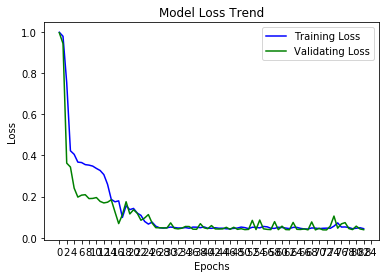

656/656 [==============================] - 0s 189us/step
Validating data's loss is 0.039
Testing data's loss is 0.022


In [75]:
# Define a function that displays the loss values for each epoch
def show_loss(history):
    loss = history['loss']
    val_loss = history['val_loss']

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Trend')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validating Loss')
    plt.xticks(range(0,len(loss)+2)[0::2])
    plt.legend()
    plt.show()

    
# Show the loss value of each epoch
show_loss(model_fit.history)

X_test = model_test_data.X
y_test = model_test_data.y

validate_evl = model.evaluate(X_validate,y_validate)
test_evl = model.evaluate(X_test, y_test)

print ("Validating data's loss is {:.3f}".format(validate_evl))
print ("Testing data's loss is {:.3f}".format(test_evl))


In [76]:
y_predict = model.predict(X_train)

def test_loss(y_pred,y_true):
    return np.mean(np.abs(np.exp(y_pred)/np.exp(y_true)-1))

test_loss = test_loss(y_predict,y_train)
test_loss

0.041519064898838005

### 3.3 Tuning model 

In [32]:
regressor = KerasRegressor(build_fn=build_model)

parameters = {
              'epochs': [1000],
              'batch_size': [128,256,512],
              'dropout' : [0.4, 0.2, 0.0],
              'units':[64,128,256]
              }

grid_search = GridSearchCV(estimator=regressor,
                           param_grid = parameters)
early_stopping = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="auto")
model_checkpoint = ModelCheckpoint('models/grid_search_train.hdf5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, mode='auto')
grid_search = grid_search.fit(X_train, y_train, validation_data=(X_validate, y_validate), callbacks=[early_stopping,model_checkpoint])
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, input_shape=(30, 5))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dropout_65 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 657 samples
Epoch 1/1000
1314/1314 [==============================] - 5s 4ms/step - loss: 0.9990 - val_loss: 0.9982

Epoch 00001: val_loss improved from inf to 0.99821, saving model to models/first_train.hdf5
Epoch 2/1000
1314/1314 [==============================] - 0s 303us/step - loss: 0.9951 - val_loss: 0.9913

Epoch 00002: val_loss improved from 0.99821 to 0.99

1314/1314 [==============================] - 0s 253us/step - loss: 0.6502 - val_loss: 0.6646

Epoch 00044: val_loss did not improve from 0.60220
Epoch 45/1000
1314/1314 [==============================] - 0s 269us/step - loss: 0.6382 - val_loss: 0.6404

Epoch 00045: val_loss did not improve from 0.60220
Epoch 46/1000
1314/1314 [==============================] - 0s 263us/step - loss: 0.6428 - val_loss: 0.6058

Epoch 00046: val_loss did not improve from 0.60220
Epoch 47/1000
1314/1314 [==============================] - 0s 269us/step - loss: 0.6423 - val_loss: 0.6449

Epoch 00047: val_loss did not improve from 0.60220
Epoch 48/1000
1314/1314 [==============================] - 0s 261us/step - loss: 0.6522 - val_loss: 0.6278

Epoch 00048: val_loss did not improve from 0.60220
Epoch 49/1000
1314/1314 [==============================] - 0s 263us/step - loss: 0.6407 - val_loss: 0.6030

Epoch 00049: val_loss did not improve from 0.60220
Epoch 50/1000
1314/1314 [==============================] - 0

1314/1314 [==============================] - 0s 263us/step - loss: 0.6440 - val_loss: 0.5927

Epoch 00094: val_loss did not improve from 0.55448
Epoch 95/1000
1314/1314 [==============================] - 0s 263us/step - loss: 0.6376 - val_loss: 0.5754

Epoch 00095: val_loss did not improve from 0.55448
Epoch 96/1000
1314/1314 [==============================] - 0s 284us/step - loss: 0.6122 - val_loss: 0.5917

Epoch 00096: val_loss did not improve from 0.55448
Epoch 97/1000
1314/1314 [==============================] - 0s 262us/step - loss: 0.6221 - val_loss: 0.6387

Epoch 00097: val_loss did not improve from 0.55448
Epoch 98/1000
1314/1314 [==============================] - 0s 278us/step - loss: 0.6337 - val_loss: 0.5871

Epoch 00098: val_loss did not improve from 0.55448
Epoch 99/1000
1314/1314 [==============================] - 0s 260us/step - loss: 0.6217 - val_loss: 0.5874

Epoch 00099: val_loss did not improve from 0.55448
Epoch 100/1000
1314/1314 [==============================] - 

1314/1314 [==============================] - 0s 263us/step - loss: 0.6016 - val_loss: 0.5895

Epoch 00144: val_loss did not improve from 0.52984
Epoch 145/1000
1314/1314 [==============================] - 0s 303us/step - loss: 0.6220 - val_loss: 0.5547

Epoch 00145: val_loss did not improve from 0.52984
Epoch 146/1000
1314/1314 [==============================] - 0s 322us/step - loss: 0.6060 - val_loss: 0.5847

Epoch 00146: val_loss did not improve from 0.52984
Epoch 147/1000
1314/1314 [==============================] - 0s 269us/step - loss: 0.6149 - val_loss: 0.5535

Epoch 00147: val_loss did not improve from 0.52984
Epoch 148/1000
1314/1314 [==============================] - 0s 264us/step - loss: 0.6199 - val_loss: 0.6111

Epoch 00148: val_loss did not improve from 0.52984
Epoch 149/1000
1314/1314 [==============================] - 0s 253us/step - loss: 0.6201 - val_loss: 0.5364

Epoch 00149: val_loss did not improve from 0.52984
Epoch 150/1000
1314/1314 [=============================

1314/1314 [==============================] - 0s 260us/step - loss: 0.6000 - val_loss: 0.5987

Epoch 00195: val_loss did not improve from 0.50894
Epoch 196/1000
1314/1314 [==============================] - 0s 253us/step - loss: 0.5730 - val_loss: 0.5384

Epoch 00196: val_loss did not improve from 0.50894
Epoch 197/1000
1314/1314 [==============================] - 0s 253us/step - loss: 0.5726 - val_loss: 0.5174

Epoch 00197: val_loss did not improve from 0.50894
Epoch 198/1000
1314/1314 [==============================] - 0s 253us/step - loss: 0.5884 - val_loss: 0.5854

Epoch 00198: val_loss did not improve from 0.50894
Epoch 199/1000
1314/1314 [==============================] - 0s 254us/step - loss: 0.5894 - val_loss: 0.5394

Epoch 00199: val_loss did not improve from 0.50894
Epoch 200/1000
1314/1314 [==============================] - 0s 253us/step - loss: 0.5929 - val_loss: 0.5375

Epoch 00200: val_loss did not improve from 0.50894
Epoch 201/1000
1314/1314 [=============================

1314/1314 [==============================] - 0s 282us/step - loss: 0.5795 - val_loss: 0.5197

Epoch 00246: val_loss did not improve from 0.47193
Epoch 247/1000
1314/1314 [==============================] - 0s 272us/step - loss: 0.5578 - val_loss: 0.5253

Epoch 00247: val_loss did not improve from 0.47193
Epoch 248/1000
1314/1314 [==============================] - 0s 253us/step - loss: 0.5679 - val_loss: 0.5192

Epoch 00248: val_loss did not improve from 0.47193
Epoch 249/1000
1314/1314 [==============================] - 0s 254us/step - loss: 0.5587 - val_loss: 0.5529

Epoch 00249: val_loss did not improve from 0.47193
Epoch 250/1000
1314/1314 [==============================] - 0s 253us/step - loss: 0.5700 - val_loss: 0.5220

Epoch 00250: val_loss did not improve from 0.47193
Epoch 251/1000
1314/1314 [==============================] - 0s 256us/step - loss: 0.5674 - val_loss: 0.5535

Epoch 00251: val_loss did not improve from 0.47193
Epoch 252/1000
1314/1314 [=============================

1315/1315 [==============================] - 0s 255us/step - loss: 0.6937 - val_loss: 0.7908

Epoch 00023: val_loss did not improve from 0.47193
Epoch 24/1000
1315/1315 [==============================] - 0s 250us/step - loss: 0.7327 - val_loss: 0.7667

Epoch 00024: val_loss did not improve from 0.47193
Epoch 25/1000
1315/1315 [==============================] - 0s 252us/step - loss: 0.7146 - val_loss: 0.7621

Epoch 00025: val_loss did not improve from 0.47193
Epoch 26/1000
1315/1315 [==============================] - 0s 252us/step - loss: 0.7293 - val_loss: 0.7856

Epoch 00026: val_loss did not improve from 0.47193
Epoch 27/1000
1315/1315 [==============================] - 0s 251us/step - loss: 0.6982 - val_loss: 0.7662

Epoch 00027: val_loss did not improve from 0.47193
Epoch 28/1000
1315/1315 [==============================] - 0s 259us/step - loss: 0.7295 - val_loss: 0.7655

Epoch 00028: val_loss did not improve from 0.47193
Epoch 29/1000
1315/1315 [==============================] - 0


Epoch 00074: val_loss did not improve from 0.47193
Epoch 75/1000
1315/1315 [==============================] - 0s 316us/step - loss: 0.6659 - val_loss: 0.6807

Epoch 00075: val_loss did not improve from 0.47193
Epoch 76/1000
1315/1315 [==============================] - 1s 437us/step - loss: 0.6781 - val_loss: 0.7206

Epoch 00076: val_loss did not improve from 0.47193
Epoch 77/1000
1315/1315 [==============================] - 0s 362us/step - loss: 0.6404 - val_loss: 0.6577

Epoch 00077: val_loss did not improve from 0.47193
Epoch 78/1000
1315/1315 [==============================] - 0s 320us/step - loss: 0.6581 - val_loss: 0.6321

Epoch 00078: val_loss did not improve from 0.47193
Epoch 79/1000
1315/1315 [==============================] - 0s 347us/step - loss: 0.6403 - val_loss: 0.6670

Epoch 00079: val_loss did not improve from 0.47193
Epoch 80/1000
1315/1315 [==============================] - 0s 331us/step - loss: 0.6551 - val_loss: 0.6360

Epoch 00080: val_loss did not improve from 0.

1315/1315 [==============================] - 0s 261us/step - loss: 0.6438 - val_loss: 0.6388

Epoch 00126: val_loss did not improve from 0.47193
Epoch 127/1000
1315/1315 [==============================] - 0s 257us/step - loss: 0.6349 - val_loss: 0.6263

Epoch 00127: val_loss did not improve from 0.47193
Epoch 128/1000
1315/1315 [==============================] - 1s 431us/step - loss: 0.6230 - val_loss: 0.6303

Epoch 00128: val_loss did not improve from 0.47193
Epoch 129/1000
1315/1315 [==============================] - 0s 268us/step - loss: 0.6340 - val_loss: 0.6118

Epoch 00129: val_loss did not improve from 0.47193
Epoch 130/1000
1315/1315 [==============================] - 0s 259us/step - loss: 0.6280 - val_loss: 0.6081

Epoch 00130: val_loss did not improve from 0.47193
Epoch 131/1000
1315/1315 [==============================] - 0s 259us/step - loss: 0.6561 - val_loss: 0.6875

Epoch 00131: val_loss did not improve from 0.47193
Epoch 132/1000
1315/1315 [=============================

1315/1315 [==============================] - 0s 260us/step - loss: 0.6218 - val_loss: 0.6181

Epoch 00177: val_loss did not improve from 0.47193
Epoch 178/1000
1315/1315 [==============================] - 0s 258us/step - loss: 0.6052 - val_loss: 0.5819

Epoch 00178: val_loss did not improve from 0.47193
Epoch 179/1000
1315/1315 [==============================] - 0s 258us/step - loss: 0.6097 - val_loss: 0.6283

Epoch 00179: val_loss did not improve from 0.47193
Epoch 180/1000
1315/1315 [==============================] - 0s 258us/step - loss: 0.6168 - val_loss: 0.6254

Epoch 00180: val_loss did not improve from 0.47193
Epoch 181/1000
1315/1315 [==============================] - 0s 259us/step - loss: 0.6075 - val_loss: 0.6214

Epoch 00181: val_loss did not improve from 0.47193
Epoch 182/1000
1315/1315 [==============================] - 0s 265us/step - loss: 0.6109 - val_loss: 0.6307

Epoch 00182: val_loss did not improve from 0.47193
Epoch 183/1000
1315/1315 [=============================

1315/1315 [==============================] - 0s 260us/step - loss: 0.5797 - val_loss: 0.5775

Epoch 00228: val_loss did not improve from 0.47193
Epoch 229/1000
1315/1315 [==============================] - 0s 258us/step - loss: 0.6144 - val_loss: 0.6360

Epoch 00229: val_loss did not improve from 0.47193
Epoch 230/1000
1315/1315 [==============================] - 0s 263us/step - loss: 0.6156 - val_loss: 0.6592

Epoch 00230: val_loss did not improve from 0.47193
Epoch 231/1000
1315/1315 [==============================] - 0s 265us/step - loss: 0.6137 - val_loss: 0.5818

Epoch 00231: val_loss did not improve from 0.47193
Epoch 232/1000
1315/1315 [==============================] - 0s 261us/step - loss: 0.5918 - val_loss: 0.6457

Epoch 00232: val_loss did not improve from 0.47193
Epoch 233/1000
1315/1315 [==============================] - 0s 275us/step - loss: 0.6103 - val_loss: 0.5771

Epoch 00233: val_loss did not improve from 0.47193
Epoch 234/1000
1315/1315 [=============================

1315/1315 [==============================] - 0s 284us/step - loss: 0.5848 - val_loss: 0.6188

Epoch 00279: val_loss did not improve from 0.47193
Epoch 280/1000
1315/1315 [==============================] - 0s 259us/step - loss: 0.5819 - val_loss: 0.5631

Epoch 00280: val_loss did not improve from 0.47193
Epoch 281/1000
1315/1315 [==============================] - 0s 316us/step - loss: 0.5732 - val_loss: 0.5967

Epoch 00281: val_loss did not improve from 0.47193
Epoch 282/1000
1315/1315 [==============================] - 0s 258us/step - loss: 0.5862 - val_loss: 0.6103

Epoch 00282: val_loss did not improve from 0.47193
Epoch 283/1000
1315/1315 [==============================] - 0s 275us/step - loss: 0.5710 - val_loss: 0.5507

Epoch 00283: val_loss did not improve from 0.47193
Epoch 284/1000
1315/1315 [==============================] - 0s 267us/step - loss: 0.5744 - val_loss: 0.5808

Epoch 00284: val_loss did not improve from 0.47193
Epoch 285/1000
1315/1315 [=============================

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 6s 4ms/step - loss: 0.9954 - val_loss: 0.9933

Epoch 00001: val_loss did not improve from 0.47193
Epoch 2/1000
1315/1315 [==============================] - 0s 252us/step - loss: 0.9791 - val_loss: 0.9791

Epoch 00002: val_loss did not improve from 0.47193
Epoch 3/1000
1315/1315 [==============================] - 0s 246us/step - loss: 0.9346 - val_loss: 0.9329

Epoch 00003: val_loss did not improve from 0.47193
Epoch 4/1000
1315/1315 [==============================] - 0s 229us/step - loss: 0.8052 - val_loss: 0.8015

Epoch 00004: val_loss did not improve from 0.47193
Epoch 5/1000
1315/1315 [==============================] - 0s 229us/step - loss: 0.7390 - val_loss: 0.7040

Epoch 00005: val_loss did not improve from 0.47193
Epoch 6/1000
1315/1315 [==============================] - 0s 224us/step - loss: 0.7161 - val_loss: 0.7704

Epoch 00006: val_loss did not improve from 0.47193
Epoch 7

1315/1315 [==============================] - 0s 230us/step - loss: 0.6556 - val_loss: 0.6785

Epoch 00052: val_loss did not improve from 0.47193
Epoch 53/1000
1315/1315 [==============================] - 0s 230us/step - loss: 0.6739 - val_loss: 0.7071

Epoch 00053: val_loss did not improve from 0.47193
Epoch 54/1000
1315/1315 [==============================] - 0s 217us/step - loss: 0.6383 - val_loss: 0.6746

Epoch 00054: val_loss did not improve from 0.47193
Epoch 55/1000
1315/1315 [==============================] - 0s 218us/step - loss: 0.6466 - val_loss: 0.6442

Epoch 00055: val_loss did not improve from 0.47193
Epoch 56/1000
1315/1315 [==============================] - 0s 218us/step - loss: 0.6593 - val_loss: 0.6863

Epoch 00056: val_loss did not improve from 0.47193
Epoch 57/1000
1315/1315 [==============================] - 0s 217us/step - loss: 0.6264 - val_loss: 0.6573

Epoch 00057: val_loss did not improve from 0.47193
Epoch 58/1000
1315/1315 [==============================] - 0


Epoch 00103: val_loss did not improve from 0.47193
Epoch 104/1000
1315/1315 [==============================] - 0s 233us/step - loss: 0.6179 - val_loss: 0.6161

Epoch 00104: val_loss did not improve from 0.47193
Epoch 105/1000
1315/1315 [==============================] - 0s 222us/step - loss: 0.6060 - val_loss: 0.5969

Epoch 00105: val_loss did not improve from 0.47193
Epoch 106/1000
1315/1315 [==============================] - 0s 221us/step - loss: 0.6066 - val_loss: 0.5234

Epoch 00106: val_loss did not improve from 0.47193
Epoch 107/1000
1315/1315 [==============================] - 0s 238us/step - loss: 0.6163 - val_loss: 0.5969

Epoch 00107: val_loss did not improve from 0.47193
Epoch 108/1000
1315/1315 [==============================] - 0s 262us/step - loss: 0.6225 - val_loss: 0.6187

Epoch 00108: val_loss did not improve from 0.47193
Epoch 109/1000
1315/1315 [==============================] - 0s 268us/step - loss: 0.6044 - val_loss: 0.5374

Epoch 00109: val_loss did not improve f

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, input_shape=(30, 5))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dropout_68 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 657 samples
Epoch 1/1000
1314/1314 [==============================] - 18s 14ms/step - loss: 0.9960 - val_loss: 0.9823

Epoch 00001: val_loss did not improve from 0.47193
Epoch 2/1000
1314/1314 [==============================] - 1s 697us/step - loss: 0.8605 - val_loss: 0.5176

Epoch 00002: val_loss did not improve from 0.47193
Epoch 3/1000
1314/1314 [===============

1314/1314 [==============================] - 1s 667us/step - loss: 0.5025 - val_loss: 0.3674

Epoch 00046: val_loss did not improve from 0.32914
Epoch 47/1000
1314/1314 [==============================] - 1s 656us/step - loss: 0.5209 - val_loss: 0.4791

Epoch 00047: val_loss did not improve from 0.32914
Epoch 48/1000
1314/1314 [==============================] - 1s 667us/step - loss: 0.4881 - val_loss: 0.3674

Epoch 00048: val_loss did not improve from 0.32914
Epoch 49/1000
1314/1314 [==============================] - 1s 661us/step - loss: 0.4899 - val_loss: 0.4571

Epoch 00049: val_loss did not improve from 0.32914
Epoch 50/1000
1314/1314 [==============================] - 1s 661us/step - loss: 0.5015 - val_loss: 0.3929

Epoch 00050: val_loss did not improve from 0.32914
Epoch 51/1000
1314/1314 [==============================] - 1s 702us/step - loss: 0.4804 - val_loss: 0.4228

Epoch 00051: val_loss did not improve from 0.32914
Epoch 52/1000
1314/1314 [==============================] - 1

1314/1314 [==============================] - 1s 660us/step - loss: 0.4855 - val_loss: 0.4416

Epoch 00097: val_loss did not improve from 0.31620
Epoch 98/1000
1314/1314 [==============================] - 1s 671us/step - loss: 0.4752 - val_loss: 0.4391

Epoch 00098: val_loss did not improve from 0.31620
Epoch 99/1000
1314/1314 [==============================] - 1s 661us/step - loss: 0.4825 - val_loss: 0.3738

Epoch 00099: val_loss did not improve from 0.31620
Epoch 100/1000
1314/1314 [==============================] - 1s 666us/step - loss: 0.4819 - val_loss: 0.3664

Epoch 00100: val_loss did not improve from 0.31620
Epoch 101/1000
1314/1314 [==============================] - 1s 663us/step - loss: 0.4809 - val_loss: 0.3682

Epoch 00101: val_loss did not improve from 0.31620
Epoch 102/1000
1314/1314 [==============================] - 1s 667us/step - loss: 0.4845 - val_loss: 0.4176

Epoch 00102: val_loss did not improve from 0.31620
Epoch 103/1000
1314/1314 [==============================]

1314/1314 [==============================] - 1s 666us/step - loss: 0.4882 - val_loss: 0.2803

Epoch 00148: val_loss improved from 0.31459 to 0.28032, saving model to models/first_train.hdf5
Epoch 149/1000
1314/1314 [==============================] - 1s 668us/step - loss: 0.4643 - val_loss: 0.3940

Epoch 00149: val_loss did not improve from 0.28032
Epoch 150/1000
1314/1314 [==============================] - 1s 656us/step - loss: 0.4799 - val_loss: 0.3543

Epoch 00150: val_loss did not improve from 0.28032
Epoch 151/1000
1314/1314 [==============================] - 1s 666us/step - loss: 0.4690 - val_loss: 0.3569

Epoch 00151: val_loss did not improve from 0.28032
Epoch 152/1000
1314/1314 [==============================] - 1s 664us/step - loss: 0.4707 - val_loss: 0.3656

Epoch 00152: val_loss did not improve from 0.28032
Epoch 153/1000
1314/1314 [==============================] - 1s 669us/step - loss: 0.4616 - val_loss: 0.3430

Epoch 00153: val_loss did not improve from 0.28032
Epoch 154/

1314/1314 [==============================] - 1s 692us/step - loss: 0.4636 - val_loss: 0.2925

Epoch 00199: val_loss did not improve from 0.26729
Epoch 200/1000
1314/1314 [==============================] - 1s 670us/step - loss: 0.4761 - val_loss: 0.4320

Epoch 00200: val_loss did not improve from 0.26729
Epoch 201/1000
1314/1314 [==============================] - 1s 696us/step - loss: 0.4772 - val_loss: 0.4058

Epoch 00201: val_loss did not improve from 0.26729
Epoch 202/1000
1314/1314 [==============================] - 1s 674us/step - loss: 0.4595 - val_loss: 0.3192

Epoch 00202: val_loss did not improve from 0.26729
Epoch 203/1000
1314/1314 [==============================] - 1s 894us/step - loss: 0.4587 - val_loss: 0.3337

Epoch 00203: val_loss did not improve from 0.26729
Epoch 204/1000
1314/1314 [==============================] - 1s 975us/step - loss: 0.4591 - val_loss: 0.4184

Epoch 00204: val_loss did not improve from 0.26729
Epoch 205/1000
1314/1314 [=============================

1315/1315 [==============================] - 1s 627us/step - loss: 0.5215 - val_loss: 0.4337

Epoch 00030: val_loss did not improve from 0.26729
Epoch 31/1000
1315/1315 [==============================] - 1s 617us/step - loss: 0.5183 - val_loss: 0.4194

Epoch 00031: val_loss did not improve from 0.26729
Epoch 32/1000
1315/1315 [==============================] - 1s 639us/step - loss: 0.4963 - val_loss: 0.5513

Epoch 00032: val_loss did not improve from 0.26729
Epoch 33/1000
1315/1315 [==============================] - 1s 622us/step - loss: 0.5310 - val_loss: 0.5028

Epoch 00033: val_loss did not improve from 0.26729
Epoch 34/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.5177 - val_loss: 0.4155

Epoch 00034: val_loss did not improve from 0.26729
Epoch 35/1000
1315/1315 [==============================] - 1s 619us/step - loss: 0.4954 - val_loss: 0.4458

Epoch 00035: val_loss did not improve from 0.26729
Epoch 36/1000
1315/1315 [==============================] - 1

1315/1315 [==============================] - 1s 717us/step - loss: 0.4864 - val_loss: 0.4673

Epoch 00081: val_loss did not improve from 0.22872
Epoch 82/1000
1315/1315 [==============================] - 1s 723us/step - loss: 0.4712 - val_loss: 0.3861

Epoch 00082: val_loss did not improve from 0.22872
Epoch 83/1000
1315/1315 [==============================] - 1s 725us/step - loss: 0.4769 - val_loss: 0.2480

Epoch 00083: val_loss did not improve from 0.22872
Epoch 84/1000
1315/1315 [==============================] - 1s 713us/step - loss: 0.5003 - val_loss: 0.3557

Epoch 00084: val_loss did not improve from 0.22872
Epoch 85/1000
1315/1315 [==============================] - 1s 718us/step - loss: 0.4752 - val_loss: 0.4210

Epoch 00085: val_loss did not improve from 0.22872
Epoch 86/1000
1315/1315 [==============================] - 1s 715us/step - loss: 0.4749 - val_loss: 0.4060

Epoch 00086: val_loss did not improve from 0.22872
Epoch 87/1000
1315/1315 [==============================] - 1

1315/1315 [==============================] - 1s 1ms/step - loss: 0.4803 - val_loss: 0.3162

Epoch 00132: val_loss did not improve from 0.20159
Epoch 133/1000
1315/1315 [==============================] - 1s 824us/step - loss: 0.4539 - val_loss: 0.4130

Epoch 00133: val_loss did not improve from 0.20159
Epoch 134/1000
1315/1315 [==============================] - 1s 867us/step - loss: 0.4581 - val_loss: 0.2968

Epoch 00134: val_loss did not improve from 0.20159
Epoch 135/1000
1315/1315 [==============================] - 1s 811us/step - loss: 0.4748 - val_loss: 0.3411

Epoch 00135: val_loss did not improve from 0.20159
Epoch 136/1000
1315/1315 [==============================] - 1s 808us/step - loss: 0.4601 - val_loss: 0.3247

Epoch 00136: val_loss did not improve from 0.20159
Epoch 137/1000
1315/1315 [==============================] - 1s 788us/step - loss: 0.4593 - val_loss: 0.3163

Epoch 00137: val_loss did not improve from 0.20159
Epoch 138/1000
1315/1315 [==============================]

1315/1315 [==============================] - 1s 903us/step - loss: 0.4962 - val_loss: 0.4291

Epoch 00028: val_loss did not improve from 0.20159
Epoch 29/1000
1315/1315 [==============================] - 1s 747us/step - loss: 0.4823 - val_loss: 0.5329

Epoch 00029: val_loss did not improve from 0.20159
Epoch 30/1000
1315/1315 [==============================] - 1s 738us/step - loss: 0.5233 - val_loss: 0.3596

Epoch 00030: val_loss did not improve from 0.20159
Epoch 31/1000
1315/1315 [==============================] - 1s 916us/step - loss: 0.5091 - val_loss: 0.2874

Epoch 00031: val_loss did not improve from 0.20159
Epoch 32/1000
1315/1315 [==============================] - 1s 884us/step - loss: 0.4980 - val_loss: 0.4183

Epoch 00032: val_loss did not improve from 0.20159
Epoch 33/1000
1315/1315 [==============================] - 1s 748us/step - loss: 0.4988 - val_loss: 0.4328

Epoch 00033: val_loss did not improve from 0.20159
Epoch 34/1000
1315/1315 [==============================] - 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 657 samples
Epoch 1/1000
1314/1314 [==============================] - 8s 6ms/step - loss: 0.8793 - val_loss: 0.3861

Epoch 00001: val_loss did not improve from 0.20159
Epoch 2/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.5647 - val_loss: 0.2348

Epoch 00002: val_loss did not improve from 0.20159
Epoch 3/1000
1314/1314 [=================

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3749 - val_loss: 0.2784

Epoch 00048: val_loss did not improve from 0.18786
Epoch 49/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3670 - val_loss: 0.3560

Epoch 00049: val_loss did not improve from 0.18786
Epoch 50/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3861 - val_loss: 0.3711

Epoch 00050: val_loss did not improve from 0.18786
Epoch 51/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3750 - val_loss: 0.3581

Epoch 00051: val_loss did not improve from 0.18786
Epoch 52/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3660 - val_loss: 0.2386

Epoch 00052: val_loss did not improve from 0.18786
Epoch 53/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3720 - val_loss: 0.2052

Epoch 00053: val_loss did not improve from 0.18786
Epoch 54/1000
1314/1314 [==============================] - 2s 2ms/step -

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3450 - val_loss: 0.2095

Epoch 00099: val_loss did not improve from 0.15616
Epoch 100/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3598 - val_loss: 0.3071

Epoch 00100: val_loss did not improve from 0.15616
Epoch 101/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3701 - val_loss: 0.2931

Epoch 00101: val_loss did not improve from 0.15616
Epoch 102/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3678 - val_loss: 0.2356

Epoch 00102: val_loss did not improve from 0.15616
Epoch 103/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3562 - val_loss: 0.2293

Epoch 00103: val_loss did not improve from 0.15616
Epoch 104/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3486 - val_loss: 0.1978

Epoch 00104: val_loss did not improve from 0.15616
Epoch 105/1000
1314/1314 [==============================] - 2s 2ms/

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3588 - val_loss: 0.3096

Epoch 00150: val_loss did not improve from 0.14619
Epoch 151/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3433 - val_loss: 0.1530

Epoch 00151: val_loss did not improve from 0.14619
Epoch 152/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3571 - val_loss: 0.1417

Epoch 00152: val_loss improved from 0.14619 to 0.14174, saving model to models/first_train.hdf5
Epoch 153/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3673 - val_loss: 0.1622

Epoch 00153: val_loss did not improve from 0.14174
Epoch 154/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3615 - val_loss: 0.1966

Epoch 00154: val_loss did not improve from 0.14174
Epoch 155/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3533 - val_loss: 0.3133

Epoch 00155: val_loss did not improve from 0.14174
Epoch 156/1000
1314/13

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3651 - val_loss: 0.3851

Epoch 00201: val_loss did not improve from 0.11865
Epoch 202/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3504 - val_loss: 0.2818

Epoch 00202: val_loss did not improve from 0.11865
Epoch 203/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3535 - val_loss: 0.2455

Epoch 00203: val_loss did not improve from 0.11865
Epoch 204/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3520 - val_loss: 0.2989

Epoch 00204: val_loss did not improve from 0.11865
Epoch 205/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3627 - val_loss: 0.1702

Epoch 00205: val_loss did not improve from 0.11865
Epoch 206/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3563 - val_loss: 0.1304

Epoch 00206: val_loss did not improve from 0.11865
Epoch 207/1000
1314/1314 [==============================] - 2s 2ms/

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 20s 15ms/step - loss: 0.8882 - val_loss: 0.5603

Epoch 00001: val_loss did not improve from 0.11865
Epoch 2/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.6407 - val_loss: 0.4618

Epoch 00002: val_loss did not improve from 0.11865
Epoch 3/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.5938 - val_loss: 0.5461

Epoch 00003: val_loss did not improve from 0.11865
Epoch 4/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.5517 - val_loss: 0.5224

Epoch 00004: val_loss did not improve from 0.11865
Epoch 5/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.5423 - val_loss: 0.5128

Epoch 00005: val_loss did not improve from 0.11865
Epoch 6/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.5304 - val_loss: 0.4779

Epoch 00006: val_loss did not improve from 0.11865
Epoch 7/1000
13

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3693 - val_loss: 0.1224

Epoch 00052: val_loss did not improve from 0.10087
Epoch 53/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3694 - val_loss: 0.2605

Epoch 00053: val_loss did not improve from 0.10087
Epoch 54/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3528 - val_loss: 0.2950

Epoch 00054: val_loss did not improve from 0.10087
Epoch 55/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3546 - val_loss: 0.2048

Epoch 00055: val_loss did not improve from 0.10087
Epoch 56/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3571 - val_loss: 0.2439

Epoch 00056: val_loss did not improve from 0.10087
Epoch 57/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3515 - val_loss: 0.2886

Epoch 00057: val_loss did not improve from 0.10087
Epoch 58/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.4051 - val_loss: 0.3298

Epoch 00018: val_loss did not improve from 0.10087
Epoch 19/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3929 - val_loss: 0.1544

Epoch 00019: val_loss did not improve from 0.10087
Epoch 20/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.4198 - val_loss: 0.2560

Epoch 00020: val_loss did not improve from 0.10087
Epoch 21/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3939 - val_loss: 0.2104

Epoch 00021: val_loss did not improve from 0.10087
Epoch 22/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3864 - val_loss: 0.3107

Epoch 00022: val_loss did not improve from 0.10087
Epoch 23/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3843 - val_loss: 0.3030

Epoch 00023: val_loss did not improve from 0.10087
Epoch 24/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3699 - val_loss: 0.3532

Epoch 00070: val_loss did not improve from 0.07246
Epoch 71/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3604 - val_loss: 0.1074

Epoch 00071: val_loss did not improve from 0.07246
Epoch 72/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3621 - val_loss: 0.1211

Epoch 00072: val_loss did not improve from 0.07246
Epoch 73/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3630 - val_loss: 0.1442

Epoch 00073: val_loss did not improve from 0.07246
Epoch 74/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3713 - val_loss: 0.1701

Epoch 00074: val_loss did not improve from 0.07246
Epoch 75/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3590 - val_loss: 0.2726

Epoch 00075: val_loss did not improve from 0.07246
Epoch 76/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3796 - val_loss: 0.3481

Epoch 00122: val_loss did not improve from 0.05249
Epoch 123/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3653 - val_loss: 0.2225

Epoch 00123: val_loss did not improve from 0.05249
Epoch 124/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3479 - val_loss: 0.2048

Epoch 00124: val_loss did not improve from 0.05249
Epoch 125/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3620 - val_loss: 0.2369

Epoch 00125: val_loss did not improve from 0.05249
Epoch 126/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3544 - val_loss: 0.1903

Epoch 00126: val_loss did not improve from 0.05249
Epoch 127/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3542 - val_loss: 0.2568

Epoch 00127: val_loss did not improve from 0.05249
Epoch 128/1000
1315/1315 [==============================] - 2s 2ms/

1314/1314 [==============================] - 0s 301us/step - loss: 0.4743 - val_loss: 0.3850

Epoch 00036: val_loss did not improve from 0.05249
Epoch 37/1000
1314/1314 [==============================] - 0s 309us/step - loss: 0.4774 - val_loss: 0.3911

Epoch 00037: val_loss did not improve from 0.05249
Epoch 38/1000
1314/1314 [==============================] - 0s 307us/step - loss: 0.4796 - val_loss: 0.3670

Epoch 00038: val_loss did not improve from 0.05249
Epoch 39/1000
1314/1314 [==============================] - 0s 308us/step - loss: 0.4782 - val_loss: 0.4179

Epoch 00039: val_loss did not improve from 0.05249
Epoch 40/1000
1314/1314 [==============================] - 0s 302us/step - loss: 0.4893 - val_loss: 0.3841

Epoch 00040: val_loss did not improve from 0.05249
Epoch 41/1000
1314/1314 [==============================] - 0s 306us/step - loss: 0.4793 - val_loss: 0.3821

Epoch 00041: val_loss did not improve from 0.05249
Epoch 42/1000
1314/1314 [==============================] - 0

1315/1315 [==============================] - 1s 385us/step - loss: 0.5578 - val_loss: 0.5889

Epoch 00025: val_loss did not improve from 0.05249
Epoch 26/1000
1315/1315 [==============================] - 0s 364us/step - loss: 0.5598 - val_loss: 0.5866

Epoch 00026: val_loss did not improve from 0.05249
Epoch 27/1000
1315/1315 [==============================] - 0s 336us/step - loss: 0.5540 - val_loss: 0.5690

Epoch 00027: val_loss did not improve from 0.05249
Epoch 28/1000
1315/1315 [==============================] - 0s 339us/step - loss: 0.5425 - val_loss: 0.6016

Epoch 00028: val_loss did not improve from 0.05249
Epoch 29/1000
1315/1315 [==============================] - 0s 328us/step - loss: 0.5676 - val_loss: 0.5643

Epoch 00029: val_loss did not improve from 0.05249
Epoch 30/1000
1315/1315 [==============================] - 0s 329us/step - loss: 0.5518 - val_loss: 0.6141

Epoch 00030: val_loss did not improve from 0.05249
Epoch 31/1000
1315/1315 [==============================] - 0


Epoch 00076: val_loss did not improve from 0.05249
Epoch 77/1000
1315/1315 [==============================] - 0s 314us/step - loss: 0.4827 - val_loss: 0.4804

Epoch 00077: val_loss did not improve from 0.05249
Epoch 78/1000
1315/1315 [==============================] - 0s 322us/step - loss: 0.4562 - val_loss: 0.4624

Epoch 00078: val_loss did not improve from 0.05249
Epoch 79/1000
1315/1315 [==============================] - 0s 338us/step - loss: 0.4701 - val_loss: 0.4236

Epoch 00079: val_loss did not improve from 0.05249
Epoch 80/1000
1315/1315 [==============================] - 0s 348us/step - loss: 0.4685 - val_loss: 0.4651

Epoch 00080: val_loss did not improve from 0.05249
Epoch 81/1000
1315/1315 [==============================] - 0s 341us/step - loss: 0.4627 - val_loss: 0.4663

Epoch 00081: val_loss did not improve from 0.05249
Epoch 82/1000
1315/1315 [==============================] - 0s 334us/step - loss: 0.4724 - val_loss: 0.5058

Epoch 00082: val_loss did not improve from 0.

1315/1315 [==============================] - 0s 358us/step - loss: 0.4539 - val_loss: 0.4979

Epoch 00128: val_loss did not improve from 0.05249
Epoch 129/1000
1315/1315 [==============================] - 0s 315us/step - loss: 0.4572 - val_loss: 0.5075

Epoch 00129: val_loss did not improve from 0.05249
Epoch 130/1000
1315/1315 [==============================] - 0s 319us/step - loss: 0.4653 - val_loss: 0.3474

Epoch 00130: val_loss did not improve from 0.05249
Epoch 131/1000
1315/1315 [==============================] - 0s 341us/step - loss: 0.4604 - val_loss: 0.4710

Epoch 00131: val_loss did not improve from 0.05249
Epoch 132/1000
1315/1315 [==============================] - 0s 331us/step - loss: 0.4421 - val_loss: 0.3876

Epoch 00132: val_loss did not improve from 0.05249
Epoch 133/1000
1315/1315 [==============================] - 0s 380us/step - loss: 0.4561 - val_loss: 0.4861

Epoch 00133: val_loss did not improve from 0.05249
Epoch 134/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 414us/step - loss: 0.4489 - val_loss: 0.3967

Epoch 00179: val_loss did not improve from 0.05249
Epoch 180/1000
1315/1315 [==============================] - 0s 364us/step - loss: 0.4449 - val_loss: 0.4517

Epoch 00180: val_loss did not improve from 0.05249
Epoch 181/1000
1315/1315 [==============================] - 0s 326us/step - loss: 0.4436 - val_loss: 0.3521

Epoch 00181: val_loss did not improve from 0.05249
Epoch 182/1000
1315/1315 [==============================] - 0s 322us/step - loss: 0.4482 - val_loss: 0.4078

Epoch 00182: val_loss did not improve from 0.05249
Epoch 183/1000
1315/1315 [==============================] - 0s 323us/step - loss: 0.4583 - val_loss: 0.5139

Epoch 00183: val_loss did not improve from 0.05249
Epoch 184/1000
1315/1315 [==============================] - 0s 328us/step - loss: 0.4369 - val_loss: 0.4551

Epoch 00184: val_loss did not improve from 0.05249
Epoch 185/1000
1315/1315 [=============================

1315/1315 [==============================] - 0s 367us/step - loss: 0.4312 - val_loss: 0.3495

Epoch 00230: val_loss did not improve from 0.05249
Epoch 231/1000
1315/1315 [==============================] - 0s 338us/step - loss: 0.4508 - val_loss: 0.4239

Epoch 00231: val_loss did not improve from 0.05249
Epoch 232/1000
1315/1315 [==============================] - 0s 335us/step - loss: 0.4334 - val_loss: 0.4747

Epoch 00232: val_loss did not improve from 0.05249
Epoch 233/1000
1315/1315 [==============================] - 0s 331us/step - loss: 0.4325 - val_loss: 0.3965

Epoch 00233: val_loss did not improve from 0.05249
Epoch 234/1000
1315/1315 [==============================] - 0s 341us/step - loss: 0.4130 - val_loss: 0.3911

Epoch 00234: val_loss did not improve from 0.05249
Epoch 235/1000
1315/1315 [==============================] - 1s 395us/step - loss: 0.4300 - val_loss: 0.4599

Epoch 00235: val_loss did not improve from 0.05249
Epoch 236/1000
1315/1315 [=============================

1315/1315 [==============================] - 0s 322us/step - loss: 0.4235 - val_loss: 0.3716

Epoch 00281: val_loss did not improve from 0.05249
Epoch 282/1000
1315/1315 [==============================] - 0s 314us/step - loss: 0.4041 - val_loss: 0.3672

Epoch 00282: val_loss did not improve from 0.05249
Epoch 283/1000
1315/1315 [==============================] - 0s 316us/step - loss: 0.4101 - val_loss: 0.3959

Epoch 00283: val_loss did not improve from 0.05249
Epoch 284/1000
1315/1315 [==============================] - 0s 319us/step - loss: 0.4070 - val_loss: 0.3906

Epoch 00284: val_loss did not improve from 0.05249
Epoch 285/1000
1315/1315 [==============================] - 0s 319us/step - loss: 0.4052 - val_loss: 0.3807

Epoch 00285: val_loss did not improve from 0.05249
Epoch 286/1000
1315/1315 [==============================] - 0s 319us/step - loss: 0.4117 - val_loss: 0.3693

Epoch 00286: val_loss did not improve from 0.05249
Epoch 287/1000
1315/1315 [=============================

1315/1315 [==============================] - 0s 319us/step - loss: 0.4571 - val_loss: 0.3119

Epoch 00034: val_loss did not improve from 0.05249
Epoch 35/1000
1315/1315 [==============================] - 0s 316us/step - loss: 0.4469 - val_loss: 0.4569

Epoch 00035: val_loss did not improve from 0.05249
Epoch 36/1000
1315/1315 [==============================] - 0s 317us/step - loss: 0.4818 - val_loss: 0.6150

Epoch 00036: val_loss did not improve from 0.05249
Epoch 37/1000
1315/1315 [==============================] - 0s 316us/step - loss: 0.4757 - val_loss: 0.3905

Epoch 00037: val_loss did not improve from 0.05249
Epoch 38/1000
1315/1315 [==============================] - 0s 315us/step - loss: 0.4494 - val_loss: 0.2687

Epoch 00038: val_loss did not improve from 0.05249
Epoch 39/1000
1315/1315 [==============================] - 0s 316us/step - loss: 0.4610 - val_loss: 0.3589

Epoch 00039: val_loss did not improve from 0.05249
Epoch 40/1000
1315/1315 [==============================] - 0

1314/1314 [==============================] - 1s 852us/step - loss: 0.9672 - val_loss: 0.8685

Epoch 00002: val_loss did not improve from 0.05249
Epoch 3/1000
1314/1314 [==============================] - 1s 829us/step - loss: 0.5649 - val_loss: 0.1981

Epoch 00003: val_loss did not improve from 0.05249
Epoch 4/1000
1314/1314 [==============================] - 1s 833us/step - loss: 0.4371 - val_loss: 0.3843

Epoch 00004: val_loss did not improve from 0.05249
Epoch 5/1000
1314/1314 [==============================] - 1s 836us/step - loss: 0.4213 - val_loss: 0.3132

Epoch 00005: val_loss did not improve from 0.05249
Epoch 6/1000
1314/1314 [==============================] - 1s 824us/step - loss: 0.3913 - val_loss: 0.1999

Epoch 00006: val_loss did not improve from 0.05249
Epoch 7/1000
1314/1314 [==============================] - 1s 829us/step - loss: 0.3970 - val_loss: 0.2791

Epoch 00007: val_loss did not improve from 0.05249
Epoch 8/1000
1314/1314 [==============================] - 1s 836u

1314/1314 [==============================] - 0s 229us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 7s 5ms/step - loss: 0.9936 - val_loss: 0.9751

Epoch 00001: val_loss did not improve from 0.05249
Epoch 2/1000
1315/1315 [==============================] - 1s 827us/step - loss: 0.7753 - val_loss: 0.2738

Epoch 00002: val_loss did not imp

1315/1315 [==============================] - 1s 816us/step - loss: 0.3455 - val_loss: 0.1603

Epoch 00047: val_loss did not improve from 0.05249
Epoch 48/1000
1315/1315 [==============================] - 1s 809us/step - loss: 0.3528 - val_loss: 0.1219

Epoch 00048: val_loss did not improve from 0.05249
Epoch 49/1000
1315/1315 [==============================] - 1s 826us/step - loss: 0.3628 - val_loss: 0.3836

Epoch 00049: val_loss did not improve from 0.05249
Epoch 50/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3613 - val_loss: 0.3530

Epoch 00050: val_loss did not improve from 0.05249
Epoch 51/1000
1315/1315 [==============================] - 1s 985us/step - loss: 0.3486 - val_loss: 0.2291

Epoch 00051: val_loss did not improve from 0.05249
Epoch 52/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3342 - val_loss: 0.3917

Epoch 00052: val_loss did not improve from 0.05249
Epoch 53/1000
1315/1315 [==============================] - 1s 1m

1315/1315 [==============================] - 1s 835us/step - loss: 0.3255 - val_loss: 0.0887

Epoch 00099: val_loss did not improve from 0.05249
Epoch 100/1000
1315/1315 [==============================] - 1s 830us/step - loss: 0.3431 - val_loss: 0.1888

Epoch 00100: val_loss did not improve from 0.05249
Epoch 101/1000
1315/1315 [==============================] - 1s 831us/step - loss: 0.3448 - val_loss: 0.2467

Epoch 00101: val_loss did not improve from 0.05249
Epoch 102/1000
1315/1315 [==============================] - 1s 829us/step - loss: 0.3310 - val_loss: 0.2391

Epoch 00102: val_loss did not improve from 0.05249
Epoch 103/1000
1315/1315 [==============================] - 1s 835us/step - loss: 0.3295 - val_loss: 0.2631

Epoch 00103: val_loss did not improve from 0.05249
Epoch 104/1000
1315/1315 [==============================] - 1s 825us/step - loss: 0.3189 - val_loss: 0.1099

Epoch 00104: val_loss did not improve from 0.05249
Epoch 105/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 845us/step - loss: 0.3169 - val_loss: 0.1756

Epoch 00150: val_loss did not improve from 0.05249
Epoch 151/1000
1315/1315 [==============================] - 1s 944us/step - loss: 0.3204 - val_loss: 0.2130

Epoch 00151: val_loss did not improve from 0.05249
Epoch 152/1000
1315/1315 [==============================] - 1s 856us/step - loss: 0.3121 - val_loss: 0.0846

Epoch 00152: val_loss did not improve from 0.05249
Epoch 153/1000
1315/1315 [==============================] - 1s 964us/step - loss: 0.3092 - val_loss: 0.1090

Epoch 00153: val_loss did not improve from 0.05249
Epoch 154/1000
1315/1315 [==============================] - 1s 887us/step - loss: 0.3176 - val_loss: 0.1947

Epoch 00154: val_loss did not improve from 0.05249
Epoch 155/1000
1315/1315 [==============================] - 1s 908us/step - loss: 0.3129 - val_loss: 0.1896

Epoch 00155: val_loss did not improve from 0.05249
Epoch 156/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 719us/step - loss: 0.3147 - val_loss: 0.2941

Epoch 00201: val_loss did not improve from 0.04803
Epoch 202/1000
1315/1315 [==============================] - 1s 706us/step - loss: 0.3260 - val_loss: 0.1765

Epoch 00202: val_loss did not improve from 0.04803
Epoch 203/1000
1315/1315 [==============================] - 1s 712us/step - loss: 0.3036 - val_loss: 0.1167

Epoch 00203: val_loss did not improve from 0.04803
Epoch 204/1000
1315/1315 [==============================] - 1s 704us/step - loss: 0.3192 - val_loss: 0.1410

Epoch 00204: val_loss did not improve from 0.04803
Epoch 205/1000
1315/1315 [==============================] - 1s 710us/step - loss: 0.3145 - val_loss: 0.3083

Epoch 00205: val_loss did not improve from 0.04803
Epoch 206/1000
1315/1315 [==============================] - 1s 714us/step - loss: 0.3175 - val_loss: 0.2640

Epoch 00206: val_loss did not improve from 0.04803
Epoch 207/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 721us/step - loss: 0.2899 - val_loss: 0.0754

Epoch 00252: val_loss did not improve from 0.04129
Epoch 253/1000
1315/1315 [==============================] - 1s 703us/step - loss: 0.3041 - val_loss: 0.2057

Epoch 00253: val_loss did not improve from 0.04129
Epoch 254/1000
1315/1315 [==============================] - 1s 710us/step - loss: 0.3035 - val_loss: 0.1657

Epoch 00254: val_loss did not improve from 0.04129
Epoch 255/1000
1315/1315 [==============================] - 1s 718us/step - loss: 0.3061 - val_loss: 0.1061

Epoch 00255: val_loss did not improve from 0.04129
Epoch 256/1000
1315/1315 [==============================] - 1s 708us/step - loss: 0.2967 - val_loss: 0.0736

Epoch 00256: val_loss did not improve from 0.04129
Epoch 257/1000
1315/1315 [==============================] - 1s 713us/step - loss: 0.2993 - val_loss: 0.1446

Epoch 00257: val_loss did not improve from 0.04129
Epoch 258/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 722us/step - loss: 0.2879 - val_loss: 0.0631

Epoch 00303: val_loss did not improve from 0.04003
Epoch 304/1000
1315/1315 [==============================] - 1s 709us/step - loss: 0.3021 - val_loss: 0.1151

Epoch 00304: val_loss did not improve from 0.04003
Epoch 305/1000
1315/1315 [==============================] - 1s 714us/step - loss: 0.3223 - val_loss: 0.2840

Epoch 00305: val_loss did not improve from 0.04003
Epoch 306/1000
1315/1315 [==============================] - 1s 709us/step - loss: 0.3064 - val_loss: 0.3064

Epoch 00306: val_loss did not improve from 0.04003
Epoch 307/1000
1315/1315 [==============================] - 1s 710us/step - loss: 0.3127 - val_loss: 0.2041

Epoch 00307: val_loss did not improve from 0.04003
Epoch 308/1000
1315/1315 [==============================] - 1s 713us/step - loss: 0.3030 - val_loss: 0.0612

Epoch 00308: val_loss did not improve from 0.04003
Epoch 309/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 928us/step - loss: 0.2893 - val_loss: 0.1900

Epoch 00354: val_loss did not improve from 0.04003
Epoch 355/1000
1315/1315 [==============================] - 1s 871us/step - loss: 0.2953 - val_loss: 0.1770

Epoch 00355: val_loss did not improve from 0.04003
Epoch 356/1000
1315/1315 [==============================] - 1s 814us/step - loss: 0.2720 - val_loss: 0.0396

Epoch 00356: val_loss improved from 0.04003 to 0.03958, saving model to models/first_train.hdf5
Epoch 357/1000
1315/1315 [==============================] - 1s 855us/step - loss: 0.2940 - val_loss: 0.1273

Epoch 00357: val_loss did not improve from 0.03958
Epoch 358/1000
1315/1315 [==============================] - 1s 722us/step - loss: 0.3039 - val_loss: 0.2862

Epoch 00358: val_loss did not improve from 0.03958
Epoch 359/1000
1315/1315 [==============================] - 1s 759us/step - loss: 0.3005 - val_loss: 0.0712

Epoch 00359: val_loss did not improve from 0.03958
Epoch 360/

1315/1315 [==============================] - 1s 716us/step - loss: 0.2768 - val_loss: 0.1527

Epoch 00405: val_loss did not improve from 0.03958
Epoch 406/1000
1315/1315 [==============================] - 1s 757us/step - loss: 0.2820 - val_loss: 0.1879

Epoch 00406: val_loss did not improve from 0.03958
Epoch 00406: early stopping
1315/1315 [==============================] - 0s 186us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dropout_79 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
Train on 1

1315/1315 [==============================] - 1s 972us/step - loss: 0.3508 - val_loss: 0.3933

Epoch 00045: val_loss did not improve from 0.03958
Epoch 46/1000
1315/1315 [==============================] - 1s 831us/step - loss: 0.3530 - val_loss: 0.2613

Epoch 00046: val_loss did not improve from 0.03958
Epoch 47/1000
1315/1315 [==============================] - 1s 951us/step - loss: 0.3273 - val_loss: 0.1233

Epoch 00047: val_loss did not improve from 0.03958
Epoch 48/1000
1315/1315 [==============================] - 1s 963us/step - loss: 0.3300 - val_loss: 0.2586

Epoch 00048: val_loss did not improve from 0.03958
Epoch 49/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3366 - val_loss: 0.2368

Epoch 00049: val_loss did not improve from 0.03958
Epoch 50/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3278 - val_loss: 0.2769

Epoch 00050: val_loss did not improve from 0.03958
Epoch 51/1000
1315/1315 [==============================] - 1s 97

Train on 1314 samples, validate on 657 samples
Epoch 1/1000
1314/1314 [==============================] - 56s 43ms/step - loss: 0.8426 - val_loss: 0.2250

Epoch 00001: val_loss did not improve from 0.03958
Epoch 2/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.3839 - val_loss: 0.2031

Epoch 00002: val_loss did not improve from 0.03958
Epoch 3/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.3407 - val_loss: 0.2028

Epoch 00003: val_loss did not improve from 0.03958
Epoch 4/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3330 - val_loss: 0.2635

Epoch 00004: val_loss did not improve from 0.03958
Epoch 5/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3181 - val_loss: 0.2596

Epoch 00005: val_loss did not improve from 0.03958
Epoch 6/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3182 - val_loss: 0.2507

Epoch 00006: val_loss did not improve from 0.03958
Epoch 7/1000
13

1314/1314 [==============================] - 3s 2ms/step - loss: 0.2458 - val_loss: 0.1341

Epoch 00053: val_loss did not improve from 0.03958
Epoch 54/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2430 - val_loss: 0.2445

Epoch 00054: val_loss did not improve from 0.03958
Epoch 55/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2499 - val_loss: 0.1200

Epoch 00055: val_loss did not improve from 0.03958
Epoch 56/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2574 - val_loss: 0.1271

Epoch 00056: val_loss did not improve from 0.03958
Epoch 57/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2628 - val_loss: 0.1550

Epoch 00057: val_loss did not improve from 0.03958
Epoch 58/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2506 - val_loss: 0.1382

Epoch 00058: val_loss did not improve from 0.03958
Epoch 59/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 2s 2ms/step - loss: 0.2255 - val_loss: 0.0900

Epoch 00105: val_loss did not improve from 0.03958
Epoch 106/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2351 - val_loss: 0.2188

Epoch 00106: val_loss did not improve from 0.03958
Epoch 107/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2422 - val_loss: 0.1012

Epoch 00107: val_loss did not improve from 0.03958
Epoch 108/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2377 - val_loss: 0.0941

Epoch 00108: val_loss did not improve from 0.03958
Epoch 109/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2362 - val_loss: 0.1530

Epoch 00109: val_loss did not improve from 0.03958
Epoch 110/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2323 - val_loss: 0.0912

Epoch 00110: val_loss did not improve from 0.03958
Epoch 111/1000
1314/1314 [==============================] - 3s 2ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.2896 - val_loss: 0.1035

Epoch 00014: val_loss did not improve from 0.03958
Epoch 15/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.2832 - val_loss: 0.1095

Epoch 00015: val_loss did not improve from 0.03958
Epoch 16/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.2861 - val_loss: 0.2248

Epoch 00016: val_loss did not improve from 0.03958
Epoch 17/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3009 - val_loss: 0.1190

Epoch 00017: val_loss did not improve from 0.03958
Epoch 18/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3053 - val_loss: 0.1054

Epoch 00018: val_loss did not improve from 0.03958
Epoch 19/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.2656 - val_loss: 0.3254

Epoch 00019: val_loss did not improve from 0.03958
Epoch 20/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.2447 - val_loss: 0.0979

Epoch 00066: val_loss did not improve from 0.03958
Epoch 67/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.2412 - val_loss: 0.1760

Epoch 00067: val_loss did not improve from 0.03958
Epoch 68/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2358 - val_loss: 0.1422

Epoch 00068: val_loss did not improve from 0.03958
Epoch 69/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.2202 - val_loss: 0.1357

Epoch 00069: val_loss did not improve from 0.03958
Epoch 70/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2183 - val_loss: 0.1004

Epoch 00070: val_loss did not improve from 0.03958
Epoch 71/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2242 - val_loss: 0.1151

Epoch 00071: val_loss did not improve from 0.03958
Epoch 72/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3163 - val_loss: 0.3525

Epoch 00010: val_loss did not improve from 0.03958
Epoch 11/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3270 - val_loss: 0.1818

Epoch 00011: val_loss did not improve from 0.03958
Epoch 12/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3090 - val_loss: 0.1660

Epoch 00012: val_loss did not improve from 0.03958
Epoch 13/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2834 - val_loss: 0.2377

Epoch 00013: val_loss did not improve from 0.03958
Epoch 14/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2949 - val_loss: 0.1648

Epoch 00014: val_loss did not improve from 0.03958
Epoch 15/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3049 - val_loss: 0.2707

Epoch 00015: val_loss did not improve from 0.03958
Epoch 16/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.2473 - val_loss: 0.1699

Epoch 00062: val_loss did not improve from 0.03958
Epoch 63/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2376 - val_loss: 0.1206

Epoch 00063: val_loss did not improve from 0.03958
Epoch 64/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2421 - val_loss: 0.1138

Epoch 00064: val_loss did not improve from 0.03958
Epoch 65/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2393 - val_loss: 0.1058

Epoch 00065: val_loss did not improve from 0.03958
Epoch 66/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2454 - val_loss: 0.1113

Epoch 00066: val_loss did not improve from 0.03958
Epoch 67/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2447 - val_loss: 0.2018

Epoch 00067: val_loss did not improve from 0.03958
Epoch 68/1000
1315/1315 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 1s 396us/step - loss: 0.0787 - val_loss: 0.1058

Epoch 00032: val_loss did not improve from 0.03958
Epoch 33/1000
1314/1314 [==============================] - 1s 393us/step - loss: 0.0643 - val_loss: 0.0865

Epoch 00033: val_loss did not improve from 0.03958
Epoch 34/1000
1314/1314 [==============================] - 0s 363us/step - loss: 0.0712 - val_loss: 0.1035

Epoch 00034: val_loss did not improve from 0.03958
Epoch 35/1000
1314/1314 [==============================] - 1s 450us/step - loss: 0.0657 - val_loss: 0.0954

Epoch 00035: val_loss did not improve from 0.03958
Epoch 36/1000
1314/1314 [==============================] - 1s 427us/step - loss: 0.0754 - val_loss: 0.0904

Epoch 00036: val_loss did not improve from 0.03958
Epoch 37/1000
1314/1314 [==============================] - 1s 412us/step - loss: 0.0638 - val_loss: 0.1142

Epoch 00037: val_loss did not improve from 0.03958
Epoch 38/1000
1314/1314 [==============================] - 1


Epoch 00083: val_loss did not improve from 0.03958
Epoch 84/1000
1314/1314 [==============================] - 1s 398us/step - loss: 0.0653 - val_loss: 0.1085

Epoch 00084: val_loss did not improve from 0.03958
Epoch 85/1000
1314/1314 [==============================] - 0s 356us/step - loss: 0.0617 - val_loss: 0.0956

Epoch 00085: val_loss did not improve from 0.03958
Epoch 86/1000
1314/1314 [==============================] - 0s 352us/step - loss: 0.0539 - val_loss: 0.0829

Epoch 00086: val_loss did not improve from 0.03958
Epoch 87/1000
1314/1314 [==============================] - 0s 379us/step - loss: 0.0487 - val_loss: 0.0823

Epoch 00087: val_loss did not improve from 0.03958
Epoch 88/1000
1314/1314 [==============================] - 1s 408us/step - loss: 0.0486 - val_loss: 0.0794

Epoch 00088: val_loss did not improve from 0.03958
Epoch 89/1000
1314/1314 [==============================] - 1s 393us/step - loss: 0.0520 - val_loss: 0.0858

Epoch 00089: val_loss did not improve from 0.

1314/1314 [==============================] - 0s 359us/step - loss: 0.0497 - val_loss: 0.0733

Epoch 00135: val_loss did not improve from 0.03958
Epoch 136/1000
1314/1314 [==============================] - 0s 353us/step - loss: 0.0514 - val_loss: 0.0890

Epoch 00136: val_loss did not improve from 0.03958
Epoch 137/1000
1314/1314 [==============================] - 0s 352us/step - loss: 0.0461 - val_loss: 0.0737

Epoch 00137: val_loss did not improve from 0.03958
Epoch 138/1000
1314/1314 [==============================] - 1s 391us/step - loss: 0.0455 - val_loss: 0.0743

Epoch 00138: val_loss did not improve from 0.03958
Epoch 139/1000
1314/1314 [==============================] - 0s 359us/step - loss: 0.0485 - val_loss: 0.0749

Epoch 00139: val_loss did not improve from 0.03958
Epoch 140/1000
1314/1314 [==============================] - 0s 352us/step - loss: 0.0471 - val_loss: 0.0754

Epoch 00140: val_loss did not improve from 0.03958
Epoch 141/1000
1314/1314 [=============================

1314/1314 [==============================] - 0s 356us/step - loss: 0.0420 - val_loss: 0.0631

Epoch 00186: val_loss did not improve from 0.03958
Epoch 187/1000
1314/1314 [==============================] - 0s 355us/step - loss: 0.0391 - val_loss: 0.0632

Epoch 00187: val_loss did not improve from 0.03958
Epoch 188/1000
1314/1314 [==============================] - 1s 388us/step - loss: 0.0402 - val_loss: 0.0720

Epoch 00188: val_loss did not improve from 0.03958
Epoch 189/1000
1314/1314 [==============================] - 0s 356us/step - loss: 0.0462 - val_loss: 0.0620

Epoch 00189: val_loss did not improve from 0.03958
Epoch 190/1000
1314/1314 [==============================] - 0s 353us/step - loss: 0.0396 - val_loss: 0.0620

Epoch 00190: val_loss did not improve from 0.03958
Epoch 191/1000
1314/1314 [==============================] - 0s 358us/step - loss: 0.0409 - val_loss: 0.0618

Epoch 00191: val_loss did not improve from 0.03958
Epoch 192/1000
1314/1314 [=============================

1314/1314 [==============================] - 0s 357us/step - loss: 0.0404 - val_loss: 0.0587

Epoch 00237: val_loss did not improve from 0.03958
Epoch 238/1000
1314/1314 [==============================] - 1s 395us/step - loss: 0.0435 - val_loss: 0.0601

Epoch 00238: val_loss did not improve from 0.03958
Epoch 239/1000
1314/1314 [==============================] - 0s 352us/step - loss: 0.0439 - val_loss: 0.0755

Epoch 00239: val_loss did not improve from 0.03958
Epoch 240/1000
1314/1314 [==============================] - 0s 355us/step - loss: 0.0447 - val_loss: 0.0714

Epoch 00240: val_loss did not improve from 0.03958
Epoch 241/1000
1314/1314 [==============================] - 0s 350us/step - loss: 0.0455 - val_loss: 0.0617

Epoch 00241: val_loss did not improve from 0.03958
Epoch 242/1000
1314/1314 [==============================] - 0s 354us/step - loss: 0.0406 - val_loss: 0.0660

Epoch 00242: val_loss did not improve from 0.03958
Epoch 243/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 422us/step - loss: 0.0432 - val_loss: 0.0583

Epoch 00288: val_loss did not improve from 0.03958
Epoch 289/1000
1314/1314 [==============================] - 0s 361us/step - loss: 0.0408 - val_loss: 0.0674

Epoch 00289: val_loss did not improve from 0.03958
Epoch 290/1000
1314/1314 [==============================] - 0s 368us/step - loss: 0.0553 - val_loss: 0.0829

Epoch 00290: val_loss did not improve from 0.03958
Epoch 291/1000
1314/1314 [==============================] - 0s 372us/step - loss: 0.0548 - val_loss: 0.0690

Epoch 00291: val_loss did not improve from 0.03958
Epoch 292/1000
1314/1314 [==============================] - 0s 366us/step - loss: 0.0469 - val_loss: 0.0800

Epoch 00292: val_loss did not improve from 0.03958
Epoch 293/1000
1314/1314 [==============================] - 0s 363us/step - loss: 0.0496 - val_loss: 0.0647

Epoch 00293: val_loss did not improve from 0.03958
Epoch 294/1000
1314/1314 [=============================

1314/1314 [==============================] - 0s 368us/step - loss: 0.0380 - val_loss: 0.0527

Epoch 00339: val_loss did not improve from 0.03958
Epoch 340/1000
1314/1314 [==============================] - 1s 467us/step - loss: 0.0383 - val_loss: 0.0504

Epoch 00340: val_loss did not improve from 0.03958
Epoch 341/1000
1314/1314 [==============================] - 0s 381us/step - loss: 0.0394 - val_loss: 0.0714

Epoch 00341: val_loss did not improve from 0.03958
Epoch 342/1000
1314/1314 [==============================] - 1s 465us/step - loss: 0.0457 - val_loss: 0.0682

Epoch 00342: val_loss did not improve from 0.03958
Epoch 343/1000
1314/1314 [==============================] - 1s 412us/step - loss: 0.0555 - val_loss: 0.0614

Epoch 00343: val_loss did not improve from 0.03958
Epoch 344/1000
1314/1314 [==============================] - 1s 421us/step - loss: 0.0489 - val_loss: 0.0575

Epoch 00344: val_loss did not improve from 0.03958
Epoch 345/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 419us/step - loss: 0.0420 - val_loss: 0.0542

Epoch 00390: val_loss did not improve from 0.03958
Epoch 391/1000
1314/1314 [==============================] - 0s 355us/step - loss: 0.0381 - val_loss: 0.0505

Epoch 00391: val_loss did not improve from 0.03958
Epoch 392/1000
1314/1314 [==============================] - 0s 358us/step - loss: 0.0393 - val_loss: 0.0543

Epoch 00392: val_loss did not improve from 0.03958
Epoch 393/1000
1314/1314 [==============================] - 0s 358us/step - loss: 0.0399 - val_loss: 0.0521

Epoch 00393: val_loss did not improve from 0.03958
Epoch 394/1000
1314/1314 [==============================] - 0s 358us/step - loss: 0.0382 - val_loss: 0.0544

Epoch 00394: val_loss did not improve from 0.03958
Epoch 395/1000
1314/1314 [==============================] - 1s 401us/step - loss: 0.0380 - val_loss: 0.0547

Epoch 00395: val_loss did not improve from 0.03958
Epoch 396/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 399us/step - loss: 0.0378 - val_loss: 0.0541

Epoch 00441: val_loss did not improve from 0.03958
Epoch 442/1000
1314/1314 [==============================] - 1s 400us/step - loss: 0.0379 - val_loss: 0.0514

Epoch 00442: val_loss did not improve from 0.03958
Epoch 443/1000
1314/1314 [==============================] - 1s 407us/step - loss: 0.0393 - val_loss: 0.0504

Epoch 00443: val_loss did not improve from 0.03958
Epoch 444/1000
1314/1314 [==============================] - 1s 382us/step - loss: 0.0379 - val_loss: 0.0634

Epoch 00444: val_loss did not improve from 0.03958
Epoch 445/1000
1314/1314 [==============================] - 1s 394us/step - loss: 0.0498 - val_loss: 0.0726

Epoch 00445: val_loss did not improve from 0.03958
Epoch 446/1000
1314/1314 [==============================] - 1s 412us/step - loss: 0.0509 - val_loss: 0.0584

Epoch 00446: val_loss did not improve from 0.03958
Epoch 447/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 403us/step - loss: 0.0445 - val_loss: 0.0533

Epoch 00492: val_loss did not improve from 0.03958
Epoch 493/1000
1314/1314 [==============================] - 0s 356us/step - loss: 0.0398 - val_loss: 0.0556

Epoch 00493: val_loss did not improve from 0.03958
Epoch 494/1000
1314/1314 [==============================] - 0s 358us/step - loss: 0.0388 - val_loss: 0.0547

Epoch 00494: val_loss did not improve from 0.03958
Epoch 495/1000
1314/1314 [==============================] - 1s 424us/step - loss: 0.0413 - val_loss: 0.0482

Epoch 00495: val_loss did not improve from 0.03958
Epoch 496/1000
1314/1314 [==============================] - 0s 372us/step - loss: 0.0377 - val_loss: 0.0466

Epoch 00496: val_loss did not improve from 0.03958
Epoch 497/1000
1314/1314 [==============================] - 1s 400us/step - loss: 0.0366 - val_loss: 0.0468

Epoch 00497: val_loss did not improve from 0.03958
Epoch 498/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 393us/step - loss: 0.0368 - val_loss: 0.0461

Epoch 00543: val_loss did not improve from 0.03958
Epoch 544/1000
1314/1314 [==============================] - 1s 393us/step - loss: 0.0385 - val_loss: 0.0465

Epoch 00544: val_loss did not improve from 0.03958
Epoch 545/1000
1314/1314 [==============================] - 1s 395us/step - loss: 0.0366 - val_loss: 0.0440

Epoch 00545: val_loss did not improve from 0.03958
Epoch 546/1000
1314/1314 [==============================] - 0s 352us/step - loss: 0.0379 - val_loss: 0.0487

Epoch 00546: val_loss did not improve from 0.03958
Epoch 547/1000
1314/1314 [==============================] - 1s 403us/step - loss: 0.0379 - val_loss: 0.0439

Epoch 00547: val_loss did not improve from 0.03958
Epoch 548/1000
1314/1314 [==============================] - 1s 428us/step - loss: 0.0369 - val_loss: 0.0599

Epoch 00548: val_loss did not improve from 0.03958
Epoch 549/1000
1314/1314 [=============================

1314/1314 [==============================] - 0s 358us/step - loss: 0.0366 - val_loss: 0.0423

Epoch 00594: val_loss did not improve from 0.03958
Epoch 595/1000
1314/1314 [==============================] - 1s 382us/step - loss: 0.0395 - val_loss: 0.0570

Epoch 00595: val_loss did not improve from 0.03958
Epoch 596/1000
1314/1314 [==============================] - 0s 374us/step - loss: 0.0531 - val_loss: 0.0465

Epoch 00596: val_loss did not improve from 0.03958
Epoch 597/1000
1314/1314 [==============================] - 0s 377us/step - loss: 0.0513 - val_loss: 0.0627

Epoch 00597: val_loss did not improve from 0.03958
Epoch 598/1000
1314/1314 [==============================] - 1s 454us/step - loss: 0.0455 - val_loss: 0.0466

Epoch 00598: val_loss did not improve from 0.03958
Epoch 599/1000
1314/1314 [==============================] - 1s 399us/step - loss: 0.0413 - val_loss: 0.0497

Epoch 00599: val_loss did not improve from 0.03958
Epoch 600/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 387us/step - loss: 0.0381 - val_loss: 0.0419

Epoch 00645: val_loss did not improve from 0.03958
Epoch 646/1000
1314/1314 [==============================] - 1s 419us/step - loss: 0.0409 - val_loss: 0.0489

Epoch 00646: val_loss did not improve from 0.03958
Epoch 647/1000
1314/1314 [==============================] - 1s 385us/step - loss: 0.0406 - val_loss: 0.0479

Epoch 00647: val_loss did not improve from 0.03958
Epoch 648/1000
1314/1314 [==============================] - 0s 365us/step - loss: 0.0403 - val_loss: 0.0559

Epoch 00648: val_loss did not improve from 0.03958
Epoch 649/1000
1314/1314 [==============================] - 0s 369us/step - loss: 0.0421 - val_loss: 0.0475

Epoch 00649: val_loss did not improve from 0.03958
Epoch 650/1000
1314/1314 [==============================] - 0s 359us/step - loss: 0.0475 - val_loss: 0.0512

Epoch 00650: val_loss did not improve from 0.03958
Epoch 651/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 408us/step - loss: 0.0407 - val_loss: 0.0426

Epoch 00696: val_loss did not improve from 0.03909
Epoch 697/1000
1314/1314 [==============================] - 1s 393us/step - loss: 0.0385 - val_loss: 0.0387

Epoch 00697: val_loss improved from 0.03909 to 0.03873, saving model to models/first_train.hdf5
Epoch 698/1000
1314/1314 [==============================] - 0s 377us/step - loss: 0.0376 - val_loss: 0.0440

Epoch 00698: val_loss did not improve from 0.03873
Epoch 699/1000
1314/1314 [==============================] - 1s 410us/step - loss: 0.0373 - val_loss: 0.0386

Epoch 00699: val_loss improved from 0.03873 to 0.03857, saving model to models/first_train.hdf5
Epoch 700/1000
1314/1314 [==============================] - 1s 390us/step - loss: 0.0369 - val_loss: 0.0393

Epoch 00700: val_loss did not improve from 0.03857
Epoch 701/1000
1314/1314 [==============================] - 1s 408us/step - loss: 0.0365 - val_loss: 0.0393

Epoch 00701: val

1314/1314 [==============================] - 1s 385us/step - loss: 0.0376 - val_loss: 0.0394

Epoch 00746: val_loss did not improve from 0.03832
Epoch 747/1000
1314/1314 [==============================] - 0s 378us/step - loss: 0.0369 - val_loss: 0.0408

Epoch 00747: val_loss did not improve from 0.03832
Epoch 748/1000
1314/1314 [==============================] - 1s 382us/step - loss: 0.0386 - val_loss: 0.0428

Epoch 00748: val_loss did not improve from 0.03832
Epoch 749/1000
1314/1314 [==============================] - 1s 413us/step - loss: 0.0375 - val_loss: 0.0454

Epoch 00749: val_loss did not improve from 0.03832
Epoch 750/1000
1314/1314 [==============================] - 0s 379us/step - loss: 0.0396 - val_loss: 0.0394

Epoch 00750: val_loss did not improve from 0.03832
Epoch 751/1000
1314/1314 [==============================] - 0s 376us/step - loss: 0.0404 - val_loss: 0.0396

Epoch 00751: val_loss did not improve from 0.03832
Epoch 752/1000
1314/1314 [=============================

1315/1315 [==============================] - 1s 398us/step - loss: 0.0644 - val_loss: 0.1186

Epoch 00028: val_loss did not improve from 0.03832
Epoch 29/1000
1315/1315 [==============================] - 1s 395us/step - loss: 0.0603 - val_loss: 0.0880

Epoch 00029: val_loss did not improve from 0.03832
Epoch 30/1000
1315/1315 [==============================] - 1s 392us/step - loss: 0.0520 - val_loss: 0.0621

Epoch 00030: val_loss did not improve from 0.03832
Epoch 31/1000
1315/1315 [==============================] - 1s 390us/step - loss: 0.0536 - val_loss: 0.0643

Epoch 00031: val_loss did not improve from 0.03832
Epoch 32/1000
1315/1315 [==============================] - 1s 389us/step - loss: 0.0512 - val_loss: 0.0539

Epoch 00032: val_loss did not improve from 0.03832
Epoch 33/1000
1315/1315 [==============================] - 1s 390us/step - loss: 0.0760 - val_loss: 0.1565

Epoch 00033: val_loss did not improve from 0.03832
Epoch 34/1000
1315/1315 [==============================] - 1


Epoch 00079: val_loss did not improve from 0.03832
Epoch 80/1000
1315/1315 [==============================] - 1s 388us/step - loss: 0.0497 - val_loss: 0.0427

Epoch 00080: val_loss did not improve from 0.03832
Epoch 81/1000
1315/1315 [==============================] - 1s 390us/step - loss: 0.0415 - val_loss: 0.0491

Epoch 00081: val_loss did not improve from 0.03832
Epoch 82/1000
1315/1315 [==============================] - 1s 390us/step - loss: 0.0358 - val_loss: 0.0438

Epoch 00082: val_loss did not improve from 0.03832
Epoch 83/1000
1315/1315 [==============================] - 1s 386us/step - loss: 0.0352 - val_loss: 0.0434

Epoch 00083: val_loss did not improve from 0.03832
Epoch 84/1000
1315/1315 [==============================] - 1s 387us/step - loss: 0.0366 - val_loss: 0.0423

Epoch 00084: val_loss did not improve from 0.03832
Epoch 85/1000
1315/1315 [==============================] - 1s 387us/step - loss: 0.0358 - val_loss: 0.0417

Epoch 00085: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 390us/step - loss: 0.0363 - val_loss: 0.0465

Epoch 00131: val_loss did not improve from 0.03832
Epoch 132/1000
1315/1315 [==============================] - 1s 381us/step - loss: 0.0346 - val_loss: 0.0412

Epoch 00132: val_loss did not improve from 0.03832
Epoch 133/1000
1315/1315 [==============================] - 1s 383us/step - loss: 0.0354 - val_loss: 0.0576

Epoch 00133: val_loss did not improve from 0.03832
Epoch 134/1000
1315/1315 [==============================] - 1s 389us/step - loss: 0.0438 - val_loss: 0.0405

Epoch 00134: val_loss did not improve from 0.03832
Epoch 135/1000
1315/1315 [==============================] - 1s 402us/step - loss: 0.0355 - val_loss: 0.0475

Epoch 00135: val_loss did not improve from 0.03832
Epoch 136/1000
1315/1315 [==============================] - 1s 553us/step - loss: 0.0395 - val_loss: 0.0405

Epoch 00136: val_loss did not improve from 0.03832
Epoch 137/1000
1315/1315 [=============================

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 9s 7ms/step - loss: 0.9957 - val_loss: 0.9909

Epoch 00001: val_loss did not improve from 0.03832
Epoch 2/1000
1315/1315 [==============================] - 1s 475us/step - loss: 0.9694 - val_loss: 0.9467

Epoch 00002: val_loss did not improve from 0.03832
Epoch 3/1000
1315/1315 [==============================] - 1s 481us/step - loss: 0.8503 - val_loss: 0.7798

Epoch 00003: val_loss did not improve from 0.03832
Epoch 4/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.5490 - val_loss: 0.3810

Epoch 00004: val_loss did not improve from 0.03832
Epoch 5/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.4832 - val_loss: 0.3369

Epoch 00005: val_loss did not improve from 0.03832
Epoch 6/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.4632 - val_loss: 0.4781

Epoch 00006: val_loss did not improve from 0.03832
Epoch 7

1315/1315 [==============================] - 1s 472us/step - loss: 0.0724 - val_loss: 0.0712

Epoch 00052: val_loss did not improve from 0.03832
Epoch 53/1000
1315/1315 [==============================] - 1s 468us/step - loss: 0.0726 - val_loss: 0.1008

Epoch 00053: val_loss did not improve from 0.03832
Epoch 54/1000
1315/1315 [==============================] - 1s 478us/step - loss: 0.0660 - val_loss: 0.0728

Epoch 00054: val_loss did not improve from 0.03832
Epoch 55/1000
1315/1315 [==============================] - 1s 503us/step - loss: 0.0648 - val_loss: 0.0962

Epoch 00055: val_loss did not improve from 0.03832
Epoch 56/1000
1315/1315 [==============================] - 1s 473us/step - loss: 0.0714 - val_loss: 0.1280

Epoch 00056: val_loss did not improve from 0.03832
Epoch 57/1000
1315/1315 [==============================] - 1s 474us/step - loss: 0.0820 - val_loss: 0.0924

Epoch 00057: val_loss did not improve from 0.03832
Epoch 58/1000
1315/1315 [==============================] - 1


Epoch 00103: val_loss did not improve from 0.03832
Epoch 104/1000
1315/1315 [==============================] - 1s 481us/step - loss: 0.0647 - val_loss: 0.0875

Epoch 00104: val_loss did not improve from 0.03832
Epoch 105/1000
1315/1315 [==============================] - 1s 488us/step - loss: 0.0592 - val_loss: 0.0759

Epoch 00105: val_loss did not improve from 0.03832
Epoch 106/1000
1315/1315 [==============================] - 1s 478us/step - loss: 0.0627 - val_loss: 0.0505

Epoch 00106: val_loss did not improve from 0.03832
Epoch 107/1000
1315/1315 [==============================] - 1s 473us/step - loss: 0.0612 - val_loss: 0.0476

Epoch 00107: val_loss did not improve from 0.03832
Epoch 108/1000
1315/1315 [==============================] - 1s 474us/step - loss: 0.0627 - val_loss: 0.1244

Epoch 00108: val_loss did not improve from 0.03832
Epoch 109/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.0713 - val_loss: 0.0735

Epoch 00109: val_loss did not improve f

1315/1315 [==============================] - 1s 471us/step - loss: 0.0519 - val_loss: 0.0643

Epoch 00155: val_loss did not improve from 0.03832
Epoch 156/1000
1315/1315 [==============================] - 1s 466us/step - loss: 0.0510 - val_loss: 0.0799

Epoch 00156: val_loss did not improve from 0.03832
Epoch 157/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.0551 - val_loss: 0.0424

Epoch 00157: val_loss did not improve from 0.03832
Epoch 158/1000
1315/1315 [==============================] - 1s 499us/step - loss: 0.0536 - val_loss: 0.0710

Epoch 00158: val_loss did not improve from 0.03832
Epoch 159/1000
1315/1315 [==============================] - 1s 483us/step - loss: 0.0554 - val_loss: 0.0430

Epoch 00159: val_loss did not improve from 0.03832
Epoch 160/1000
1315/1315 [==============================] - 1s 481us/step - loss: 0.0626 - val_loss: 0.0735

Epoch 00160: val_loss did not improve from 0.03832
Epoch 161/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 471us/step - loss: 0.0553 - val_loss: 0.0773

Epoch 00206: val_loss did not improve from 0.03832
Epoch 207/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.0504 - val_loss: 0.0784

Epoch 00207: val_loss did not improve from 0.03832
Epoch 208/1000
1315/1315 [==============================] - 1s 474us/step - loss: 0.0541 - val_loss: 0.1035

Epoch 00208: val_loss did not improve from 0.03832
Epoch 209/1000
1315/1315 [==============================] - 1s 472us/step - loss: 0.0617 - val_loss: 0.0471

Epoch 00209: val_loss did not improve from 0.03832
Epoch 210/1000
1315/1315 [==============================] - 1s 472us/step - loss: 0.0631 - val_loss: 0.0905

Epoch 00210: val_loss did not improve from 0.03832
Epoch 211/1000
1315/1315 [==============================] - 1s 468us/step - loss: 0.0646 - val_loss: 0.0456

Epoch 00211: val_loss did not improve from 0.03832
Epoch 212/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 474us/step - loss: 0.0514 - val_loss: 0.0439

Epoch 00257: val_loss did not improve from 0.03832
Epoch 258/1000
1315/1315 [==============================] - ETA: 0s - loss: 0.056 - 1s 477us/step - loss: 0.0563 - val_loss: 0.0565

Epoch 00258: val_loss did not improve from 0.03832
Epoch 259/1000
1315/1315 [==============================] - 1s 476us/step - loss: 0.0519 - val_loss: 0.0525

Epoch 00259: val_loss did not improve from 0.03832
Epoch 260/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.0485 - val_loss: 0.0569

Epoch 00260: val_loss did not improve from 0.03832
Epoch 261/1000
1315/1315 [==============================] - 1s 470us/step - loss: 0.0489 - val_loss: 0.0417

Epoch 00261: val_loss did not improve from 0.03832
Epoch 262/1000
1315/1315 [==============================] - 1s 474us/step - loss: 0.0575 - val_loss: 0.0836

Epoch 00262: val_loss did not improve from 0.03832
Epoch 263/1000
1315/1315 [=====

1315/1315 [==============================] - 1s 474us/step - loss: 0.0548 - val_loss: 0.0717

Epoch 00308: val_loss did not improve from 0.03832
Epoch 309/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.0483 - val_loss: 0.0414

Epoch 00309: val_loss did not improve from 0.03832
Epoch 310/1000
1315/1315 [==============================] - 1s 474us/step - loss: 0.0447 - val_loss: 0.0472

Epoch 00310: val_loss did not improve from 0.03832
Epoch 311/1000
1315/1315 [==============================] - 1s 475us/step - loss: 0.0462 - val_loss: 0.0623

Epoch 00311: val_loss did not improve from 0.03832
Epoch 312/1000
1315/1315 [==============================] - 1s 476us/step - loss: 0.0480 - val_loss: 0.0395

Epoch 00312: val_loss did not improve from 0.03832
Epoch 313/1000
1315/1315 [==============================] - 1s 472us/step - loss: 0.0494 - val_loss: 0.0430

Epoch 00313: val_loss did not improve from 0.03832
Epoch 314/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 474us/step - loss: 0.0470 - val_loss: 0.0418

Epoch 00359: val_loss did not improve from 0.03832
Epoch 360/1000
1315/1315 [==============================] - 1s 471us/step - loss: 0.0446 - val_loss: 0.0407

Epoch 00360: val_loss did not improve from 0.03832
Epoch 361/1000
1315/1315 [==============================] - 1s 473us/step - loss: 0.0499 - val_loss: 0.0480

Epoch 00361: val_loss did not improve from 0.03832
Epoch 362/1000
1315/1315 [==============================] - 1s 473us/step - loss: 0.0491 - val_loss: 0.0531

Epoch 00362: val_loss did not improve from 0.03832
Epoch 363/1000
1315/1315 [==============================] - 1s 470us/step - loss: 0.0441 - val_loss: 0.0397

Epoch 00363: val_loss did not improve from 0.03832
Epoch 364/1000
1315/1315 [==============================] - 1s 467us/step - loss: 0.0500 - val_loss: 0.0402

Epoch 00364: val_loss did not improve from 0.03832
Epoch 365/1000
1315/1315 [=============================

1314/1314 [==============================] - 1s 1ms/step - loss: 0.1202 - val_loss: 0.1531

Epoch 00039: val_loss did not improve from 0.03832
Epoch 40/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.1266 - val_loss: 0.1756

Epoch 00040: val_loss did not improve from 0.03832
Epoch 41/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.1316 - val_loss: 0.1713

Epoch 00041: val_loss did not improve from 0.03832
Epoch 42/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.1356 - val_loss: 0.1717

Epoch 00042: val_loss did not improve from 0.03832
Epoch 43/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1218 - val_loss: 0.1700

Epoch 00043: val_loss did not improve from 0.03832
Epoch 44/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.1152 - val_loss: 0.1785

Epoch 00044: val_loss did not improve from 0.03832
Epoch 45/1000
1314/1314 [==============================] - 1s 1ms/step -

1314/1314 [==============================] - 1s 1ms/step - loss: 0.0438 - val_loss: 0.0629

Epoch 00091: val_loss did not improve from 0.03832
Epoch 92/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.0547 - val_loss: 0.0538

Epoch 00092: val_loss did not improve from 0.03832
Epoch 93/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.0497 - val_loss: 0.0832

Epoch 00093: val_loss did not improve from 0.03832
Epoch 94/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.0657 - val_loss: 0.0700

Epoch 00094: val_loss did not improve from 0.03832
Epoch 95/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.0540 - val_loss: 0.0502

Epoch 00095: val_loss did not improve from 0.03832
Epoch 96/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.0452 - val_loss: 0.0450

Epoch 00096: val_loss did not improve from 0.03832
Epoch 97/1000
1314/1314 [==============================] - 1s 1ms/step -

1314/1314 [==============================] - 1s 823us/step - loss: 0.0436 - val_loss: 0.0573

Epoch 00142: val_loss did not improve from 0.03825
Epoch 143/1000
1314/1314 [==============================] - 1s 808us/step - loss: 0.0479 - val_loss: 0.0826

Epoch 00143: val_loss did not improve from 0.03825
Epoch 144/1000
1314/1314 [==============================] - 1s 817us/step - loss: 0.0510 - val_loss: 0.0456

Epoch 00144: val_loss did not improve from 0.03825
Epoch 145/1000
1314/1314 [==============================] - 1s 815us/step - loss: 0.0451 - val_loss: 0.0445

Epoch 00145: val_loss did not improve from 0.03825
Epoch 146/1000
1314/1314 [==============================] - 1s 817us/step - loss: 0.0441 - val_loss: 0.0434

Epoch 00146: val_loss did not improve from 0.03825
Epoch 147/1000
1314/1314 [==============================] - 1s 808us/step - loss: 0.0411 - val_loss: 0.0628

Epoch 00147: val_loss did not improve from 0.03825
Epoch 148/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 818us/step - loss: 0.0389 - val_loss: 0.0388

Epoch 00192: val_loss did not improve from 0.03748
Epoch 193/1000
1314/1314 [==============================] - 1s 824us/step - loss: 0.0384 - val_loss: 0.0486

Epoch 00193: val_loss did not improve from 0.03748
Epoch 194/1000
1314/1314 [==============================] - 1s 818us/step - loss: 0.0389 - val_loss: 0.0375

Epoch 00194: val_loss did not improve from 0.03748
Epoch 195/1000
1314/1314 [==============================] - 1s 807us/step - loss: 0.0502 - val_loss: 0.0512

Epoch 00195: val_loss did not improve from 0.03748
Epoch 196/1000
1314/1314 [==============================] - 1s 815us/step - loss: 0.0472 - val_loss: 0.0521

Epoch 00196: val_loss did not improve from 0.03748
Epoch 197/1000
1314/1314 [==============================] - 1s 820us/step - loss: 0.0402 - val_loss: 0.0407

Epoch 00197: val_loss did not improve from 0.03748
Epoch 198/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 830us/step - loss: 0.0488 - val_loss: 0.0644

Epoch 00243: val_loss did not improve from 0.03735
Epoch 244/1000
1314/1314 [==============================] - 1s 947us/step - loss: 0.0402 - val_loss: 0.0383

Epoch 00244: val_loss did not improve from 0.03735
Epoch 245/1000
1314/1314 [==============================] - 1s 823us/step - loss: 0.0385 - val_loss: 0.0390

Epoch 00245: val_loss did not improve from 0.03735
Epoch 246/1000
1314/1314 [==============================] - 1s 818us/step - loss: 0.0403 - val_loss: 0.0392

Epoch 00246: val_loss did not improve from 0.03735
Epoch 247/1000
1314/1314 [==============================] - 1s 897us/step - loss: 0.0413 - val_loss: 0.0399

Epoch 00247: val_loss did not improve from 0.03735
Epoch 248/1000
1314/1314 [==============================] - 1s 884us/step - loss: 0.0427 - val_loss: 0.0389

Epoch 00248: val_loss did not improve from 0.03735
Epoch 249/1000
1314/1314 [=============================

1315/1315 [==============================] - 1s 905us/step - loss: 0.0494 - val_loss: 0.0885

Epoch 00037: val_loss did not improve from 0.03735
Epoch 38/1000
1315/1315 [==============================] - 1s 951us/step - loss: 0.0563 - val_loss: 0.0971

Epoch 00038: val_loss did not improve from 0.03735
Epoch 39/1000
1315/1315 [==============================] - 1s 931us/step - loss: 0.0536 - val_loss: 0.0727

Epoch 00039: val_loss did not improve from 0.03735
Epoch 40/1000
1315/1315 [==============================] - 1s 910us/step - loss: 0.0497 - val_loss: 0.0772

Epoch 00040: val_loss did not improve from 0.03735
Epoch 41/1000
1315/1315 [==============================] - 1s 941us/step - loss: 0.0440 - val_loss: 0.0664

Epoch 00041: val_loss did not improve from 0.03735
Epoch 42/1000
1315/1315 [==============================] - 1s 922us/step - loss: 0.0499 - val_loss: 0.0891

Epoch 00042: val_loss did not improve from 0.03735
Epoch 43/1000
1315/1315 [==============================] - 1


Epoch 00088: val_loss did not improve from 0.03735
Epoch 89/1000
1315/1315 [==============================] - 1s 962us/step - loss: 0.0394 - val_loss: 0.0515

Epoch 00089: val_loss did not improve from 0.03735
Epoch 90/1000
1315/1315 [==============================] - 1s 932us/step - loss: 0.0351 - val_loss: 0.0665

Epoch 00090: val_loss did not improve from 0.03735
Epoch 91/1000
1315/1315 [==============================] - 1s 926us/step - loss: 0.0396 - val_loss: 0.0520

Epoch 00091: val_loss did not improve from 0.03735
Epoch 92/1000
1315/1315 [==============================] - 1s 928us/step - loss: 0.0357 - val_loss: 0.0627

Epoch 00092: val_loss did not improve from 0.03735
Epoch 93/1000
1315/1315 [==============================] - 1s 961us/step - loss: 0.0570 - val_loss: 0.0789

Epoch 00093: val_loss did not improve from 0.03735
Epoch 94/1000
1315/1315 [==============================] - 1s 951us/step - loss: 0.0470 - val_loss: 0.0524

Epoch 00094: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 925us/step - loss: 0.0445 - val_loss: 0.0814

Epoch 00140: val_loss did not improve from 0.03735
Epoch 141/1000
1315/1315 [==============================] - 1s 922us/step - loss: 0.0497 - val_loss: 0.0633

Epoch 00141: val_loss did not improve from 0.03735
Epoch 142/1000
1315/1315 [==============================] - 1s 918us/step - loss: 0.0496 - val_loss: 0.0809

Epoch 00142: val_loss did not improve from 0.03735
Epoch 143/1000
1315/1315 [==============================] - 1s 928us/step - loss: 0.0545 - val_loss: 0.0721

Epoch 00143: val_loss did not improve from 0.03735
Epoch 144/1000
1315/1315 [==============================] - 1s 925us/step - loss: 0.0409 - val_loss: 0.0587

Epoch 00144: val_loss did not improve from 0.03735
Epoch 145/1000
1315/1315 [==============================] - 1s 923us/step - loss: 0.0375 - val_loss: 0.0512

Epoch 00145: val_loss did not improve from 0.03735
Epoch 146/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 1ms/step - loss: 0.0773 - val_loss: 0.1076

Epoch 00031: val_loss did not improve from 0.03735
Epoch 32/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0916 - val_loss: 0.1399

Epoch 00032: val_loss did not improve from 0.03735
Epoch 33/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0950 - val_loss: 0.1526

Epoch 00033: val_loss did not improve from 0.03735
Epoch 34/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0931 - val_loss: 0.1046

Epoch 00034: val_loss did not improve from 0.03735
Epoch 35/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0713 - val_loss: 0.0755

Epoch 00035: val_loss did not improve from 0.03735
Epoch 36/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0614 - val_loss: 0.0818

Epoch 00036: val_loss did not improve from 0.03735
Epoch 37/1000
1315/1315 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 1s 1ms/step - loss: 0.0563 - val_loss: 0.0449

Epoch 00083: val_loss did not improve from 0.03735
Epoch 84/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0653 - val_loss: 0.0574

Epoch 00084: val_loss did not improve from 0.03735
Epoch 85/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0686 - val_loss: 0.1093

Epoch 00085: val_loss did not improve from 0.03735
Epoch 86/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0898 - val_loss: 0.1050

Epoch 00086: val_loss did not improve from 0.03735
Epoch 87/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0975 - val_loss: 0.0546

Epoch 00087: val_loss did not improve from 0.03735
Epoch 88/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0824 - val_loss: 0.0620

Epoch 00088: val_loss did not improve from 0.03735
Epoch 89/1000
1315/1315 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 1s 1ms/step - loss: 0.0542 - val_loss: 0.0594

Epoch 00135: val_loss did not improve from 0.03735
Epoch 136/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0752 - val_loss: 0.0546

Epoch 00136: val_loss did not improve from 0.03735
Epoch 137/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0521 - val_loss: 0.0473

Epoch 00137: val_loss did not improve from 0.03735
Epoch 138/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0470 - val_loss: 0.0455

Epoch 00138: val_loss did not improve from 0.03735
Epoch 139/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0527 - val_loss: 0.0563

Epoch 00139: val_loss did not improve from 0.03735
Epoch 140/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0504 - val_loss: 0.0447

Epoch 00140: val_loss did not improve from 0.03735
Epoch 141/1000
1315/1315 [==============================] - 1s 1ms/

1314/1314 [==============================] - 3s 2ms/step - loss: 0.1256 - val_loss: 0.1636

Epoch 00021: val_loss did not improve from 0.03735
Epoch 22/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1433 - val_loss: 0.1749

Epoch 00022: val_loss did not improve from 0.03735
Epoch 23/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1447 - val_loss: 0.1813

Epoch 00023: val_loss did not improve from 0.03735
Epoch 24/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1218 - val_loss: 0.1759

Epoch 00024: val_loss did not improve from 0.03735
Epoch 25/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1225 - val_loss: 0.1648

Epoch 00025: val_loss did not improve from 0.03735
Epoch 26/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1316 - val_loss: 0.1760

Epoch 00026: val_loss did not improve from 0.03735
Epoch 27/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.0554 - val_loss: 0.0717

Epoch 00073: val_loss did not improve from 0.03735
Epoch 74/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0582 - val_loss: 0.0593

Epoch 00074: val_loss did not improve from 0.03735
Epoch 75/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0663 - val_loss: 0.0731

Epoch 00075: val_loss did not improve from 0.03735
Epoch 76/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0596 - val_loss: 0.0738

Epoch 00076: val_loss did not improve from 0.03735
Epoch 77/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0506 - val_loss: 0.0601

Epoch 00077: val_loss did not improve from 0.03735
Epoch 78/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0496 - val_loss: 0.0512

Epoch 00078: val_loss did not improve from 0.03735
Epoch 79/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.0608 - val_loss: 0.0448

Epoch 00125: val_loss did not improve from 0.03735
Epoch 126/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0421

Epoch 00126: val_loss did not improve from 0.03735
Epoch 127/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0436 - val_loss: 0.0543

Epoch 00127: val_loss did not improve from 0.03735
Epoch 128/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0476 - val_loss: 0.0493

Epoch 00128: val_loss did not improve from 0.03735
Epoch 129/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0468 - val_loss: 0.0472

Epoch 00129: val_loss did not improve from 0.03735
Epoch 130/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0486 - val_loss: 0.0486

Epoch 00130: val_loss did not improve from 0.03735
Epoch 131/1000
1314/1314 [==============================] - 3s 2ms/


Epoch 00176: val_loss did not improve from 0.03705
Epoch 177/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0490 - val_loss: 0.0457

Epoch 00177: val_loss did not improve from 0.03705
Epoch 178/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0441 - val_loss: 0.0563

Epoch 00178: val_loss did not improve from 0.03705
Epoch 179/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0407 - val_loss: 0.0546

Epoch 00179: val_loss did not improve from 0.03705
Epoch 180/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0425 - val_loss: 0.0398

Epoch 00180: val_loss did not improve from 0.03705
Epoch 181/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0511 - val_loss: 0.0719

Epoch 00181: val_loss did not improve from 0.03705
Epoch 182/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0654 - val_loss: 0.0643

Epoch 00182: val_loss did not improve from 0.03705


1315/1315 [==============================] - 3s 2ms/step - loss: 0.0900 - val_loss: 0.1384

Epoch 00027: val_loss did not improve from 0.03705
Epoch 28/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1404 - val_loss: 0.1104

Epoch 00028: val_loss did not improve from 0.03705
Epoch 29/1000
1315/1315 [==============================] - 3s 3ms/step - loss: 0.1457 - val_loss: 0.1509

Epoch 00029: val_loss did not improve from 0.03705
Epoch 30/1000
1315/1315 [==============================] - 3s 3ms/step - loss: 0.1309 - val_loss: 0.0498

Epoch 00030: val_loss did not improve from 0.03705
Epoch 31/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1587 - val_loss: 0.1490

Epoch 00031: val_loss did not improve from 0.03705
Epoch 32/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1238 - val_loss: 0.0553

Epoch 00032: val_loss did not improve from 0.03705
Epoch 33/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0775 - val_loss: 0.0386

Epoch 00079: val_loss did not improve from 0.03705
Epoch 80/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0437 - val_loss: 0.0790

Epoch 00080: val_loss did not improve from 0.03705
Epoch 81/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0456 - val_loss: 0.0457

Epoch 00081: val_loss did not improve from 0.03705
Epoch 82/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0473 - val_loss: 0.0863

Epoch 00082: val_loss did not improve from 0.03705
Epoch 83/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0504 - val_loss: 0.0410

Epoch 00083: val_loss did not improve from 0.03705
Epoch 84/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0443 - val_loss: 0.0391

Epoch 00084: val_loss did not improve from 0.03705
Epoch 85/1000
1315/1315 [==============================] - 3s 2ms/step -

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 10s 8ms/step - loss: 0.8885 - val_loss: 0.2198

Epoch 00001: val_loss did not improve from 0.03705
Epoch 2/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5204 - val_loss: 0.2086

Epoch 00002: val_loss did not improve from 0.03705
Epoch 3/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4720 - val_loss: 0.4678

Epoch 00003: val_loss did not improve from 0.03705
Epoch 4/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4227 - val_loss: 0.4786

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3597 - val_loss: 0.1540

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2920 - val_loss: 0.2701

Epoch 00006: val_loss did not improve from 0.03705
Epoch 7/1000
131

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0451 - val_loss: 0.0445

Epoch 00053: val_loss did not improve from 0.03705
Epoch 54/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0636 - val_loss: 0.0758

Epoch 00054: val_loss did not improve from 0.03705
Epoch 55/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0642 - val_loss: 0.0640

Epoch 00055: val_loss did not improve from 0.03705
Epoch 56/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0653 - val_loss: 0.0912

Epoch 00056: val_loss did not improve from 0.03705
Epoch 57/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0591 - val_loss: 0.0879

Epoch 00057: val_loss did not improve from 0.03705
Epoch 58/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0554 - val_loss: 0.0375

Epoch 00058: val_loss did not improve from 0.03705
Epoch 59/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0452 - val_loss: 0.0455

Epoch 00105: val_loss did not improve from 0.03705
Epoch 106/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0595 - val_loss: 0.0658

Epoch 00106: val_loss did not improve from 0.03705
Epoch 107/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0503 - val_loss: 0.0827

Epoch 00107: val_loss did not improve from 0.03705
Epoch 108/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0519 - val_loss: 0.0388

Epoch 00108: val_loss did not improve from 0.03705
Epoch 109/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0483 - val_loss: 0.0598

Epoch 00109: val_loss did not improve from 0.03705
Epoch 110/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0534 - val_loss: 0.0394

Epoch 00110: val_loss did not improve from 0.03705
Epoch 111/1000
1315/1315 [==============================] - 3s 2ms/

1314/1314 [==============================] - 1s 491us/step - loss: 0.7044 - val_loss: 0.7090

Epoch 00026: val_loss did not improve from 0.03705
Epoch 27/1000
1314/1314 [==============================] - 1s 489us/step - loss: 0.7106 - val_loss: 0.7026

Epoch 00027: val_loss did not improve from 0.03705
Epoch 28/1000
1314/1314 [==============================] - 1s 476us/step - loss: 0.7109 - val_loss: 0.6946

Epoch 00028: val_loss did not improve from 0.03705
Epoch 29/1000
1314/1314 [==============================] - 1s 485us/step - loss: 0.7182 - val_loss: 0.6979

Epoch 00029: val_loss did not improve from 0.03705
Epoch 30/1000
1314/1314 [==============================] - 1s 473us/step - loss: 0.6851 - val_loss: 0.7029

Epoch 00030: val_loss did not improve from 0.03705
Epoch 31/1000
1314/1314 [==============================] - 1s 473us/step - loss: 0.6825 - val_loss: 0.7013

Epoch 00031: val_loss did not improve from 0.03705
Epoch 32/1000
1314/1314 [==============================] - 1

1315/1315 [==============================] - 1s 501us/step - loss: 0.8520 - val_loss: 0.8999

Epoch 00007: val_loss did not improve from 0.03705
Epoch 8/1000
1315/1315 [==============================] - 1s 504us/step - loss: 0.7918 - val_loss: 0.8435

Epoch 00008: val_loss did not improve from 0.03705
Epoch 9/1000
1315/1315 [==============================] - 1s 504us/step - loss: 0.7399 - val_loss: 0.7864

Epoch 00009: val_loss did not improve from 0.03705
Epoch 10/1000
1315/1315 [==============================] - 1s 503us/step - loss: 0.7237 - val_loss: 0.7499

Epoch 00010: val_loss did not improve from 0.03705
Epoch 11/1000
1315/1315 [==============================] - 1s 506us/step - loss: 0.7265 - val_loss: 0.7622

Epoch 00011: val_loss did not improve from 0.03705
Epoch 12/1000
1315/1315 [==============================] - 1s 503us/step - loss: 0.7234 - val_loss: 0.8007

Epoch 00012: val_loss did not improve from 0.03705
Epoch 13/1000
1315/1315 [==============================] - 1s 


Epoch 00058: val_loss did not improve from 0.03705
Epoch 59/1000
1315/1315 [==============================] - 1s 503us/step - loss: 0.7050 - val_loss: 0.7565

Epoch 00059: val_loss did not improve from 0.03705
Epoch 60/1000
1315/1315 [==============================] - 1s 513us/step - loss: 0.7124 - val_loss: 0.7781

Epoch 00060: val_loss did not improve from 0.03705
Epoch 61/1000
1315/1315 [==============================] - 1s 501us/step - loss: 0.6991 - val_loss: 0.7528

Epoch 00061: val_loss did not improve from 0.03705
Epoch 62/1000
1315/1315 [==============================] - 1s 520us/step - loss: 0.6911 - val_loss: 0.7279

Epoch 00062: val_loss did not improve from 0.03705
Epoch 63/1000
1315/1315 [==============================] - 1s 505us/step - loss: 0.7287 - val_loss: 0.7393

Epoch 00063: val_loss did not improve from 0.03705
Epoch 64/1000
1315/1315 [==============================] - 1s 510us/step - loss: 0.7293 - val_loss: 0.7940

Epoch 00064: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 506us/step - loss: 0.6727 - val_loss: 0.7202

Epoch 00110: val_loss did not improve from 0.03705
Epoch 111/1000
1315/1315 [==============================] - 1s 506us/step - loss: 0.6867 - val_loss: 0.7128

Epoch 00111: val_loss did not improve from 0.03705
Epoch 112/1000
1315/1315 [==============================] - 1s 504us/step - loss: 0.6529 - val_loss: 0.6412

Epoch 00112: val_loss did not improve from 0.03705
Epoch 113/1000
1315/1315 [==============================] - 1s 510us/step - loss: 0.6651 - val_loss: 0.7110

Epoch 00113: val_loss did not improve from 0.03705
Epoch 114/1000
1315/1315 [==============================] - 1s 505us/step - loss: 0.6385 - val_loss: 0.6619

Epoch 00114: val_loss did not improve from 0.03705
Epoch 115/1000
1315/1315 [==============================] - 1s 505us/step - loss: 0.6480 - val_loss: 0.7155

Epoch 00115: val_loss did not improve from 0.03705
Epoch 116/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 509us/step - loss: 0.6434 - val_loss: 0.6220

Epoch 00161: val_loss did not improve from 0.03705
Epoch 162/1000
1315/1315 [==============================] - 1s 502us/step - loss: 0.6586 - val_loss: 0.6661

Epoch 00162: val_loss did not improve from 0.03705
Epoch 163/1000
1315/1315 [==============================] - 1s 506us/step - loss: 0.6356 - val_loss: 0.6483

Epoch 00163: val_loss did not improve from 0.03705
Epoch 164/1000
1315/1315 [==============================] - 1s 509us/step - loss: 0.6208 - val_loss: 0.6167

Epoch 00164: val_loss did not improve from 0.03705
Epoch 165/1000
1315/1315 [==============================] - 1s 508us/step - loss: 0.6244 - val_loss: 0.6375

Epoch 00165: val_loss did not improve from 0.03705
Epoch 166/1000
1315/1315 [==============================] - 1s 512us/step - loss: 0.6457 - val_loss: 0.6499

Epoch 00166: val_loss did not improve from 0.03705
Epoch 167/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 505us/step - loss: 0.6208 - val_loss: 0.6531

Epoch 00212: val_loss did not improve from 0.03705
Epoch 213/1000
1315/1315 [==============================] - 1s 504us/step - loss: 0.6160 - val_loss: 0.5937

Epoch 00213: val_loss did not improve from 0.03705
Epoch 214/1000
1315/1315 [==============================] - 1s 503us/step - loss: 0.6313 - val_loss: 0.5394

Epoch 00214: val_loss did not improve from 0.03705
Epoch 215/1000
1315/1315 [==============================] - 1s 513us/step - loss: 0.6405 - val_loss: 0.6646

Epoch 00215: val_loss did not improve from 0.03705
Epoch 216/1000
1315/1315 [==============================] - 1s 510us/step - loss: 0.6126 - val_loss: 0.5858

Epoch 00216: val_loss did not improve from 0.03705
Epoch 217/1000
1315/1315 [==============================] - 1s 510us/step - loss: 0.6200 - val_loss: 0.6587

Epoch 00217: val_loss did not improve from 0.03705
Epoch 218/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 506us/step - loss: 0.6044 - val_loss: 0.5771

Epoch 00263: val_loss did not improve from 0.03705
Epoch 264/1000
1315/1315 [==============================] - 1s 514us/step - loss: 0.5952 - val_loss: 0.5972

Epoch 00264: val_loss did not improve from 0.03705
Epoch 265/1000
1315/1315 [==============================] - 1s 508us/step - loss: 0.6220 - val_loss: 0.6109

Epoch 00265: val_loss did not improve from 0.03705
Epoch 266/1000
1315/1315 [==============================] - 1s 511us/step - loss: 0.6070 - val_loss: 0.5769

Epoch 00266: val_loss did not improve from 0.03705
Epoch 267/1000
1315/1315 [==============================] - 1s 506us/step - loss: 0.5922 - val_loss: 0.5975

Epoch 00267: val_loss did not improve from 0.03705
Epoch 268/1000
1315/1315 [==============================] - 1s 514us/step - loss: 0.6000 - val_loss: 0.6332

Epoch 00268: val_loss did not improve from 0.03705
Epoch 269/1000
1315/1315 [=============================


Epoch 00002: val_loss did not improve from 0.03705
Epoch 3/1000
1315/1315 [==============================] - 1s 516us/step - loss: 0.9921 - val_loss: 0.9932

Epoch 00003: val_loss did not improve from 0.03705
Epoch 4/1000
1315/1315 [==============================] - 1s 513us/step - loss: 0.9858 - val_loss: 0.9882

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/1000
1315/1315 [==============================] - 1s 514us/step - loss: 0.9750 - val_loss: 0.9800

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/1000
1315/1315 [==============================] - 1s 511us/step - loss: 0.9528 - val_loss: 0.9661

Epoch 00006: val_loss did not improve from 0.03705
Epoch 7/1000
1315/1315 [==============================] - 1s 525us/step - loss: 0.9176 - val_loss: 0.9441

Epoch 00007: val_loss did not improve from 0.03705
Epoch 8/1000
1315/1315 [==============================] - 1s 516us/step - loss: 0.8740 - val_loss: 0.9102

Epoch 00008: val_loss did not improve from 0.03705


1315/1315 [==============================] - 1s 519us/step - loss: 0.7102 - val_loss: 0.7541

Epoch 00054: val_loss did not improve from 0.03705
Epoch 55/1000
1315/1315 [==============================] - 1s 517us/step - loss: 0.6974 - val_loss: 0.7314

Epoch 00055: val_loss did not improve from 0.03705
Epoch 56/1000
1315/1315 [==============================] - 1s 516us/step - loss: 0.7196 - val_loss: 0.7171

Epoch 00056: val_loss did not improve from 0.03705
Epoch 57/1000
1315/1315 [==============================] - 1s 519us/step - loss: 0.7004 - val_loss: 0.7299

Epoch 00057: val_loss did not improve from 0.03705
Epoch 58/1000
1315/1315 [==============================] - 1s 519us/step - loss: 0.7155 - val_loss: 0.7082

Epoch 00058: val_loss did not improve from 0.03705
Epoch 59/1000
1315/1315 [==============================] - 1s 522us/step - loss: 0.6862 - val_loss: 0.7227

Epoch 00059: val_loss did not improve from 0.03705
Epoch 60/1000
1315/1315 [==============================] - 1


Epoch 00105: val_loss did not improve from 0.03705
Epoch 106/1000
1315/1315 [==============================] - 1s 522us/step - loss: 0.6678 - val_loss: 0.6927

Epoch 00106: val_loss did not improve from 0.03705
Epoch 107/1000
1315/1315 [==============================] - 1s 519us/step - loss: 0.6850 - val_loss: 0.6381

Epoch 00107: val_loss did not improve from 0.03705
Epoch 108/1000
1315/1315 [==============================] - 1s 518us/step - loss: 0.6731 - val_loss: 0.7463

Epoch 00108: val_loss did not improve from 0.03705
Epoch 109/1000
1315/1315 [==============================] - 1s 519us/step - loss: 0.6916 - val_loss: 0.6132

Epoch 00109: val_loss did not improve from 0.03705
Epoch 110/1000
1315/1315 [==============================] - 1s 518us/step - loss: 0.6944 - val_loss: 0.6291

Epoch 00110: val_loss did not improve from 0.03705
Epoch 111/1000
1315/1315 [==============================] - 1s 522us/step - loss: 0.6676 - val_loss: 0.6798

Epoch 00111: val_loss did not improve f

1315/1315 [==============================] - 1s 510us/step - loss: 0.6575 - val_loss: 0.7082

Epoch 00157: val_loss did not improve from 0.03705
Epoch 158/1000
1315/1315 [==============================] - 1s 510us/step - loss: 0.6487 - val_loss: 0.6090

Epoch 00158: val_loss did not improve from 0.03705
Epoch 159/1000
1315/1315 [==============================] - 1s 505us/step - loss: 0.6618 - val_loss: 0.6515

Epoch 00159: val_loss did not improve from 0.03705
Epoch 160/1000
1315/1315 [==============================] - 1s 510us/step - loss: 0.6474 - val_loss: 0.6323

Epoch 00160: val_loss did not improve from 0.03705
Epoch 161/1000
1315/1315 [==============================] - 1s 510us/step - loss: 0.6620 - val_loss: 0.6254

Epoch 00161: val_loss did not improve from 0.03705
Epoch 162/1000
1315/1315 [==============================] - 1s 507us/step - loss: 0.6639 - val_loss: 0.6410

Epoch 00162: val_loss did not improve from 0.03705
Epoch 163/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 564us/step - loss: 0.6323 - val_loss: 0.6351

Epoch 00208: val_loss did not improve from 0.03705
Epoch 209/1000
1315/1315 [==============================] - 1s 517us/step - loss: 0.6392 - val_loss: 0.6635

Epoch 00209: val_loss did not improve from 0.03705
Epoch 210/1000
1315/1315 [==============================] - 1s 516us/step - loss: 0.6331 - val_loss: 0.5579

Epoch 00210: val_loss did not improve from 0.03705
Epoch 211/1000
1315/1315 [==============================] - 1s 511us/step - loss: 0.6527 - val_loss: 0.5899

Epoch 00211: val_loss did not improve from 0.03705
Epoch 212/1000
1315/1315 [==============================] - 1s 511us/step - loss: 0.6470 - val_loss: 0.7230

Epoch 00212: val_loss did not improve from 0.03705
Epoch 213/1000
1315/1315 [==============================] - 1s 519us/step - loss: 0.6650 - val_loss: 0.6227

Epoch 00213: val_loss did not improve from 0.03705
Epoch 214/1000
1315/1315 [=============================

1314/1314 [==============================] - 1s 920us/step - loss: 0.5415 - val_loss: 0.4310

Epoch 00032: val_loss did not improve from 0.03705
Epoch 33/1000
1314/1314 [==============================] - 1s 935us/step - loss: 0.5538 - val_loss: 0.4745

Epoch 00033: val_loss did not improve from 0.03705
Epoch 34/1000
1314/1314 [==============================] - 1s 943us/step - loss: 0.5336 - val_loss: 0.4539

Epoch 00034: val_loss did not improve from 0.03705
Epoch 35/1000
1314/1314 [==============================] - 1s 945us/step - loss: 0.5473 - val_loss: 0.4901

Epoch 00035: val_loss did not improve from 0.03705
Epoch 36/1000
1314/1314 [==============================] - 1s 903us/step - loss: 0.5485 - val_loss: 0.5043

Epoch 00036: val_loss did not improve from 0.03705
Epoch 37/1000
1314/1314 [==============================] - 1s 930us/step - loss: 0.5383 - val_loss: 0.4063

Epoch 00037: val_loss did not improve from 0.03705
Epoch 38/1000
1314/1314 [==============================] - 1

1315/1315 [==============================] - 1s 955us/step - loss: 0.5630 - val_loss: 0.4528

Epoch 00023: val_loss did not improve from 0.03705
Epoch 24/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5556 - val_loss: 0.5556

Epoch 00024: val_loss did not improve from 0.03705
Epoch 25/1000
1315/1315 [==============================] - 1s 975us/step - loss: 0.5366 - val_loss: 0.4156

Epoch 00025: val_loss did not improve from 0.03705
Epoch 26/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5247 - val_loss: 0.4642

Epoch 00026: val_loss did not improve from 0.03705
Epoch 27/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5259 - val_loss: 0.5857

Epoch 00027: val_loss did not improve from 0.03705
Epoch 28/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5638 - val_loss: 0.4626

Epoch 00028: val_loss did not improve from 0.03705
Epoch 29/1000
1315/1315 [==============================] - 2s 1ms/st

1315/1315 [==============================] - 2s 1ms/step - loss: 0.4912 - val_loss: 0.4649

Epoch 00075: val_loss did not improve from 0.03705
Epoch 76/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5036 - val_loss: 0.3553

Epoch 00076: val_loss did not improve from 0.03705
Epoch 77/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5265 - val_loss: 0.4915

Epoch 00077: val_loss did not improve from 0.03705
Epoch 78/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5075 - val_loss: 0.3661

Epoch 00078: val_loss did not improve from 0.03705
Epoch 79/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4925 - val_loss: 0.4681

Epoch 00079: val_loss did not improve from 0.03705
Epoch 80/1000
1315/1315 [==============================] - 1s 970us/step - loss: 0.5079 - val_loss: 0.3071

Epoch 00080: val_loss did not improve from 0.03705
Epoch 81/1000
1315/1315 [==============================] - 1s 1ms/step

1315/1315 [==============================] - 1s 962us/step - loss: 0.4852 - val_loss: 0.4489

Epoch 00126: val_loss did not improve from 0.03705
Epoch 127/1000
1315/1315 [==============================] - 1s 967us/step - loss: 0.4879 - val_loss: 0.2856

Epoch 00127: val_loss did not improve from 0.03705
Epoch 128/1000
1315/1315 [==============================] - 1s 962us/step - loss: 0.4881 - val_loss: 0.5115

Epoch 00128: val_loss did not improve from 0.03705
Epoch 129/1000
1315/1315 [==============================] - 1s 959us/step - loss: 0.4828 - val_loss: 0.3759

Epoch 00129: val_loss did not improve from 0.03705
Epoch 130/1000
1315/1315 [==============================] - 1s 963us/step - loss: 0.4818 - val_loss: 0.3646

Epoch 00130: val_loss did not improve from 0.03705
Epoch 131/1000
1315/1315 [==============================] - 1s 964us/step - loss: 0.4841 - val_loss: 0.4594

Epoch 00131: val_loss did not improve from 0.03705
Epoch 132/1000
1315/1315 [=============================


Epoch 00177: val_loss did not improve from 0.03705
Epoch 178/1000
1315/1315 [==============================] - 1s 977us/step - loss: 0.4629 - val_loss: 0.2636

Epoch 00178: val_loss did not improve from 0.03705
Epoch 179/1000
1315/1315 [==============================] - 1s 974us/step - loss: 0.4784 - val_loss: 0.4122

Epoch 00179: val_loss did not improve from 0.03705
Epoch 180/1000
1315/1315 [==============================] - 1s 966us/step - loss: 0.4722 - val_loss: 0.4127

Epoch 00180: val_loss did not improve from 0.03705
Epoch 181/1000
1315/1315 [==============================] - 1s 973us/step - loss: 0.4842 - val_loss: 0.2666

Epoch 00181: val_loss did not improve from 0.03705
Epoch 182/1000
1315/1315 [==============================] - 1s 976us/step - loss: 0.4791 - val_loss: 0.5118

Epoch 00182: val_loss did not improve from 0.03705
Epoch 183/1000
1315/1315 [==============================] - 1s 987us/step - loss: 0.4630 - val_loss: 0.1957

Epoch 00183: val_loss did not improve f

1315/1315 [==============================] - 1s 974us/step - loss: 0.4538 - val_loss: 0.2854

Epoch 00229: val_loss did not improve from 0.03705
Epoch 230/1000
1315/1315 [==============================] - 1s 967us/step - loss: 0.4821 - val_loss: 0.3871

Epoch 00230: val_loss did not improve from 0.03705
Epoch 231/1000
1315/1315 [==============================] - 1s 972us/step - loss: 0.4556 - val_loss: 0.3384

Epoch 00231: val_loss did not improve from 0.03705
Epoch 232/1000
1315/1315 [==============================] - 1s 988us/step - loss: 0.4771 - val_loss: 0.4030

Epoch 00232: val_loss did not improve from 0.03705
Epoch 233/1000
1315/1315 [==============================] - 1s 981us/step - loss: 0.4550 - val_loss: 0.3844

Epoch 00233: val_loss did not improve from 0.03705
Epoch 234/1000
1315/1315 [==============================] - 1s 970us/step - loss: 0.4688 - val_loss: 0.2801

Epoch 00234: val_loss did not improve from 0.03705
Epoch 235/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 1ms/step - loss: 0.5801 - val_loss: 0.4701

Epoch 00017: val_loss did not improve from 0.03705
Epoch 18/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5443 - val_loss: 0.5936

Epoch 00018: val_loss did not improve from 0.03705
Epoch 19/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5706 - val_loss: 0.2973

Epoch 00019: val_loss did not improve from 0.03705
Epoch 20/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5648 - val_loss: 0.5256

Epoch 00020: val_loss did not improve from 0.03705
Epoch 21/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5477 - val_loss: 0.5824

Epoch 00021: val_loss did not improve from 0.03705
Epoch 22/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5606 - val_loss: 0.2997

Epoch 00022: val_loss did not improve from 0.03705
Epoch 23/1000
1315/1315 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.5022 - val_loss: 0.5022

Epoch 00069: val_loss did not improve from 0.03705
Epoch 70/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5143 - val_loss: 0.3844

Epoch 00070: val_loss did not improve from 0.03705
Epoch 71/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5047 - val_loss: 0.5557

Epoch 00071: val_loss did not improve from 0.03705
Epoch 72/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4913 - val_loss: 0.2847

Epoch 00072: val_loss did not improve from 0.03705
Epoch 73/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5171 - val_loss: 0.5538

Epoch 00073: val_loss did not improve from 0.03705
Epoch 74/1000
1315/1315 [==============================] - 1s 997us/step - loss: 0.5176 - val_loss: 0.4335

Epoch 00074: val_loss did not improve from 0.03705
Epoch 75/1000
1315/1315 [==============================] - 1s 1ms/step

1314/1314 [==============================] - 2s 2ms/step - loss: 0.4443 - val_loss: 0.2876

Epoch 00017: val_loss did not improve from 0.03705
Epoch 18/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.4353 - val_loss: 0.3674

Epoch 00018: val_loss did not improve from 0.03705
Epoch 19/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.4194 - val_loss: 0.2578

Epoch 00019: val_loss did not improve from 0.03705
Epoch 20/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.4131 - val_loss: 0.3918

Epoch 00020: val_loss did not improve from 0.03705
Epoch 21/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.4255 - val_loss: 0.3314

Epoch 00021: val_loss did not improve from 0.03705
Epoch 22/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.4119 - val_loss: 0.2797

Epoch 00022: val_loss did not improve from 0.03705
Epoch 23/1000
1314/1314 [==============================] - 2s 2ms/step -

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3786 - val_loss: 0.3311

Epoch 00069: val_loss did not improve from 0.03705
Epoch 70/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3698 - val_loss: 0.2255

Epoch 00070: val_loss did not improve from 0.03705
Epoch 71/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3718 - val_loss: 0.3094

Epoch 00071: val_loss did not improve from 0.03705
Epoch 72/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3781 - val_loss: 0.1874

Epoch 00072: val_loss did not improve from 0.03705
Epoch 73/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3867 - val_loss: 0.3532

Epoch 00073: val_loss did not improve from 0.03705
Epoch 74/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3899 - val_loss: 0.3341

Epoch 00074: val_loss did not improve from 0.03705
Epoch 75/1000
1314/1314 [==============================] - 2s 2ms/step -

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3838 - val_loss: 0.1691

Epoch 00121: val_loss did not improve from 0.03705
Epoch 122/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3751 - val_loss: 0.3586

Epoch 00122: val_loss did not improve from 0.03705
Epoch 123/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3763 - val_loss: 0.2916

Epoch 00123: val_loss did not improve from 0.03705
Epoch 124/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3715 - val_loss: 0.1685

Epoch 00124: val_loss did not improve from 0.03705
Epoch 125/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.4004 - val_loss: 0.3727

Epoch 00125: val_loss did not improve from 0.03705
Epoch 126/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3767 - val_loss: 0.2625

Epoch 00126: val_loss did not improve from 0.03705
Epoch 127/1000
1314/1314 [==============================] - 2s 2ms/

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3572 - val_loss: 0.2454

Epoch 00173: val_loss did not improve from 0.03705
Epoch 174/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3649 - val_loss: 0.2677

Epoch 00174: val_loss did not improve from 0.03705
Epoch 175/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3702 - val_loss: 0.2629

Epoch 00175: val_loss did not improve from 0.03705
Epoch 176/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3752 - val_loss: 0.2203

Epoch 00176: val_loss did not improve from 0.03705
Epoch 177/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3596 - val_loss: 0.3370

Epoch 00177: val_loss did not improve from 0.03705
Epoch 178/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3676 - val_loss: 0.1919

Epoch 00178: val_loss did not improve from 0.03705
Epoch 179/1000
1314/1314 [==============================] - 2s 2ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3927 - val_loss: 0.2313

Epoch 00024: val_loss did not improve from 0.03705
Epoch 25/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3865 - val_loss: 0.2203

Epoch 00025: val_loss did not improve from 0.03705
Epoch 26/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.4040 - val_loss: 0.1276

Epoch 00026: val_loss did not improve from 0.03705
Epoch 27/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.4726 - val_loss: 0.4833

Epoch 00027: val_loss did not improve from 0.03705
Epoch 28/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.4282 - val_loss: 0.4831

Epoch 00028: val_loss did not improve from 0.03705
Epoch 29/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.4127 - val_loss: 0.3214

Epoch 00029: val_loss did not improve from 0.03705
Epoch 30/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3781 - val_loss: 0.3196

Epoch 00076: val_loss did not improve from 0.03705
Epoch 77/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3483 - val_loss: 0.2787

Epoch 00077: val_loss did not improve from 0.03705
Epoch 78/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3663 - val_loss: 0.2908

Epoch 00078: val_loss did not improve from 0.03705
Epoch 79/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3716 - val_loss: 0.1793

Epoch 00079: val_loss did not improve from 0.03705
Epoch 80/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3691 - val_loss: 0.1588

Epoch 00080: val_loss did not improve from 0.03705
Epoch 81/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3816 - val_loss: 0.3750

Epoch 00081: val_loss did not improve from 0.03705
Epoch 82/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3576 - val_loss: 0.0878

Epoch 00128: val_loss did not improve from 0.03705
Epoch 129/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3530 - val_loss: 0.2950

Epoch 00129: val_loss did not improve from 0.03705
Epoch 130/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3536 - val_loss: 0.3176

Epoch 00130: val_loss did not improve from 0.03705
Epoch 131/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3601 - val_loss: 0.3219

Epoch 00131: val_loss did not improve from 0.03705
Epoch 132/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3755 - val_loss: 0.2900

Epoch 00132: val_loss did not improve from 0.03705
Epoch 133/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3692 - val_loss: 0.0976

Epoch 00133: val_loss did not improve from 0.03705
Epoch 134/1000
1315/1315 [==============================] - 2s 2ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3564 - val_loss: 0.1248

Epoch 00180: val_loss did not improve from 0.03705
Epoch 181/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3501 - val_loss: 0.2064

Epoch 00181: val_loss did not improve from 0.03705
Epoch 182/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3444 - val_loss: 0.2231

Epoch 00182: val_loss did not improve from 0.03705
Epoch 183/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3556 - val_loss: 0.2619

Epoch 00183: val_loss did not improve from 0.03705
Epoch 184/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3608 - val_loss: 0.2027

Epoch 00184: val_loss did not improve from 0.03705
Epoch 185/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3496 - val_loss: 0.2943

Epoch 00185: val_loss did not improve from 0.03705
Epoch 186/1000
1315/1315 [==============================] - 2s 2ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.4071 - val_loss: 0.3677

Epoch 00028: val_loss did not improve from 0.03705
Epoch 29/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.4108 - val_loss: 0.4017

Epoch 00029: val_loss did not improve from 0.03705
Epoch 30/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4161 - val_loss: 0.3404

Epoch 00030: val_loss did not improve from 0.03705
Epoch 31/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4073 - val_loss: 0.4222

Epoch 00031: val_loss did not improve from 0.03705
Epoch 32/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4417 - val_loss: 0.2895

Epoch 00032: val_loss did not improve from 0.03705
Epoch 33/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4021 - val_loss: 0.1457

Epoch 00033: val_loss did not improve from 0.03705
Epoch 34/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3848 - val_loss: 0.2725

Epoch 00080: val_loss did not improve from 0.03705
Epoch 81/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3902 - val_loss: 0.1447

Epoch 00081: val_loss did not improve from 0.03705
Epoch 82/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3738 - val_loss: 0.1608

Epoch 00082: val_loss did not improve from 0.03705
Epoch 83/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3753 - val_loss: 0.3425

Epoch 00083: val_loss did not improve from 0.03705
Epoch 84/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3747 - val_loss: 0.1972

Epoch 00084: val_loss did not improve from 0.03705
Epoch 85/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3718 - val_loss: 0.2562

Epoch 00085: val_loss did not improve from 0.03705
Epoch 86/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3893 - val_loss: 0.1556

Epoch 00132: val_loss did not improve from 0.03705
Epoch 133/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3793 - val_loss: 0.1048

Epoch 00133: val_loss did not improve from 0.03705
Epoch 134/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3712 - val_loss: 0.2815

Epoch 00134: val_loss did not improve from 0.03705
Epoch 135/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3732 - val_loss: 0.3619

Epoch 00135: val_loss did not improve from 0.03705
Epoch 136/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3658 - val_loss: 0.3710

Epoch 00136: val_loss did not improve from 0.03705
Epoch 137/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3774 - val_loss: 0.3157

Epoch 00137: val_loss did not improve from 0.03705
Epoch 138/1000
1315/1315 [==============================] - 2s 2ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3628 - val_loss: 0.1030

Epoch 00184: val_loss did not improve from 0.03705
Epoch 185/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3573 - val_loss: 0.2707

Epoch 00185: val_loss did not improve from 0.03705
Epoch 186/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3553 - val_loss: 0.2181

Epoch 00186: val_loss did not improve from 0.03705
Epoch 187/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3507 - val_loss: 0.1672

Epoch 00187: val_loss did not improve from 0.03705
Epoch 188/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3543 - val_loss: 0.2875

Epoch 00188: val_loss did not improve from 0.03705
Epoch 189/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3537 - val_loss: 0.2826

Epoch 00189: val_loss did not improve from 0.03705
Epoch 190/1000
1315/1315 [==============================] - 2s 2ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3545 - val_loss: 0.2369

Epoch 00236: val_loss did not improve from 0.03705
Epoch 237/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3568 - val_loss: 0.1262

Epoch 00237: val_loss did not improve from 0.03705
Epoch 238/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3585 - val_loss: 0.1790

Epoch 00238: val_loss did not improve from 0.03705
Epoch 239/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3622 - val_loss: 0.3249

Epoch 00239: val_loss did not improve from 0.03705
Epoch 240/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3636 - val_loss: 0.1951

Epoch 00240: val_loss did not improve from 0.03705
Epoch 241/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3472 - val_loss: 0.2004

Epoch 00241: val_loss did not improve from 0.03705
Epoch 242/1000
1315/1315 [==============================] - 2s 2ms/

1314/1314 [==============================] - 1s 623us/step - loss: 0.4963 - val_loss: 0.4466

Epoch 00028: val_loss did not improve from 0.03705
Epoch 29/1000
1314/1314 [==============================] - 1s 609us/step - loss: 0.5075 - val_loss: 0.4110

Epoch 00029: val_loss did not improve from 0.03705
Epoch 30/1000
1314/1314 [==============================] - 1s 620us/step - loss: 0.4988 - val_loss: 0.4004

Epoch 00030: val_loss did not improve from 0.03705
Epoch 31/1000
1314/1314 [==============================] - 1s 613us/step - loss: 0.5310 - val_loss: 0.4245

Epoch 00031: val_loss did not improve from 0.03705
Epoch 32/1000
1314/1314 [==============================] - 1s 620us/step - loss: 0.5046 - val_loss: 0.4474

Epoch 00032: val_loss did not improve from 0.03705
Epoch 33/1000
1314/1314 [==============================] - 1s 626us/step - loss: 0.5077 - val_loss: 0.4590

Epoch 00033: val_loss did not improve from 0.03705
Epoch 34/1000
1314/1314 [==============================] - 1

1315/1315 [==============================] - 1s 586us/step - loss: 0.6419 - val_loss: 0.6825

Epoch 00011: val_loss did not improve from 0.03705
Epoch 12/1000
1315/1315 [==============================] - 1s 589us/step - loss: 0.5891 - val_loss: 0.5894

Epoch 00012: val_loss did not improve from 0.03705
Epoch 13/1000
1315/1315 [==============================] - 1s 589us/step - loss: 0.5883 - val_loss: 0.5500

Epoch 00013: val_loss did not improve from 0.03705
Epoch 14/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.5970 - val_loss: 0.5658

Epoch 00014: val_loss did not improve from 0.03705
Epoch 15/1000
1315/1315 [==============================] - 1s 597us/step - loss: 0.5541 - val_loss: 0.5991

Epoch 00015: val_loss did not improve from 0.03705
Epoch 16/1000
1315/1315 [==============================] - 1s 598us/step - loss: 0.5801 - val_loss: 0.6148

Epoch 00016: val_loss did not improve from 0.03705
Epoch 17/1000
1315/1315 [==============================] - 1


Epoch 00062: val_loss did not improve from 0.03705
Epoch 63/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.5130 - val_loss: 0.4850

Epoch 00063: val_loss did not improve from 0.03705
Epoch 64/1000
1315/1315 [==============================] - 1s 592us/step - loss: 0.5095 - val_loss: 0.4702

Epoch 00064: val_loss did not improve from 0.03705
Epoch 65/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.4988 - val_loss: 0.4865

Epoch 00065: val_loss did not improve from 0.03705
Epoch 66/1000
1315/1315 [==============================] - 1s 596us/step - loss: 0.5133 - val_loss: 0.4384

Epoch 00066: val_loss did not improve from 0.03705
Epoch 67/1000
1315/1315 [==============================] - 1s 593us/step - loss: 0.5160 - val_loss: 0.4958

Epoch 00067: val_loss did not improve from 0.03705
Epoch 68/1000
1315/1315 [==============================] - 1s 624us/step - loss: 0.5010 - val_loss: 0.4298

Epoch 00068: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 595us/step - loss: 0.4717 - val_loss: 0.3147

Epoch 00114: val_loss did not improve from 0.03705
Epoch 115/1000
1315/1315 [==============================] - 1s 592us/step - loss: 0.4475 - val_loss: 0.3914

Epoch 00115: val_loss did not improve from 0.03705
Epoch 116/1000
1315/1315 [==============================] - 1s 589us/step - loss: 0.4755 - val_loss: 0.3054

Epoch 00116: val_loss did not improve from 0.03705
Epoch 117/1000
1315/1315 [==============================] - 1s 604us/step - loss: 0.4707 - val_loss: 0.3183

Epoch 00117: val_loss did not improve from 0.03705
Epoch 118/1000
1315/1315 [==============================] - 1s 592us/step - loss: 0.4662 - val_loss: 0.3286

Epoch 00118: val_loss did not improve from 0.03705
Epoch 119/1000
1315/1315 [==============================] - 1s 590us/step - loss: 0.4592 - val_loss: 0.3059

Epoch 00119: val_loss did not improve from 0.03705
Epoch 120/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 592us/step - loss: 0.4587 - val_loss: 0.3142

Epoch 00165: val_loss did not improve from 0.03705
Epoch 166/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.4584 - val_loss: 0.3324

Epoch 00166: val_loss did not improve from 0.03705
Epoch 167/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.4414 - val_loss: 0.2563

Epoch 00167: val_loss did not improve from 0.03705
Epoch 168/1000
1315/1315 [==============================] - 1s 597us/step - loss: 0.4399 - val_loss: 0.3426

Epoch 00168: val_loss did not improve from 0.03705
Epoch 169/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.4514 - val_loss: 0.3513

Epoch 00169: val_loss did not improve from 0.03705
Epoch 170/1000
1315/1315 [==============================] - 1s 592us/step - loss: 0.4531 - val_loss: 0.3006

Epoch 00170: val_loss did not improve from 0.03705
Epoch 171/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 594us/step - loss: 0.4287 - val_loss: 0.3330

Epoch 00216: val_loss did not improve from 0.03705
Epoch 217/1000
1315/1315 [==============================] - 1s 589us/step - loss: 0.4695 - val_loss: 0.2847

Epoch 00217: val_loss did not improve from 0.03705
Epoch 218/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.4520 - val_loss: 0.3055

Epoch 00218: val_loss did not improve from 0.03705
Epoch 219/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.4366 - val_loss: 0.2951

Epoch 00219: val_loss did not improve from 0.03705
Epoch 220/1000
1315/1315 [==============================] - 1s 591us/step - loss: 0.4387 - val_loss: 0.3632

Epoch 00220: val_loss did not improve from 0.03705
Epoch 221/1000
1315/1315 [==============================] - 1s 586us/step - loss: 0.4404 - val_loss: 0.2692

Epoch 00221: val_loss did not improve from 0.03705
Epoch 222/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 587us/step - loss: 0.4424 - val_loss: 0.3213

Epoch 00267: val_loss did not improve from 0.03705
Epoch 268/1000
1315/1315 [==============================] - 1s 590us/step - loss: 0.4409 - val_loss: 0.3576

Epoch 00268: val_loss did not improve from 0.03705
Epoch 269/1000
1315/1315 [==============================] - 1s 589us/step - loss: 0.4287 - val_loss: 0.2539

Epoch 00269: val_loss did not improve from 0.03705
Epoch 270/1000
1315/1315 [==============================] - 1s 587us/step - loss: 0.4443 - val_loss: 0.3284

Epoch 00270: val_loss did not improve from 0.03705
Epoch 271/1000
1315/1315 [==============================] - 1s 595us/step - loss: 0.4200 - val_loss: 0.2308

Epoch 00271: val_loss did not improve from 0.03705
Epoch 272/1000
1315/1315 [==============================] - 1s 592us/step - loss: 0.4343 - val_loss: 0.3444

Epoch 00272: val_loss did not improve from 0.03705
Epoch 273/1000
1315/1315 [=============================

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 9s 7ms/step - loss: 0.9997 - val_loss: 0.9995

Epoch 00001: val_loss did not improve from 0.03705
Epoch 2/1000
1315/1315 [==============================] - 1s 589us/step - loss: 0.9988 - val_loss: 0.9983

Epoch 00002: val_loss did not improve from 0.03705
Epoch 3/1000
1315/1315 [==============================] - 1s 583us/step - loss: 0.9961 - val_loss: 0.9945

Epoch 00003: val_loss did not improve from 0.03705
Epoch 4/1000
1315/1315 [==============================] - 1s 579us/step - loss: 0.9873 - val_loss: 0.9833

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/1000
1315/1315 [==============================] - 1s 584us/step - loss: 0.9600 - val_loss: 0.9462

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/1000
1315/1315 [==============================] - 1s 579us/step - loss: 0.8739 - val_loss: 0.8333

Epoch 00006: val_loss did not improve from 0.03705
Epoch 7

1315/1315 [==============================] - 1s 583us/step - loss: 0.4795 - val_loss: 0.4264

Epoch 00052: val_loss did not improve from 0.03705
Epoch 53/1000
1315/1315 [==============================] - 1s 579us/step - loss: 0.4799 - val_loss: 0.2942

Epoch 00053: val_loss did not improve from 0.03705
Epoch 54/1000
1315/1315 [==============================] - 1s 577us/step - loss: 0.4760 - val_loss: 0.4298

Epoch 00054: val_loss did not improve from 0.03705
Epoch 55/1000
1315/1315 [==============================] - 1s 587us/step - loss: 0.4535 - val_loss: 0.3259

Epoch 00055: val_loss did not improve from 0.03705
Epoch 56/1000
1315/1315 [==============================] - 1s 583us/step - loss: 0.4563 - val_loss: 0.3036

Epoch 00056: val_loss did not improve from 0.03705
Epoch 57/1000
1315/1315 [==============================] - 1s 592us/step - loss: 0.4493 - val_loss: 0.3067

Epoch 00057: val_loss did not improve from 0.03705
Epoch 58/1000
1315/1315 [==============================] - 1


Epoch 00103: val_loss did not improve from 0.03705
Epoch 104/1000
1315/1315 [==============================] - 1s 587us/step - loss: 0.4476 - val_loss: 0.3114

Epoch 00104: val_loss did not improve from 0.03705
Epoch 105/1000
1315/1315 [==============================] - 1s 579us/step - loss: 0.4558 - val_loss: 0.3303

Epoch 00105: val_loss did not improve from 0.03705
Epoch 106/1000
1315/1315 [==============================] - 1s 578us/step - loss: 0.4576 - val_loss: 0.4101

Epoch 00106: val_loss did not improve from 0.03705
Epoch 107/1000
1315/1315 [==============================] - 1s 579us/step - loss: 0.4601 - val_loss: 0.2701

Epoch 00107: val_loss did not improve from 0.03705
Epoch 108/1000
1315/1315 [==============================] - 1s 579us/step - loss: 0.4449 - val_loss: 0.3410

Epoch 00108: val_loss did not improve from 0.03705
Epoch 109/1000
1315/1315 [==============================] - 1s 580us/step - loss: 0.4485 - val_loss: 0.3289

Epoch 00109: val_loss did not improve f

Train on 1314 samples, validate on 657 samples
Epoch 1/1000
1314/1314 [==============================] - 10s 7ms/step - loss: 0.9989 - val_loss: 0.9962

Epoch 00001: val_loss did not improve from 0.03705
Epoch 2/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9906 - val_loss: 0.9729

Epoch 00002: val_loss did not improve from 0.03705
Epoch 3/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9297 - val_loss: 0.8065

Epoch 00003: val_loss did not improve from 0.03705
Epoch 4/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5772 - val_loss: 0.2291

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4455 - val_loss: 0.4392

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4312 - val_loss: 0.3160

Epoch 00006: val_loss did not improve from 0.03705
Epoch 7/1000
131

1314/1314 [==============================] - 1s 1ms/step - loss: 0.3557 - val_loss: 0.2422

Epoch 00053: val_loss did not improve from 0.03705
Epoch 54/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3637 - val_loss: 0.2401

Epoch 00054: val_loss did not improve from 0.03705
Epoch 55/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3589 - val_loss: 0.2963

Epoch 00055: val_loss did not improve from 0.03705
Epoch 56/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3621 - val_loss: 0.2159

Epoch 00056: val_loss did not improve from 0.03705
Epoch 57/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3515 - val_loss: 0.2351

Epoch 00057: val_loss did not improve from 0.03705
Epoch 58/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3616 - val_loss: 0.2739

Epoch 00058: val_loss did not improve from 0.03705
Epoch 59/1000
1314/1314 [==============================] - 1s 1ms/step -

1314/1314 [==============================] - 1s 1ms/step - loss: 0.3516 - val_loss: 0.1912

Epoch 00105: val_loss did not improve from 0.03705
Epoch 106/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3197 - val_loss: 0.2562

Epoch 00106: val_loss did not improve from 0.03705
Epoch 107/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3371 - val_loss: 0.2463

Epoch 00107: val_loss did not improve from 0.03705
Epoch 108/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3441 - val_loss: 0.1703

Epoch 00108: val_loss did not improve from 0.03705
Epoch 109/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3373 - val_loss: 0.3320

Epoch 00109: val_loss did not improve from 0.03705
Epoch 110/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3389 - val_loss: 0.2129

Epoch 00110: val_loss did not improve from 0.03705
Epoch 111/1000
1314/1314 [==============================] - 1s 1ms/

1314/1314 [==============================] - 1s 1ms/step - loss: 0.3105 - val_loss: 0.2283

Epoch 00157: val_loss did not improve from 0.03705
Epoch 158/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3273 - val_loss: 0.1857

Epoch 00158: val_loss did not improve from 0.03705
Epoch 159/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3209 - val_loss: 0.2901

Epoch 00159: val_loss did not improve from 0.03705
Epoch 160/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3229 - val_loss: 0.1669

Epoch 00160: val_loss did not improve from 0.03705
Epoch 161/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3417 - val_loss: 0.2477

Epoch 00161: val_loss did not improve from 0.03705
Epoch 162/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3227 - val_loss: 0.2190

Epoch 00162: val_loss did not improve from 0.03705
Epoch 163/1000
1314/1314 [==============================] - 1s 1ms/

1314/1314 [==============================] - 1s 1ms/step - loss: 0.3269 - val_loss: 0.1603

Epoch 00209: val_loss did not improve from 0.03705
Epoch 210/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3295 - val_loss: 0.2596

Epoch 00210: val_loss did not improve from 0.03705
Epoch 211/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3245 - val_loss: 0.1363

Epoch 00211: val_loss did not improve from 0.03705
Epoch 212/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3225 - val_loss: 0.2871

Epoch 00212: val_loss did not improve from 0.03705
Epoch 213/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3274 - val_loss: 0.1322

Epoch 00213: val_loss did not improve from 0.03705
Epoch 214/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3199 - val_loss: 0.2341

Epoch 00214: val_loss did not improve from 0.03705
Epoch 215/1000
1314/1314 [==============================] - 1s 1ms/

1315/1315 [==============================] - 2s 1ms/step - loss: 0.3960 - val_loss: 0.4086

Epoch 00019: val_loss did not improve from 0.03705
Epoch 20/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4409 - val_loss: 0.2420

Epoch 00020: val_loss did not improve from 0.03705
Epoch 21/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4212 - val_loss: 0.3737

Epoch 00021: val_loss did not improve from 0.03705
Epoch 22/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4286 - val_loss: 0.2833

Epoch 00022: val_loss did not improve from 0.03705
Epoch 23/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3943 - val_loss: 0.2165

Epoch 00023: val_loss did not improve from 0.03705
Epoch 24/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4047 - val_loss: 0.2533

Epoch 00024: val_loss did not improve from 0.03705
Epoch 25/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.3597 - val_loss: 0.3307

Epoch 00071: val_loss did not improve from 0.03705
Epoch 72/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3710 - val_loss: 0.1566

Epoch 00072: val_loss did not improve from 0.03705
Epoch 73/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3727 - val_loss: 0.1317

Epoch 00073: val_loss did not improve from 0.03705
Epoch 74/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3414 - val_loss: 0.1167

Epoch 00074: val_loss did not improve from 0.03705
Epoch 75/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3525 - val_loss: 0.1613

Epoch 00075: val_loss did not improve from 0.03705
Epoch 76/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3380 - val_loss: 0.0818

Epoch 00076: val_loss did not improve from 0.03705
Epoch 77/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.3276 - val_loss: 0.1923

Epoch 00123: val_loss did not improve from 0.03705
Epoch 124/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3330 - val_loss: 0.1912

Epoch 00124: val_loss did not improve from 0.03705
Epoch 125/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3335 - val_loss: 0.1079

Epoch 00125: val_loss did not improve from 0.03705
Epoch 126/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3355 - val_loss: 0.2421

Epoch 00126: val_loss did not improve from 0.03705
Epoch 127/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3288 - val_loss: 0.2125

Epoch 00127: val_loss did not improve from 0.03705
Epoch 128/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3613 - val_loss: 0.0912

Epoch 00128: val_loss did not improve from 0.03705
Epoch 129/1000
1315/1315 [==============================] - 2s 1ms/

1315/1315 [==============================] - 2s 1ms/step - loss: 0.3251 - val_loss: 0.1058

Epoch 00175: val_loss did not improve from 0.03705
Epoch 176/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3284 - val_loss: 0.2069

Epoch 00176: val_loss did not improve from 0.03705
Epoch 177/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3200 - val_loss: 0.2165

Epoch 00177: val_loss did not improve from 0.03705
Epoch 178/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3204 - val_loss: 0.1768

Epoch 00178: val_loss did not improve from 0.03705
Epoch 179/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3346 - val_loss: 0.0764

Epoch 00179: val_loss did not improve from 0.03705
Epoch 180/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3361 - val_loss: 0.1370

Epoch 00180: val_loss did not improve from 0.03705
Epoch 181/1000
1315/1315 [==============================] - 2s 1ms/

1315/1315 [==============================] - 2s 1ms/step - loss: 0.3026 - val_loss: 0.1837

Epoch 00227: val_loss did not improve from 0.03705
Epoch 228/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3122 - val_loss: 0.1832

Epoch 00228: val_loss did not improve from 0.03705
Epoch 229/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3088 - val_loss: 0.2546

Epoch 00229: val_loss did not improve from 0.03705
Epoch 230/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3140 - val_loss: 0.1806

Epoch 00230: val_loss did not improve from 0.03705
Epoch 231/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3116 - val_loss: 0.2072

Epoch 00231: val_loss did not improve from 0.03705
Epoch 232/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3072 - val_loss: 0.1481

Epoch 00232: val_loss did not improve from 0.03705
Epoch 233/1000
1315/1315 [==============================] - 2s 1ms/

1315/1315 [==============================] - 1s 1ms/step - loss: 0.4147 - val_loss: 0.5009

Epoch 00031: val_loss did not improve from 0.03705
Epoch 32/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4142 - val_loss: 0.2983

Epoch 00032: val_loss did not improve from 0.03705
Epoch 33/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3938 - val_loss: 0.1806

Epoch 00033: val_loss did not improve from 0.03705
Epoch 34/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3845 - val_loss: 0.2879

Epoch 00034: val_loss did not improve from 0.03705
Epoch 35/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4024 - val_loss: 0.2050

Epoch 00035: val_loss did not improve from 0.03705
Epoch 36/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4027 - val_loss: 0.2421

Epoch 00036: val_loss did not improve from 0.03705
Epoch 37/1000
1315/1315 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 1s 1ms/step - loss: 0.3627 - val_loss: 0.1315

Epoch 00083: val_loss did not improve from 0.03705
Epoch 84/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3598 - val_loss: 0.2355

Epoch 00084: val_loss did not improve from 0.03705
Epoch 85/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3490 - val_loss: 0.1437

Epoch 00085: val_loss did not improve from 0.03705
Epoch 86/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3481 - val_loss: 0.1315

Epoch 00086: val_loss did not improve from 0.03705
Epoch 87/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3678 - val_loss: 0.3309

Epoch 00087: val_loss did not improve from 0.03705
Epoch 88/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.3713 - val_loss: 0.1346

Epoch 00088: val_loss did not improve from 0.03705
Epoch 89/1000
1315/1315 [==============================] - 1s 1ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.2883 - val_loss: 0.2101

Epoch 00029: val_loss did not improve from 0.03705
Epoch 30/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2860 - val_loss: 0.2039

Epoch 00030: val_loss did not improve from 0.03705
Epoch 31/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2774 - val_loss: 0.2675

Epoch 00031: val_loss did not improve from 0.03705
Epoch 32/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2931 - val_loss: 0.1847

Epoch 00032: val_loss did not improve from 0.03705
Epoch 33/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2775 - val_loss: 0.1819

Epoch 00033: val_loss did not improve from 0.03705
Epoch 34/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.2856 - val_loss: 0.1801

Epoch 00034: val_loss did not improve from 0.03705
Epoch 35/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.2459 - val_loss: 0.1071

Epoch 00081: val_loss did not improve from 0.03705
Epoch 82/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2422 - val_loss: 0.1085

Epoch 00082: val_loss did not improve from 0.03705
Epoch 83/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2499 - val_loss: 0.1578

Epoch 00083: val_loss did not improve from 0.03705
Epoch 84/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2480 - val_loss: 0.2245

Epoch 00084: val_loss did not improve from 0.03705
Epoch 85/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2481 - val_loss: 0.1129

Epoch 00085: val_loss did not improve from 0.03705
Epoch 86/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2519 - val_loss: 0.1489

Epoch 00086: val_loss did not improve from 0.03705
Epoch 87/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.2338 - val_loss: 0.1986

Epoch 00133: val_loss did not improve from 0.03705
Epoch 134/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2403 - val_loss: 0.1419

Epoch 00134: val_loss did not improve from 0.03705
Epoch 135/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2382 - val_loss: 0.0893

Epoch 00135: val_loss did not improve from 0.03705
Epoch 136/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2337 - val_loss: 0.0872

Epoch 00136: val_loss did not improve from 0.03705
Epoch 137/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2345 - val_loss: 0.1075

Epoch 00137: val_loss did not improve from 0.03705
Epoch 138/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2247 - val_loss: 0.0854

Epoch 00138: val_loss did not improve from 0.03705
Epoch 139/1000
1314/1314 [==============================] - 3s 2ms/

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 11s 8ms/step - loss: 0.9926 - val_loss: 0.9407

Epoch 00001: val_loss did not improve from 0.03705
Epoch 2/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.7178 - val_loss: 0.4973

Epoch 00002: val_loss did not improve from 0.03705
Epoch 3/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.6058 - val_loss: 0.7883

Epoch 00003: val_loss did not improve from 0.03705
Epoch 4/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.6081 - val_loss: 0.4111

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5272 - val_loss: 0.4756

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5008 - val_loss: 0.5480

Epoch 00006: val_loss did not improve from 0.03705
Epoch 7/1000
131

1315/1315 [==============================] - 3s 2ms/step - loss: 0.2600 - val_loss: 0.0919

Epoch 00053: val_loss did not improve from 0.03705
Epoch 54/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2608 - val_loss: 0.1066

Epoch 00054: val_loss did not improve from 0.03705
Epoch 55/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2549 - val_loss: 0.2277

Epoch 00055: val_loss did not improve from 0.03705
Epoch 56/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2562 - val_loss: 0.2181

Epoch 00056: val_loss did not improve from 0.03705
Epoch 57/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2680 - val_loss: 0.1171

Epoch 00057: val_loss did not improve from 0.03705
Epoch 58/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2506 - val_loss: 0.1076

Epoch 00058: val_loss did not improve from 0.03705
Epoch 59/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.2344 - val_loss: 0.2032

Epoch 00105: val_loss did not improve from 0.03705
Epoch 106/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2434 - val_loss: 0.1959

Epoch 00106: val_loss did not improve from 0.03705
Epoch 107/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2388 - val_loss: 0.0926

Epoch 00107: val_loss did not improve from 0.03705
Epoch 108/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2341 - val_loss: 0.1067

Epoch 00108: val_loss did not improve from 0.03705
Epoch 109/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2334 - val_loss: 0.0639

Epoch 00109: val_loss did not improve from 0.03705
Epoch 110/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2490 - val_loss: 0.0947

Epoch 00110: val_loss did not improve from 0.03705
Epoch 111/1000
1315/1315 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.2483 - val_loss: 0.0796

Epoch 00157: val_loss did not improve from 0.03705
Epoch 158/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2309 - val_loss: 0.1776

Epoch 00158: val_loss did not improve from 0.03705
Epoch 159/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2443 - val_loss: 0.1584

Epoch 00159: val_loss did not improve from 0.03705
Epoch 160/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2397 - val_loss: 0.1898

Epoch 00160: val_loss did not improve from 0.03705
Epoch 161/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2271 - val_loss: 0.1189

Epoch 00161: val_loss did not improve from 0.03705
Epoch 162/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2305 - val_loss: 0.0650

Epoch 00162: val_loss did not improve from 0.03705
Epoch 163/1000
1315/1315 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.2651 - val_loss: 0.1097

Epoch 00035: val_loss did not improve from 0.03705
Epoch 36/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2802 - val_loss: 0.2149

Epoch 00036: val_loss did not improve from 0.03705
Epoch 37/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2789 - val_loss: 0.1455

Epoch 00037: val_loss did not improve from 0.03705
Epoch 38/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2635 - val_loss: 0.0784

Epoch 00038: val_loss did not improve from 0.03705
Epoch 39/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2616 - val_loss: 0.0660

Epoch 00039: val_loss did not improve from 0.03705
Epoch 40/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2699 - val_loss: 0.2618

Epoch 00040: val_loss did not improve from 0.03705
Epoch 41/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.2938 - val_loss: 0.2582

Epoch 00087: val_loss did not improve from 0.03705
Epoch 88/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2686 - val_loss: 0.1859

Epoch 00088: val_loss did not improve from 0.03705
Epoch 89/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2506 - val_loss: 0.2506

Epoch 00089: val_loss did not improve from 0.03705
Epoch 90/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2535 - val_loss: 0.1830

Epoch 00090: val_loss did not improve from 0.03705
Epoch 91/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2462 - val_loss: 0.2061

Epoch 00091: val_loss did not improve from 0.03705
Epoch 92/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2382 - val_loss: 0.2210

Epoch 00092: val_loss did not improve from 0.03705
Epoch 93/1000
1315/1315 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 1s 706us/step - loss: 0.8700 - val_loss: 0.8245

Epoch 00009: val_loss did not improve from 0.03705
Epoch 10/1000
1314/1314 [==============================] - 1s 711us/step - loss: 0.7813 - val_loss: 0.7047

Epoch 00010: val_loss did not improve from 0.03705
Epoch 11/1000
1314/1314 [==============================] - 1s 703us/step - loss: 0.6303 - val_loss: 0.4967

Epoch 00011: val_loss did not improve from 0.03705
Epoch 12/1000
1314/1314 [==============================] - 1s 707us/step - loss: 0.3860 - val_loss: 0.2149

Epoch 00012: val_loss did not improve from 0.03705
Epoch 13/1000
1314/1314 [==============================] - 1s 705us/step - loss: 0.1710 - val_loss: 0.2572

Epoch 00013: val_loss did not improve from 0.03705
Epoch 14/1000
1314/1314 [==============================] - 1s 703us/step - loss: 0.2024 - val_loss: 0.2422

Epoch 00014: val_loss did not improve from 0.03705
Epoch 15/1000
1314/1314 [==============================] - 1


Epoch 00060: val_loss did not improve from 0.03705
Epoch 61/1000
1314/1314 [==============================] - 1s 711us/step - loss: 0.0645 - val_loss: 0.1373

Epoch 00061: val_loss did not improve from 0.03705
Epoch 62/1000
1314/1314 [==============================] - 1s 705us/step - loss: 0.0780 - val_loss: 0.0864

Epoch 00062: val_loss did not improve from 0.03705
Epoch 63/1000
1314/1314 [==============================] - 1s 709us/step - loss: 0.0938 - val_loss: 0.1482

Epoch 00063: val_loss did not improve from 0.03705
Epoch 64/1000
1314/1314 [==============================] - 1s 709us/step - loss: 0.0851 - val_loss: 0.1350

Epoch 00064: val_loss did not improve from 0.03705
Epoch 65/1000
1314/1314 [==============================] - 1s 710us/step - loss: 0.0778 - val_loss: 0.0889

Epoch 00065: val_loss did not improve from 0.03705
Epoch 66/1000
1314/1314 [==============================] - 1s 708us/step - loss: 0.0663 - val_loss: 0.1358

Epoch 00066: val_loss did not improve from 0.

1314/1314 [==============================] - 1s 711us/step - loss: 0.0555 - val_loss: 0.0878

Epoch 00112: val_loss did not improve from 0.03705
Epoch 113/1000
1314/1314 [==============================] - 1s 709us/step - loss: 0.0516 - val_loss: 0.0963

Epoch 00113: val_loss did not improve from 0.03705
Epoch 114/1000
1314/1314 [==============================] - 1s 706us/step - loss: 0.0546 - val_loss: 0.0845

Epoch 00114: val_loss did not improve from 0.03705
Epoch 115/1000
1314/1314 [==============================] - 1s 706us/step - loss: 0.0507 - val_loss: 0.0998

Epoch 00115: val_loss did not improve from 0.03705
Epoch 116/1000
1314/1314 [==============================] - 1s 709us/step - loss: 0.0521 - val_loss: 0.0910

Epoch 00116: val_loss did not improve from 0.03705
Epoch 117/1000
1314/1314 [==============================] - 1s 705us/step - loss: 0.0540 - val_loss: 0.0892

Epoch 00117: val_loss did not improve from 0.03705
Epoch 118/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 704us/step - loss: 0.0591 - val_loss: 0.0662

Epoch 00163: val_loss did not improve from 0.03705
Epoch 164/1000
1314/1314 [==============================] - 1s 702us/step - loss: 0.0568 - val_loss: 0.0867

Epoch 00164: val_loss did not improve from 0.03705
Epoch 165/1000
1314/1314 [==============================] - 1s 704us/step - loss: 0.0484 - val_loss: 0.0739

Epoch 00165: val_loss did not improve from 0.03705
Epoch 166/1000
1314/1314 [==============================] - 1s 708us/step - loss: 0.0563 - val_loss: 0.1106

Epoch 00166: val_loss did not improve from 0.03705
Epoch 167/1000
1314/1314 [==============================] - 1s 707us/step - loss: 0.0651 - val_loss: 0.0674

Epoch 00167: val_loss did not improve from 0.03705
Epoch 168/1000
1314/1314 [==============================] - 1s 705us/step - loss: 0.0539 - val_loss: 0.0755

Epoch 00168: val_loss did not improve from 0.03705
Epoch 169/1000
1314/1314 [=============================


Epoch 00001: val_loss did not improve from 0.03705
Epoch 2/1000
1315/1315 [==============================] - 1s 667us/step - loss: 0.9990 - val_loss: 0.9990

Epoch 00002: val_loss did not improve from 0.03705
Epoch 3/1000
1315/1315 [==============================] - 1s 682us/step - loss: 0.9981 - val_loss: 0.9980

Epoch 00003: val_loss did not improve from 0.03705
Epoch 4/1000
1315/1315 [==============================] - 1s 668us/step - loss: 0.9963 - val_loss: 0.9959

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/1000
1315/1315 [==============================] - 1s 679us/step - loss: 0.9925 - val_loss: 0.9921

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/1000
1315/1315 [==============================] - 1s 671us/step - loss: 0.9854 - val_loss: 0.9844

Epoch 00006: val_loss did not improve from 0.03705
Epoch 7/1000
1315/1315 [==============================] - 1s 664us/step - loss: 0.9712 - val_loss: 0.9688

Epoch 00007: val_loss did not improve from 0.03705


1315/1315 [==============================] - 1s 656us/step - loss: 0.0960 - val_loss: 0.1097

Epoch 00053: val_loss did not improve from 0.03705
Epoch 54/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0933 - val_loss: 0.1172

Epoch 00054: val_loss did not improve from 0.03705
Epoch 55/1000
1315/1315 [==============================] - 1s 653us/step - loss: 0.0894 - val_loss: 0.1157

Epoch 00055: val_loss did not improve from 0.03705
Epoch 56/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0894 - val_loss: 0.1046

Epoch 00056: val_loss did not improve from 0.03705
Epoch 57/1000
1315/1315 [==============================] - 1s 652us/step - loss: 0.0817 - val_loss: 0.0996

Epoch 00057: val_loss did not improve from 0.03705
Epoch 58/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0742 - val_loss: 0.0909

Epoch 00058: val_loss did not improve from 0.03705
Epoch 59/1000
1315/1315 [==============================] - 1


Epoch 00104: val_loss did not improve from 0.03705
Epoch 105/1000
1315/1315 [==============================] - 1s 703us/step - loss: 0.0496 - val_loss: 0.0758

Epoch 00105: val_loss did not improve from 0.03705
Epoch 106/1000
1315/1315 [==============================] - 1s 659us/step - loss: 0.0510 - val_loss: 0.0818

Epoch 00106: val_loss did not improve from 0.03705
Epoch 107/1000
1315/1315 [==============================] - 1s 651us/step - loss: 0.0584 - val_loss: 0.0894

Epoch 00107: val_loss did not improve from 0.03705
Epoch 108/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0543 - val_loss: 0.0729

Epoch 00108: val_loss did not improve from 0.03705
Epoch 109/1000
1315/1315 [==============================] - 1s 663us/step - loss: 0.0556 - val_loss: 0.0847

Epoch 00109: val_loss did not improve from 0.03705
Epoch 110/1000
1315/1315 [==============================] - 1s 655us/step - loss: 0.0515 - val_loss: 0.0756

Epoch 00110: val_loss did not improve f

1315/1315 [==============================] - 1s 663us/step - loss: 0.0467 - val_loss: 0.0703

Epoch 00156: val_loss did not improve from 0.03705
Epoch 157/1000
1315/1315 [==============================] - 1s 649us/step - loss: 0.0462 - val_loss: 0.0879

Epoch 00157: val_loss did not improve from 0.03705
Epoch 158/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0529 - val_loss: 0.0693

Epoch 00158: val_loss did not improve from 0.03705
Epoch 159/1000
1315/1315 [==============================] - 1s 651us/step - loss: 0.0527 - val_loss: 0.0814

Epoch 00159: val_loss did not improve from 0.03705
Epoch 160/1000
1315/1315 [==============================] - 1s 646us/step - loss: 0.0476 - val_loss: 0.0710

Epoch 00160: val_loss did not improve from 0.03705
Epoch 161/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0456 - val_loss: 0.0727

Epoch 00161: val_loss did not improve from 0.03705
Epoch 162/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 649us/step - loss: 0.0479 - val_loss: 0.0693

Epoch 00207: val_loss did not improve from 0.03705
Epoch 208/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0517 - val_loss: 0.0938

Epoch 00208: val_loss did not improve from 0.03705
Epoch 209/1000
1315/1315 [==============================] - 1s 652us/step - loss: 0.0587 - val_loss: 0.0668

Epoch 00209: val_loss did not improve from 0.03705
Epoch 210/1000
1315/1315 [==============================] - 1s 657us/step - loss: 0.0445 - val_loss: 0.0699

Epoch 00210: val_loss did not improve from 0.03705
Epoch 211/1000
1315/1315 [==============================] - 1s 648us/step - loss: 0.0445 - val_loss: 0.0691

Epoch 00211: val_loss did not improve from 0.03705
Epoch 212/1000
1315/1315 [==============================] - 1s 651us/step - loss: 0.0510 - val_loss: 0.0842

Epoch 00212: val_loss did not improve from 0.03705
Epoch 213/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 652us/step - loss: 0.0526 - val_loss: 0.0792

Epoch 00258: val_loss did not improve from 0.03705
Epoch 259/1000
1315/1315 [==============================] - 1s 649us/step - loss: 0.0671 - val_loss: 0.0635

Epoch 00259: val_loss did not improve from 0.03705
Epoch 260/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0596 - val_loss: 0.0864

Epoch 00260: val_loss did not improve from 0.03705
Epoch 261/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0548 - val_loss: 0.0654

Epoch 00261: val_loss did not improve from 0.03705
Epoch 262/1000
1315/1315 [==============================] - 1s 649us/step - loss: 0.0537 - val_loss: 0.0759

Epoch 00262: val_loss did not improve from 0.03705
Epoch 263/1000
1315/1315 [==============================] - 1s 655us/step - loss: 0.0442 - val_loss: 0.0755

Epoch 00263: val_loss did not improve from 0.03705
Epoch 264/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 654us/step - loss: 0.0438 - val_loss: 0.0747

Epoch 00309: val_loss did not improve from 0.03705
Epoch 310/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0448 - val_loss: 0.0732

Epoch 00310: val_loss did not improve from 0.03705
Epoch 311/1000
1315/1315 [==============================] - 1s 654us/step - loss: 0.0440 - val_loss: 0.0637

Epoch 00311: val_loss did not improve from 0.03705
Epoch 312/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0440 - val_loss: 0.0699

Epoch 00312: val_loss did not improve from 0.03705
Epoch 313/1000
1315/1315 [==============================] - 1s 667us/step - loss: 0.0420 - val_loss: 0.0629

Epoch 00313: val_loss did not improve from 0.03705
Epoch 314/1000
1315/1315 [==============================] - 1s 652us/step - loss: 0.0436 - val_loss: 0.0701

Epoch 00314: val_loss did not improve from 0.03705
Epoch 315/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 651us/step - loss: 0.0539 - val_loss: 0.0776

Epoch 00360: val_loss did not improve from 0.03705
Epoch 361/1000
1315/1315 [==============================] - 1s 653us/step - loss: 0.0526 - val_loss: 0.0621

Epoch 00361: val_loss did not improve from 0.03705
Epoch 362/1000
1315/1315 [==============================] - 1s 653us/step - loss: 0.0479 - val_loss: 0.0730

Epoch 00362: val_loss did not improve from 0.03705
Epoch 363/1000
1315/1315 [==============================] - 1s 651us/step - loss: 0.0431 - val_loss: 0.0679

Epoch 00363: val_loss did not improve from 0.03705
Epoch 364/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0427 - val_loss: 0.0666

Epoch 00364: val_loss did not improve from 0.03705
Epoch 365/1000
1315/1315 [==============================] - 1s 652us/step - loss: 0.0405 - val_loss: 0.0715

Epoch 00365: val_loss did not improve from 0.03705
Epoch 366/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 652us/step - loss: 0.0416 - val_loss: 0.0602

Epoch 00411: val_loss did not improve from 0.03705
Epoch 412/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0415 - val_loss: 0.0634

Epoch 00412: val_loss did not improve from 0.03705
Epoch 413/1000
1315/1315 [==============================] - 1s 649us/step - loss: 0.0427 - val_loss: 0.0618

Epoch 00413: val_loss did not improve from 0.03705
Epoch 414/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0405 - val_loss: 0.0614

Epoch 00414: val_loss did not improve from 0.03705
Epoch 415/1000
1315/1315 [==============================] - 1s 690us/step - loss: 0.0409 - val_loss: 0.0629

Epoch 00415: val_loss did not improve from 0.03705
Epoch 416/1000
1315/1315 [==============================] - 1s 662us/step - loss: 0.0434 - val_loss: 0.0612

Epoch 00416: val_loss did not improve from 0.03705
Epoch 417/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 657us/step - loss: 0.0541 - val_loss: 0.0683

Epoch 00462: val_loss did not improve from 0.03705
Epoch 463/1000
1315/1315 [==============================] - 1s 652us/step - loss: 0.0427 - val_loss: 0.0622

Epoch 00463: val_loss did not improve from 0.03705
Epoch 464/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0391 - val_loss: 0.0597

Epoch 00464: val_loss did not improve from 0.03705
Epoch 465/1000
1315/1315 [==============================] - 1s 652us/step - loss: 0.0387 - val_loss: 0.0652

Epoch 00465: val_loss did not improve from 0.03705
Epoch 466/1000
1315/1315 [==============================] - 1s 654us/step - loss: 0.0386 - val_loss: 0.0606

Epoch 00466: val_loss did not improve from 0.03705
Epoch 467/1000
1315/1315 [==============================] - 1s 657us/step - loss: 0.0382 - val_loss: 0.0583

Epoch 00467: val_loss did not improve from 0.03705
Epoch 468/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 655us/step - loss: 0.0468 - val_loss: 0.0767

Epoch 00513: val_loss did not improve from 0.03705
Epoch 514/1000
1315/1315 [==============================] - 1s 651us/step - loss: 0.0495 - val_loss: 0.0567

Epoch 00514: val_loss did not improve from 0.03705
Epoch 515/1000
1315/1315 [==============================] - 1s 653us/step - loss: 0.0466 - val_loss: 0.0755

Epoch 00515: val_loss did not improve from 0.03705
Epoch 516/1000
1315/1315 [==============================] - 1s 656us/step - loss: 0.0448 - val_loss: 0.0571

Epoch 00516: val_loss did not improve from 0.03705
Epoch 517/1000
1315/1315 [==============================] - 1s 648us/step - loss: 0.0438 - val_loss: 0.0879

Epoch 00517: val_loss did not improve from 0.03705
Epoch 518/1000
1315/1315 [==============================] - 1s 649us/step - loss: 0.0601 - val_loss: 0.0614

Epoch 00518: val_loss did not improve from 0.03705
Epoch 519/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 650us/step - loss: 0.0474 - val_loss: 0.0614

Epoch 00564: val_loss did not improve from 0.03705
Epoch 565/1000
1315/1315 [==============================] - 1s 645us/step - loss: 0.0505 - val_loss: 0.0673

Epoch 00565: val_loss did not improve from 0.03705
Epoch 566/1000
1315/1315 [==============================] - 1s 649us/step - loss: 0.0441 - val_loss: 0.0594

Epoch 00566: val_loss did not improve from 0.03705
Epoch 567/1000
1315/1315 [==============================] - 1s 651us/step - loss: 0.0391 - val_loss: 0.0588

Epoch 00567: val_loss did not improve from 0.03705
Epoch 568/1000
1315/1315 [==============================] - 1s 650us/step - loss: 0.0374 - val_loss: 0.0571

Epoch 00568: val_loss did not improve from 0.03705
Epoch 569/1000
1315/1315 [==============================] - 1s 652us/step - loss: 0.0379 - val_loss: 0.0545

Epoch 00569: val_loss did not improve from 0.03705
Epoch 570/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 681us/step - loss: 0.4650 - val_loss: 0.4728

Epoch 00014: val_loss did not improve from 0.03705
Epoch 15/1000
1315/1315 [==============================] - 1s 683us/step - loss: 0.4581 - val_loss: 0.4508

Epoch 00015: val_loss did not improve from 0.03705
Epoch 16/1000
1315/1315 [==============================] - 1s 683us/step - loss: 0.4469 - val_loss: 0.4001

Epoch 00016: val_loss did not improve from 0.03705
Epoch 17/1000
1315/1315 [==============================] - 1s 687us/step - loss: 0.3954 - val_loss: 0.3602

Epoch 00017: val_loss did not improve from 0.03705
Epoch 18/1000
1315/1315 [==============================] - 1s 681us/step - loss: 0.3520 - val_loss: 0.1913

Epoch 00018: val_loss did not improve from 0.03705
Epoch 19/1000
1315/1315 [==============================] - 1s 678us/step - loss: 0.3339 - val_loss: 0.1794

Epoch 00019: val_loss did not improve from 0.03705
Epoch 20/1000
1315/1315 [==============================] - 1


Epoch 00065: val_loss did not improve from 0.03705
Epoch 66/1000
1315/1315 [==============================] - 1s 686us/step - loss: 0.0950 - val_loss: 0.0849

Epoch 00066: val_loss did not improve from 0.03705
Epoch 67/1000
1315/1315 [==============================] - 1s 687us/step - loss: 0.1033 - val_loss: 0.1305

Epoch 00067: val_loss did not improve from 0.03705
Epoch 68/1000
1315/1315 [==============================] - 1s 680us/step - loss: 0.1100 - val_loss: 0.0998

Epoch 00068: val_loss did not improve from 0.03705
Epoch 69/1000
1315/1315 [==============================] - 1s 680us/step - loss: 0.1047 - val_loss: 0.1433

Epoch 00069: val_loss did not improve from 0.03705
Epoch 70/1000
1315/1315 [==============================] - 1s 684us/step - loss: 0.0945 - val_loss: 0.1418

Epoch 00070: val_loss did not improve from 0.03705
Epoch 71/1000
1315/1315 [==============================] - 1s 681us/step - loss: 0.0886 - val_loss: 0.0978

Epoch 00071: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 684us/step - loss: 0.0750 - val_loss: 0.1122

Epoch 00117: val_loss did not improve from 0.03705
Epoch 118/1000
1315/1315 [==============================] - 1s 687us/step - loss: 0.0750 - val_loss: 0.0802

Epoch 00118: val_loss did not improve from 0.03705
Epoch 119/1000
1315/1315 [==============================] - 1s 679us/step - loss: 0.0749 - val_loss: 0.0904

Epoch 00119: val_loss did not improve from 0.03705
Epoch 120/1000
1315/1315 [==============================] - 1s 683us/step - loss: 0.0694 - val_loss: 0.0823

Epoch 00120: val_loss did not improve from 0.03705
Epoch 121/1000
1315/1315 [==============================] - 1s 689us/step - loss: 0.0707 - val_loss: 0.0624

Epoch 00121: val_loss did not improve from 0.03705
Epoch 122/1000
1315/1315 [==============================] - 1s 684us/step - loss: 0.0686 - val_loss: 0.0684

Epoch 00122: val_loss did not improve from 0.03705
Epoch 123/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 681us/step - loss: 0.0708 - val_loss: 0.1132

Epoch 00168: val_loss did not improve from 0.03705
Epoch 169/1000
1315/1315 [==============================] - 1s 684us/step - loss: 0.0682 - val_loss: 0.0622

Epoch 00169: val_loss did not improve from 0.03705
Epoch 170/1000
1315/1315 [==============================] - 1s 679us/step - loss: 0.0613 - val_loss: 0.0555

Epoch 00170: val_loss did not improve from 0.03705
Epoch 171/1000
1315/1315 [==============================] - 1s 682us/step - loss: 0.0649 - val_loss: 0.0667

Epoch 00171: val_loss did not improve from 0.03705
Epoch 172/1000
1315/1315 [==============================] - 1s 681us/step - loss: 0.0633 - val_loss: 0.0598

Epoch 00172: val_loss did not improve from 0.03705
Epoch 173/1000
1315/1315 [==============================] - 1s 684us/step - loss: 0.0598 - val_loss: 0.0605

Epoch 00173: val_loss did not improve from 0.03705
Epoch 174/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 680us/step - loss: 0.0634 - val_loss: 0.0546

Epoch 00219: val_loss did not improve from 0.03705
Epoch 220/1000
1315/1315 [==============================] - 1s 681us/step - loss: 0.0561 - val_loss: 0.1253

Epoch 00220: val_loss did not improve from 0.03705
Epoch 221/1000
1315/1315 [==============================] - 1s 687us/step - loss: 0.0648 - val_loss: 0.0637

Epoch 00221: val_loss did not improve from 0.03705
Epoch 222/1000
1315/1315 [==============================] - 1s 685us/step - loss: 0.0573 - val_loss: 0.1144

Epoch 00222: val_loss did not improve from 0.03705
Epoch 223/1000
1315/1315 [==============================] - 1s 684us/step - loss: 0.0607 - val_loss: 0.0575

Epoch 00223: val_loss did not improve from 0.03705
Epoch 224/1000
1315/1315 [==============================] - 1s 680us/step - loss: 0.0563 - val_loss: 0.0888

Epoch 00224: val_loss did not improve from 0.03705
Epoch 225/1000
1315/1315 [=============================

1314/1314 [==============================] - 2s 1ms/step - loss: 0.1493 - val_loss: 0.2236

Epoch 00009: val_loss did not improve from 0.03705
Epoch 10/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1458 - val_loss: 0.1980

Epoch 00010: val_loss did not improve from 0.03705
Epoch 11/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1436 - val_loss: 0.2128

Epoch 00011: val_loss did not improve from 0.03705
Epoch 12/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1411 - val_loss: 0.2019

Epoch 00012: val_loss did not improve from 0.03705
Epoch 13/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1400 - val_loss: 0.2064

Epoch 00013: val_loss did not improve from 0.03705
Epoch 14/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1416 - val_loss: 0.2025

Epoch 00014: val_loss did not improve from 0.03705
Epoch 15/1000
1314/1314 [==============================] - 2s 1ms/step -

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0601 - val_loss: 0.0602

Epoch 00061: val_loss did not improve from 0.03705
Epoch 62/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0534 - val_loss: 0.0598

Epoch 00062: val_loss did not improve from 0.03705
Epoch 63/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0485 - val_loss: 0.0638

Epoch 00063: val_loss did not improve from 0.03705
Epoch 64/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0475 - val_loss: 0.0522

Epoch 00064: val_loss did not improve from 0.03705
Epoch 65/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0493 - val_loss: 0.0557

Epoch 00065: val_loss did not improve from 0.03705
Epoch 66/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0537 - val_loss: 0.0698

Epoch 00066: val_loss did not improve from 0.03705
Epoch 67/1000
1314/1314 [==============================] - 2s 1ms/step -

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0540 - val_loss: 0.0526

Epoch 00113: val_loss did not improve from 0.03705
Epoch 114/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0447 - val_loss: 0.0497

Epoch 00114: val_loss did not improve from 0.03705
Epoch 115/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0422 - val_loss: 0.0409

Epoch 00115: val_loss did not improve from 0.03705
Epoch 116/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0416 - val_loss: 0.0404

Epoch 00116: val_loss did not improve from 0.03705
Epoch 117/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0405 - val_loss: 0.0444

Epoch 00117: val_loss did not improve from 0.03705
Epoch 118/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0437 - val_loss: 0.0607

Epoch 00118: val_loss did not improve from 0.03705
Epoch 119/1000
1314/1314 [==============================] - 2s 1ms/

1315/1315 [==============================] - 12s 9ms/step - loss: 0.9982 - val_loss: 0.9959

Epoch 00001: val_loss did not improve from 0.03705
Epoch 2/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.9871 - val_loss: 0.9742

Epoch 00002: val_loss did not improve from 0.03705
Epoch 3/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.9234 - val_loss: 0.8542

Epoch 00003: val_loss did not improve from 0.03705
Epoch 4/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.6206 - val_loss: 0.2257

Epoch 00004: val_loss did not improve from 0.03705
Epoch 5/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4907 - val_loss: 0.3899

Epoch 00005: val_loss did not improve from 0.03705
Epoch 6/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4368 - val_loss: 0.5593

Epoch 00006: val_loss did not improve from 0.03705
Epoch 7/1000
1315/1315 [==============================] - 2s 1ms/step - loss

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0763 - val_loss: 0.0781

Epoch 00053: val_loss did not improve from 0.03705
Epoch 54/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0753 - val_loss: 0.0763

Epoch 00054: val_loss did not improve from 0.03705
Epoch 55/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0699 - val_loss: 0.1037

Epoch 00055: val_loss did not improve from 0.03705
Epoch 56/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0508 - val_loss: 0.0813

Epoch 00056: val_loss did not improve from 0.03705
Epoch 57/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0489 - val_loss: 0.0830

Epoch 00057: val_loss did not improve from 0.03705
Epoch 58/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0492 - val_loss: 0.1906

Epoch 00058: val_loss did not improve from 0.03705
Epoch 59/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.1686 - val_loss: 0.1496

Epoch 00015: val_loss did not improve from 0.03705
Epoch 16/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.1338 - val_loss: 0.1638

Epoch 00016: val_loss did not improve from 0.03705
Epoch 17/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.1542 - val_loss: 0.1512

Epoch 00017: val_loss did not improve from 0.03705
Epoch 18/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.1129 - val_loss: 0.1394

Epoch 00018: val_loss did not improve from 0.03705
Epoch 19/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.1271 - val_loss: 0.1515

Epoch 00019: val_loss did not improve from 0.03705
Epoch 20/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.1071 - val_loss: 0.1466

Epoch 00020: val_loss did not improve from 0.03705
Epoch 21/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0531 - val_loss: 0.0676

Epoch 00067: val_loss did not improve from 0.03705
Epoch 68/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0510 - val_loss: 0.0393

Epoch 00068: val_loss did not improve from 0.03705
Epoch 69/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0545 - val_loss: 0.0399

Epoch 00069: val_loss did not improve from 0.03705
Epoch 70/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0496 - val_loss: 0.0656

Epoch 00070: val_loss did not improve from 0.03705
Epoch 71/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0478 - val_loss: 0.0551

Epoch 00071: val_loss did not improve from 0.03705
Epoch 72/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0509 - val_loss: 0.0497

Epoch 00072: val_loss did not improve from 0.03705
Epoch 73/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0597 - val_loss: 0.0975

Epoch 00119: val_loss did not improve from 0.03705
Epoch 120/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0613 - val_loss: 0.0376

Epoch 00120: val_loss did not improve from 0.03705
Epoch 121/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0500 - val_loss: 0.0452

Epoch 00121: val_loss did not improve from 0.03705
Epoch 122/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0464 - val_loss: 0.0419

Epoch 00122: val_loss did not improve from 0.03705
Epoch 123/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0463 - val_loss: 0.0391

Epoch 00123: val_loss did not improve from 0.03705
Epoch 124/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0493 - val_loss: 0.0470

Epoch 00124: val_loss did not improve from 0.03705
Epoch 125/1000
1315/1315 [==============================] - 2s 1ms/

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0493 - val_loss: 0.0373

Epoch 00170: val_loss did not improve from 0.03693
Epoch 171/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0501 - val_loss: 0.0460

Epoch 00171: val_loss did not improve from 0.03693
Epoch 172/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0459 - val_loss: 0.0499

Epoch 00172: val_loss did not improve from 0.03693
Epoch 173/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0472 - val_loss: 0.0562

Epoch 00173: val_loss did not improve from 0.03693
Epoch 174/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0468 - val_loss: 0.0447

Epoch 00174: val_loss did not improve from 0.03693
Epoch 175/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0453 - val_loss: 0.0603

Epoch 00175: val_loss did not improve from 0.03693
Epoch 176/1000
1315/1315 [==============================] - 2s 1ms/

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0540 - val_loss: 0.0444

Epoch 00221: val_loss did not improve from 0.03665
Epoch 222/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0461 - val_loss: 0.0398

Epoch 00222: val_loss did not improve from 0.03665
Epoch 223/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0468 - val_loss: 0.0367

Epoch 00223: val_loss did not improve from 0.03665
Epoch 224/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0525 - val_loss: 0.0597

Epoch 00224: val_loss did not improve from 0.03665
Epoch 225/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0506 - val_loss: 0.0534

Epoch 00225: val_loss did not improve from 0.03665
Epoch 226/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0629 - val_loss: 0.0607

Epoch 00226: val_loss did not improve from 0.03665
Epoch 227/1000
1315/1315 [==============================] - 2s 1ms/


Epoch 00272: val_loss did not improve from 0.03623
Epoch 273/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0442 - val_loss: 0.0412

Epoch 00273: val_loss did not improve from 0.03623
Epoch 274/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0447 - val_loss: 0.0561

Epoch 00274: val_loss did not improve from 0.03623
Epoch 275/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0454 - val_loss: 0.0445

Epoch 00275: val_loss did not improve from 0.03623
Epoch 276/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0440 - val_loss: 0.0388

Epoch 00276: val_loss did not improve from 0.03623
Epoch 277/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0442 - val_loss: 0.1029

Epoch 00277: val_loss did not improve from 0.03623
Epoch 278/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0556 - val_loss: 0.0439

Epoch 00278: val_loss did not improve from 0.03623


1315/1315 [==============================] - 2s 1ms/step - loss: 0.0436 - val_loss: 0.0431

Epoch 00324: val_loss did not improve from 0.03616
Epoch 325/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0440 - val_loss: 0.0364

Epoch 00325: val_loss did not improve from 0.03616
Epoch 326/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0467 - val_loss: 0.0670

Epoch 00326: val_loss did not improve from 0.03616
Epoch 327/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0469 - val_loss: 0.0477

Epoch 00327: val_loss did not improve from 0.03616
Epoch 328/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0480 - val_loss: 0.0403

Epoch 00328: val_loss did not improve from 0.03616
Epoch 329/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0530 - val_loss: 0.0731

Epoch 00329: val_loss did not improve from 0.03616
Epoch 330/1000
1315/1315 [==============================] - 2s 1ms/

1314/1314 [==============================] - 3s 2ms/step - loss: 0.1066 - val_loss: 0.1395

Epoch 00021: val_loss did not improve from 0.03616
Epoch 22/1000
1314/1314 [==============================] - 3s 3ms/step - loss: 0.1279 - val_loss: 0.1697

Epoch 00022: val_loss did not improve from 0.03616
Epoch 23/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.1228 - val_loss: 0.1453

Epoch 00023: val_loss did not improve from 0.03616
Epoch 24/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1079 - val_loss: 0.1487

Epoch 00024: val_loss did not improve from 0.03616
Epoch 25/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1093 - val_loss: 0.1455

Epoch 00025: val_loss did not improve from 0.03616
Epoch 26/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1078 - val_loss: 0.1535

Epoch 00026: val_loss did not improve from 0.03616
Epoch 27/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 4s 3ms/step - loss: 0.0648 - val_loss: 0.0916

Epoch 00073: val_loss did not improve from 0.03616
Epoch 74/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.0645 - val_loss: 0.0622

Epoch 00074: val_loss did not improve from 0.03616
Epoch 75/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0647 - val_loss: 0.0737

Epoch 00075: val_loss did not improve from 0.03616
Epoch 76/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.0786 - val_loss: 0.0709

Epoch 00076: val_loss did not improve from 0.03616
Epoch 77/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.0704 - val_loss: 0.0840

Epoch 00077: val_loss did not improve from 0.03616
Epoch 78/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0760 - val_loss: 0.0803

Epoch 00078: val_loss did not improve from 0.03616
Epoch 79/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.0562 - val_loss: 0.0897

Epoch 00125: val_loss did not improve from 0.03616
Epoch 126/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.0690 - val_loss: 0.0767

Epoch 00126: val_loss did not improve from 0.03616
Epoch 127/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.0640 - val_loss: 0.0786

Epoch 00127: val_loss did not improve from 0.03616
Epoch 128/1000
1314/1314 [==============================] - 3s 3ms/step - loss: 0.0537 - val_loss: 0.0793

Epoch 00128: val_loss did not improve from 0.03616
Epoch 129/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.0851 - val_loss: 0.0517

Epoch 00129: val_loss did not improve from 0.03616
Epoch 130/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0968 - val_loss: 0.1090

Epoch 00130: val_loss did not improve from 0.03616
Epoch 131/1000
1314/1314 [==============================] - 4s 3ms/

1314/1314 [==============================] - 3s 2ms/step - loss: 0.0429 - val_loss: 0.0482

Epoch 00177: val_loss did not improve from 0.03616
Epoch 178/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0446 - val_loss: 0.0463

Epoch 00178: val_loss did not improve from 0.03616
Epoch 179/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0433 - val_loss: 0.0447

Epoch 00179: val_loss did not improve from 0.03616
Epoch 180/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0396 - val_loss: 0.0431

Epoch 00180: val_loss did not improve from 0.03616
Epoch 181/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0417 - val_loss: 0.0482

Epoch 00181: val_loss did not improve from 0.03616
Epoch 182/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0462 - val_loss: 0.0624

Epoch 00182: val_loss did not improve from 0.03616
Epoch 183/1000
1314/1314 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0397 - val_loss: 0.0505

Epoch 00037: val_loss did not improve from 0.03616
Epoch 38/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0476 - val_loss: 0.0670

Epoch 00038: val_loss did not improve from 0.03616
Epoch 39/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0632 - val_loss: 0.1281

Epoch 00039: val_loss did not improve from 0.03616
Epoch 40/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1093 - val_loss: 0.1184

Epoch 00040: val_loss did not improve from 0.03616
Epoch 41/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1114 - val_loss: 0.1093

Epoch 00041: val_loss did not improve from 0.03616
Epoch 42/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0868 - val_loss: 0.1286

Epoch 00042: val_loss did not improve from 0.03616
Epoch 43/1000
1315/1315 [==============================] - 3s 3ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0624 - val_loss: 0.0943

Epoch 00089: val_loss did not improve from 0.03616
Epoch 90/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0766 - val_loss: 0.0703

Epoch 00090: val_loss did not improve from 0.03616
Epoch 91/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0690 - val_loss: 0.0863

Epoch 00091: val_loss did not improve from 0.03616
Epoch 92/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0653 - val_loss: 0.0729

Epoch 00092: val_loss did not improve from 0.03616
Epoch 93/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0587 - val_loss: 0.0923

Epoch 00093: val_loss did not improve from 0.03616
Epoch 94/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0771 - val_loss: 0.0894

Epoch 00094: val_loss did not improve from 0.03616
Epoch 95/1000
1315/1315 [==============================] - 3s 3ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0688 - val_loss: 0.1012

Epoch 00034: val_loss did not improve from 0.03616
Epoch 35/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0659 - val_loss: 0.1049

Epoch 00035: val_loss did not improve from 0.03616
Epoch 36/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0792 - val_loss: 0.0539

Epoch 00036: val_loss did not improve from 0.03616
Epoch 37/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1083 - val_loss: 0.0630

Epoch 00037: val_loss did not improve from 0.03616
Epoch 38/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0654 - val_loss: 0.1113

Epoch 00038: val_loss did not improve from 0.03616
Epoch 39/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0907 - val_loss: 0.1295

Epoch 00039: val_loss did not improve from 0.03616
Epoch 40/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0916 - val_loss: 0.0498

Epoch 00086: val_loss did not improve from 0.03616
Epoch 87/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0628 - val_loss: 0.0601

Epoch 00087: val_loss did not improve from 0.03616
Epoch 88/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0648 - val_loss: 0.1036

Epoch 00088: val_loss did not improve from 0.03616
Epoch 89/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0581 - val_loss: 0.0547

Epoch 00089: val_loss did not improve from 0.03616
Epoch 90/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0555 - val_loss: 0.0421

Epoch 00090: val_loss did not improve from 0.03616
Epoch 91/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0666 - val_loss: 0.0619

Epoch 00091: val_loss did not improve from 0.03616
Epoch 92/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0480 - val_loss: 0.0500

Epoch 00138: val_loss did not improve from 0.03616
Epoch 139/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0578 - val_loss: 0.0519

Epoch 00139: val_loss did not improve from 0.03616
Epoch 140/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0550 - val_loss: 0.0584

Epoch 00140: val_loss did not improve from 0.03616
Epoch 141/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0480 - val_loss: 0.0890

Epoch 00141: val_loss did not improve from 0.03616
Epoch 142/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0530 - val_loss: 0.0430

Epoch 00142: val_loss did not improve from 0.03616
Epoch 143/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0543 - val_loss: 0.0724

Epoch 00143: val_loss did not improve from 0.03616
Epoch 144/1000
1315/1315 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0841 - val_loss: 0.0725

Epoch 00190: val_loss did not improve from 0.03616
Epoch 191/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0694 - val_loss: 0.0496

Epoch 00191: val_loss did not improve from 0.03616
Epoch 192/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0559 - val_loss: 0.0492

Epoch 00192: val_loss did not improve from 0.03616
Epoch 193/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0558 - val_loss: 0.0604

Epoch 00193: val_loss did not improve from 0.03616
Epoch 194/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0773 - val_loss: 0.0670

Epoch 00194: val_loss did not improve from 0.03616
Epoch 195/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0669 - val_loss: 0.0634

Epoch 00195: val_loss did not improve from 0.03616
Epoch 196/1000
1315/1315 [==============================] - 3s 2ms/

1314/1314 [==============================] - 1s 714us/step - loss: 0.6900 - val_loss: 0.6873

Epoch 00028: val_loss did not improve from 0.03616
Epoch 29/1000
1314/1314 [==============================] - 1s 709us/step - loss: 0.6591 - val_loss: 0.6783

Epoch 00029: val_loss did not improve from 0.03616
Epoch 30/1000
1314/1314 [==============================] - 1s 723us/step - loss: 0.6578 - val_loss: 0.6632

Epoch 00030: val_loss did not improve from 0.03616
Epoch 31/1000
1314/1314 [==============================] - 1s 719us/step - loss: 0.6733 - val_loss: 0.6505

Epoch 00031: val_loss did not improve from 0.03616
Epoch 32/1000
1314/1314 [==============================] - 1s 711us/step - loss: 0.6863 - val_loss: 0.6597

Epoch 00032: val_loss did not improve from 0.03616
Epoch 33/1000
1314/1314 [==============================] - 1s 712us/step - loss: 0.6707 - val_loss: 0.6722

Epoch 00033: val_loss did not improve from 0.03616
Epoch 34/1000
1314/1314 [==============================] - 1

1315/1315 [==============================] - 1s 706us/step - loss: 0.9726 - val_loss: 0.9815

Epoch 00009: val_loss did not improve from 0.03616
Epoch 10/1000
1315/1315 [==============================] - 1s 707us/step - loss: 0.9613 - val_loss: 0.9750

Epoch 00010: val_loss did not improve from 0.03616
Epoch 11/1000
1315/1315 [==============================] - 1s 704us/step - loss: 0.9508 - val_loss: 0.9665

Epoch 00011: val_loss did not improve from 0.03616
Epoch 12/1000
1315/1315 [==============================] - 1s 705us/step - loss: 0.9307 - val_loss: 0.9547

Epoch 00012: val_loss did not improve from 0.03616
Epoch 13/1000
1315/1315 [==============================] - 1s 699us/step - loss: 0.9017 - val_loss: 0.9395

Epoch 00013: val_loss did not improve from 0.03616
Epoch 14/1000
1315/1315 [==============================] - 1s 710us/step - loss: 0.8710 - val_loss: 0.9210

Epoch 00014: val_loss did not improve from 0.03616
Epoch 15/1000
1315/1315 [==============================] - 1


Epoch 00060: val_loss did not improve from 0.03616
Epoch 61/1000
1315/1315 [==============================] - 1s 706us/step - loss: 0.6617 - val_loss: 0.7347

Epoch 00061: val_loss did not improve from 0.03616
Epoch 62/1000
1315/1315 [==============================] - 1s 706us/step - loss: 0.6610 - val_loss: 0.7204

Epoch 00062: val_loss did not improve from 0.03616
Epoch 63/1000
1315/1315 [==============================] - 1s 706us/step - loss: 0.6811 - val_loss: 0.7001

Epoch 00063: val_loss did not improve from 0.03616
Epoch 64/1000
1315/1315 [==============================] - 1s 709us/step - loss: 0.6804 - val_loss: 0.7205

Epoch 00064: val_loss did not improve from 0.03616
Epoch 65/1000
1315/1315 [==============================] - 1s 701us/step - loss: 0.6526 - val_loss: 0.7362

Epoch 00065: val_loss did not improve from 0.03616
Epoch 66/1000
1315/1315 [==============================] - 1s 704us/step - loss: 0.6366 - val_loss: 0.6688

Epoch 00066: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 709us/step - loss: 0.6569 - val_loss: 0.6624

Epoch 00112: val_loss did not improve from 0.03616
Epoch 113/1000
1315/1315 [==============================] - 1s 705us/step - loss: 0.6612 - val_loss: 0.6528

Epoch 00113: val_loss did not improve from 0.03616
Epoch 114/1000
1315/1315 [==============================] - 1s 709us/step - loss: 0.6478 - val_loss: 0.6560

Epoch 00114: val_loss did not improve from 0.03616
Epoch 115/1000
1315/1315 [==============================] - 1s 702us/step - loss: 0.6434 - val_loss: 0.6847

Epoch 00115: val_loss did not improve from 0.03616
Epoch 116/1000
1315/1315 [==============================] - 1s 702us/step - loss: 0.6711 - val_loss: 0.6800

Epoch 00116: val_loss did not improve from 0.03616
Epoch 117/1000
1315/1315 [==============================] - 1s 707us/step - loss: 0.6528 - val_loss: 0.6431

Epoch 00117: val_loss did not improve from 0.03616
Epoch 118/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 631us/step - loss: 0.6996 - val_loss: 0.7290

Epoch 00018: val_loss did not improve from 0.03616
Epoch 19/1000
1315/1315 [==============================] - 1s 640us/step - loss: 0.7593 - val_loss: 0.7209

Epoch 00019: val_loss did not improve from 0.03616
Epoch 20/1000
1315/1315 [==============================] - 1s 633us/step - loss: 0.7362 - val_loss: 0.7354

Epoch 00020: val_loss did not improve from 0.03616
Epoch 21/1000
1315/1315 [==============================] - 1s 639us/step - loss: 0.7733 - val_loss: 0.7628

Epoch 00021: val_loss did not improve from 0.03616
Epoch 22/1000
1315/1315 [==============================] - 1s 630us/step - loss: 0.7311 - val_loss: 0.7867

Epoch 00022: val_loss did not improve from 0.03616
Epoch 23/1000
1315/1315 [==============================] - 1s 629us/step - loss: 0.7382 - val_loss: 0.8017

Epoch 00023: val_loss did not improve from 0.03616
Epoch 24/1000
1315/1315 [==============================] - 1


Epoch 00069: val_loss did not improve from 0.03616
Epoch 70/1000
1315/1315 [==============================] - 1s 634us/step - loss: 0.6595 - val_loss: 0.6777

Epoch 00070: val_loss did not improve from 0.03616
Epoch 71/1000
1315/1315 [==============================] - 1s 633us/step - loss: 0.6731 - val_loss: 0.7103

Epoch 00071: val_loss did not improve from 0.03616
Epoch 72/1000
1315/1315 [==============================] - 1s 629us/step - loss: 0.6626 - val_loss: 0.6511

Epoch 00072: val_loss did not improve from 0.03616
Epoch 73/1000
1315/1315 [==============================] - 1s 635us/step - loss: 0.6710 - val_loss: 0.6330

Epoch 00073: val_loss did not improve from 0.03616
Epoch 74/1000
1315/1315 [==============================] - 1s 637us/step - loss: 0.6625 - val_loss: 0.6959

Epoch 00074: val_loss did not improve from 0.03616
Epoch 75/1000
1315/1315 [==============================] - 1s 633us/step - loss: 0.6553 - val_loss: 0.6768

Epoch 00075: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 640us/step - loss: 0.6327 - val_loss: 0.6351

Epoch 00121: val_loss did not improve from 0.03616
Epoch 122/1000
1315/1315 [==============================] - 1s 637us/step - loss: 0.6413 - val_loss: 0.6986

Epoch 00122: val_loss did not improve from 0.03616
Epoch 123/1000
1315/1315 [==============================] - 1s 632us/step - loss: 0.6425 - val_loss: 0.5773

Epoch 00123: val_loss did not improve from 0.03616
Epoch 124/1000
1315/1315 [==============================] - 1s 628us/step - loss: 0.6481 - val_loss: 0.6536

Epoch 00124: val_loss did not improve from 0.03616
Epoch 125/1000
1315/1315 [==============================] - 1s 630us/step - loss: 0.6468 - val_loss: 0.6531

Epoch 00125: val_loss did not improve from 0.03616
Epoch 126/1000
1315/1315 [==============================] - 1s 633us/step - loss: 0.6128 - val_loss: 0.5784

Epoch 00126: val_loss did not improve from 0.03616
Epoch 127/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 632us/step - loss: 0.5886 - val_loss: 0.6363

Epoch 00172: val_loss did not improve from 0.03616
Epoch 173/1000
1315/1315 [==============================] - 1s 632us/step - loss: 0.6211 - val_loss: 0.5881

Epoch 00173: val_loss did not improve from 0.03616
Epoch 174/1000
1315/1315 [==============================] - 1s 635us/step - loss: 0.6261 - val_loss: 0.6127

Epoch 00174: val_loss did not improve from 0.03616
Epoch 175/1000
1315/1315 [==============================] - 1s 631us/step - loss: 0.6290 - val_loss: 0.6235

Epoch 00175: val_loss did not improve from 0.03616
Epoch 176/1000
1315/1315 [==============================] - 1s 637us/step - loss: 0.6304 - val_loss: 0.6459

Epoch 00176: val_loss did not improve from 0.03616
Epoch 177/1000
1315/1315 [==============================] - 1s 630us/step - loss: 0.6205 - val_loss: 0.5885

Epoch 00177: val_loss did not improve from 0.03616
Epoch 178/1000
1315/1315 [=============================

1314/1314 [==============================] - 1s 1ms/step - loss: 0.5569 - val_loss: 0.5035

Epoch 00020: val_loss did not improve from 0.03616
Epoch 21/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5592 - val_loss: 0.5194

Epoch 00021: val_loss did not improve from 0.03616
Epoch 22/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5556 - val_loss: 0.4907

Epoch 00022: val_loss did not improve from 0.03616
Epoch 23/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5636 - val_loss: 0.4659

Epoch 00023: val_loss did not improve from 0.03616
Epoch 24/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5528 - val_loss: 0.4799

Epoch 00024: val_loss did not improve from 0.03616
Epoch 25/1000
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5650 - val_loss: 0.5207

Epoch 00025: val_loss did not improve from 0.03616
Epoch 26/1000
1314/1314 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.6939 - val_loss: 0.6453

Epoch 00009: val_loss did not improve from 0.03616
Epoch 10/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.6204 - val_loss: 0.7129

Epoch 00010: val_loss did not improve from 0.03616
Epoch 11/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.6539 - val_loss: 0.7281

Epoch 00011: val_loss did not improve from 0.03616
Epoch 12/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.6607 - val_loss: 0.7231

Epoch 00012: val_loss did not improve from 0.03616
Epoch 13/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.6412 - val_loss: 0.6928

Epoch 00013: val_loss did not improve from 0.03616
Epoch 14/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.6383 - val_loss: 0.6587

Epoch 00014: val_loss did not improve from 0.03616
Epoch 15/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 1s 1ms/step - loss: 0.5032 - val_loss: 0.4157

Epoch 00061: val_loss did not improve from 0.03616
Epoch 62/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4892 - val_loss: 0.4035

Epoch 00062: val_loss did not improve from 0.03616
Epoch 63/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4807 - val_loss: 0.3640

Epoch 00063: val_loss did not improve from 0.03616
Epoch 64/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4967 - val_loss: 0.4543

Epoch 00064: val_loss did not improve from 0.03616
Epoch 65/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4946 - val_loss: 0.3588

Epoch 00065: val_loss did not improve from 0.03616
Epoch 66/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4957 - val_loss: 0.4129

Epoch 00066: val_loss did not improve from 0.03616
Epoch 67/1000
1315/1315 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 1s 1ms/step - loss: 0.6302 - val_loss: 0.6298

Epoch 00017: val_loss did not improve from 0.03616
Epoch 18/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.6194 - val_loss: 0.5922

Epoch 00018: val_loss did not improve from 0.03616
Epoch 19/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5810 - val_loss: 0.5928

Epoch 00019: val_loss did not improve from 0.03616
Epoch 20/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5584 - val_loss: 0.5706

Epoch 00020: val_loss did not improve from 0.03616
Epoch 21/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5854 - val_loss: 0.4885

Epoch 00021: val_loss did not improve from 0.03616
Epoch 22/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5751 - val_loss: 0.5251

Epoch 00022: val_loss did not improve from 0.03616
Epoch 23/1000
1315/1315 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 1s 1ms/step - loss: 0.5303 - val_loss: 0.5329

Epoch 00069: val_loss did not improve from 0.03616
Epoch 70/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.5234 - val_loss: 0.4705

Epoch 00070: val_loss did not improve from 0.03616
Epoch 71/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5133 - val_loss: 0.3930

Epoch 00071: val_loss did not improve from 0.03616
Epoch 72/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5359 - val_loss: 0.5969

Epoch 00072: val_loss did not improve from 0.03616
Epoch 73/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5367 - val_loss: 0.3868

Epoch 00073: val_loss did not improve from 0.03616
Epoch 74/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5250 - val_loss: 0.4338

Epoch 00074: val_loss did not improve from 0.03616
Epoch 75/1000
1315/1315 [==============================] - 1s 1ms/step -

1315/1315 [==============================] - 1s 1ms/step - loss: 0.5009 - val_loss: 0.4469

Epoch 00121: val_loss did not improve from 0.03616
Epoch 122/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4760 - val_loss: 0.3724

Epoch 00122: val_loss did not improve from 0.03616
Epoch 123/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4786 - val_loss: 0.4791

Epoch 00123: val_loss did not improve from 0.03616
Epoch 124/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4930 - val_loss: 0.3051

Epoch 00124: val_loss did not improve from 0.03616
Epoch 125/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4873 - val_loss: 0.4004

Epoch 00125: val_loss did not improve from 0.03616
Epoch 126/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4982 - val_loss: 0.4629

Epoch 00126: val_loss did not improve from 0.03616
Epoch 127/1000
1315/1315 [==============================] - 1s 1ms/

1315/1315 [==============================] - 1s 1ms/step - loss: 0.5182 - val_loss: 0.4817

Epoch 00173: val_loss did not improve from 0.03616
Epoch 174/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4993 - val_loss: 0.4485

Epoch 00174: val_loss did not improve from 0.03616
Epoch 175/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4855 - val_loss: 0.3117

Epoch 00175: val_loss did not improve from 0.03616
Epoch 176/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4905 - val_loss: 0.4633

Epoch 00176: val_loss did not improve from 0.03616
Epoch 177/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4971 - val_loss: 0.3388

Epoch 00177: val_loss did not improve from 0.03616
Epoch 178/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.4792 - val_loss: 0.4119

Epoch 00178: val_loss did not improve from 0.03616
Epoch 179/1000
1315/1315 [==============================] - 1s 1ms/

Train on 1314 samples, validate on 657 samples
Epoch 1/1000
1314/1314 [==============================] - 26s 20ms/step - loss: 0.9992 - val_loss: 0.9960

Epoch 00001: val_loss did not improve from 0.03616
Epoch 2/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.9892 - val_loss: 0.9607

Epoch 00002: val_loss did not improve from 0.03616
Epoch 3/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.8983 - val_loss: 0.6532

Epoch 00003: val_loss did not improve from 0.03616
Epoch 4/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.5835 - val_loss: 0.2849

Epoch 00004: val_loss did not improve from 0.03616
Epoch 5/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.4919 - val_loss: 0.5730

Epoch 00005: val_loss did not improve from 0.03616
Epoch 6/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.5271 - val_loss: 0.4330

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000
13

1314/1314 [==============================] - 3s 2ms/step - loss: 0.3881 - val_loss: 0.2033

Epoch 00053: val_loss did not improve from 0.03616
Epoch 54/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3792 - val_loss: 0.2625

Epoch 00054: val_loss did not improve from 0.03616
Epoch 55/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3740 - val_loss: 0.2986

Epoch 00055: val_loss did not improve from 0.03616
Epoch 56/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3869 - val_loss: 0.2528

Epoch 00056: val_loss did not improve from 0.03616
Epoch 57/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3671 - val_loss: 0.3160

Epoch 00057: val_loss did not improve from 0.03616
Epoch 58/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3673 - val_loss: 0.2133

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.3573 - val_loss: 0.3151

Epoch 00105: val_loss did not improve from 0.03616
Epoch 106/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3584 - val_loss: 0.2408

Epoch 00106: val_loss did not improve from 0.03616
Epoch 107/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3569 - val_loss: 0.2754

Epoch 00107: val_loss did not improve from 0.03616
Epoch 108/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3570 - val_loss: 0.2121

Epoch 00108: val_loss did not improve from 0.03616
Epoch 109/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3639 - val_loss: 0.2596

Epoch 00109: val_loss did not improve from 0.03616
Epoch 110/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3526 - val_loss: 0.2415

Epoch 00110: val_loss did not improve from 0.03616
Epoch 111/1000
1314/1314 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.4573 - val_loss: 0.4587

Epoch 00024: val_loss did not improve from 0.03616
Epoch 25/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4333 - val_loss: 0.2952

Epoch 00025: val_loss did not improve from 0.03616
Epoch 26/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4468 - val_loss: 0.3905

Epoch 00026: val_loss did not improve from 0.03616
Epoch 27/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4256 - val_loss: 0.3042

Epoch 00027: val_loss did not improve from 0.03616
Epoch 28/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4170 - val_loss: 0.3191

Epoch 00028: val_loss did not improve from 0.03616
Epoch 29/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4374 - val_loss: 0.3857

Epoch 00029: val_loss did not improve from 0.03616
Epoch 30/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.4211 - val_loss: 0.3511

Epoch 00076: val_loss did not improve from 0.03616
Epoch 77/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4091 - val_loss: 0.3088

Epoch 00077: val_loss did not improve from 0.03616
Epoch 78/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3969 - val_loss: 0.2788

Epoch 00078: val_loss did not improve from 0.03616
Epoch 79/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3800 - val_loss: 0.3430

Epoch 00079: val_loss did not improve from 0.03616
Epoch 80/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3788 - val_loss: 0.1482

Epoch 00080: val_loss did not improve from 0.03616
Epoch 81/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3743 - val_loss: 0.2472

Epoch 00081: val_loss did not improve from 0.03616
Epoch 82/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3496 - val_loss: 0.1023

Epoch 00128: val_loss did not improve from 0.03616
Epoch 129/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3626 - val_loss: 0.3311

Epoch 00129: val_loss did not improve from 0.03616
Epoch 130/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3544 - val_loss: 0.1596

Epoch 00130: val_loss did not improve from 0.03616
Epoch 131/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3551 - val_loss: 0.3013

Epoch 00131: val_loss did not improve from 0.03616
Epoch 132/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3580 - val_loss: 0.2529

Epoch 00132: val_loss did not improve from 0.03616
Epoch 133/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3624 - val_loss: 0.2379

Epoch 00133: val_loss did not improve from 0.03616
Epoch 134/1000
1315/1315 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3551 - val_loss: 0.2624

Epoch 00180: val_loss did not improve from 0.03616
Epoch 181/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3494 - val_loss: 0.1761

Epoch 00181: val_loss did not improve from 0.03616
Epoch 182/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3448 - val_loss: 0.1980

Epoch 00182: val_loss did not improve from 0.03616
Epoch 183/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3385 - val_loss: 0.2023

Epoch 00183: val_loss did not improve from 0.03616
Epoch 184/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3432 - val_loss: 0.1862

Epoch 00184: val_loss did not improve from 0.03616
Epoch 185/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3510 - val_loss: 0.3137

Epoch 00185: val_loss did not improve from 0.03616
Epoch 186/1000
1315/1315 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.4206 - val_loss: 0.2908

Epoch 00031: val_loss did not improve from 0.03616
Epoch 32/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4287 - val_loss: 0.2472

Epoch 00032: val_loss did not improve from 0.03616
Epoch 33/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4165 - val_loss: 0.3613

Epoch 00033: val_loss did not improve from 0.03616
Epoch 34/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4289 - val_loss: 0.3847

Epoch 00034: val_loss did not improve from 0.03616
Epoch 35/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4275 - val_loss: 0.2730

Epoch 00035: val_loss did not improve from 0.03616
Epoch 36/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4310 - val_loss: 0.3372

Epoch 00036: val_loss did not improve from 0.03616
Epoch 37/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3810 - val_loss: 0.2213

Epoch 00083: val_loss did not improve from 0.03616
Epoch 84/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3720 - val_loss: 0.3047

Epoch 00084: val_loss did not improve from 0.03616
Epoch 85/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3756 - val_loss: 0.2526

Epoch 00085: val_loss did not improve from 0.03616
Epoch 86/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3791 - val_loss: 0.2246

Epoch 00086: val_loss did not improve from 0.03616
Epoch 87/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3723 - val_loss: 0.3876

Epoch 00087: val_loss did not improve from 0.03616
Epoch 88/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4019 - val_loss: 0.2043

Epoch 00088: val_loss did not improve from 0.03616
Epoch 89/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3651 - val_loss: 0.2310

Epoch 00135: val_loss did not improve from 0.03616
Epoch 136/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3609 - val_loss: 0.2454

Epoch 00136: val_loss did not improve from 0.03616
Epoch 137/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3535 - val_loss: 0.2088

Epoch 00137: val_loss did not improve from 0.03616
Epoch 138/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3624 - val_loss: 0.3184

Epoch 00138: val_loss did not improve from 0.03616
Epoch 139/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3735 - val_loss: 0.1673

Epoch 00139: val_loss did not improve from 0.03616
Epoch 140/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3550 - val_loss: 0.3077

Epoch 00140: val_loss did not improve from 0.03616
Epoch 141/1000
1315/1315 [==============================] - 3s 3ms/

1314/1314 [==============================] - 1s 784us/step - loss: 0.4878 - val_loss: 0.3983

Epoch 00028: val_loss did not improve from 0.03616
Epoch 29/1000
1314/1314 [==============================] - 1s 798us/step - loss: 0.4781 - val_loss: 0.4181

Epoch 00029: val_loss did not improve from 0.03616
Epoch 30/1000
1314/1314 [==============================] - 1s 795us/step - loss: 0.4967 - val_loss: 0.4317

Epoch 00030: val_loss did not improve from 0.03616
Epoch 31/1000
1314/1314 [==============================] - 1s 783us/step - loss: 0.4915 - val_loss: 0.4399

Epoch 00031: val_loss did not improve from 0.03616
Epoch 32/1000
1314/1314 [==============================] - 1s 779us/step - loss: 0.4762 - val_loss: 0.4408

Epoch 00032: val_loss did not improve from 0.03616
Epoch 33/1000
1314/1314 [==============================] - 1s 777us/step - loss: 0.4864 - val_loss: 0.4342

Epoch 00033: val_loss did not improve from 0.03616
Epoch 34/1000
1314/1314 [==============================] - 1

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 21s 16ms/step - loss: 0.9992 - val_loss: 0.9992

Epoch 00001: val_loss did not improve from 0.03616
Epoch 2/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.9987 - val_loss: 0.9988

Epoch 00002: val_loss did not improve from 0.03616
Epoch 3/1000
1315/1315 [==============================] - 1s 788us/step - loss: 0.9979 - val_loss: 0.9981

Epoch 00003: val_loss did not improve from 0.03616
Epoch 4/1000
1315/1315 [==============================] - 1s 778us/step - loss: 0.9967 - val_loss: 0.9972

Epoch 00004: val_loss did not improve from 0.03616
Epoch 5/1000
1315/1315 [==============================] - 1s 771us/step - loss: 0.9952 - val_loss: 0.9960

Epoch 00005: val_loss did not improve from 0.03616
Epoch 6/1000
1315/1315 [==============================] - 1s 772us/step - loss: 0.9931 - val_loss: 0.9942

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7

1315/1315 [==============================] - 1s 776us/step - loss: 0.4844 - val_loss: 0.4298

Epoch 00052: val_loss did not improve from 0.03616
Epoch 53/1000
1315/1315 [==============================] - 1s 773us/step - loss: 0.5019 - val_loss: 0.4165

Epoch 00053: val_loss did not improve from 0.03616
Epoch 54/1000
1315/1315 [==============================] - 1s 773us/step - loss: 0.4765 - val_loss: 0.5567

Epoch 00054: val_loss did not improve from 0.03616
Epoch 55/1000
1315/1315 [==============================] - 1s 779us/step - loss: 0.4881 - val_loss: 0.4834

Epoch 00055: val_loss did not improve from 0.03616
Epoch 56/1000
1315/1315 [==============================] - 1s 779us/step - loss: 0.4895 - val_loss: 0.4244

Epoch 00056: val_loss did not improve from 0.03616
Epoch 57/1000
1315/1315 [==============================] - 1s 776us/step - loss: 0.4768 - val_loss: 0.4777

Epoch 00057: val_loss did not improve from 0.03616
Epoch 58/1000
1315/1315 [==============================] - 1


Epoch 00103: val_loss did not improve from 0.03616
Epoch 104/1000
1315/1315 [==============================] - 1s 800us/step - loss: 0.4789 - val_loss: 0.4660

Epoch 00104: val_loss did not improve from 0.03616
Epoch 105/1000
1315/1315 [==============================] - 1s 802us/step - loss: 0.4722 - val_loss: 0.5134

Epoch 00105: val_loss did not improve from 0.03616
Epoch 106/1000
1315/1315 [==============================] - 1s 834us/step - loss: 0.4844 - val_loss: 0.4165

Epoch 00106: val_loss did not improve from 0.03616
Epoch 107/1000
1315/1315 [==============================] - 1s 805us/step - loss: 0.4727 - val_loss: 0.5926

Epoch 00107: val_loss did not improve from 0.03616
Epoch 108/1000
1315/1315 [==============================] - 1s 841us/step - loss: 0.4736 - val_loss: 0.3893

Epoch 00108: val_loss did not improve from 0.03616
Epoch 109/1000
1315/1315 [==============================] - 1s 852us/step - loss: 0.4921 - val_loss: 0.4106

Epoch 00109: val_loss did not improve f

1315/1315 [==============================] - 1s 782us/step - loss: 0.4557 - val_loss: 0.4461

Epoch 00155: val_loss did not improve from 0.03616
Epoch 156/1000
1315/1315 [==============================] - 1s 773us/step - loss: 0.4585 - val_loss: 0.5012

Epoch 00156: val_loss did not improve from 0.03616
Epoch 157/1000
1315/1315 [==============================] - 1s 779us/step - loss: 0.4707 - val_loss: 0.4763

Epoch 00157: val_loss did not improve from 0.03616
Epoch 158/1000
1315/1315 [==============================] - 1s 865us/step - loss: 0.4503 - val_loss: 0.3991

Epoch 00158: val_loss did not improve from 0.03616
Epoch 159/1000
1315/1315 [==============================] - 1s 830us/step - loss: 0.4422 - val_loss: 0.4078

Epoch 00159: val_loss did not improve from 0.03616
Epoch 160/1000
1315/1315 [==============================] - 1s 812us/step - loss: 0.4387 - val_loss: 0.4654

Epoch 00160: val_loss did not improve from 0.03616
Epoch 161/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 765us/step - loss: 0.6050 - val_loss: 0.6528

Epoch 00036: val_loss did not improve from 0.03616
Epoch 37/1000
1315/1315 [==============================] - 1s 770us/step - loss: 0.6137 - val_loss: 0.6457

Epoch 00037: val_loss did not improve from 0.03616
Epoch 38/1000
1315/1315 [==============================] - 1s 767us/step - loss: 0.6218 - val_loss: 0.6375

Epoch 00038: val_loss did not improve from 0.03616
Epoch 39/1000
1315/1315 [==============================] - 1s 772us/step - loss: 0.6281 - val_loss: 0.6334

Epoch 00039: val_loss did not improve from 0.03616
Epoch 40/1000
1315/1315 [==============================] - 1s 838us/step - loss: 0.6134 - val_loss: 0.6308

Epoch 00040: val_loss did not improve from 0.03616
Epoch 41/1000
1315/1315 [==============================] - 1s 776us/step - loss: 0.6249 - val_loss: 0.6299

Epoch 00041: val_loss did not improve from 0.03616
Epoch 42/1000
1315/1315 [==============================] - 1


Epoch 00087: val_loss did not improve from 0.03616
Epoch 88/1000
1315/1315 [==============================] - 1s 869us/step - loss: 0.5433 - val_loss: 0.5535

Epoch 00088: val_loss did not improve from 0.03616
Epoch 89/1000
1315/1315 [==============================] - 1s 887us/step - loss: 0.5519 - val_loss: 0.5608

Epoch 00089: val_loss did not improve from 0.03616
Epoch 90/1000
1315/1315 [==============================] - 1s 825us/step - loss: 0.5398 - val_loss: 0.5188

Epoch 00090: val_loss did not improve from 0.03616
Epoch 91/1000
1315/1315 [==============================] - 1s 884us/step - loss: 0.5331 - val_loss: 0.5263

Epoch 00091: val_loss did not improve from 0.03616
Epoch 92/1000
1315/1315 [==============================] - 1s 819us/step - loss: 0.5469 - val_loss: 0.5708

Epoch 00092: val_loss did not improve from 0.03616
Epoch 93/1000
1315/1315 [==============================] - 1s 792us/step - loss: 0.5450 - val_loss: 0.4898

Epoch 00093: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 828us/step - loss: 0.4897 - val_loss: 0.3853

Epoch 00139: val_loss did not improve from 0.03616
Epoch 140/1000
1315/1315 [==============================] - 1s 840us/step - loss: 0.4708 - val_loss: 0.3956

Epoch 00140: val_loss did not improve from 0.03616
Epoch 141/1000
1315/1315 [==============================] - 1s 870us/step - loss: 0.4808 - val_loss: 0.4017

Epoch 00141: val_loss did not improve from 0.03616
Epoch 142/1000
1315/1315 [==============================] - 1s 853us/step - loss: 0.4793 - val_loss: 0.3465

Epoch 00142: val_loss did not improve from 0.03616
Epoch 143/1000
1315/1315 [==============================] - 1s 896us/step - loss: 0.4814 - val_loss: 0.4224

Epoch 00143: val_loss did not improve from 0.03616
Epoch 144/1000
1315/1315 [==============================] - 1s 863us/step - loss: 0.4903 - val_loss: 0.3772

Epoch 00144: val_loss did not improve from 0.03616
Epoch 145/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 821us/step - loss: 0.4705 - val_loss: 0.4155

Epoch 00190: val_loss did not improve from 0.03616
Epoch 191/1000
1315/1315 [==============================] - 1s 878us/step - loss: 0.4636 - val_loss: 0.3888

Epoch 00191: val_loss did not improve from 0.03616
Epoch 192/1000
1315/1315 [==============================] - 1s 822us/step - loss: 0.4630 - val_loss: 0.4340

Epoch 00192: val_loss did not improve from 0.03616
Epoch 193/1000
1315/1315 [==============================] - 1s 818us/step - loss: 0.4582 - val_loss: 0.4085

Epoch 00193: val_loss did not improve from 0.03616
Epoch 194/1000
1315/1315 [==============================] - 1s 863us/step - loss: 0.4540 - val_loss: 0.3847

Epoch 00194: val_loss did not improve from 0.03616
Epoch 195/1000
1315/1315 [==============================] - 1s 823us/step - loss: 0.4681 - val_loss: 0.4165

Epoch 00195: val_loss did not improve from 0.03616
Epoch 196/1000
1315/1315 [=============================

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (15.171000). Check your callbacks.
  % delta_t_median)


1314/1314 [==============================] - 225s 171ms/step - loss: 0.9989 - val_loss: 0.9971

Epoch 00001: val_loss did not improve from 0.03616
Epoch 2/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.9954 - val_loss: 0.9915

Epoch 00002: val_loss did not improve from 0.03616
Epoch 3/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.9876 - val_loss: 0.9788

Epoch 00003: val_loss did not improve from 0.03616
Epoch 4/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.9691 - val_loss: 0.9493

Epoch 00004: val_loss did not improve from 0.03616
Epoch 5/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.9243 - val_loss: 0.8811

Epoch 00005: val_loss did not improve from 0.03616
Epoch 6/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.8236 - val_loss: 0.7268

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000
1314/1314 [==============================] - 2s 1ms/step - l

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3821 - val_loss: 0.2920

Epoch 00053: val_loss did not improve from 0.03616
Epoch 54/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3802 - val_loss: 0.2805

Epoch 00054: val_loss did not improve from 0.03616
Epoch 55/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3816 - val_loss: 0.2724

Epoch 00055: val_loss did not improve from 0.03616
Epoch 56/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3728 - val_loss: 0.2640

Epoch 00056: val_loss did not improve from 0.03616
Epoch 57/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3713 - val_loss: 0.2269

Epoch 00057: val_loss did not improve from 0.03616
Epoch 58/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3541 - val_loss: 0.2906

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1314/1314 [==============================] - 2s 2ms/step -

1314/1314 [==============================] - 2s 2ms/step - loss: 0.3356 - val_loss: 0.2001

Epoch 00105: val_loss did not improve from 0.03616
Epoch 106/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3453 - val_loss: 0.1633

Epoch 00106: val_loss did not improve from 0.03616
Epoch 107/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3382 - val_loss: 0.2884

Epoch 00107: val_loss did not improve from 0.03616
Epoch 108/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3303 - val_loss: 0.2202

Epoch 00108: val_loss did not improve from 0.03616
Epoch 109/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3399 - val_loss: 0.2595

Epoch 00109: val_loss did not improve from 0.03616
Epoch 110/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3337 - val_loss: 0.2121

Epoch 00110: val_loss did not improve from 0.03616
Epoch 111/1000
1314/1314 [==============================] - 2s 1ms/

1314/1314 [==============================] - 2s 1ms/step - loss: 0.3170 - val_loss: 0.2532

Epoch 00157: val_loss did not improve from 0.03616
Epoch 158/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3301 - val_loss: 0.2761

Epoch 00158: val_loss did not improve from 0.03616
Epoch 159/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3263 - val_loss: 0.1941

Epoch 00159: val_loss did not improve from 0.03616
Epoch 160/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3250 - val_loss: 0.1764

Epoch 00160: val_loss did not improve from 0.03616
Epoch 161/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3321 - val_loss: 0.3241

Epoch 00161: val_loss did not improve from 0.03616
Epoch 162/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3379 - val_loss: 0.2145

Epoch 00162: val_loss did not improve from 0.03616
Epoch 163/1000
1314/1314 [==============================] - 2s 1ms/

1314/1314 [==============================] - 2s 1ms/step - loss: 0.3149 - val_loss: 0.2335

Epoch 00209: val_loss did not improve from 0.03616
Epoch 210/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3262 - val_loss: 0.2579

Epoch 00210: val_loss did not improve from 0.03616
Epoch 211/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3302 - val_loss: 0.1941

Epoch 00211: val_loss did not improve from 0.03616
Epoch 212/1000
1314/1314 [==============================] - 2s 2ms/step - loss: 0.3309 - val_loss: 0.2744

Epoch 00212: val_loss did not improve from 0.03616
Epoch 213/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3216 - val_loss: 0.1865

Epoch 00213: val_loss did not improve from 0.03616
Epoch 214/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3256 - val_loss: 0.3318

Epoch 00214: val_loss did not improve from 0.03616
Epoch 215/1000
1314/1314 [==============================] - 2s 1ms/

1315/1315 [==============================] - 2s 1ms/step - loss: 0.4114 - val_loss: 0.2969

Epoch 00036: val_loss did not improve from 0.03616
Epoch 37/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3874 - val_loss: 0.2880

Epoch 00037: val_loss did not improve from 0.03616
Epoch 38/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3935 - val_loss: 0.2587

Epoch 00038: val_loss did not improve from 0.03616
Epoch 39/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3902 - val_loss: 0.2728

Epoch 00039: val_loss did not improve from 0.03616
Epoch 40/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3879 - val_loss: 0.2249

Epoch 00040: val_loss did not improve from 0.03616
Epoch 41/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3915 - val_loss: 0.3052

Epoch 00041: val_loss did not improve from 0.03616
Epoch 42/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.3891 - val_loss: 0.3087

Epoch 00088: val_loss did not improve from 0.03616
Epoch 89/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3735 - val_loss: 0.1715

Epoch 00089: val_loss did not improve from 0.03616
Epoch 90/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3679 - val_loss: 0.3324

Epoch 00090: val_loss did not improve from 0.03616
Epoch 91/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3542 - val_loss: 0.1941

Epoch 00091: val_loss did not improve from 0.03616
Epoch 92/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3830 - val_loss: 0.3422

Epoch 00092: val_loss did not improve from 0.03616
Epoch 93/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3655 - val_loss: 0.1397

Epoch 00093: val_loss did not improve from 0.03616
Epoch 94/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.4155 - val_loss: 0.3230

Epoch 00019: val_loss did not improve from 0.03616
Epoch 20/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4169 - val_loss: 0.4065

Epoch 00020: val_loss did not improve from 0.03616
Epoch 21/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4034 - val_loss: 0.2906

Epoch 00021: val_loss did not improve from 0.03616
Epoch 22/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4043 - val_loss: 0.2712

Epoch 00022: val_loss did not improve from 0.03616
Epoch 23/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4092 - val_loss: 0.3297

Epoch 00023: val_loss did not improve from 0.03616
Epoch 24/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4005 - val_loss: 0.2011

Epoch 00024: val_loss did not improve from 0.03616
Epoch 25/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.3632 - val_loss: 0.3037

Epoch 00071: val_loss did not improve from 0.03616
Epoch 72/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3638 - val_loss: 0.3029

Epoch 00072: val_loss did not improve from 0.03616
Epoch 73/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3538 - val_loss: 0.1925

Epoch 00073: val_loss did not improve from 0.03616
Epoch 74/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3614 - val_loss: 0.3421

Epoch 00074: val_loss did not improve from 0.03616
Epoch 75/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3676 - val_loss: 0.1657

Epoch 00075: val_loss did not improve from 0.03616
Epoch 76/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3680 - val_loss: 0.2952

Epoch 00076: val_loss did not improve from 0.03616
Epoch 77/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3423 - val_loss: 0.1912

Epoch 00123: val_loss did not improve from 0.03616
Epoch 124/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3424 - val_loss: 0.3258

Epoch 00124: val_loss did not improve from 0.03616
Epoch 125/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3479 - val_loss: 0.1606

Epoch 00125: val_loss did not improve from 0.03616
Epoch 126/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3475 - val_loss: 0.2872

Epoch 00126: val_loss did not improve from 0.03616
Epoch 127/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3317 - val_loss: 0.1848

Epoch 00127: val_loss did not improve from 0.03616
Epoch 128/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3302 - val_loss: 0.2834

Epoch 00128: val_loss did not improve from 0.03616
Epoch 129/1000
1315/1315 [==============================] - 2s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3291 - val_loss: 0.2516

Epoch 00175: val_loss did not improve from 0.03616
Epoch 176/1000
1315/1315 [==============================] - 3s 3ms/step - loss: 0.3173 - val_loss: 0.1268

Epoch 00176: val_loss did not improve from 0.03616
Epoch 177/1000
1315/1315 [==============================] - 6s 5ms/step - loss: 0.3366 - val_loss: 0.2694

Epoch 00177: val_loss did not improve from 0.03616
Epoch 178/1000
1315/1315 [==============================] - 5s 4ms/step - loss: 0.3443 - val_loss: 0.1581

Epoch 00178: val_loss did not improve from 0.03616
Epoch 179/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3165 - val_loss: 0.2704

Epoch 00179: val_loss did not improve from 0.03616
Epoch 180/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3250 - val_loss: 0.1362

Epoch 00180: val_loss did not improve from 0.03616
Epoch 181/1000
1315/1315 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.3069 - val_loss: 0.1694

Epoch 00227: val_loss did not improve from 0.03616
Epoch 228/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.3195 - val_loss: 0.2177

Epoch 00228: val_loss did not improve from 0.03616
Epoch 229/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3215 - val_loss: 0.1879

Epoch 00229: val_loss did not improve from 0.03616
Epoch 230/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3285 - val_loss: 0.1918

Epoch 00230: val_loss did not improve from 0.03616
Epoch 231/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.3310 - val_loss: 0.2494

Epoch 00231: val_loss did not improve from 0.03616
Epoch 232/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.3205 - val_loss: 0.1491

Epoch 00232: val_loss did not improve from 0.03616
Epoch 00232: early stopping
1315/1315 [============================

1314/1314 [==============================] - 3s 2ms/step - loss: 0.3015 - val_loss: 0.2049

Epoch 00041: val_loss did not improve from 0.03616
Epoch 42/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2912 - val_loss: 0.2332

Epoch 00042: val_loss did not improve from 0.03616
Epoch 43/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2946 - val_loss: 0.2044

Epoch 00043: val_loss did not improve from 0.03616
Epoch 44/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2974 - val_loss: 0.2199

Epoch 00044: val_loss did not improve from 0.03616
Epoch 45/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2977 - val_loss: 0.2106

Epoch 00045: val_loss did not improve from 0.03616
Epoch 46/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2955 - val_loss: 0.2210

Epoch 00046: val_loss did not improve from 0.03616
Epoch 47/1000
1314/1314 [==============================] - 3s 3ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.2701 - val_loss: 0.1556

Epoch 00093: val_loss did not improve from 0.03616
Epoch 94/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2599 - val_loss: 0.1918

Epoch 00094: val_loss did not improve from 0.03616
Epoch 95/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2612 - val_loss: 0.1542

Epoch 00095: val_loss did not improve from 0.03616
Epoch 96/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2668 - val_loss: 0.1485

Epoch 00096: val_loss did not improve from 0.03616
Epoch 97/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2524 - val_loss: 0.1306

Epoch 00097: val_loss did not improve from 0.03616
Epoch 98/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2579 - val_loss: 0.1175

Epoch 00098: val_loss did not improve from 0.03616
Epoch 99/1000
1314/1314 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 3s 2ms/step - loss: 0.2535 - val_loss: 0.2475

Epoch 00145: val_loss did not improve from 0.03616
Epoch 146/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2504 - val_loss: 0.1814

Epoch 00146: val_loss did not improve from 0.03616
Epoch 147/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2476 - val_loss: 0.1303

Epoch 00147: val_loss did not improve from 0.03616
Epoch 148/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2462 - val_loss: 0.2262

Epoch 00148: val_loss did not improve from 0.03616
Epoch 149/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2466 - val_loss: 0.1253

Epoch 00149: val_loss did not improve from 0.03616
Epoch 150/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2568 - val_loss: 0.1651

Epoch 00150: val_loss did not improve from 0.03616
Epoch 151/1000
1314/1314 [==============================] - 3s 2ms/

1314/1314 [==============================] - 3s 2ms/step - loss: 0.2300 - val_loss: 0.1401

Epoch 00197: val_loss did not improve from 0.03616
Epoch 198/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2269 - val_loss: 0.2477

Epoch 00198: val_loss did not improve from 0.03616
Epoch 199/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2559 - val_loss: 0.0958

Epoch 00199: val_loss did not improve from 0.03616
Epoch 200/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2655 - val_loss: 0.2085

Epoch 00200: val_loss did not improve from 0.03616
Epoch 201/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2612 - val_loss: 0.1555

Epoch 00201: val_loss did not improve from 0.03616
Epoch 202/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.2671 - val_loss: 0.2191

Epoch 00202: val_loss did not improve from 0.03616
Epoch 203/1000
1314/1314 [==============================] - 3s 2ms/

Train on 1315 samples, validate on 657 samples
Epoch 1/1000
1315/1315 [==============================] - 144s 109ms/step - loss: 0.9980 - val_loss: 0.9930

Epoch 00001: val_loss did not improve from 0.03616
Epoch 2/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.9719 - val_loss: 0.9200

Epoch 00002: val_loss did not improve from 0.03616
Epoch 3/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.7557 - val_loss: 0.3352

Epoch 00003: val_loss did not improve from 0.03616
Epoch 4/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5465 - val_loss: 0.5181

Epoch 00004: val_loss did not improve from 0.03616
Epoch 5/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5088 - val_loss: 0.5763

Epoch 00005: val_loss did not improve from 0.03616
Epoch 6/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4705 - val_loss: 0.4110

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000


1315/1315 [==============================] - 3s 2ms/step - loss: 0.2658 - val_loss: 0.1875

Epoch 00053: val_loss did not improve from 0.03616
Epoch 54/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2588 - val_loss: 0.0583

Epoch 00054: val_loss did not improve from 0.03616
Epoch 55/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2647 - val_loss: 0.0523

Epoch 00055: val_loss did not improve from 0.03616
Epoch 56/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2738 - val_loss: 0.2358

Epoch 00056: val_loss did not improve from 0.03616
Epoch 57/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2834 - val_loss: 0.0640

Epoch 00057: val_loss did not improve from 0.03616
Epoch 58/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2696 - val_loss: 0.0574

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.5567 - val_loss: 0.5427

Epoch 00004: val_loss did not improve from 0.03616
Epoch 5/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5299 - val_loss: 0.5914

Epoch 00005: val_loss did not improve from 0.03616
Epoch 6/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5176 - val_loss: 0.3427

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5051 - val_loss: 0.4964

Epoch 00007: val_loss did not improve from 0.03616
Epoch 8/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.5077 - val_loss: 0.5031

Epoch 00008: val_loss did not improve from 0.03616
Epoch 9/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.4656 - val_loss: 0.2440

Epoch 00009: val_loss did not improve from 0.03616
Epoch 10/1000
1315/1315 [==============================] - 3s 2ms/step - loss

1315/1315 [==============================] - 3s 2ms/step - loss: 0.2702 - val_loss: 0.1011

Epoch 00056: val_loss did not improve from 0.03616
Epoch 57/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2602 - val_loss: 0.0856

Epoch 00057: val_loss did not improve from 0.03616
Epoch 58/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2536 - val_loss: 0.0625

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2601 - val_loss: 0.1274

Epoch 00059: val_loss did not improve from 0.03616
Epoch 60/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2613 - val_loss: 0.0667

Epoch 00060: val_loss did not improve from 0.03616
Epoch 61/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.2503 - val_loss: 0.0555

Epoch 00061: val_loss did not improve from 0.03616
Epoch 62/1000
1315/1315 [==============================] - 3s 2ms/step -

1314/1314 [==============================] - 1s 892us/step - loss: 0.9994 - val_loss: 0.9993

Epoch 00003: val_loss did not improve from 0.03616
Epoch 4/1000
1314/1314 [==============================] - 1s 862us/step - loss: 0.9992 - val_loss: 0.9990

Epoch 00004: val_loss did not improve from 0.03616
Epoch 5/1000
1314/1314 [==============================] - 1s 871us/step - loss: 0.9988 - val_loss: 0.9986

Epoch 00005: val_loss did not improve from 0.03616
Epoch 6/1000
1314/1314 [==============================] - 1s 865us/step - loss: 0.9984 - val_loss: 0.9981

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000
1314/1314 [==============================] - 1s 875us/step - loss: 0.9978 - val_loss: 0.9973

Epoch 00007: val_loss did not improve from 0.03616
Epoch 8/1000
1314/1314 [==============================] - 1s 863us/step - loss: 0.9970 - val_loss: 0.9965

Epoch 00008: val_loss did not improve from 0.03616
Epoch 9/1000
1314/1314 [==============================] - 1s 864u

1314/1314 [==============================] - 1s 867us/step - loss: 0.1516 - val_loss: 0.2201

Epoch 00055: val_loss did not improve from 0.03616
Epoch 56/1000
1314/1314 [==============================] - 1s 875us/step - loss: 0.1492 - val_loss: 0.2138

Epoch 00056: val_loss did not improve from 0.03616
Epoch 57/1000
1314/1314 [==============================] - 1s 865us/step - loss: 0.1471 - val_loss: 0.2076

Epoch 00057: val_loss did not improve from 0.03616
Epoch 58/1000
1314/1314 [==============================] - 1s 867us/step - loss: 0.1478 - val_loss: 0.2045

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1314/1314 [==============================] - 1s 861us/step - loss: 0.1485 - val_loss: 0.2069

Epoch 00059: val_loss did not improve from 0.03616
Epoch 60/1000
1314/1314 [==============================] - 1s 863us/step - loss: 0.1469 - val_loss: 0.2116

Epoch 00060: val_loss did not improve from 0.03616
Epoch 61/1000
1314/1314 [==============================] - 1


Epoch 00106: val_loss did not improve from 0.03616
Epoch 107/1000
1314/1314 [==============================] - 1s 861us/step - loss: 0.0864 - val_loss: 0.1406

Epoch 00107: val_loss did not improve from 0.03616
Epoch 108/1000
1314/1314 [==============================] - 1s 862us/step - loss: 0.0848 - val_loss: 0.1143

Epoch 00108: val_loss did not improve from 0.03616
Epoch 109/1000
1314/1314 [==============================] - 1s 868us/step - loss: 0.0817 - val_loss: 0.1081

Epoch 00109: val_loss did not improve from 0.03616
Epoch 110/1000
1314/1314 [==============================] - 1s 868us/step - loss: 0.0830 - val_loss: 0.1095

Epoch 00110: val_loss did not improve from 0.03616
Epoch 111/1000
1314/1314 [==============================] - 1s 861us/step - loss: 0.0791 - val_loss: 0.1143

Epoch 00111: val_loss did not improve from 0.03616
Epoch 112/1000
1314/1314 [==============================] - 1s 861us/step - loss: 0.0770 - val_loss: 0.1267

Epoch 00112: val_loss did not improve f

1314/1314 [==============================] - 1s 856us/step - loss: 0.0645 - val_loss: 0.0708

Epoch 00158: val_loss did not improve from 0.03616
Epoch 159/1000
1314/1314 [==============================] - 1s 861us/step - loss: 0.0618 - val_loss: 0.0738

Epoch 00159: val_loss did not improve from 0.03616
Epoch 160/1000
1314/1314 [==============================] - 1s 863us/step - loss: 0.0578 - val_loss: 0.0781

Epoch 00160: val_loss did not improve from 0.03616
Epoch 161/1000
1314/1314 [==============================] - 1s 858us/step - loss: 0.0592 - val_loss: 0.0701

Epoch 00161: val_loss did not improve from 0.03616
Epoch 162/1000
1314/1314 [==============================] - 1s 869us/step - loss: 0.0583 - val_loss: 0.0708

Epoch 00162: val_loss did not improve from 0.03616
Epoch 163/1000
1314/1314 [==============================] - 1s 871us/step - loss: 0.0594 - val_loss: 0.1075

Epoch 00163: val_loss did not improve from 0.03616
Epoch 164/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 858us/step - loss: 0.0595 - val_loss: 0.0666

Epoch 00209: val_loss did not improve from 0.03616
Epoch 210/1000
1314/1314 [==============================] - 1s 871us/step - loss: 0.0575 - val_loss: 0.0657

Epoch 00210: val_loss did not improve from 0.03616
Epoch 211/1000
1314/1314 [==============================] - 1s 865us/step - loss: 0.0582 - val_loss: 0.0694

Epoch 00211: val_loss did not improve from 0.03616
Epoch 212/1000
1314/1314 [==============================] - 1s 861us/step - loss: 0.0585 - val_loss: 0.0776

Epoch 00212: val_loss did not improve from 0.03616
Epoch 213/1000
1314/1314 [==============================] - 1s 866us/step - loss: 0.0595 - val_loss: 0.0747

Epoch 00213: val_loss did not improve from 0.03616
Epoch 214/1000
1314/1314 [==============================] - 1s 868us/step - loss: 0.0583 - val_loss: 0.1010

Epoch 00214: val_loss did not improve from 0.03616
Epoch 215/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 874us/step - loss: 0.0505 - val_loss: 0.0611

Epoch 00260: val_loss did not improve from 0.03616
Epoch 261/1000
1314/1314 [==============================] - 1s 866us/step - loss: 0.0524 - val_loss: 0.0628

Epoch 00261: val_loss did not improve from 0.03616
Epoch 262/1000
1314/1314 [==============================] - 1s 862us/step - loss: 0.0558 - val_loss: 0.0522

Epoch 00262: val_loss did not improve from 0.03616
Epoch 263/1000
1314/1314 [==============================] - 1s 865us/step - loss: 0.0474 - val_loss: 0.0631

Epoch 00263: val_loss did not improve from 0.03616
Epoch 264/1000
1314/1314 [==============================] - 1s 867us/step - loss: 0.0521 - val_loss: 0.0614

Epoch 00264: val_loss did not improve from 0.03616
Epoch 265/1000
1314/1314 [==============================] - 1s 858us/step - loss: 0.0553 - val_loss: 0.0519

Epoch 00265: val_loss did not improve from 0.03616
Epoch 266/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 865us/step - loss: 0.0462 - val_loss: 0.0486

Epoch 00311: val_loss did not improve from 0.03616
Epoch 312/1000
1314/1314 [==============================] - 1s 883us/step - loss: 0.0450 - val_loss: 0.0490

Epoch 00312: val_loss did not improve from 0.03616
Epoch 313/1000
1314/1314 [==============================] - 1s 857us/step - loss: 0.0446 - val_loss: 0.0499

Epoch 00313: val_loss did not improve from 0.03616
Epoch 314/1000
1314/1314 [==============================] - 1s 865us/step - loss: 0.0445 - val_loss: 0.0487

Epoch 00314: val_loss did not improve from 0.03616
Epoch 315/1000
1314/1314 [==============================] - 1s 865us/step - loss: 0.0442 - val_loss: 0.0482

Epoch 00315: val_loss did not improve from 0.03616
Epoch 316/1000
1314/1314 [==============================] - 1s 868us/step - loss: 0.0467 - val_loss: 0.0543

Epoch 00316: val_loss did not improve from 0.03616
Epoch 317/1000
1314/1314 [=============================

1314/1314 [==============================] - 1s 891us/step - loss: 0.0445 - val_loss: 0.0492

Epoch 00362: val_loss did not improve from 0.03616
Epoch 363/1000
1314/1314 [==============================] - 1s 963us/step - loss: 0.0441 - val_loss: 0.0518

Epoch 00363: val_loss did not improve from 0.03616
Epoch 364/1000
1314/1314 [==============================] - 1s 928us/step - loss: 0.0456 - val_loss: 0.0560

Epoch 00364: val_loss did not improve from 0.03616
Epoch 365/1000
1314/1314 [==============================] - 1s 948us/step - loss: 0.0456 - val_loss: 0.0625

Epoch 00365: val_loss did not improve from 0.03616
Epoch 366/1000
1314/1314 [==============================] - 1s 975us/step - loss: 0.0500 - val_loss: 0.0643

Epoch 00366: val_loss did not improve from 0.03616
Epoch 367/1000
1314/1314 [==============================] - 1s 995us/step - loss: 0.0498 - val_loss: 0.0531

Epoch 00367: val_loss did not improve from 0.03616
Epoch 368/1000
1314/1314 [=============================


Epoch 00413: val_loss did not improve from 0.03616
Epoch 414/1000
1314/1314 [==============================] - 1s 928us/step - loss: 0.0481 - val_loss: 0.0491

Epoch 00414: val_loss did not improve from 0.03616
Epoch 415/1000
1314/1314 [==============================] - 1s 913us/step - loss: 0.0475 - val_loss: 0.0463

Epoch 00415: val_loss did not improve from 0.03616
Epoch 416/1000
1314/1314 [==============================] - 1s 893us/step - loss: 0.0551 - val_loss: 0.0479

Epoch 00416: val_loss did not improve from 0.03616
Epoch 417/1000
1314/1314 [==============================] - 1s 904us/step - loss: 0.0529 - val_loss: 0.0661

Epoch 00417: val_loss did not improve from 0.03616
Epoch 418/1000
1314/1314 [==============================] - 1s 919us/step - loss: 0.0577 - val_loss: 0.0501

Epoch 00418: val_loss did not improve from 0.03616
Epoch 419/1000
1314/1314 [==============================] - 1s 943us/step - loss: 0.0533 - val_loss: 0.0518

Epoch 00419: val_loss did not improve f


Epoch 00030: val_loss did not improve from 0.03616
Epoch 31/1000
1315/1315 [==============================] - 1s 973us/step - loss: 0.4602 - val_loss: 0.2815

Epoch 00031: val_loss did not improve from 0.03616
Epoch 32/1000
1315/1315 [==============================] - 1s 959us/step - loss: 0.4611 - val_loss: 0.2761

Epoch 00032: val_loss did not improve from 0.03616
Epoch 33/1000
1315/1315 [==============================] - 1s 949us/step - loss: 0.4611 - val_loss: 0.2797

Epoch 00033: val_loss did not improve from 0.03616
Epoch 34/1000
1315/1315 [==============================] - 1s 953us/step - loss: 0.4608 - val_loss: 0.2908

Epoch 00034: val_loss did not improve from 0.03616
Epoch 35/1000
1315/1315 [==============================] - 1s 959us/step - loss: 0.4600 - val_loss: 0.3047

Epoch 00035: val_loss did not improve from 0.03616
Epoch 36/1000
1315/1315 [==============================] - 1s 939us/step - loss: 0.4590 - val_loss: 0.3199

Epoch 00036: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 995us/step - loss: 0.0520 - val_loss: 0.0525

Epoch 00082: val_loss did not improve from 0.03616
Epoch 83/1000
1315/1315 [==============================] - 1s 971us/step - loss: 0.0507 - val_loss: 0.0499

Epoch 00083: val_loss did not improve from 0.03616
Epoch 84/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0515 - val_loss: 0.0441

Epoch 00084: val_loss did not improve from 0.03616
Epoch 85/1000
1315/1315 [==============================] - 1s 967us/step - loss: 0.0520 - val_loss: 0.0502

Epoch 00085: val_loss did not improve from 0.03616
Epoch 86/1000
1315/1315 [==============================] - 1s 972us/step - loss: 0.0570 - val_loss: 0.0480

Epoch 00086: val_loss did not improve from 0.03616
Epoch 87/1000
1315/1315 [==============================] - 1s 973us/step - loss: 0.0543 - val_loss: 0.0456

Epoch 00087: val_loss did not improve from 0.03616
Epoch 88/1000
1315/1315 [==============================] - 1s 

1315/1315 [==============================] - 1s 948us/step - loss: 0.0396 - val_loss: 0.0391

Epoch 00134: val_loss did not improve from 0.03616
Epoch 135/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0393 - val_loss: 0.0394

Epoch 00135: val_loss did not improve from 0.03616
Epoch 136/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0383 - val_loss: 0.0395

Epoch 00136: val_loss did not improve from 0.03616
Epoch 137/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0376 - val_loss: 0.0396

Epoch 00137: val_loss did not improve from 0.03616
Epoch 138/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0374 - val_loss: 0.0415

Epoch 00138: val_loss did not improve from 0.03616
Epoch 139/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0379 - val_loss: 0.0524

Epoch 00139: val_loss did not improve from 0.03616
Epoch 140/1000
1315/1315 [==============================] - 1s 1m

1315/1315 [==============================] - 2s 2ms/step - loss: 0.0387 - val_loss: 0.0413

Epoch 00186: val_loss did not improve from 0.03616
Epoch 187/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0369 - val_loss: 0.0399

Epoch 00187: val_loss did not improve from 0.03616
Epoch 188/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0363 - val_loss: 0.0391

Epoch 00188: val_loss did not improve from 0.03616
Epoch 189/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0389 - val_loss: 0.0407

Epoch 00189: val_loss did not improve from 0.03616
Epoch 190/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0404 - val_loss: 0.0385

Epoch 00190: val_loss did not improve from 0.03616
Epoch 191/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0387 - val_loss: 0.0384

Epoch 00191: val_loss did not improve from 0.03616
Epoch 192/1000
1315/1315 [==============================] - 1s 983u

1315/1315 [==============================] - 1s 948us/step - loss: 0.0356 - val_loss: 0.0377

Epoch 00238: val_loss did not improve from 0.03616
Epoch 239/1000
1315/1315 [==============================] - 1s 979us/step - loss: 0.0371 - val_loss: 0.0377

Epoch 00239: val_loss did not improve from 0.03616
Epoch 240/1000
1315/1315 [==============================] - 1s 959us/step - loss: 0.0370 - val_loss: 0.0378

Epoch 00240: val_loss did not improve from 0.03616
Epoch 241/1000
1315/1315 [==============================] - 1s 970us/step - loss: 0.0368 - val_loss: 0.0377

Epoch 00241: val_loss did not improve from 0.03616
Epoch 242/1000
1315/1315 [==============================] - 1s 951us/step - loss: 0.0361 - val_loss: 0.0383

Epoch 00242: val_loss did not improve from 0.03616
Epoch 243/1000
1315/1315 [==============================] - 1s 965us/step - loss: 0.0373 - val_loss: 0.0376

Epoch 00243: val_loss did not improve from 0.03616
Epoch 244/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 953us/step - loss: 0.0355 - val_loss: 0.0383

Epoch 00289: val_loss did not improve from 0.03616
Epoch 290/1000
1315/1315 [==============================] - 1s 967us/step - loss: 0.0347 - val_loss: 0.0396

Epoch 00290: val_loss did not improve from 0.03616
Epoch 291/1000
1315/1315 [==============================] - 1s 961us/step - loss: 0.0354 - val_loss: 0.0434

Epoch 00291: val_loss did not improve from 0.03616
Epoch 292/1000
1315/1315 [==============================] - 1s 948us/step - loss: 0.0360 - val_loss: 0.0411

Epoch 00292: val_loss did not improve from 0.03616
Epoch 293/1000
1315/1315 [==============================] - 1s 953us/step - loss: 0.0345 - val_loss: 0.0425

Epoch 00293: val_loss did not improve from 0.03616
Epoch 294/1000
1315/1315 [==============================] - 1s 974us/step - loss: 0.0353 - val_loss: 0.0371

Epoch 00294: val_loss did not improve from 0.03616
Epoch 295/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 960us/step - loss: 0.0424 - val_loss: 0.0462

Epoch 00340: val_loss did not improve from 0.03616
Epoch 341/1000
1315/1315 [==============================] - 1s 972us/step - loss: 0.0388 - val_loss: 0.0365

Epoch 00341: val_loss did not improve from 0.03616
Epoch 342/1000
1315/1315 [==============================] - 1s 957us/step - loss: 0.0362 - val_loss: 0.0383

Epoch 00342: val_loss did not improve from 0.03616
Epoch 343/1000
1315/1315 [==============================] - 1s 967us/step - loss: 0.0372 - val_loss: 0.0377

Epoch 00343: val_loss did not improve from 0.03616
Epoch 344/1000
1315/1315 [==============================] - 1s 954us/step - loss: 0.0377 - val_loss: 0.0396

Epoch 00344: val_loss did not improve from 0.03616
Epoch 345/1000
1315/1315 [==============================] - 1s 973us/step - loss: 0.0353 - val_loss: 0.0393

Epoch 00345: val_loss did not improve from 0.03616
Epoch 346/1000
1315/1315 [=============================

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0343 - val_loss: 0.0366

Epoch 00391: val_loss did not improve from 0.03616
Epoch 392/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0342 - val_loss: 0.0396

Epoch 00392: val_loss did not improve from 0.03616
Epoch 393/1000
1315/1315 [==============================] - 1s 985us/step - loss: 0.0332 - val_loss: 0.0368

Epoch 00393: val_loss did not improve from 0.03616
Epoch 394/1000
1315/1315 [==============================] - 1s 953us/step - loss: 0.0334 - val_loss: 0.0373

Epoch 00394: val_loss did not improve from 0.03616
Epoch 395/1000
1315/1315 [==============================] - 1s 952us/step - loss: 0.0330 - val_loss: 0.0383

Epoch 00395: val_loss did not improve from 0.03616
Epoch 396/1000
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0329 - val_loss: 0.0379

Epoch 00396: val_loss did not improve from 0.03616
Epoch 397/1000
1315/1315 [==============================] - 1

1315/1315 [==============================] - 1s 975us/step - loss: 0.4790 - val_loss: 0.3467

Epoch 00031: val_loss did not improve from 0.03616
Epoch 32/1000
1315/1315 [==============================] - 1s 946us/step - loss: 0.4801 - val_loss: 0.3464

Epoch 00032: val_loss did not improve from 0.03616
Epoch 33/1000
1315/1315 [==============================] - 1s 951us/step - loss: 0.4799 - val_loss: 0.3557

Epoch 00033: val_loss did not improve from 0.03616
Epoch 34/1000
1315/1315 [==============================] - 1s 969us/step - loss: 0.4785 - val_loss: 0.3678

Epoch 00034: val_loss did not improve from 0.03616
Epoch 35/1000
1315/1315 [==============================] - 1s 957us/step - loss: 0.4777 - val_loss: 0.3849

Epoch 00035: val_loss did not improve from 0.03616
Epoch 36/1000
1315/1315 [==============================] - 1s 955us/step - loss: 0.4760 - val_loss: 0.4010

Epoch 00036: val_loss did not improve from 0.03616
Epoch 37/1000
1315/1315 [==============================] - 1


Epoch 00082: val_loss did not improve from 0.03616
Epoch 83/1000
1315/1315 [==============================] - 1s 953us/step - loss: 0.2919 - val_loss: 0.1620

Epoch 00083: val_loss did not improve from 0.03616
Epoch 84/1000
1315/1315 [==============================] - 1s 949us/step - loss: 0.2794 - val_loss: 0.1760

Epoch 00084: val_loss did not improve from 0.03616
Epoch 85/1000
1315/1315 [==============================] - 1s 967us/step - loss: 0.2682 - val_loss: 0.1395

Epoch 00085: val_loss did not improve from 0.03616
Epoch 86/1000
1315/1315 [==============================] - 1s 951us/step - loss: 0.2589 - val_loss: 0.1622

Epoch 00086: val_loss did not improve from 0.03616
Epoch 87/1000
1315/1315 [==============================] - 1s 962us/step - loss: 0.2473 - val_loss: 0.1294

Epoch 00087: val_loss did not improve from 0.03616
Epoch 88/1000
1315/1315 [==============================] - 1s 949us/step - loss: 0.2383 - val_loss: 0.1420

Epoch 00088: val_loss did not improve from 0.

1315/1315 [==============================] - 1s 967us/step - loss: 0.0683 - val_loss: 0.0608

Epoch 00134: val_loss did not improve from 0.03616
Epoch 135/1000
1315/1315 [==============================] - 1s 953us/step - loss: 0.0652 - val_loss: 0.0667

Epoch 00135: val_loss did not improve from 0.03616
Epoch 136/1000
1315/1315 [==============================] - 1s 955us/step - loss: 0.0631 - val_loss: 0.0777

Epoch 00136: val_loss did not improve from 0.03616
Epoch 137/1000
1315/1315 [==============================] - 1s 954us/step - loss: 0.0623 - val_loss: 0.0699

Epoch 00137: val_loss did not improve from 0.03616
Epoch 138/1000
1315/1315 [==============================] - 1s 959us/step - loss: 0.0619 - val_loss: 0.0688

Epoch 00138: val_loss did not improve from 0.03616
Epoch 139/1000
1315/1315 [==============================] - 1s 945us/step - loss: 0.0612 - val_loss: 0.0665

Epoch 00139: val_loss did not improve from 0.03616
Epoch 140/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 960us/step - loss: 0.0469 - val_loss: 0.0485

Epoch 00185: val_loss did not improve from 0.03616
Epoch 186/1000
1315/1315 [==============================] - 1s 948us/step - loss: 0.0491 - val_loss: 0.0581

Epoch 00186: val_loss did not improve from 0.03616
Epoch 187/1000
1315/1315 [==============================] - 1s 953us/step - loss: 0.0483 - val_loss: 0.0659

Epoch 00187: val_loss did not improve from 0.03616
Epoch 188/1000
1315/1315 [==============================] - 1s 957us/step - loss: 0.0475 - val_loss: 0.0513

Epoch 00188: val_loss did not improve from 0.03616
Epoch 189/1000
1315/1315 [==============================] - 1s 959us/step - loss: 0.0467 - val_loss: 0.0487

Epoch 00189: val_loss did not improve from 0.03616
Epoch 190/1000
1315/1315 [==============================] - 1s 956us/step - loss: 0.0453 - val_loss: 0.0617

Epoch 00190: val_loss did not improve from 0.03616
Epoch 191/1000
1315/1315 [=============================

1315/1315 [==============================] - 1s 964us/step - loss: 0.0430 - val_loss: 0.0545

Epoch 00236: val_loss did not improve from 0.03616
Epoch 237/1000
1315/1315 [==============================] - 1s 966us/step - loss: 0.0432 - val_loss: 0.0539

Epoch 00237: val_loss did not improve from 0.03616
Epoch 238/1000
1315/1315 [==============================] - 1s 946us/step - loss: 0.0427 - val_loss: 0.0537

Epoch 00238: val_loss did not improve from 0.03616
Epoch 239/1000
1315/1315 [==============================] - 1s 954us/step - loss: 0.0425 - val_loss: 0.0608

Epoch 00239: val_loss did not improve from 0.03616
Epoch 240/1000
1315/1315 [==============================] - 1s 956us/step - loss: 0.0464 - val_loss: 0.0597

Epoch 00240: val_loss did not improve from 0.03616
Epoch 241/1000
1315/1315 [==============================] - 1s 951us/step - loss: 0.0448 - val_loss: 0.0590

Epoch 00241: val_loss did not improve from 0.03616
Epoch 242/1000
1315/1315 [=============================

1314/1314 [==============================] - 2s 1ms/step - loss: 0.1419 - val_loss: 0.2088

Epoch 00039: val_loss did not improve from 0.03616
Epoch 40/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1407 - val_loss: 0.2041

Epoch 00040: val_loss did not improve from 0.03616
Epoch 41/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1405 - val_loss: 0.2224

Epoch 00041: val_loss did not improve from 0.03616
Epoch 42/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1439 - val_loss: 0.1716

Epoch 00042: val_loss did not improve from 0.03616
Epoch 43/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1443 - val_loss: 0.2189

Epoch 00043: val_loss did not improve from 0.03616
Epoch 44/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1467 - val_loss: 0.2124

Epoch 00044: val_loss did not improve from 0.03616
Epoch 45/1000
1314/1314 [==============================] - 2s 1ms/step -

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0851 - val_loss: 0.1129

Epoch 00091: val_loss did not improve from 0.03616
Epoch 92/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0826 - val_loss: 0.1084

Epoch 00092: val_loss did not improve from 0.03616
Epoch 93/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0815 - val_loss: 0.1031

Epoch 00093: val_loss did not improve from 0.03616
Epoch 94/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0767 - val_loss: 0.1050

Epoch 00094: val_loss did not improve from 0.03616
Epoch 95/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0849 - val_loss: 0.0959

Epoch 00095: val_loss did not improve from 0.03616
Epoch 96/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0801 - val_loss: 0.1175

Epoch 00096: val_loss did not improve from 0.03616
Epoch 97/1000
1314/1314 [==============================] - 2s 1ms/step -

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0528 - val_loss: 0.0699

Epoch 00143: val_loss did not improve from 0.03616
Epoch 144/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0517 - val_loss: 0.0756

Epoch 00144: val_loss did not improve from 0.03616
Epoch 145/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0526 - val_loss: 0.0673

Epoch 00145: val_loss did not improve from 0.03616
Epoch 146/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0513 - val_loss: 0.0749

Epoch 00146: val_loss did not improve from 0.03616
Epoch 147/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0582 - val_loss: 0.1073

Epoch 00147: val_loss did not improve from 0.03616
Epoch 148/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0662 - val_loss: 0.0787

Epoch 00148: val_loss did not improve from 0.03616
Epoch 149/1000
1314/1314 [==============================] - 2s 1ms/

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0660 - val_loss: 0.0591

Epoch 00195: val_loss did not improve from 0.03616
Epoch 196/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0601 - val_loss: 0.0643

Epoch 00196: val_loss did not improve from 0.03616
Epoch 197/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0567 - val_loss: 0.0847

Epoch 00197: val_loss did not improve from 0.03616
Epoch 198/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0626 - val_loss: 0.0748

Epoch 00198: val_loss did not improve from 0.03616
Epoch 199/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0559 - val_loss: 0.0974

Epoch 00199: val_loss did not improve from 0.03616
Epoch 200/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0558 - val_loss: 0.0764

Epoch 00200: val_loss did not improve from 0.03616
Epoch 201/1000
1314/1314 [==============================] - 2s 1ms/

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0484 - val_loss: 0.0763

Epoch 00247: val_loss did not improve from 0.03616
Epoch 248/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0471 - val_loss: 0.0731

Epoch 00248: val_loss did not improve from 0.03616
Epoch 249/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0493 - val_loss: 0.0800

Epoch 00249: val_loss did not improve from 0.03616
Epoch 250/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0489 - val_loss: 0.0740

Epoch 00250: val_loss did not improve from 0.03616
Epoch 251/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0465 - val_loss: 0.0636

Epoch 00251: val_loss did not improve from 0.03616
Epoch 252/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0459 - val_loss: 0.0631

Epoch 00252: val_loss did not improve from 0.03616
Epoch 253/1000
1314/1314 [==============================] - 2s 1ms/

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0455 - val_loss: 0.0662

Epoch 00299: val_loss did not improve from 0.03616
Epoch 300/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0438 - val_loss: 0.0630

Epoch 00300: val_loss did not improve from 0.03616
Epoch 301/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0446 - val_loss: 0.0683

Epoch 00301: val_loss did not improve from 0.03616
Epoch 302/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0415 - val_loss: 0.0756

Epoch 00302: val_loss did not improve from 0.03616
Epoch 303/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0425 - val_loss: 0.0731

Epoch 00303: val_loss did not improve from 0.03616
Epoch 304/1000
1314/1314 [==============================] - 2s 1ms/step - loss: 0.0413 - val_loss: 0.0676

Epoch 00304: val_loss did not improve from 0.03616
Epoch 305/1000
1314/1314 [==============================] - 2s 1ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.0870 - val_loss: 0.0754

Epoch 00037: val_loss did not improve from 0.03616
Epoch 38/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0837 - val_loss: 0.0930

Epoch 00038: val_loss did not improve from 0.03616
Epoch 39/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0667 - val_loss: 0.0992

Epoch 00039: val_loss did not improve from 0.03616
Epoch 40/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0797 - val_loss: 0.0977

Epoch 00040: val_loss did not improve from 0.03616
Epoch 41/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0780 - val_loss: 0.1290

Epoch 00041: val_loss did not improve from 0.03616
Epoch 42/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0808 - val_loss: 0.0866

Epoch 00042: val_loss did not improve from 0.03616
Epoch 43/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 2s 2ms/step - loss: 0.0406 - val_loss: 0.0528

Epoch 00089: val_loss did not improve from 0.03616
Epoch 90/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0451 - val_loss: 0.0483

Epoch 00090: val_loss did not improve from 0.03616
Epoch 91/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0605 - val_loss: 0.0599

Epoch 00091: val_loss did not improve from 0.03616
Epoch 92/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0495 - val_loss: 0.0796

Epoch 00092: val_loss did not improve from 0.03616
Epoch 93/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0437 - val_loss: 0.0914

Epoch 00093: val_loss did not improve from 0.03616
Epoch 94/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0398 - val_loss: 0.0850

Epoch 00094: val_loss did not improve from 0.03616
Epoch 95/1000
1315/1315 [==============================] - 2s 2ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.6070 - val_loss: 0.4627

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4691 - val_loss: 0.2092

Epoch 00007: val_loss did not improve from 0.03616
Epoch 8/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.5348 - val_loss: 0.2430

Epoch 00008: val_loss did not improve from 0.03616
Epoch 9/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4709 - val_loss: 0.4885

Epoch 00009: val_loss did not improve from 0.03616
Epoch 10/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4638 - val_loss: 0.5569

Epoch 00010: val_loss did not improve from 0.03616
Epoch 11/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.4724 - val_loss: 0.4978

Epoch 00011: val_loss did not improve from 0.03616
Epoch 12/1000
1315/1315 [==============================] - 2s 1ms/step - lo

1315/1315 [==============================] - 2s 2ms/step - loss: 0.0708 - val_loss: 0.0631

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0688 - val_loss: 0.0607

Epoch 00059: val_loss did not improve from 0.03616
Epoch 60/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0704 - val_loss: 0.0813

Epoch 00060: val_loss did not improve from 0.03616
Epoch 61/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0612 - val_loss: 0.0761

Epoch 00061: val_loss did not improve from 0.03616
Epoch 62/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0628 - val_loss: 0.1186

Epoch 00062: val_loss did not improve from 0.03616
Epoch 63/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0691 - val_loss: 0.0956

Epoch 00063: val_loss did not improve from 0.03616
Epoch 64/1000
1315/1315 [==============================] - 2s 1ms/step -

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0628 - val_loss: 0.0811

Epoch 00110: val_loss did not improve from 0.03616
Epoch 111/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0586 - val_loss: 0.0854

Epoch 00111: val_loss did not improve from 0.03616
Epoch 112/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0615 - val_loss: 0.0833

Epoch 00112: val_loss did not improve from 0.03616
Epoch 113/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0613 - val_loss: 0.0820

Epoch 00113: val_loss did not improve from 0.03616
Epoch 114/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0582 - val_loss: 0.0795

Epoch 00114: val_loss did not improve from 0.03616
Epoch 115/1000
1315/1315 [==============================] - 2s 2ms/step - loss: 0.0603 - val_loss: 0.0593

Epoch 00115: val_loss did not improve from 0.03616
Epoch 116/1000
1315/1315 [==============================] - 2s 2ms/

1315/1315 [==============================] - 2s 1ms/step - loss: 0.0623 - val_loss: 0.0674

Epoch 00162: val_loss did not improve from 0.03616
Epoch 163/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0544 - val_loss: 0.1078

Epoch 00163: val_loss did not improve from 0.03616
Epoch 164/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0688 - val_loss: 0.0988

Epoch 00164: val_loss did not improve from 0.03616
Epoch 165/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0625 - val_loss: 0.0977

Epoch 00165: val_loss did not improve from 0.03616
Epoch 166/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0580 - val_loss: 0.0840

Epoch 00166: val_loss did not improve from 0.03616
Epoch 167/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0589 - val_loss: 0.0894

Epoch 00167: val_loss did not improve from 0.03616
Epoch 168/1000
1315/1315 [==============================] - 2s 1ms/

1315/1315 [==============================] - 2s 2ms/step - loss: 0.0558 - val_loss: 0.0602

Epoch 00214: val_loss did not improve from 0.03616
Epoch 215/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0533 - val_loss: 0.0491

Epoch 00215: val_loss did not improve from 0.03616
Epoch 216/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0638 - val_loss: 0.0480

Epoch 00216: val_loss did not improve from 0.03616
Epoch 217/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0644 - val_loss: 0.0507

Epoch 00217: val_loss did not improve from 0.03616
Epoch 218/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0536 - val_loss: 0.0499

Epoch 00218: val_loss did not improve from 0.03616
Epoch 219/1000
1315/1315 [==============================] - 2s 1ms/step - loss: 0.0525 - val_loss: 0.0508

Epoch 00219: val_loss did not improve from 0.03616
Epoch 220/1000
1315/1315 [==============================] - 2s 1ms/

1314/1314 [==============================] - 4s 3ms/step - loss: 0.1302 - val_loss: 0.1896

Epoch 00033: val_loss did not improve from 0.03616
Epoch 34/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.1292 - val_loss: 0.1845

Epoch 00034: val_loss did not improve from 0.03616
Epoch 35/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.1261 - val_loss: 0.1780

Epoch 00035: val_loss did not improve from 0.03616
Epoch 36/1000
1314/1314 [==============================] - 5s 4ms/step - loss: 0.1194 - val_loss: 0.1582

Epoch 00036: val_loss did not improve from 0.03616
Epoch 37/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.1365 - val_loss: 0.1581

Epoch 00037: val_loss did not improve from 0.03616
Epoch 38/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1219 - val_loss: 0.1520

Epoch 00038: val_loss did not improve from 0.03616
Epoch 39/1000
1314/1314 [==============================] - 5s 4ms/step -

1314/1314 [==============================] - 3s 3ms/step - loss: 0.0698 - val_loss: 0.1064

Epoch 00085: val_loss did not improve from 0.03616
Epoch 86/1000
1314/1314 [==============================] - 3s 3ms/step - loss: 0.0676 - val_loss: 0.1015

Epoch 00086: val_loss did not improve from 0.03616
Epoch 87/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.0602 - val_loss: 0.0727

Epoch 00087: val_loss did not improve from 0.03616
Epoch 88/1000
1314/1314 [==============================] - 3s 3ms/step - loss: 0.0586 - val_loss: 0.1057

Epoch 00088: val_loss did not improve from 0.03616
Epoch 89/1000
1314/1314 [==============================] - 5s 4ms/step - loss: 0.1220 - val_loss: 0.2096

Epoch 00089: val_loss did not improve from 0.03616
Epoch 90/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.1494 - val_loss: 0.1524

Epoch 00090: val_loss did not improve from 0.03616
Epoch 91/1000
1314/1314 [==============================] - 3s 3ms/step -

1314/1314 [==============================] - 3s 3ms/step - loss: 0.2143 - val_loss: 0.3926

Epoch 00137: val_loss did not improve from 0.03616
Epoch 138/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.3251 - val_loss: 0.1146

Epoch 00138: val_loss did not improve from 0.03616
Epoch 139/1000
1314/1314 [==============================] - 3s 2ms/step - loss: 0.1625 - val_loss: 0.1194

Epoch 00139: val_loss did not improve from 0.03616
Epoch 140/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.1432 - val_loss: 0.1212

Epoch 00140: val_loss did not improve from 0.03616
Epoch 141/1000
1314/1314 [==============================] - 4s 3ms/step - loss: 0.1153 - val_loss: 0.1431

Epoch 00141: val_loss did not improve from 0.03616
Epoch 142/1000
1314/1314 [==============================] - 3s 3ms/step - loss: 0.1085 - val_loss: 0.1338

Epoch 00142: val_loss did not improve from 0.03616
Epoch 143/1000
1314/1314 [==============================] - 4s 3ms/

1315/1315 [==============================] - 3s 2ms/step - loss: 0.1683 - val_loss: 0.1248

Epoch 00017: val_loss did not improve from 0.03616
Epoch 18/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1197 - val_loss: 0.1494

Epoch 00018: val_loss did not improve from 0.03616
Epoch 19/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1264 - val_loss: 0.1112

Epoch 00019: val_loss did not improve from 0.03616
Epoch 20/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1307 - val_loss: 0.1725

Epoch 00020: val_loss did not improve from 0.03616
Epoch 21/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1684 - val_loss: 0.1587

Epoch 00021: val_loss did not improve from 0.03616
Epoch 22/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1513 - val_loss: 0.1727

Epoch 00022: val_loss did not improve from 0.03616
Epoch 23/1000
1315/1315 [==============================] - 3s 2ms/step -

1315/1315 [==============================] - 4s 3ms/step - loss: 0.1159 - val_loss: 0.0910

Epoch 00069: val_loss did not improve from 0.03616
Epoch 70/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0841 - val_loss: 0.1603

Epoch 00070: val_loss did not improve from 0.03616
Epoch 71/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1210 - val_loss: 0.1266

Epoch 00071: val_loss did not improve from 0.03616
Epoch 72/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1035 - val_loss: 0.0752

Epoch 00072: val_loss did not improve from 0.03616
Epoch 73/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1124 - val_loss: 0.0542

Epoch 00073: val_loss did not improve from 0.03616
Epoch 74/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0790 - val_loss: 0.1258

Epoch 00074: val_loss did not improve from 0.03616
Epoch 75/1000
1315/1315 [==============================] - 3s 3ms/step -

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0482 - val_loss: 0.0406

Epoch 00121: val_loss did not improve from 0.03616
Epoch 122/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0405 - val_loss: 0.0553

Epoch 00122: val_loss did not improve from 0.03616
Epoch 123/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0402 - val_loss: 0.0430

Epoch 00123: val_loss did not improve from 0.03616
Epoch 124/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0543 - val_loss: 0.0568

Epoch 00124: val_loss did not improve from 0.03616
Epoch 125/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0407 - val_loss: 0.0497

Epoch 00125: val_loss did not improve from 0.03616
Epoch 126/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0485 - val_loss: 0.0406

Epoch 00126: val_loss did not improve from 0.03616
Epoch 127/1000
1315/1315 [==============================] - 3s 2ms/

1315/1315 [==============================] - 3s 3ms/step - loss: 0.4635 - val_loss: 0.3035

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000
1315/1315 [==============================] - 3s 3ms/step - loss: 0.4224 - val_loss: 0.2488

Epoch 00007: val_loss did not improve from 0.03616
Epoch 8/1000
1315/1315 [==============================] - 4s 3ms/step - loss: 0.3911 - val_loss: 0.3391

Epoch 00008: val_loss did not improve from 0.03616
Epoch 9/1000
1315/1315 [==============================] - 4s 3ms/step - loss: 0.3347 - val_loss: 0.1880

Epoch 00009: val_loss did not improve from 0.03616
Epoch 10/1000
1315/1315 [==============================] - 3s 3ms/step - loss: 0.2841 - val_loss: 0.1537

Epoch 00010: val_loss did not improve from 0.03616
Epoch 11/1000
1315/1315 [==============================] - 3s 3ms/step - loss: 0.2239 - val_loss: 0.2253

Epoch 00011: val_loss did not improve from 0.03616
Epoch 12/1000
1315/1315 [==============================] - 3s 3ms/step - lo

1315/1315 [==============================] - 3s 2ms/step - loss: 0.0898 - val_loss: 0.1005

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0858 - val_loss: 0.0506

Epoch 00059: val_loss did not improve from 0.03616
Epoch 60/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0982 - val_loss: 0.1232

Epoch 00060: val_loss did not improve from 0.03616
Epoch 61/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1086 - val_loss: 0.0878

Epoch 00061: val_loss did not improve from 0.03616
Epoch 62/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1307 - val_loss: 0.0629

Epoch 00062: val_loss did not improve from 0.03616
Epoch 63/1000
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1260 - val_loss: 0.1330

Epoch 00063: val_loss did not improve from 0.03616
Epoch 64/1000
1315/1315 [==============================] - 3s 2ms/step -

1972/1972 [==============================] - 10s 5ms/step - loss: 0.1704 - val_loss: 0.1343

Epoch 00004: val_loss did not improve from 0.03616
Epoch 5/1000
1972/1972 [==============================] - 10s 5ms/step - loss: 0.1042 - val_loss: 0.1639

Epoch 00005: val_loss did not improve from 0.03616
Epoch 6/1000
1972/1972 [==============================] - 10s 5ms/step - loss: 0.1044 - val_loss: 0.1395

Epoch 00006: val_loss did not improve from 0.03616
Epoch 7/1000
1972/1972 [==============================] - 10s 5ms/step - loss: 0.1278 - val_loss: 0.0777

Epoch 00007: val_loss did not improve from 0.03616
Epoch 8/1000
1972/1972 [==============================] - 10s 5ms/step - loss: 0.0965 - val_loss: 0.0648

Epoch 00008: val_loss did not improve from 0.03616
Epoch 9/1000
1972/1972 [==============================] - 10s 5ms/step - loss: 0.0679 - val_loss: 0.0654

Epoch 00009: val_loss did not improve from 0.03616
Epoch 10/1000
1972/1972 [==============================] - 10s 5ms/step

1972/1972 [==============================] - 12s 6ms/step - loss: 0.1003 - val_loss: 0.0947

Epoch 00056: val_loss did not improve from 0.03616
Epoch 57/1000
1972/1972 [==============================] - 13s 7ms/step - loss: 0.0722 - val_loss: 0.0923

Epoch 00057: val_loss did not improve from 0.03616
Epoch 58/1000
1972/1972 [==============================] - 9s 5ms/step - loss: 0.0782 - val_loss: 0.0474

Epoch 00058: val_loss did not improve from 0.03616
Epoch 59/1000
1972/1972 [==============================] - 10s 5ms/step - loss: 0.0754 - val_loss: 0.1092

Epoch 00059: val_loss did not improve from 0.03616
Epoch 60/1000
1972/1972 [==============================] - 10s 5ms/step - loss: 0.0985 - val_loss: 0.1205

Epoch 00060: val_loss did not improve from 0.03616
Epoch 61/1000
1972/1972 [==============================] - 11s 6ms/step - loss: 0.0683 - val_loss: 0.0889

Epoch 00061: val_loss did not improve from 0.03616
Epoch 62/1000
1972/1972 [==============================] - 11s 6ms/

1972/1972 [==============================] - 9s 4ms/step - loss: 0.0421 - val_loss: 0.0396

Epoch 00108: val_loss did not improve from 0.03616
Epoch 109/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0407 - val_loss: 0.0496

Epoch 00109: val_loss did not improve from 0.03616
Epoch 110/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0436 - val_loss: 0.0382

Epoch 00110: val_loss did not improve from 0.03616
Epoch 111/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0492 - val_loss: 0.0401

Epoch 00111: val_loss did not improve from 0.03616
Epoch 112/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0431 - val_loss: 0.0412

Epoch 00112: val_loss did not improve from 0.03616
Epoch 113/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0446 - val_loss: 0.0418

Epoch 00113: val_loss did not improve from 0.03616
Epoch 114/1000
1972/1972 [==============================] - 9s 4ms/

1972/1972 [==============================] - 9s 4ms/step - loss: 0.0414 - val_loss: 0.0372

Epoch 00160: val_loss did not improve from 0.03616
Epoch 161/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0426 - val_loss: 0.0439

Epoch 00161: val_loss did not improve from 0.03616
Epoch 162/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0491 - val_loss: 0.0746

Epoch 00162: val_loss did not improve from 0.03616
Epoch 163/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0568 - val_loss: 0.0668

Epoch 00163: val_loss did not improve from 0.03616
Epoch 164/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0614 - val_loss: 0.0515

Epoch 00164: val_loss did not improve from 0.03616
Epoch 165/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0419 - val_loss: 0.0661

Epoch 00165: val_loss did not improve from 0.03616
Epoch 166/1000
1972/1972 [==============================] - 9s 4ms/

1972/1972 [==============================] - 9s 4ms/step - loss: 0.0440 - val_loss: 0.0600

Epoch 00212: val_loss did not improve from 0.03616
Epoch 213/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0514 - val_loss: 0.0674

Epoch 00213: val_loss did not improve from 0.03616
Epoch 214/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0457 - val_loss: 0.0390

Epoch 00214: val_loss did not improve from 0.03616
Epoch 215/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0446 - val_loss: 0.0415

Epoch 00215: val_loss did not improve from 0.03616
Epoch 216/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0459 - val_loss: 0.0399

Epoch 00216: val_loss did not improve from 0.03616
Epoch 217/1000
1972/1972 [==============================] - 9s 4ms/step - loss: 0.0435 - val_loss: 0.0523

Epoch 00217: val_loss did not improve from 0.03616
Epoch 218/1000
1972/1972 [==============================] - 9s 4ms/

In [33]:
print(best_parameters)

{'batch_size': 128, 'dropout': 0.0, 'epochs': 1000, 'units': 256}


### 3.4 Building the final model
Use the best performing hyperparameters

In [18]:
def train_final_model(model_train_data, model_validate_data,verbose=1,save_file_url=None):
    
    # loss function
    def mean_loss(y_true,y_pred):
        return K.mean(K.abs(K.exp(y_pred - y_true)-1), axis=1)

    # build LSTM model
    def build_model(units=256,dropout=0.0,optimizer=Adam,lr=0.001):
        model = Sequential()
        model.add(LSTM(units, input_length=X_train.shape[1], input_dim=X_train.shape[2]))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(loss=mean_loss, optimizer=optimizer(lr))
        model.summary()
        return model

    # process data's dimension
    y_train = model_train_data.y[:,np.newaxis]
    y_validate = model_validate_data.y[:,np.newaxis]

    X_train = model_train_data.X
    X_validate = model_validate_data.X

    # build LSTM model
    model = build_model(units=256,dropout=0,optimizer=Adam,lr=0.001)
    early_stopping = EarlyStopping(monitor="val_loss", patience=50, verbose=verbose, mode="auto")
    
    if save_file_url:
        model_checkpoint = ModelCheckpoint(save_file_url, monitor='val_loss', verbose=1, 
                                            save_best_only=True, save_weights_only=False, mode='auto')
        model_fit = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_validate, y_validate), verbose=verbose,
                              callbacks=[early_stopping,model_checkpoint])
        model.load_weights(save_file_url)
    else:
        model.fit(X_train, y_train, validation_data=(X_validate, y_validate), callbacks=[early_stopping])
        
    return model

## 4 Model evaluation
Train the model with other stocks and use the validation set evaluation model to see the average loss of the model for different stocks

In [19]:
def predict_price(code, train_start_date, train_end_date, predict_date, save_file_url=None,verbose=0):

    n_day_later_predict=len(pd.bdate_range(train_end_date, predict_date))-1
    train_period = n_day_later_predict * 6
    predict_period = 1

    # get price data
    sd = StockData()
    price_data = sd.get_price(code,start_date=train_start_date, end_date=train_end_date)[1]
    
    # process data
    price_data = process_data(price_data)

    # get rolling dataset
    rolling_X, rolling_y = get_rolling_data(price_data, price_data.iloc[:,1], train_period=train_period, 
                                            predict_period=predict_period,
                                            n_day_later_predict=n_day_later_predict)
    
#     print(rolling_X.shape,rolling_y.shape)

    
    model_data = ModelData(rolling_X, rolling_y,seed=666,shuffle=False)
    model_train_data, model_validate_data, model_test_data = model_data.train_validate_test_split(test_size=0.20,validate_size=0.20)

    LSTM_model = train_final_model(model_train_data, model_validate_data, save_file_url=save_file_url,verbose=verbose)

    X_predict = np.array([price_data[-train_period:].values.tolist()])

    y_predict = LSTM_model.predict(X_predict)

    return np.exp(y_predict[0][0])

In [25]:
train_start_date='2005-01-01'
train_end_date='2018-10-31'
predict_date='2018-11-07'


loss_dict = {}

for i in range(100):

    code = "%06d.XSHG" %i
    normalized_code, price_data = sd.get_price(code,start_date=predict_date,end_date=predict_date)
    
    
    if len(normalized_code) > 1 and len(price_data) == 1:
        y_true = price_data['close'].values[0]    
        y_predict = predict_price(normalized_code,
                                  train_start_date=train_start_date,
                                  train_end_date=train_end_date,
                                  predict_date=predict_date,
                                  save_file_url='models/%s_%s_%s_%s.hdf5' %(normalized_code,train_start_date,train_end_date,predict_date))
        print(normalized_code,y_true,y_predict)
        print('The predicted value differs from the actual value by %.2f%%' %(np.abs(y_predict-y_true)/y_true*100))
        loss_dict[normalized_code] = np.abs(y_predict-y_true)/y_true
    else:
        continue
        
print(np.mean(loss_dict))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1995 samples, validate on 665 samples
Epoch 1/1000
1995/1995 [==============================] - 6s 3ms/step - loss: 0.7449 - val_loss: 0.6116

Epoch 00001: val_loss improved from inf to 0.61160, saving model to models/000010.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.3671 - val_loss: 0.2540

Epoch 00002: val_l

1995/1995 [==============================] - 3s 1ms/step - loss: 0.1460 - val_loss: 0.1634

Epoch 00045: val_loss did not improve from 0.04371
Epoch 46/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0924 - val_loss: 0.1585

Epoch 00046: val_loss did not improve from 0.04371
Epoch 47/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0497 - val_loss: 0.0552

Epoch 00047: val_loss did not improve from 0.04371
Epoch 48/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0558 - val_loss: 0.1950

Epoch 00048: val_loss did not improve from 0.04371
Epoch 49/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0901 - val_loss: 0.0596

Epoch 00049: val_loss did not improve from 0.04371
Epoch 50/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0567 - val_loss: 0.0812

Epoch 00050: val_loss did not improve from 0.04371
Epoch 51/1000
1995/1995 [==============================] - 3s 1ms/step -

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0581 - val_loss: 0.0429

Epoch 00097: val_loss did not improve from 0.04118
Epoch 98/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0467 - val_loss: 0.0492

Epoch 00098: val_loss did not improve from 0.04118
Epoch 99/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0741 - val_loss: 0.0903

Epoch 00099: val_loss did not improve from 0.04118
Epoch 100/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0681 - val_loss: 0.0992

Epoch 00100: val_loss did not improve from 0.04118
Epoch 101/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0505 - val_loss: 0.0603

Epoch 00101: val_loss did not improve from 0.04118
Epoch 102/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0407 - val_loss: 0.0827

Epoch 00102: val_loss did not improve from 0.04118
Epoch 103/1000
1995/1995 [==============================] - 3s 1ms/st

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0462 - val_loss: 0.0417

Epoch 00147: val_loss did not improve from 0.03724
Epoch 148/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0414 - val_loss: 0.0367

Epoch 00148: val_loss improved from 0.03724 to 0.03665, saving model to models/000010.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 149/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0414 - val_loss: 0.0656

Epoch 00149: val_loss did not improve from 0.03665
Epoch 150/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0477 - val_loss: 0.0436

Epoch 00150: val_loss did not improve from 0.03665
Epoch 151/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0660 - val_loss: 0.0378

Epoch 00151: val_loss did not improve from 0.03665
Epoch 152/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0484 - val_loss: 0.0468

Epoch 00152: val_loss did not improve fr

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0427 - val_loss: 0.0884

Epoch 00197: val_loss did not improve from 0.03652
Epoch 198/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0488 - val_loss: 0.0442

Epoch 00198: val_loss did not improve from 0.03652
Epoch 199/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0457 - val_loss: 0.0382

Epoch 00199: val_loss did not improve from 0.03652
Epoch 200/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0411 - val_loss: 0.0390

Epoch 00200: val_loss did not improve from 0.03652
Epoch 201/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0403 - val_loss: 0.0400

Epoch 00201: val_loss did not improve from 0.03652
Epoch 202/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0414 - val_loss: 0.0371

Epoch 00202: val_loss did not improve from 0.03652
Epoch 203/1000
1995/1995 [==============================] - 3s 1ms/

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0426 - val_loss: 0.0639

Epoch 00247: val_loss did not improve from 0.03616
Epoch 248/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0452 - val_loss: 0.0367

Epoch 00248: val_loss did not improve from 0.03616
Epoch 249/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0435 - val_loss: 0.0387

Epoch 00249: val_loss did not improve from 0.03616
Epoch 250/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0430 - val_loss: 0.0474

Epoch 00250: val_loss did not improve from 0.03616
Epoch 251/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0393 - val_loss: 0.0646

Epoch 00251: val_loss did not improve from 0.03616
Epoch 252/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0536 - val_loss: 0.0431

Epoch 00252: val_loss did not improve from 0.03616
Epoch 253/1000
1995/1995 [==============================] - 3s 1ms/

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0595 - val_loss: 0.0741

Epoch 00298: val_loss did not improve from 0.03588
Epoch 299/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0519 - val_loss: 0.0441

Epoch 00299: val_loss did not improve from 0.03588
Epoch 300/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0471 - val_loss: 0.0936

Epoch 00300: val_loss did not improve from 0.03588
Epoch 301/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0503 - val_loss: 0.0364

Epoch 00301: val_loss did not improve from 0.03588
Epoch 302/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0413 - val_loss: 0.0498

Epoch 00302: val_loss did not improve from 0.03588
Epoch 303/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0395 - val_loss: 0.0399

Epoch 00303: val_loss did not improve from 0.03588
Epoch 304/1000
1995/1995 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1995 samples, validate on 665 samples
Epoch 1/1000
1995/1995 [==============================] - 4s 2ms/step - loss: 0.7506 - val_loss: 0.7173

Epoch 00001: val_loss improved from inf to 0.71729, saving model to models/000011.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.3797 - val_loss: 0.1740

Epoch 00002: val_l

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0467 - val_loss: 0.0754

Epoch 00043: val_loss did not improve from 0.04933
Epoch 44/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0445 - val_loss: 0.0738

Epoch 00044: val_loss did not improve from 0.04933
Epoch 45/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0874 - val_loss: 0.0831

Epoch 00045: val_loss did not improve from 0.04933
Epoch 46/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0546 - val_loss: 0.0676

Epoch 00046: val_loss did not improve from 0.04933
Epoch 47/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0648 - val_loss: 0.1201

Epoch 00047: val_loss did not improve from 0.04933
Epoch 48/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0963 - val_loss: 0.1099

Epoch 00048: val_loss did not improve from 0.04933
Epoch 49/1000
1995/1995 [==============================] - 3s 1ms/step -

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0672 - val_loss: 0.0557

Epoch 00094: val_loss did not improve from 0.04166
Epoch 95/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0418 - val_loss: 0.0511

Epoch 00095: val_loss did not improve from 0.04166
Epoch 96/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0449 - val_loss: 0.1190

Epoch 00096: val_loss did not improve from 0.04166
Epoch 97/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0503 - val_loss: 0.0577

Epoch 00097: val_loss did not improve from 0.04166
Epoch 98/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0363 - val_loss: 0.0610

Epoch 00098: val_loss did not improve from 0.04166
Epoch 99/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0581 - val_loss: 0.1090

Epoch 00099: val_loss did not improve from 0.04166
Epoch 100/1000
1995/1995 [==============================] - 2s 1ms/step 

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0361 - val_loss: 0.0403

Epoch 00145: val_loss improved from 0.04160 to 0.04031, saving model to models/000011.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 146/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0361 - val_loss: 0.0467

Epoch 00146: val_loss did not improve from 0.04031
Epoch 147/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0334 - val_loss: 0.0421

Epoch 00147: val_loss did not improve from 0.04031
Epoch 148/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0365 - val_loss: 0.0473

Epoch 00148: val_loss did not improve from 0.04031
Epoch 149/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0367 - val_loss: 0.0469

Epoch 00149: val_loss did not improve from 0.04031
Epoch 150/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0356 - val_loss: 0.0500

Epoch 00150: val_loss did not improve fr

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1995 samples, validate on 665 samples
Epoch 1/1000
1995/1995 [==============================] - 4s 2ms/step - loss: 0.3178 - val_loss: 0.1963

Epoch 00001: val_loss improved from inf to 0.19633, saving model to models/000012.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0553 - val_loss: 0.1481

Epoch 00002: val_l

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0340 - val_loss: 0.0473

Epoch 00044: val_loss did not improve from 0.03878
Epoch 45/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0401 - val_loss: 0.0889

Epoch 00045: val_loss did not improve from 0.03878
Epoch 46/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0283 - val_loss: 0.0492

Epoch 00046: val_loss did not improve from 0.03878
Epoch 47/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0280 - val_loss: 0.0982

Epoch 00047: val_loss did not improve from 0.03878
Epoch 48/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0301 - val_loss: 0.0683

Epoch 00048: val_loss did not improve from 0.03878
Epoch 49/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0337 - val_loss: 0.0368

Epoch 00049: val_loss improved from 0.03878 to 0.03677, saving model to models/000012.XSHG_2005-01-01_2018-10-31_2018-11-07

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0347 - val_loss: 0.0263

Epoch 00094: val_loss did not improve from 0.02103
Epoch 95/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0389 - val_loss: 0.0795

Epoch 00095: val_loss did not improve from 0.02103
Epoch 96/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0295 - val_loss: 0.0906

Epoch 00096: val_loss did not improve from 0.02103
Epoch 97/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0275 - val_loss: 0.0845

Epoch 00097: val_loss did not improve from 0.02103
Epoch 98/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0276 - val_loss: 0.0593

Epoch 00098: val_loss did not improve from 0.02103
Epoch 99/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0214 - val_loss: 0.0623

Epoch 00099: val_loss did not improve from 0.02103
Epoch 100/1000
1995/1995 [==============================] - 3s 1ms/step 

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0291 - val_loss: 0.0568

Epoch 00145: val_loss did not improve from 0.01484
Epoch 146/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0276 - val_loss: 0.0794

Epoch 00146: val_loss did not improve from 0.01484
Epoch 147/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0210 - val_loss: 0.0480

Epoch 00147: val_loss did not improve from 0.01484
Epoch 148/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0158 - val_loss: 0.0319

Epoch 00148: val_loss did not improve from 0.01484
Epoch 149/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0251 - val_loss: 0.0167

Epoch 00149: val_loss did not improve from 0.01484
Epoch 150/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0224 - val_loss: 0.0537

Epoch 00150: val_loss did not improve from 0.01484
Epoch 151/1000
1995/1995 [==============================] - 3s 1ms/

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0170 - val_loss: 0.0509

Epoch 00196: val_loss did not improve from 0.00938
Epoch 197/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0182 - val_loss: 0.0363

Epoch 00197: val_loss did not improve from 0.00938
Epoch 198/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0144 - val_loss: 0.0391

Epoch 00198: val_loss did not improve from 0.00938
Epoch 199/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0281 - val_loss: 0.0883

Epoch 00199: val_loss did not improve from 0.00938
Epoch 200/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0539 - val_loss: 0.0543

Epoch 00200: val_loss did not improve from 0.00938
Epoch 201/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0283 - val_loss: 0.0222

Epoch 00201: val_loss did not improve from 0.00938
Epoch 202/1000
1995/1995 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1995 samples, validate on 665 samples
Epoch 1/1000
1995/1995 [==============================] - 4s 2ms/step - loss: 0.3192 - val_loss: 0.2742

Epoch 00001: val_loss improved from inf to 0.27420, saving model to models/000013.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0806 - val_loss: 0.1865

Epoch 00002: val_l

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0453 - val_loss: 0.1306

Epoch 00044: val_loss did not improve from 0.03593
Epoch 45/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0243 - val_loss: 0.0412

Epoch 00045: val_loss did not improve from 0.03593
Epoch 46/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0219 - val_loss: 0.0544

Epoch 00046: val_loss did not improve from 0.03593
Epoch 47/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0235 - val_loss: 0.0555

Epoch 00047: val_loss did not improve from 0.03593
Epoch 48/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0381 - val_loss: 0.1143

Epoch 00048: val_loss did not improve from 0.03593
Epoch 49/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0351 - val_loss: 0.0866

Epoch 00049: val_loss did not improve from 0.03593
Epoch 50/1000
1995/1995 [==============================] - 3s 1ms/step -

1995/1995 [==============================] - 3s 1ms/step - loss: 0.0484 - val_loss: 0.1161

Epoch 00095: val_loss did not improve from 0.02716
Epoch 96/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0345 - val_loss: 0.0536

Epoch 00096: val_loss did not improve from 0.02716
Epoch 97/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0268 - val_loss: 0.0716

Epoch 00097: val_loss did not improve from 0.02716
Epoch 98/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0201 - val_loss: 0.0440

Epoch 00098: val_loss did not improve from 0.02716
Epoch 99/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0153 - val_loss: 0.0629

Epoch 00099: val_loss did not improve from 0.02716
Epoch 100/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.0378 - val_loss: 0.1516

Epoch 00100: val_loss did not improve from 0.02716
Epoch 101/1000
1995/1995 [==============================] - 3s 1ms/step

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1995 samples, validate on 665 samples
Epoch 1/1000
1995/1995 [==============================] - 5s 2ms/step - loss: 0.7144 - val_loss: 0.5976

Epoch 00001: val_loss improved from inf to 0.59763, saving model to models/000015.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.3726 - val_loss: 0.2152

Epoch 00002: val_l

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0499 - val_loss: 0.0761

Epoch 00044: val_loss did not improve from 0.04607
Epoch 45/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0664 - val_loss: 0.0703

Epoch 00045: val_loss did not improve from 0.04607
Epoch 46/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0497 - val_loss: 0.0793

Epoch 00046: val_loss did not improve from 0.04607
Epoch 47/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0478 - val_loss: 0.0595

Epoch 00047: val_loss did not improve from 0.04607
Epoch 48/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0592 - val_loss: 0.1121

Epoch 00048: val_loss did not improve from 0.04607
Epoch 49/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0683 - val_loss: 0.1559

Epoch 00049: val_loss did not improve from 0.04607
Epoch 50/1000
1995/1995 [==============================] - 2s 1ms/step -

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0564 - val_loss: 0.0690

Epoch 00094: val_loss did not improve from 0.04056
Epoch 95/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0477 - val_loss: 0.0462

Epoch 00095: val_loss did not improve from 0.04056
Epoch 96/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0571 - val_loss: 0.0668

Epoch 00096: val_loss did not improve from 0.04056
Epoch 97/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0537 - val_loss: 0.1145

Epoch 00097: val_loss did not improve from 0.04056
Epoch 98/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0558 - val_loss: 0.0888

Epoch 00098: val_loss did not improve from 0.04056
Epoch 99/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0451 - val_loss: 0.0740

Epoch 00099: val_loss did not improve from 0.04056
Epoch 100/1000
1995/1995 [==============================] - 2s 1ms/step 

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0455 - val_loss: 0.0454

Epoch 00145: val_loss did not improve from 0.03921
Epoch 146/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0594 - val_loss: 0.0540

Epoch 00146: val_loss did not improve from 0.03921
Epoch 147/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0524 - val_loss: 0.0741

Epoch 00147: val_loss did not improve from 0.03921
Epoch 148/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0441 - val_loss: 0.0408

Epoch 00148: val_loss did not improve from 0.03921
Epoch 149/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0515 - val_loss: 0.0444

Epoch 00149: val_loss did not improve from 0.03921
Epoch 150/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0586 - val_loss: 0.1106

Epoch 00150: val_loss did not improve from 0.03921
Epoch 151/1000
1995/1995 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1995 samples, validate on 665 samples
Epoch 1/1000
1995/1995 [==============================] - 4s 2ms/step - loss: 0.6585 - val_loss: 0.1968

Epoch 00001: val_loss improved from inf to 0.19682, saving model to models/000016.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1995/1995 [==============================] - 3s 1ms/step - loss: 0.3359 - val_loss: 0.2065

Epoch 00002: val_l

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0651 - val_loss: 0.1327

Epoch 00045: val_loss did not improve from 0.04461
Epoch 46/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.1193 - val_loss: 0.0698

Epoch 00046: val_loss did not improve from 0.04461
Epoch 47/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0619 - val_loss: 0.0460

Epoch 00047: val_loss did not improve from 0.04461
Epoch 48/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0497 - val_loss: 0.1111

Epoch 00048: val_loss did not improve from 0.04461
Epoch 49/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0651 - val_loss: 0.1032

Epoch 00049: val_loss did not improve from 0.04461
Epoch 50/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0669 - val_loss: 0.0622

Epoch 00050: val_loss did not improve from 0.04461
Epoch 51/1000
1995/1995 [==============================] - 2s 1ms/step -

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0416 - val_loss: 0.0625

Epoch 00095: val_loss did not improve from 0.03996
Epoch 96/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0405 - val_loss: 0.0596

Epoch 00096: val_loss did not improve from 0.03996
Epoch 97/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0456 - val_loss: 0.0492

Epoch 00097: val_loss did not improve from 0.03996
Epoch 98/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0442 - val_loss: 0.0432

Epoch 00098: val_loss did not improve from 0.03996
Epoch 99/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0571 - val_loss: 0.0455

Epoch 00099: val_loss did not improve from 0.03996
Epoch 100/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0431 - val_loss: 0.0538

Epoch 00100: val_loss did not improve from 0.03996
Epoch 101/1000
1995/1995 [==============================] - 2s 1ms/step

1995/1995 [==============================] - 2s 1ms/step - loss: 0.0406 - val_loss: 0.0453

Epoch 00146: val_loss did not improve from 0.03857
Epoch 147/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0408 - val_loss: 0.0413

Epoch 00147: val_loss did not improve from 0.03857
Epoch 148/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0442 - val_loss: 0.0468

Epoch 00148: val_loss did not improve from 0.03857
Epoch 149/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0442 - val_loss: 0.0450

Epoch 00149: val_loss did not improve from 0.03857
Epoch 150/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0405 - val_loss: 0.0566

Epoch 00150: val_loss did not improve from 0.03857
Epoch 151/1000
1995/1995 [==============================] - 2s 1ms/step - loss: 0.0415 - val_loss: 0.0608

Epoch 00151: val_loss did not improve from 0.03857
Epoch 152/1000
1995/1995 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1850 samples, validate on 616 samples
Epoch 1/1000
1850/1850 [==============================] - 5s 3ms/step - loss: 0.6998 - val_loss: 0.2248

Epoch 00001: val_loss improved from inf to 0.22476, saving model to models/000017.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.2139 - val_loss: 0.2082

Epoch 00002: val_l

1850/1850 [==============================] - 2s 1ms/step - loss: 0.0695 - val_loss: 0.0526

Epoch 00041: val_loss did not improve from 0.04082
Epoch 42/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0724 - val_loss: 0.0436

Epoch 00042: val_loss did not improve from 0.04082
Epoch 43/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0523 - val_loss: 0.0647

Epoch 00043: val_loss did not improve from 0.04082
Epoch 44/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0684 - val_loss: 0.0479

Epoch 00044: val_loss did not improve from 0.04082
Epoch 45/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0690 - val_loss: 0.0756

Epoch 00045: val_loss did not improve from 0.04082
Epoch 46/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0626 - val_loss: 0.0936

Epoch 00046: val_loss did not improve from 0.04082
Epoch 47/1000
1850/1850 [==============================] - 2s 1ms/step -

1850/1850 [==============================] - 2s 1ms/step - loss: 0.0644 - val_loss: 0.0689

Epoch 00091: val_loss did not improve from 0.03770
Epoch 92/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0780 - val_loss: 0.0410

Epoch 00092: val_loss did not improve from 0.03770
Epoch 93/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0835 - val_loss: 0.0486

Epoch 00093: val_loss did not improve from 0.03770
Epoch 94/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0671 - val_loss: 0.0448

Epoch 00094: val_loss did not improve from 0.03770
Epoch 95/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0437 - val_loss: 0.0465

Epoch 00095: val_loss did not improve from 0.03770
Epoch 96/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0498 - val_loss: 0.0726

Epoch 00096: val_loss did not improve from 0.03770
Epoch 97/1000
1850/1850 [==============================] - 2s 1ms/step -

1850/1850 [==============================] - 2s 1ms/step - loss: 0.0782 - val_loss: 0.0412

Epoch 00142: val_loss did not improve from 0.03727
Epoch 143/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0697 - val_loss: 0.0500

Epoch 00143: val_loss did not improve from 0.03727
Epoch 144/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0389 - val_loss: 0.0562

Epoch 00144: val_loss did not improve from 0.03727
Epoch 145/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0408 - val_loss: 0.0369

Epoch 00145: val_loss improved from 0.03727 to 0.03689, saving model to models/000017.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 146/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0402 - val_loss: 0.0611

Epoch 00146: val_loss did not improve from 0.03689
Epoch 147/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0431 - val_loss: 0.0393

Epoch 00147: val_loss did not improve fr

1850/1850 [==============================] - 2s 1ms/step - loss: 0.0385 - val_loss: 0.0366

Epoch 00192: val_loss improved from 0.03673 to 0.03658, saving model to models/000017.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 193/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0474 - val_loss: 0.0376

Epoch 00193: val_loss did not improve from 0.03658
Epoch 194/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0369 - val_loss: 0.0403

Epoch 00194: val_loss did not improve from 0.03658
Epoch 195/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0436 - val_loss: 0.0375

Epoch 00195: val_loss did not improve from 0.03658
Epoch 196/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0392 - val_loss: 0.0412

Epoch 00196: val_loss did not improve from 0.03658
Epoch 197/1000
1850/1850 [==============================] - 2s 1ms/step - loss: 0.0469 - val_loss: 0.0825

Epoch 00197: val_loss did not improve fr

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1569 samples, validate on 523 samples
Epoch 1/1000
1569/1569 [==============================] - 4s 3ms/step - loss: 0.6533 - val_loss: 0.2605

Epoch 00001: val_loss improved from inf to 0.26049, saving model to models/000018.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.1566 - val_loss: 0.2709

Epoch 00002: val_l

1569/1569 [==============================] - 2s 1ms/step - loss: 0.0563 - val_loss: 0.0812

Epoch 00043: val_loss did not improve from 0.07435
Epoch 44/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0547 - val_loss: 0.0945

Epoch 00044: val_loss did not improve from 0.07435
Epoch 45/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0540 - val_loss: 0.1902

Epoch 00045: val_loss did not improve from 0.07435
Epoch 46/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.1210 - val_loss: 0.1085

Epoch 00046: val_loss did not improve from 0.07435
Epoch 47/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0812 - val_loss: 0.1745

Epoch 00047: val_loss did not improve from 0.07435
Epoch 48/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0572 - val_loss: 0.1204

Epoch 00048: val_loss did not improve from 0.07435
Epoch 49/1000
1569/1569 [==============================] - 2s 1ms/step -

1569/1569 [==============================] - 2s 1ms/step - loss: 0.0585 - val_loss: 0.0736

Epoch 00093: val_loss did not improve from 0.05557
Epoch 94/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0433 - val_loss: 0.0709

Epoch 00094: val_loss did not improve from 0.05557
Epoch 95/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0423 - val_loss: 0.0604

Epoch 00095: val_loss did not improve from 0.05557
Epoch 96/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0495 - val_loss: 0.0896

Epoch 00096: val_loss did not improve from 0.05557
Epoch 97/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0471 - val_loss: 0.0844

Epoch 00097: val_loss did not improve from 0.05557
Epoch 98/1000
1569/1569 [==============================] - 2s 1ms/step - loss: 0.0393 - val_loss: 0.0867

Epoch 00098: val_loss did not improve from 0.05557
Epoch 99/1000
1569/1569 [==============================] - 2s 1ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1560 samples, validate on 520 samples
Epoch 1/1000
1560/1560 [==============================] - 4s 3ms/step - loss: 0.6654 - val_loss: 0.5115

Epoch 00001: val_loss improved from inf to 0.51149, saving model to models/000019.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.2052 - val_loss: 0.1906

Epoch 00002: val_l

1560/1560 [==============================] - 2s 1ms/step - loss: 0.0412 - val_loss: 0.1220

Epoch 00044: val_loss did not improve from 0.05636
Epoch 45/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0507 - val_loss: 0.0745

Epoch 00045: val_loss did not improve from 0.05636
Epoch 46/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0664 - val_loss: 0.0610

Epoch 00046: val_loss did not improve from 0.05636
Epoch 47/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0423 - val_loss: 0.0666

Epoch 00047: val_loss did not improve from 0.05636
Epoch 48/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0523 - val_loss: 0.0975

Epoch 00048: val_loss did not improve from 0.05636
Epoch 49/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0593 - val_loss: 0.0698

Epoch 00049: val_loss did not improve from 0.05636
Epoch 50/1000
1560/1560 [==============================] - 2s 1ms/step -

1560/1560 [==============================] - 2s 1ms/step - loss: 0.0657 - val_loss: 0.0616

Epoch 00094: val_loss did not improve from 0.04636
Epoch 95/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0465 - val_loss: 0.0536

Epoch 00095: val_loss did not improve from 0.04636
Epoch 96/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0412 - val_loss: 0.0594

Epoch 00096: val_loss did not improve from 0.04636
Epoch 97/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0388 - val_loss: 0.0501

Epoch 00097: val_loss did not improve from 0.04636
Epoch 98/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0410 - val_loss: 0.0651

Epoch 00098: val_loss did not improve from 0.04636
Epoch 99/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0398 - val_loss: 0.0491

Epoch 00099: val_loss did not improve from 0.04636
Epoch 100/1000
1560/1560 [==============================] - 2s 1ms/step 

1560/1560 [==============================] - 2s 1ms/step - loss: 0.0538 - val_loss: 0.0783

Epoch 00144: val_loss did not improve from 0.04319
Epoch 145/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0508 - val_loss: 0.0890

Epoch 00145: val_loss did not improve from 0.04319
Epoch 146/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0398 - val_loss: 0.0484

Epoch 00146: val_loss did not improve from 0.04319
Epoch 147/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0504 - val_loss: 0.1071

Epoch 00147: val_loss did not improve from 0.04319
Epoch 148/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0611 - val_loss: 0.1108

Epoch 00148: val_loss did not improve from 0.04319
Epoch 149/1000
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0522 - val_loss: 0.0739

Epoch 00149: val_loss did not improve from 0.04319
Epoch 150/1000
1560/1560 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1509 samples, validate on 503 samples
Epoch 1/1000
1509/1509 [==============================] - 5s 3ms/step - loss: 0.5657 - val_loss: 0.3233

Epoch 00001: val_loss improved from inf to 0.32335, saving model to models/000020.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.2097 - val_loss: 0.4821

Epoch 00002: val_l

1509/1509 [==============================] - 2s 1ms/step - loss: 0.0589 - val_loss: 0.1812

Epoch 00045: val_loss did not improve from 0.08564
Epoch 46/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0485 - val_loss: 0.1331

Epoch 00046: val_loss did not improve from 0.08564
Epoch 47/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0693 - val_loss: 0.1744

Epoch 00047: val_loss did not improve from 0.08564
Epoch 48/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0798 - val_loss: 0.1746

Epoch 00048: val_loss did not improve from 0.08564
Epoch 49/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0552 - val_loss: 0.1431

Epoch 00049: val_loss did not improve from 0.08564
Epoch 50/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0402 - val_loss: 0.1393

Epoch 00050: val_loss did not improve from 0.08564
Epoch 51/1000
1509/1509 [==============================] - 2s 1ms/step -

1509/1509 [==============================] - 2s 1ms/step - loss: 0.0609 - val_loss: 0.1393

Epoch 00097: val_loss did not improve from 0.08560
Epoch 98/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0467 - val_loss: 0.1205

Epoch 00098: val_loss did not improve from 0.08560
Epoch 99/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0426 - val_loss: 0.1417

Epoch 00099: val_loss did not improve from 0.08560
Epoch 100/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0436 - val_loss: 0.1290

Epoch 00100: val_loss did not improve from 0.08560
Epoch 101/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0392 - val_loss: 0.1260

Epoch 00101: val_loss did not improve from 0.08560
Epoch 102/1000
1509/1509 [==============================] - 2s 1ms/step - loss: 0.0408 - val_loss: 0.1202

Epoch 00102: val_loss did not improve from 0.08560
Epoch 103/1000
1509/1509 [==============================] - 2s 1ms/st

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1457 samples, validate on 486 samples
Epoch 1/1000
1457/1457 [==============================] - 4s 3ms/step - loss: 0.6460 - val_loss: 0.6111

Epoch 00001: val_loss improved from inf to 0.61111, saving model to models/000021.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.2483 - val_loss: 0.3621

Epoch 00002: val_l

1457/1457 [==============================] - 2s 1ms/step - loss: 0.1072 - val_loss: 0.2195

Epoch 00043: val_loss did not improve from 0.04734
Epoch 44/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.1007 - val_loss: 0.2048

Epoch 00044: val_loss did not improve from 0.04734
Epoch 45/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0850 - val_loss: 0.2003

Epoch 00045: val_loss did not improve from 0.04734
Epoch 46/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0759 - val_loss: 0.1516

Epoch 00046: val_loss did not improve from 0.04734
Epoch 47/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0564 - val_loss: 0.0978

Epoch 00047: val_loss did not improve from 0.04734
Epoch 48/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0399 - val_loss: 0.0526

Epoch 00048: val_loss did not improve from 0.04734
Epoch 49/1000
1457/1457 [==============================] - 2s 1ms/step -

1457/1457 [==============================] - 2s 1ms/step - loss: 0.0366 - val_loss: 0.0592

Epoch 00094: val_loss did not improve from 0.04180
Epoch 95/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0373 - val_loss: 0.0529

Epoch 00095: val_loss did not improve from 0.04180
Epoch 96/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0362 - val_loss: 0.0422

Epoch 00096: val_loss did not improve from 0.04180
Epoch 97/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0481 - val_loss: 0.1210

Epoch 00097: val_loss did not improve from 0.04180
Epoch 98/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0584 - val_loss: 0.0584

Epoch 00098: val_loss did not improve from 0.04180
Epoch 99/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0420 - val_loss: 0.0520

Epoch 00099: val_loss did not improve from 0.04180
Epoch 100/1000
1457/1457 [==============================] - 2s 1ms/step 

1457/1457 [==============================] - 2s 1ms/step - loss: 0.0352 - val_loss: 0.0433

Epoch 00145: val_loss did not improve from 0.04161
Epoch 146/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0394 - val_loss: 0.0675

Epoch 00146: val_loss did not improve from 0.04161
Epoch 147/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0479 - val_loss: 0.0425

Epoch 00147: val_loss did not improve from 0.04161
Epoch 148/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0428 - val_loss: 0.0435

Epoch 00148: val_loss did not improve from 0.04161
Epoch 149/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0378 - val_loss: 0.0590

Epoch 00149: val_loss did not improve from 0.04161
Epoch 150/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0375 - val_loss: 0.0450

Epoch 00150: val_loss did not improve from 0.04161
Epoch 151/1000
1457/1457 [==============================] - 2s 1ms/

1457/1457 [==============================] - 2s 1ms/step - loss: 0.0352 - val_loss: 0.0651

Epoch 00196: val_loss did not improve from 0.04144
Epoch 197/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0340 - val_loss: 0.0554

Epoch 00197: val_loss did not improve from 0.04144
Epoch 198/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0413 - val_loss: 0.0741

Epoch 00198: val_loss did not improve from 0.04144
Epoch 199/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0347 - val_loss: 0.0518

Epoch 00199: val_loss did not improve from 0.04144
Epoch 200/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0371 - val_loss: 0.0487

Epoch 00200: val_loss did not improve from 0.04144
Epoch 201/1000
1457/1457 [==============================] - 2s 1ms/step - loss: 0.0384 - val_loss: 0.0687

Epoch 00201: val_loss did not improve from 0.04144
Epoch 202/1000
1457/1457 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1431 samples, validate on 477 samples
Epoch 1/1000
1431/1431 [==============================] - 4s 3ms/step - loss: 0.4827 - val_loss: 0.2492

Epoch 00001: val_loss improved from inf to 0.24919, saving model to models/000022.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1431/1431 [==============================] - 2s 1ms/step - loss: 0.0918 - val_loss: 0.2537

Epoch 00002: val_l

1431/1431 [==============================] - 2s 1ms/step - loss: 0.0370 - val_loss: 0.0866

Epoch 00045: val_loss did not improve from 0.02906
Epoch 46/1000
1431/1431 [==============================] - 2s 1ms/step - loss: 0.0335 - val_loss: 0.1061

Epoch 00046: val_loss did not improve from 0.02906
Epoch 47/1000
1431/1431 [==============================] - 2s 1ms/step - loss: 0.0301 - val_loss: 0.1443

Epoch 00047: val_loss did not improve from 0.02906
Epoch 48/1000
1431/1431 [==============================] - 2s 1ms/step - loss: 0.0353 - val_loss: 0.0866

Epoch 00048: val_loss did not improve from 0.02906
Epoch 49/1000
1431/1431 [==============================] - 2s 1ms/step - loss: 0.0321 - val_loss: 0.1031

Epoch 00049: val_loss did not improve from 0.02906
Epoch 50/1000
1431/1431 [==============================] - 2s 1ms/step - loss: 0.0267 - val_loss: 0.1234

Epoch 00050: val_loss did not improve from 0.02906
Epoch 51/1000
1431/1431 [==============================] - 2s 1ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1420 samples, validate on 473 samples
Epoch 1/1000
1420/1420 [==============================] - 4s 3ms/step - loss: 0.7680 - val_loss: 0.5930

Epoch 00001: val_loss improved from inf to 0.59297, saving model to models/000025.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.3172 - val_loss: 0.4377

Epoch 00002: val_l

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0470 - val_loss: 0.1402

Epoch 00043: val_loss did not improve from 0.08563
Epoch 44/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0462 - val_loss: 0.0925

Epoch 00044: val_loss did not improve from 0.08563
Epoch 45/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0334 - val_loss: 0.0923

Epoch 00045: val_loss did not improve from 0.08563
Epoch 46/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0364 - val_loss: 0.1050

Epoch 00046: val_loss did not improve from 0.08563
Epoch 47/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0464 - val_loss: 0.1127

Epoch 00047: val_loss did not improve from 0.08563
Epoch 48/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0828 - val_loss: 0.1617

Epoch 00048: val_loss did not improve from 0.08563
Epoch 49/1000
1420/1420 [==============================] - 2s 1ms/step -

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0565 - val_loss: 0.0824

Epoch 00095: val_loss did not improve from 0.06603
Epoch 96/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0731 - val_loss: 0.1353

Epoch 00096: val_loss did not improve from 0.06603
Epoch 97/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0489 - val_loss: 0.0979

Epoch 00097: val_loss did not improve from 0.06603
Epoch 98/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0338 - val_loss: 0.0966

Epoch 00098: val_loss did not improve from 0.06603
Epoch 99/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0402 - val_loss: 0.0809

Epoch 00099: val_loss did not improve from 0.06603
Epoch 100/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0367 - val_loss: 0.0895

Epoch 00100: val_loss did not improve from 0.06603
Epoch 101/1000
1420/1420 [==============================] - 2s 1ms/step

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1420 samples, validate on 473 samples
Epoch 1/1000
1420/1420 [==============================] - 4s 3ms/step - loss: 0.8758 - val_loss: 0.5887

Epoch 00001: val_loss improved from inf to 0.58870, saving model to models/000026.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.3900 - val_loss: 0.5610

Epoch 00002: val_l

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0497 - val_loss: 0.0536

Epoch 00043: val_loss did not improve from 0.05160
Epoch 44/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0563 - val_loss: 0.0484

Epoch 00044: val_loss improved from 0.05160 to 0.04835, saving model to models/000026.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 45/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0481 - val_loss: 0.0500

Epoch 00045: val_loss did not improve from 0.04835
Epoch 46/1000
1420/1420 [==============================] - 2s 2ms/step - loss: 0.0450 - val_loss: 0.0898

Epoch 00046: val_loss did not improve from 0.04835
Epoch 47/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0525 - val_loss: 0.0534

Epoch 00047: val_loss did not improve from 0.04835
Epoch 48/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0566 - val_loss: 0.0786

Epoch 00048: val_loss did not improve from 0.

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0477 - val_loss: 0.0505

Epoch 00093: val_loss did not improve from 0.04714
Epoch 94/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0446 - val_loss: 0.0512

Epoch 00094: val_loss did not improve from 0.04714
Epoch 95/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0393 - val_loss: 0.0482

Epoch 00095: val_loss did not improve from 0.04714
Epoch 96/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0390 - val_loss: 0.0654

Epoch 00096: val_loss did not improve from 0.04714
Epoch 97/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0410 - val_loss: 0.0487

Epoch 00097: val_loss did not improve from 0.04714
Epoch 98/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0384 - val_loss: 0.0507

Epoch 00098: val_loss did not improve from 0.04714
Epoch 99/1000
1420/1420 [==============================] - 2s 1ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1420 samples, validate on 473 samples
Epoch 1/1000
1420/1420 [==============================] - 5s 3ms/step - loss: 0.7487 - val_loss: 0.5018

Epoch 00001: val_loss improved from inf to 0.50177, saving model to models/000027.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.3607 - val_loss: 0.2740

Epoch 00002: val_l

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0485 - val_loss: 0.1385

Epoch 00044: val_loss did not improve from 0.05848
Epoch 45/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0502 - val_loss: 0.1417

Epoch 00045: val_loss did not improve from 0.05848
Epoch 46/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0525 - val_loss: 0.1144

Epoch 00046: val_loss did not improve from 0.05848
Epoch 47/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0441 - val_loss: 0.0878

Epoch 00047: val_loss did not improve from 0.05848
Epoch 48/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0392 - val_loss: 0.1555

Epoch 00048: val_loss did not improve from 0.05848
Epoch 49/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0588 - val_loss: 0.1165

Epoch 00049: val_loss did not improve from 0.05848
Epoch 50/1000
1420/1420 [==============================] - 2s 1ms/step -

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0681 - val_loss: 0.0721

Epoch 00094: val_loss did not improve from 0.05593
Epoch 95/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0650 - val_loss: 0.1354

Epoch 00095: val_loss did not improve from 0.05593
Epoch 96/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0465 - val_loss: 0.1267

Epoch 00096: val_loss did not improve from 0.05593
Epoch 97/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0434 - val_loss: 0.1559

Epoch 00097: val_loss did not improve from 0.05593
Epoch 98/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0428 - val_loss: 0.0687

Epoch 00098: val_loss did not improve from 0.05593
Epoch 99/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0379 - val_loss: 0.0670

Epoch 00099: val_loss did not improve from 0.05593
Epoch 100/1000
1420/1420 [==============================] - 2s 1ms/step 

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0441 - val_loss: 0.0580

Epoch 00144: val_loss did not improve from 0.05252
Epoch 145/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0507 - val_loss: 0.0535

Epoch 00145: val_loss did not improve from 0.05252
Epoch 146/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0393 - val_loss: 0.0660

Epoch 00146: val_loss did not improve from 0.05252
Epoch 147/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0367 - val_loss: 0.0639

Epoch 00147: val_loss did not improve from 0.05252
Epoch 148/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0373 - val_loss: 0.0535

Epoch 00148: val_loss did not improve from 0.05252
Epoch 149/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0563 - val_loss: 0.0831

Epoch 00149: val_loss did not improve from 0.05252
Epoch 150/1000
1420/1420 [==============================] - 2s 1ms/

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0530 - val_loss: 0.0537

Epoch 00193: val_loss did not improve from 0.05026
Epoch 194/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0691 - val_loss: 0.1340

Epoch 00194: val_loss did not improve from 0.05026
Epoch 195/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0593 - val_loss: 0.0974

Epoch 00195: val_loss did not improve from 0.05026
Epoch 196/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0414 - val_loss: 0.1343

Epoch 00196: val_loss did not improve from 0.05026
Epoch 197/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0431 - val_loss: 0.0816

Epoch 00197: val_loss did not improve from 0.05026
Epoch 198/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0401 - val_loss: 0.1120

Epoch 00198: val_loss did not improve from 0.05026
Epoch 199/1000
1420/1420 [==============================] - 2s 1ms/

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0376 - val_loss: 0.1005

Epoch 00244: val_loss did not improve from 0.04967
Epoch 245/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0354 - val_loss: 0.1023

Epoch 00245: val_loss did not improve from 0.04967
Epoch 246/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0353 - val_loss: 0.0781

Epoch 00246: val_loss did not improve from 0.04967
Epoch 247/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0374 - val_loss: 0.0496

Epoch 00247: val_loss improved from 0.04967 to 0.04956, saving model to models/000027.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 248/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0468 - val_loss: 0.1191

Epoch 00248: val_loss did not improve from 0.04956
Epoch 249/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0447 - val_loss: 0.0865

Epoch 00249: val_loss did not improve fr

1420/1420 [==============================] - 2s 1ms/step - loss: 0.0343 - val_loss: 0.0513

Epoch 00295: val_loss did not improve from 0.04899
Epoch 296/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0349 - val_loss: 0.0886

Epoch 00296: val_loss did not improve from 0.04899
Epoch 297/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0351 - val_loss: 0.0668

Epoch 00297: val_loss did not improve from 0.04899
Epoch 298/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0334 - val_loss: 0.0582

Epoch 00298: val_loss did not improve from 0.04899
Epoch 299/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0327 - val_loss: 0.0585

Epoch 00299: val_loss did not improve from 0.04899
Epoch 300/1000
1420/1420 [==============================] - 2s 1ms/step - loss: 0.0333 - val_loss: 0.1020

Epoch 00300: val_loss did not improve from 0.04899
Epoch 301/1000
1420/1420 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 4s 3ms/step - loss: 0.8258 - val_loss: 0.3586

Epoch 00001: val_loss improved from inf to 0.35864, saving model to models/000028.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1644 - val_loss: 0.2152

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1099 - val_loss: 0.1330

Epoch 00045: val_loss did not improve from 0.07833
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1181 - val_loss: 0.2031

Epoch 00046: val_loss did not improve from 0.07833
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1005 - val_loss: 0.1619

Epoch 00047: val_loss did not improve from 0.07833
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1077 - val_loss: 0.2260

Epoch 00048: val_loss did not improve from 0.07833
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0958 - val_loss: 0.1741

Epoch 00049: val_loss did not improve from 0.07833
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0940 - val_loss: 0.2308

Epoch 00050: val_loss did not improve from 0.07833
Epoch 51/1000
1410/1410 [==============================] - 2s 1ms/step -

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0773 - val_loss: 0.1007

Epoch 00096: val_loss did not improve from 0.06425
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0734 - val_loss: 0.0873

Epoch 00097: val_loss did not improve from 0.06425
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0732 - val_loss: 0.0731

Epoch 00098: val_loss did not improve from 0.06425
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0746 - val_loss: 0.1866

Epoch 00099: val_loss did not improve from 0.06425
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0670 - val_loss: 0.0711

Epoch 00100: val_loss did not improve from 0.06425
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1120 - val_loss: 0.0891

Epoch 00101: val_loss did not improve from 0.06425
Epoch 102/1000
1410/1410 [==============================] - 2s 1ms/ste

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1031 - val_loss: 0.0516

Epoch 00147: val_loss improved from 0.05201 to 0.05158, saving model to models/000028.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 148/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0866 - val_loss: 0.1464

Epoch 00148: val_loss did not improve from 0.05158
Epoch 149/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0569 - val_loss: 0.1140

Epoch 00149: val_loss did not improve from 0.05158
Epoch 150/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0541 - val_loss: 0.1485

Epoch 00150: val_loss did not improve from 0.05158
Epoch 151/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0558 - val_loss: 0.1078

Epoch 00151: val_loss did not improve from 0.05158
Epoch 152/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0438 - val_loss: 0.1821

Epoch 00152: val_loss did not improve fr

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0550 - val_loss: 0.2180

Epoch 00197: val_loss did not improve from 0.04683
Epoch 198/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1193 - val_loss: 0.0504

Epoch 00198: val_loss did not improve from 0.04683
Epoch 199/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0693 - val_loss: 0.0523

Epoch 00199: val_loss did not improve from 0.04683
Epoch 200/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0950 - val_loss: 0.2416

Epoch 00200: val_loss did not improve from 0.04683
Epoch 201/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1094 - val_loss: 0.0789

Epoch 00201: val_loss did not improve from 0.04683
Epoch 202/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0637 - val_loss: 0.1125

Epoch 00202: val_loss did not improve from 0.04683
Epoch 203/1000
1410/1410 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 5s 3ms/step - loss: 0.8740 - val_loss: 0.1218

Epoch 00001: val_loss improved from inf to 0.12181, saving model to models/000029.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.2218 - val_loss: 0.4585

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0881 - val_loss: 0.0869

Epoch 00048: val_loss improved from 0.12181 to 0.08690, saving model to models/000029.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1149 - val_loss: 0.2267

Epoch 00049: val_loss did not improve from 0.08690
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0859 - val_loss: 0.1969

Epoch 00050: val_loss did not improve from 0.08690
Epoch 51/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0814 - val_loss: 0.2105

Epoch 00051: val_loss did not improve from 0.08690
Epoch 52/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0741 - val_loss: 0.0911

Epoch 00052: val_loss did not improve from 0.08690
Epoch 53/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1229 - val_loss: 0.2158

Epoch 00053: val_loss did not improve from 0.

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0793 - val_loss: 0.1276

Epoch 00098: val_loss did not improve from 0.04392
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0623 - val_loss: 0.1508

Epoch 00099: val_loss did not improve from 0.04392
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0550 - val_loss: 0.0422

Epoch 00100: val_loss improved from 0.04392 to 0.04220, saving model to models/000029.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0874 - val_loss: 0.1067

Epoch 00101: val_loss did not improve from 0.04220
Epoch 102/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0631 - val_loss: 0.0735

Epoch 00102: val_loss did not improve from 0.04220
Epoch 103/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0666 - val_loss: 0.1570

Epoch 00103: val_loss did not improve fro

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0492 - val_loss: 0.1045

Epoch 00148: val_loss did not improve from 0.03785
Epoch 149/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0392 - val_loss: 0.0848

Epoch 00149: val_loss did not improve from 0.03785
Epoch 150/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0350 - val_loss: 0.1929

Epoch 00150: val_loss did not improve from 0.03785
Epoch 151/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0972 - val_loss: 0.0448

Epoch 00151: val_loss did not improve from 0.03785
Epoch 152/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0433 - val_loss: 0.1172

Epoch 00152: val_loss did not improve from 0.03785
Epoch 153/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0422 - val_loss: 0.0833

Epoch 00153: val_loss did not improve from 0.03785
Epoch 154/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0756 - val_loss: 0.1028

Epoch 00199: val_loss did not improve from 0.03318
Epoch 200/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0571 - val_loss: 0.0503

Epoch 00200: val_loss did not improve from 0.03318
Epoch 201/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0657 - val_loss: 0.0565

Epoch 00201: val_loss did not improve from 0.03318
Epoch 202/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0773 - val_loss: 0.0409

Epoch 00202: val_loss did not improve from 0.03318
Epoch 203/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0691 - val_loss: 0.0379

Epoch 00203: val_loss did not improve from 0.03318
Epoch 204/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0462 - val_loss: 0.0449

Epoch 00204: val_loss did not improve from 0.03318
Epoch 205/1000
1410/1410 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 5s 3ms/step - loss: 0.8228 - val_loss: 0.2513

Epoch 00001: val_loss improved from inf to 0.25131, saving model to models/000030.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.2246 - val_loss: 0.3471

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1116 - val_loss: 0.1919

Epoch 00044: val_loss did not improve from 0.10830
Epoch 45/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1105 - val_loss: 0.1060

Epoch 00045: val_loss improved from 0.10830 to 0.10601, saving model to models/000030.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1524 - val_loss: 0.1727

Epoch 00046: val_loss did not improve from 0.10601
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1127 - val_loss: 0.1323

Epoch 00047: val_loss did not improve from 0.10601
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1122 - val_loss: 0.2617

Epoch 00048: val_loss did not improve from 0.10601
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1307 - val_loss: 0.0978

Epoch 00049: val_loss improved from 0.10601 t

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0768 - val_loss: 0.0702

Epoch 00093: val_loss improved from 0.07109 to 0.07023, saving model to models/000030.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 94/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0652 - val_loss: 0.1437

Epoch 00094: val_loss did not improve from 0.07023
Epoch 95/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0648 - val_loss: 0.1588

Epoch 00095: val_loss did not improve from 0.07023
Epoch 96/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0693 - val_loss: 0.1580

Epoch 00096: val_loss did not improve from 0.07023
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1447 - val_loss: 0.1572

Epoch 00097: val_loss did not improve from 0.07023
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0851 - val_loss: 0.1148

Epoch 00098: val_loss did not improve from 0.

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1107 - val_loss: 0.1734

Epoch 00143: val_loss did not improve from 0.05445
Epoch 144/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0852 - val_loss: 0.1576

Epoch 00144: val_loss did not improve from 0.05445
Epoch 145/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0708 - val_loss: 0.1735

Epoch 00145: val_loss did not improve from 0.05445
Epoch 146/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0980 - val_loss: 0.1103

Epoch 00146: val_loss did not improve from 0.05445
Epoch 147/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0928 - val_loss: 0.1370

Epoch 00147: val_loss did not improve from 0.05445
Epoch 148/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0599 - val_loss: 0.1358

Epoch 00148: val_loss did not improve from 0.05445
Epoch 149/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0327 - val_loss: 0.1135

Epoch 00194: val_loss did not improve from 0.04586
Epoch 195/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0780 - val_loss: 0.0639

Epoch 00195: val_loss did not improve from 0.04586
Epoch 196/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0576 - val_loss: 0.0984

Epoch 00196: val_loss did not improve from 0.04586
Epoch 197/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0570 - val_loss: 0.1560

Epoch 00197: val_loss did not improve from 0.04586
Epoch 198/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1131 - val_loss: 0.0534

Epoch 00198: val_loss did not improve from 0.04586
Epoch 199/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0474 - val_loss: 0.0546

Epoch 00199: val_loss did not improve from 0.04586
Epoch 200/1000
1410/1410 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 5s 3ms/step - loss: 0.8225 - val_loss: 0.3936

Epoch 00001: val_loss improved from inf to 0.39360, saving model to models/000031.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1684 - val_loss: 0.2873

Epoch 00002: val_l

Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1192 - val_loss: 0.2738

Epoch 00046: val_loss did not improve from 0.10434
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0948 - val_loss: 0.2766

Epoch 00047: val_loss did not improve from 0.10434
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0894 - val_loss: 0.2160

Epoch 00048: val_loss did not improve from 0.10434
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0868 - val_loss: 0.2194

Epoch 00049: val_loss did not improve from 0.10434
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0826 - val_loss: 0.2131

Epoch 00050: val_loss did not improve from 0.10434
Epoch 51/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0984 - val_loss: 0.1784

Epoch 00051: val_loss did not improve from 0.10434
Epoch 52/1000
1410/1410 [==============================] -

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0550 - val_loss: 0.2106

Epoch 00097: val_loss did not improve from 0.05769
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1235 - val_loss: 0.1407

Epoch 00098: val_loss did not improve from 0.05769
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0802 - val_loss: 0.0928

Epoch 00099: val_loss did not improve from 0.05769
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0687 - val_loss: 0.0541

Epoch 00100: val_loss improved from 0.05769 to 0.05406, saving model to models/000031.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1084 - val_loss: 0.1482

Epoch 00101: val_loss did not improve from 0.05406
Epoch 102/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0722 - val_loss: 0.1026

Epoch 00102: val_loss did not improve from

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0358 - val_loss: 0.1131

Epoch 00147: val_loss did not improve from 0.04300
Epoch 148/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1059 - val_loss: 0.0541

Epoch 00148: val_loss did not improve from 0.04300
Epoch 149/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0779 - val_loss: 0.0914

Epoch 00149: val_loss did not improve from 0.04300
Epoch 150/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0564 - val_loss: 0.1772

Epoch 00150: val_loss did not improve from 0.04300
Epoch 151/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0617 - val_loss: 0.1806

Epoch 00151: val_loss did not improve from 0.04300
Epoch 152/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0577 - val_loss: 0.0696

Epoch 00152: val_loss did not improve from 0.04300
Epoch 153/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0887 - val_loss: 0.1658

Epoch 00197: val_loss did not improve from 0.03884
Epoch 198/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1070 - val_loss: 0.0407

Epoch 00198: val_loss did not improve from 0.03884
Epoch 199/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0523 - val_loss: 0.0442

Epoch 00199: val_loss did not improve from 0.03884
Epoch 200/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0767 - val_loss: 0.0986

Epoch 00200: val_loss did not improve from 0.03884
Epoch 201/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0509 - val_loss: 0.0793

Epoch 00201: val_loss did not improve from 0.03884
Epoch 202/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0392 - val_loss: 0.0562

Epoch 00202: val_loss did not improve from 0.03884
Epoch 203/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0431 - val_loss: 0.0950

Epoch 00248: val_loss did not improve from 0.03764
Epoch 249/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0426 - val_loss: 0.0717

Epoch 00249: val_loss did not improve from 0.03764
Epoch 250/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0360 - val_loss: 0.0667

Epoch 00250: val_loss did not improve from 0.03764
Epoch 251/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0558 - val_loss: 0.1207

Epoch 00251: val_loss did not improve from 0.03764
Epoch 252/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0870 - val_loss: 0.0616

Epoch 00252: val_loss did not improve from 0.03764
Epoch 253/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0617 - val_loss: 0.0921

Epoch 00253: val_loss did not improve from 0.03764
Epoch 254/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0520 - val_loss: 0.0933

Epoch 00299: val_loss did not improve from 0.03742
Epoch 300/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0577 - val_loss: 0.0845

Epoch 00300: val_loss did not improve from 0.03742
Epoch 301/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0394 - val_loss: 0.0862

Epoch 00301: val_loss did not improve from 0.03742
Epoch 302/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0377 - val_loss: 0.0588

Epoch 00302: val_loss did not improve from 0.03742
Epoch 303/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0720 - val_loss: 0.1034

Epoch 00303: val_loss did not improve from 0.03742
Epoch 304/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0435 - val_loss: 0.0678

Epoch 00304: val_loss did not improve from 0.03742
Epoch 305/1000
1410/1410 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 5s 4ms/step - loss: 0.8351 - val_loss: 0.1684

Epoch 00001: val_loss improved from inf to 0.16839, saving model to models/000032.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.3708 - val_loss: 0.3563

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0836 - val_loss: 0.0770

Epoch 00042: val_loss did not improve from 0.05534
Epoch 43/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0774 - val_loss: 0.1278

Epoch 00043: val_loss did not improve from 0.05534
Epoch 44/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0960 - val_loss: 0.1520

Epoch 00044: val_loss did not improve from 0.05534
Epoch 45/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0880 - val_loss: 0.0766

Epoch 00045: val_loss did not improve from 0.05534
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0634 - val_loss: 0.0674

Epoch 00046: val_loss did not improve from 0.05534
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0465 - val_loss: 0.1547

Epoch 00047: val_loss did not improve from 0.05534
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step -

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0737 - val_loss: 0.0450

Epoch 00091: val_loss improved from 0.04503 to 0.04497, saving model to models/000032.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 92/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0416 - val_loss: 0.1027

Epoch 00092: val_loss did not improve from 0.04497
Epoch 93/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0680 - val_loss: 0.0697

Epoch 00093: val_loss did not improve from 0.04497
Epoch 94/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0597 - val_loss: 0.0718

Epoch 00094: val_loss did not improve from 0.04497
Epoch 95/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0471 - val_loss: 0.0978

Epoch 00095: val_loss did not improve from 0.04497
Epoch 96/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0635 - val_loss: 0.0796

Epoch 00096: val_loss did not improve from 0.

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0512 - val_loss: 0.2467

Epoch 00141: val_loss did not improve from 0.04424
Epoch 142/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1692 - val_loss: 0.0682

Epoch 00142: val_loss did not improve from 0.04424
Epoch 143/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0770 - val_loss: 0.1036

Epoch 00143: val_loss did not improve from 0.04424
Epoch 144/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0900 - val_loss: 0.0938

Epoch 00144: val_loss did not improve from 0.04424
Epoch 145/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0612 - val_loss: 0.0859

Epoch 00145: val_loss did not improve from 0.04424
Epoch 146/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0718 - val_loss: 0.1168

Epoch 00146: val_loss did not improve from 0.04424
Epoch 147/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 2ms/step - loss: 0.0552 - val_loss: 0.0554

Epoch 00192: val_loss did not improve from 0.04413
Epoch 193/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0417 - val_loss: 0.0443

Epoch 00193: val_loss did not improve from 0.04413
Epoch 194/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0403 - val_loss: 0.1020

Epoch 00194: val_loss did not improve from 0.04413
Epoch 195/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0635 - val_loss: 0.0446

Epoch 00195: val_loss did not improve from 0.04413
Epoch 196/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0382 - val_loss: 0.0953

Epoch 00196: val_loss did not improve from 0.04413
Epoch 197/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0724 - val_loss: 0.0442

Epoch 00197: val_loss did not improve from 0.04413
Epoch 198/1000
1410/1410 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 5s 4ms/step - loss: 0.8348 - val_loss: 0.2003

Epoch 00001: val_loss improved from inf to 0.20028, saving model to models/000033.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.3395 - val_loss: 0.1410

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0935 - val_loss: 0.1807

Epoch 00044: val_loss did not improve from 0.07106
Epoch 45/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1329 - val_loss: 0.0877

Epoch 00045: val_loss did not improve from 0.07106
Epoch 46/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0943 - val_loss: 0.1660

Epoch 00046: val_loss did not improve from 0.07106
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1067 - val_loss: 0.0869

Epoch 00047: val_loss did not improve from 0.07106
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0988 - val_loss: 0.1092

Epoch 00048: val_loss did not improve from 0.07106
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1154 - val_loss: 0.1490

Epoch 00049: val_loss did not improve from 0.07106
Epoch 50/1000
1410/1410 [==============================] - 2s 2ms/step -

1410/1410 [==============================] - 2s 2ms/step - loss: 0.0429 - val_loss: 0.1732

Epoch 00095: val_loss did not improve from 0.04999
Epoch 96/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.1148 - val_loss: 0.0517

Epoch 00096: val_loss did not improve from 0.04999
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0438 - val_loss: 0.0502

Epoch 00097: val_loss did not improve from 0.04999
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0400 - val_loss: 0.0584

Epoch 00098: val_loss did not improve from 0.04999
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0449 - val_loss: 0.1421

Epoch 00099: val_loss did not improve from 0.04999
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0838 - val_loss: 0.0855

Epoch 00100: val_loss did not improve from 0.04999
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0672 - val_loss: 0.0504

Epoch 00146: val_loss did not improve from 0.04907
Epoch 147/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0432 - val_loss: 0.0595

Epoch 00147: val_loss did not improve from 0.04907
Epoch 148/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0515 - val_loss: 0.0529

Epoch 00148: val_loss did not improve from 0.04907
Epoch 149/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0444 - val_loss: 0.0554

Epoch 00149: val_loss did not improve from 0.04907
Epoch 150/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0428 - val_loss: 0.1004

Epoch 00150: val_loss did not improve from 0.04907
Epoch 151/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0697 - val_loss: 0.0878

Epoch 00151: val_loss did not improve from 0.04907
Epoch 152/1000
1410/1410 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 6s 4ms/step - loss: 0.8343 - val_loss: 0.3866

Epoch 00001: val_loss improved from inf to 0.38657, saving model to models/000034.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.3400 - val_loss: 0.2693

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0905 - val_loss: 0.1009

Epoch 00044: val_loss improved from 0.11835 to 0.10091, saving model to models/000034.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 45/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0802 - val_loss: 0.1856

Epoch 00045: val_loss did not improve from 0.10091
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0645 - val_loss: 0.2728

Epoch 00046: val_loss did not improve from 0.10091
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1159 - val_loss: 0.1481

Epoch 00047: val_loss did not improve from 0.10091
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0828 - val_loss: 0.2068

Epoch 00048: val_loss did not improve from 0.10091
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0678 - val_loss: 0.1912

Epoch 00049: val_loss did not improve from 0.

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0656 - val_loss: 0.0842

Epoch 00093: val_loss did not improve from 0.06531
Epoch 94/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0389 - val_loss: 0.0958

Epoch 00094: val_loss did not improve from 0.06531
Epoch 95/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0464 - val_loss: 0.1295

Epoch 00095: val_loss did not improve from 0.06531
Epoch 96/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0662 - val_loss: 0.0755

Epoch 00096: val_loss did not improve from 0.06531
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0563 - val_loss: 0.0693

Epoch 00097: val_loss did not improve from 0.06531
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0416 - val_loss: 0.0623

Epoch 00098: val_loss improved from 0.06531 to 0.06232, saving model to models/000034.XSHG_2005-01-01_2018-10-31_2018-11-07

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0984 - val_loss: 0.0933

Epoch 00144: val_loss did not improve from 0.06232
Epoch 145/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0690 - val_loss: 0.0757

Epoch 00145: val_loss did not improve from 0.06232
Epoch 146/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0442 - val_loss: 0.0847

Epoch 00146: val_loss did not improve from 0.06232
Epoch 147/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0374 - val_loss: 0.1047

Epoch 00147: val_loss did not improve from 0.06232
Epoch 148/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0705 - val_loss: 0.0766

Epoch 00148: val_loss did not improve from 0.06232
Epoch 00148: early stopping
000034.XSHG 1861.16 1801.2495
The predicted value differs from the actual value by 3.22%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 6s 4ms/step - loss: 0.8272 - val_loss: 0.3793

Epoch 00001: val_loss improved from inf to 0.37927, saving model to models/000035.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.1964 - val_loss: 0.3226

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1093 - val_loss: 0.1853

Epoch 00045: val_loss did not improve from 0.11238
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1092 - val_loss: 0.1818

Epoch 00046: val_loss did not improve from 0.11238
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0921 - val_loss: 0.0973

Epoch 00047: val_loss improved from 0.11238 to 0.09733, saving model to models/000035.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1303 - val_loss: 0.2734

Epoch 00048: val_loss did not improve from 0.09733
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0985 - val_loss: 0.2195

Epoch 00049: val_loss did not improve from 0.09733
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0863 - val_loss: 0.1788

Epoch 00050: val_loss did not improve from 0.

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0519 - val_loss: 0.2112

Epoch 00095: val_loss did not improve from 0.05288
Epoch 96/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1365 - val_loss: 0.1050

Epoch 00096: val_loss did not improve from 0.05288
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0553 - val_loss: 0.0580

Epoch 00097: val_loss did not improve from 0.05288
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0765 - val_loss: 0.0980

Epoch 00098: val_loss did not improve from 0.05288
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1424 - val_loss: 0.2568

Epoch 00099: val_loss did not improve from 0.05288
Epoch 100/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0920 - val_loss: 0.0688

Epoch 00100: val_loss did not improve from 0.05288
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0480 - val_loss: 0.0970

Epoch 00146: val_loss did not improve from 0.05073
Epoch 147/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0384 - val_loss: 0.1326

Epoch 00147: val_loss did not improve from 0.05073
Epoch 148/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0562 - val_loss: 0.0528

Epoch 00148: val_loss did not improve from 0.05073
Epoch 149/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0504 - val_loss: 0.0854

Epoch 00149: val_loss did not improve from 0.05073
Epoch 150/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0729 - val_loss: 0.1107

Epoch 00150: val_loss did not improve from 0.05073
Epoch 151/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0449 - val_loss: 0.0788

Epoch 00151: val_loss did not improve from 0.05073
Epoch 152/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0577 - val_loss: 0.1148

Epoch 00196: val_loss did not improve from 0.04439
Epoch 197/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0458 - val_loss: 0.1563

Epoch 00197: val_loss did not improve from 0.04439
Epoch 198/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0677 - val_loss: 0.1309

Epoch 00198: val_loss did not improve from 0.04439
Epoch 199/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0573 - val_loss: 0.0514

Epoch 00199: val_loss did not improve from 0.04439
Epoch 200/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0441 - val_loss: 0.1081

Epoch 00200: val_loss did not improve from 0.04439
Epoch 201/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0437 - val_loss: 0.0531

Epoch 00201: val_loss did not improve from 0.04439
Epoch 202/1000
1410/1410 [==============================] - 2s 1ms/

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0339 - val_loss: 0.0653

Epoch 00247: val_loss did not improve from 0.04373
Epoch 248/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0571 - val_loss: 0.0903

Epoch 00248: val_loss did not improve from 0.04373
Epoch 249/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0519 - val_loss: 0.0490

Epoch 00249: val_loss did not improve from 0.04373
Epoch 250/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0383 - val_loss: 0.0510

Epoch 00250: val_loss did not improve from 0.04373
Epoch 251/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0334 - val_loss: 0.0705

Epoch 00251: val_loss did not improve from 0.04373
Epoch 252/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0577 - val_loss: 0.1211

Epoch 00252: val_loss did not improve from 0.04373
Epoch 253/1000
1410/1410 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 26s 18ms/step - loss: 0.9001 - val_loss: 0.2202

Epoch 00001: val_loss improved from inf to 0.22016, saving model to models/000036.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1586 - val_loss: 0.2626

Epoch 00002: val

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1204 - val_loss: 0.1653

Epoch 00046: val_loss did not improve from 0.08654
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0951 - val_loss: 0.1799

Epoch 00047: val_loss did not improve from 0.08654
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1017 - val_loss: 0.2863

Epoch 00048: val_loss did not improve from 0.08654
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0797 - val_loss: 0.1814

Epoch 00049: val_loss did not improve from 0.08654
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0985 - val_loss: 0.2813

Epoch 00050: val_loss did not improve from 0.08654
Epoch 51/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0763 - val_loss: 0.2487

Epoch 00051: val_loss did not improve from 0.08654
Epoch 52/1000
1410/1410 [==============================] - 2s 1ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 7s 5ms/step - loss: 0.8627 - val_loss: 0.1069

Epoch 00001: val_loss improved from inf to 0.10686, saving model to models/000037.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.3455 - val_loss: 0.3857

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1118 - val_loss: 0.3477

Epoch 00047: val_loss did not improve from 0.07738
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1188 - val_loss: 0.3404

Epoch 00048: val_loss did not improve from 0.07738
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1188 - val_loss: 0.3057

Epoch 00049: val_loss did not improve from 0.07738
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1097 - val_loss: 0.3279

Epoch 00050: val_loss did not improve from 0.07738
Epoch 51/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1131 - val_loss: 0.2084

Epoch 00051: val_loss did not improve from 0.07738
Epoch 52/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0956 - val_loss: 0.2148

Epoch 00052: val_loss did not improve from 0.07738
Epoch 53/1000
1410/1410 [==============================] - 2s 1ms/step -

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0577 - val_loss: 0.0567

Epoch 00098: val_loss improved from 0.06339 to 0.05670, saving model to models/000037.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1029 - val_loss: 0.1429

Epoch 00099: val_loss did not improve from 0.05670
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0711 - val_loss: 0.1027

Epoch 00100: val_loss did not improve from 0.05670
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0726 - val_loss: 0.2041

Epoch 00101: val_loss did not improve from 0.05670
Epoch 102/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0770 - val_loss: 0.1531

Epoch 00102: val_loss did not improve from 0.05670
Epoch 103/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0576 - val_loss: 0.2368

Epoch 00103: val_loss did not improve fro

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 6s 4ms/step - loss: 0.8668 - val_loss: 0.1061

Epoch 00001: val_loss improved from inf to 0.10613, saving model to models/000038.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.2571 - val_loss: 0.4643

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0787 - val_loss: 0.1543

Epoch 00048: val_loss did not improve from 0.10613
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1236 - val_loss: 0.2714

Epoch 00049: val_loss did not improve from 0.10613
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0903 - val_loss: 0.2567

Epoch 00050: val_loss did not improve from 0.10613
Epoch 51/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0899 - val_loss: 0.2994

Epoch 00051: val_loss did not improve from 0.10613
Epoch 00051: early stopping
000038.XSHG 4781.77 4206.0103
The predicted value differs from the actual value by 12.04%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 6s 4ms/step - loss: 0.8324 - val_loss: 0.3289

Epoch 00001: val_loss improved from inf to 0.32887, saving model to models/000039.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.2304 - val_loss: 0.5441

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1227 - val_loss: 0.2220

Epoch 00045: val_loss did not improve from 0.09054
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0913 - val_loss: 0.2320

Epoch 00046: val_loss did not improve from 0.09054
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0669 - val_loss: 0.2773

Epoch 00047: val_loss did not improve from 0.09054
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0760 - val_loss: 0.2380

Epoch 00048: val_loss did not improve from 0.09054
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0695 - val_loss: 0.0954

Epoch 00049: val_loss did not improve from 0.09054
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1532 - val_loss: 0.2970

Epoch 00050: val_loss did not improve from 0.09054
Epoch 51/1000
1410/1410 [==============================] - 2s 1ms/step -

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0989 - val_loss: 0.1426

Epoch 00096: val_loss did not improve from 0.07187
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0732 - val_loss: 0.0818

Epoch 00097: val_loss did not improve from 0.07187
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0706 - val_loss: 0.1339

Epoch 00098: val_loss did not improve from 0.07187
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0556 - val_loss: 0.1271

Epoch 00099: val_loss did not improve from 0.07187
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0569 - val_loss: 0.0874

Epoch 00100: val_loss did not improve from 0.07187
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0512 - val_loss: 0.1914

Epoch 00101: val_loss did not improve from 0.07187
Epoch 102/1000
1410/1410 [==============================] - 2s 1ms/ste

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 6s 4ms/step - loss: 0.8512 - val_loss: 0.4250

Epoch 00001: val_loss improved from inf to 0.42500, saving model to models/000040.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.4255 - val_loss: 0.1994

Epoch 00002: val_l

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1305 - val_loss: 0.2699

Epoch 00045: val_loss did not improve from 0.07975
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0984 - val_loss: 0.1978

Epoch 00046: val_loss did not improve from 0.07975
Epoch 47/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0753 - val_loss: 0.0955

Epoch 00047: val_loss did not improve from 0.07975
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1420 - val_loss: 0.2111

Epoch 00048: val_loss did not improve from 0.07975
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0680 - val_loss: 0.1136

Epoch 00049: val_loss did not improve from 0.07975
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0552 - val_loss: 0.0654

Epoch 00050: val_loss improved from 0.07975 to 0.06536, saving model to models/000040.XSHG_2005-01-01_2018-10-31_2018-11-07

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0506 - val_loss: 0.0708

Epoch 00096: val_loss did not improve from 0.06313
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0821 - val_loss: 0.1499

Epoch 00097: val_loss did not improve from 0.06313
Epoch 98/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0828 - val_loss: 0.1276

Epoch 00098: val_loss did not improve from 0.06313
Epoch 99/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0527 - val_loss: 0.0715

Epoch 00099: val_loss did not improve from 0.06313
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0424 - val_loss: 0.0699

Epoch 00100: val_loss did not improve from 0.06313
Epoch 101/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0608 - val_loss: 0.0969

Epoch 00101: val_loss did not improve from 0.06313
Epoch 102/1000
1410/1410 [==============================] - 2s 1ms/ste

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0360 - val_loss: 0.0635

Epoch 00147: val_loss did not improve from 0.06134
Epoch 148/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0361 - val_loss: 0.0974

Epoch 00148: val_loss did not improve from 0.06134
Epoch 149/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0458 - val_loss: 0.0799

Epoch 00149: val_loss did not improve from 0.06134
Epoch 150/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0677 - val_loss: 0.1318

Epoch 00150: val_loss did not improve from 0.06134
Epoch 151/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0683 - val_loss: 0.2292

Epoch 00151: val_loss did not improve from 0.06134
Epoch 152/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1222 - val_loss: 0.0719

Epoch 00152: val_loss did not improve from 0.06134
Epoch 153/1000
1410/1410 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1410 samples, validate on 470 samples
Epoch 1/1000
1410/1410 [==============================] - 18s 13ms/step - loss: 0.8280 - val_loss: 0.4549

Epoch 00001: val_loss improved from inf to 0.45494, saving model to models/000041.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.2689 - val_loss: 0.4520

Epoch 00002: val

1410/1410 [==============================] - 2s 1ms/step - loss: 0.1023 - val_loss: 0.2539

Epoch 00044: val_loss did not improve from 0.10832
Epoch 45/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0983 - val_loss: 0.2337

Epoch 00045: val_loss did not improve from 0.10832
Epoch 46/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1085 - val_loss: 0.2838

Epoch 00046: val_loss did not improve from 0.10832
Epoch 47/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0963 - val_loss: 0.3149

Epoch 00047: val_loss did not improve from 0.10832
Epoch 48/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0930 - val_loss: 0.3490

Epoch 00048: val_loss did not improve from 0.10832
Epoch 49/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.1006 - val_loss: 0.3120

Epoch 00049: val_loss did not improve from 0.10832
Epoch 50/1000
1410/1410 [==============================] - 2s 1ms/step -

1410/1410 [==============================] - 2s 2ms/step - loss: 0.0689 - val_loss: 0.1847

Epoch 00095: val_loss did not improve from 0.07953
Epoch 96/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0643 - val_loss: 0.1245

Epoch 00096: val_loss did not improve from 0.07953
Epoch 97/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0759 - val_loss: 0.1066

Epoch 00097: val_loss did not improve from 0.07953
Epoch 98/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0648 - val_loss: 0.1171

Epoch 00098: val_loss did not improve from 0.07953
Epoch 99/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0577 - val_loss: 0.0772

Epoch 00099: val_loss improved from 0.07953 to 0.07724, saving model to models/000041.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 100/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0572 - val_loss: 0.0575

Epoch 00100: val_loss improved from 0.07724 

1410/1410 [==============================] - 2s 1ms/step - loss: 0.0663 - val_loss: 0.0649

Epoch 00146: val_loss did not improve from 0.05752
Epoch 147/1000
1410/1410 [==============================] - 2s 2ms/step - loss: 0.0911 - val_loss: 0.0839

Epoch 00147: val_loss did not improve from 0.05752
Epoch 148/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0726 - val_loss: 0.0939

Epoch 00148: val_loss did not improve from 0.05752
Epoch 149/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0710 - val_loss: 0.1575

Epoch 00149: val_loss did not improve from 0.05752
Epoch 150/1000
1410/1410 [==============================] - 2s 1ms/step - loss: 0.0644 - val_loss: 0.1558

Epoch 00150: val_loss did not improve from 0.05752
Epoch 00150: early stopping
000041.XSHG 1794.72 1845.5623
The predicted value differs from the actual value by 2.83%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1379 samples, validate on 460 samples
Epoch 1/1000
1379/1379 [==============================] - 6s 4ms/step - loss: 0.8498 - val_loss: 0.1936

Epoch 00001: val_loss improved from inf to 0.19361, saving model to models/000042.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.3513 - val_loss: 0.1427

Epoch 00002: val_l

1379/1379 [==============================] - 2s 1ms/step - loss: 0.0619 - val_loss: 0.0787

Epoch 00043: val_loss did not improve from 0.04500
Epoch 44/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0500 - val_loss: 0.0508

Epoch 00044: val_loss did not improve from 0.04500
Epoch 45/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0488 - val_loss: 0.0443

Epoch 00045: val_loss improved from 0.04500 to 0.04425, saving model to models/000042.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 46/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.1278 - val_loss: 0.0771

Epoch 00046: val_loss did not improve from 0.04425
Epoch 47/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0739 - val_loss: 0.0616

Epoch 00047: val_loss did not improve from 0.04425
Epoch 48/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0627 - val_loss: 0.0976

Epoch 00048: val_loss did not improve from 0.

1379/1379 [==============================] - 2s 2ms/step - loss: 0.0442 - val_loss: 0.0469

Epoch 00094: val_loss did not improve from 0.04337
Epoch 95/1000
1379/1379 [==============================] - 2s 2ms/step - loss: 0.0361 - val_loss: 0.0453

Epoch 00095: val_loss did not improve from 0.04337
Epoch 96/1000
1379/1379 [==============================] - 2s 2ms/step - loss: 0.0309 - val_loss: 0.0477

Epoch 00096: val_loss did not improve from 0.04337
Epoch 97/1000
1379/1379 [==============================] - 2s 2ms/step - loss: 0.0327 - val_loss: 0.0411

Epoch 00097: val_loss improved from 0.04337 to 0.04107, saving model to models/000042.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 98/1000
1379/1379 [==============================] - 2s 2ms/step - loss: 0.0352 - val_loss: 0.0444

Epoch 00098: val_loss did not improve from 0.04107
Epoch 99/1000
1379/1379 [==============================] - 2s 2ms/step - loss: 0.0323 - val_loss: 0.0563

Epoch 00099: val_loss did not improve from 0.

1379/1379 [==============================] - 2s 1ms/step - loss: 0.0403 - val_loss: 0.0572

Epoch 00145: val_loss did not improve from 0.04032
Epoch 146/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0577 - val_loss: 0.0608

Epoch 00146: val_loss did not improve from 0.04032
Epoch 147/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0433 - val_loss: 0.0424

Epoch 00147: val_loss did not improve from 0.04032
Epoch 148/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0334 - val_loss: 0.0469

Epoch 00148: val_loss did not improve from 0.04032
Epoch 149/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0355 - val_loss: 0.0418

Epoch 00149: val_loss did not improve from 0.04032
Epoch 150/1000
1379/1379 [==============================] - 2s 1ms/step - loss: 0.0357 - val_loss: 0.0418

Epoch 00150: val_loss did not improve from 0.04032
Epoch 151/1000
1379/1379 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1369 samples, validate on 456 samples
Epoch 1/1000
1369/1369 [==============================] - 6s 5ms/step - loss: 0.7898 - val_loss: 0.1371

Epoch 00001: val_loss improved from inf to 0.13714, saving model to models/000043.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.2080 - val_loss: 0.2324

Epoch 00002: val_l

1369/1369 [==============================] - 2s 1ms/step - loss: 0.0671 - val_loss: 0.0492

Epoch 00044: val_loss improved from 0.04933 to 0.04923, saving model to models/000043.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 45/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0506 - val_loss: 0.0708

Epoch 00045: val_loss did not improve from 0.04923
Epoch 46/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0564 - val_loss: 0.2386

Epoch 00046: val_loss did not improve from 0.04923
Epoch 47/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.1252 - val_loss: 0.0518

Epoch 00047: val_loss did not improve from 0.04923
Epoch 48/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0664 - val_loss: 0.0555

Epoch 00048: val_loss did not improve from 0.04923
Epoch 49/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0547 - val_loss: 0.0400

Epoch 00049: val_loss improved from 0.04923 t

1369/1369 [==============================] - 2s 1ms/step - loss: 0.0329 - val_loss: 0.0412

Epoch 00094: val_loss did not improve from 0.03825
Epoch 95/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0379 - val_loss: 0.0385

Epoch 00095: val_loss did not improve from 0.03825
Epoch 96/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0395 - val_loss: 0.0385

Epoch 00096: val_loss did not improve from 0.03825
Epoch 97/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0338 - val_loss: 0.0475

Epoch 00097: val_loss did not improve from 0.03825
Epoch 98/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0325 - val_loss: 0.0428

Epoch 00098: val_loss did not improve from 0.03825
Epoch 99/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0319 - val_loss: 0.0380

Epoch 00099: val_loss improved from 0.03825 to 0.03803, saving model to models/000043.XSHG_2005-01-01_2018-10-31_2018-11-07

1369/1369 [==============================] - 2s 1ms/step - loss: 0.0311 - val_loss: 0.0401

Epoch 00145: val_loss did not improve from 0.03803
Epoch 146/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0380 - val_loss: 0.0409

Epoch 00146: val_loss did not improve from 0.03803
Epoch 147/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0338 - val_loss: 0.0406

Epoch 00147: val_loss did not improve from 0.03803
Epoch 148/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0354 - val_loss: 0.0424

Epoch 00148: val_loss did not improve from 0.03803
Epoch 149/1000
1369/1369 [==============================] - 2s 1ms/step - loss: 0.0350 - val_loss: 0.0385

Epoch 00149: val_loss did not improve from 0.03803
Epoch 00149: early stopping
000043.XSHG 2154.73 2099.0078
The predicted value differs from the actual value by 2.59%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1340 samples, validate on 447 samples
Epoch 1/1000
1340/1340 [==============================] - 6s 5ms/step - loss: 0.8395 - val_loss: 0.1613

Epoch 00001: val_loss improved from inf to 0.16132, saving model to models/000044.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.4422 - val_loss: 0.3494

Epoch 00002: val_l

1340/1340 [==============================] - 2s 2ms/step - loss: 0.1097 - val_loss: 0.1347

Epoch 00047: val_loss did not improve from 0.09103
Epoch 48/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.1014 - val_loss: 0.2069

Epoch 00048: val_loss did not improve from 0.09103
Epoch 49/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0920 - val_loss: 0.2273

Epoch 00049: val_loss did not improve from 0.09103
Epoch 50/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0862 - val_loss: 0.1028

Epoch 00050: val_loss did not improve from 0.09103
Epoch 51/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0731 - val_loss: 0.0634

Epoch 00051: val_loss improved from 0.09103 to 0.06340, saving model to models/000044.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 52/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.1012 - val_loss: 0.2396

Epoch 00052: val_loss did not improve from 0.

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0372 - val_loss: 0.0553

Epoch 00097: val_loss did not improve from 0.05335
Epoch 98/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0384 - val_loss: 0.0562

Epoch 00098: val_loss did not improve from 0.05335
Epoch 99/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0765 - val_loss: 0.0553

Epoch 00099: val_loss did not improve from 0.05335
Epoch 100/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0586 - val_loss: 0.1065

Epoch 00100: val_loss did not improve from 0.05335
Epoch 101/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0442 - val_loss: 0.0610

Epoch 00101: val_loss did not improve from 0.05335
Epoch 102/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0442 - val_loss: 0.0529

Epoch 00102: val_loss improved from 0.05335 to 0.05293, saving model to models/000044.XSHG_2005-01-01_2018-10-31_2018-11

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0343 - val_loss: 0.0525

Epoch 00147: val_loss did not improve from 0.04990
Epoch 148/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0349 - val_loss: 0.0596

Epoch 00148: val_loss did not improve from 0.04990
Epoch 149/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0424 - val_loss: 0.0735

Epoch 00149: val_loss did not improve from 0.04990
Epoch 150/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0393 - val_loss: 0.0551

Epoch 00150: val_loss did not improve from 0.04990
Epoch 151/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0375 - val_loss: 0.0591

Epoch 00151: val_loss did not improve from 0.04990
Epoch 152/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0380 - val_loss: 0.0564

Epoch 00152: val_loss did not improve from 0.04990
Epoch 153/1000
1340/1340 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1340 samples, validate on 447 samples
Epoch 1/1000
1340/1340 [==============================] - 6s 5ms/step - loss: 0.8658 - val_loss: 0.2173

Epoch 00001: val_loss improved from inf to 0.21731, saving model to models/000045.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.2222 - val_loss: 0.5168

Epoch 00002: val_l

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0530 - val_loss: 0.1449

Epoch 00045: val_loss did not improve from 0.09802
Epoch 46/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0452 - val_loss: 0.1078

Epoch 00046: val_loss did not improve from 0.09802
Epoch 47/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0497 - val_loss: 0.1265

Epoch 00047: val_loss did not improve from 0.09802
Epoch 48/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0461 - val_loss: 0.1328

Epoch 00048: val_loss did not improve from 0.09802
Epoch 49/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0495 - val_loss: 0.1144

Epoch 00049: val_loss did not improve from 0.09802
Epoch 50/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0494 - val_loss: 0.1329

Epoch 00050: val_loss did not improve from 0.09802
Epoch 51/1000
1340/1340 [==============================] - 2s 1ms/step -

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0572 - val_loss: 0.1134

Epoch 00095: val_loss did not improve from 0.08726
Epoch 96/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0531 - val_loss: 0.1113

Epoch 00096: val_loss did not improve from 0.08726
Epoch 97/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0610 - val_loss: 0.1512

Epoch 00097: val_loss did not improve from 0.08726
Epoch 98/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0500 - val_loss: 0.1273

Epoch 00098: val_loss did not improve from 0.08726
Epoch 99/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0531 - val_loss: 0.1162

Epoch 00099: val_loss did not improve from 0.08726
Epoch 100/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0572 - val_loss: 0.1615

Epoch 00100: val_loss did not improve from 0.08726
Epoch 101/1000
1340/1340 [==============================] - 2s 1ms/step

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0734 - val_loss: 0.1832

Epoch 00145: val_loss did not improve from 0.05755
Epoch 146/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0606 - val_loss: 0.1687

Epoch 00146: val_loss did not improve from 0.05755
Epoch 147/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0501 - val_loss: 0.0917

Epoch 00147: val_loss did not improve from 0.05755
Epoch 148/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0396 - val_loss: 0.0719

Epoch 00148: val_loss did not improve from 0.05755
Epoch 149/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0578 - val_loss: 0.1564

Epoch 00149: val_loss did not improve from 0.05755
Epoch 150/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0806 - val_loss: 0.1320

Epoch 00150: val_loss did not improve from 0.05755
Epoch 151/1000
1340/1340 [==============================] - 2s 1ms/

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0368 - val_loss: 0.0578

Epoch 00196: val_loss did not improve from 0.05569
Epoch 197/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0614 - val_loss: 0.0723

Epoch 00197: val_loss did not improve from 0.05569
Epoch 198/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0732 - val_loss: 0.1126

Epoch 00198: val_loss did not improve from 0.05569
Epoch 199/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0521 - val_loss: 0.1371

Epoch 00199: val_loss did not improve from 0.05569
Epoch 200/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0433 - val_loss: 0.0806

Epoch 00200: val_loss did not improve from 0.05569
Epoch 201/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0372 - val_loss: 0.0656

Epoch 00201: val_loss did not improve from 0.05569
Epoch 202/1000
1340/1340 [==============================] - 2s 1ms/

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0339 - val_loss: 0.0672

Epoch 00247: val_loss did not improve from 0.05533
Epoch 248/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0347 - val_loss: 0.0598

Epoch 00248: val_loss did not improve from 0.05533
Epoch 249/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0355 - val_loss: 0.0593

Epoch 00249: val_loss did not improve from 0.05533
Epoch 250/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0436 - val_loss: 0.0642

Epoch 00250: val_loss did not improve from 0.05533
Epoch 251/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0350 - val_loss: 0.0782

Epoch 00251: val_loss did not improve from 0.05533
Epoch 252/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0389 - val_loss: 0.0910

Epoch 00252: val_loss did not improve from 0.05533
Epoch 253/1000
1340/1340 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1340 samples, validate on 447 samples
Epoch 1/1000
1340/1340 [==============================] - 6s 5ms/step - loss: 0.8472 - val_loss: 0.1858

Epoch 00001: val_loss improved from inf to 0.18584, saving model to models/000046.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.2618 - val_loss: 0.4109

Epoch 00002: val_l

1340/1340 [==============================] - 2s 1ms/step - loss: 0.1396 - val_loss: 0.1480

Epoch 00046: val_loss did not improve from 0.07237
Epoch 47/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0858 - val_loss: 0.1680

Epoch 00047: val_loss did not improve from 0.07237
Epoch 48/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0795 - val_loss: 0.1681

Epoch 00048: val_loss did not improve from 0.07237
Epoch 49/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0709 - val_loss: 0.1959

Epoch 00049: val_loss did not improve from 0.07237
Epoch 50/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0721 - val_loss: 0.1381

Epoch 00050: val_loss did not improve from 0.07237
Epoch 51/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.1099 - val_loss: 0.0801

Epoch 00051: val_loss did not improve from 0.07237
Epoch 52/1000
1340/1340 [==============================] - 2s 1ms/step -

1340/1340 [==============================] - 2s 1ms/step - loss: 0.0415 - val_loss: 0.0557

Epoch 00096: val_loss did not improve from 0.05264
Epoch 97/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0400 - val_loss: 0.0577

Epoch 00097: val_loss did not improve from 0.05264
Epoch 98/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0383 - val_loss: 0.0586

Epoch 00098: val_loss did not improve from 0.05264
Epoch 99/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0461 - val_loss: 0.0697

Epoch 00099: val_loss did not improve from 0.05264
Epoch 100/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0498 - val_loss: 0.0644

Epoch 00100: val_loss did not improve from 0.05264
Epoch 101/1000
1340/1340 [==============================] - 2s 1ms/step - loss: 0.0681 - val_loss: 0.1334

Epoch 00101: val_loss did not improve from 0.05264
Epoch 102/1000
1340/1340 [==============================] - 2s 1ms/ste

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1340 samples, validate on 447 samples
Epoch 1/1000
1340/1340 [==============================] - 21s 16ms/step - loss: 0.8426 - val_loss: 0.1228

Epoch 00001: val_loss improved from inf to 0.12284, saving model to models/000047.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.3044 - val_loss: 0.1396

Epoch 00002: val

1340/1340 [==============================] - 2s 2ms/step - loss: 0.0942 - val_loss: 0.2303

Epoch 00047: val_loss did not improve from 0.07869
Epoch 48/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0839 - val_loss: 0.2309

Epoch 00048: val_loss did not improve from 0.07869
Epoch 49/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0870 - val_loss: 0.2310

Epoch 00049: val_loss did not improve from 0.07869
Epoch 50/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0828 - val_loss: 0.2210

Epoch 00050: val_loss did not improve from 0.07869
Epoch 51/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0825 - val_loss: 0.2439

Epoch 00051: val_loss did not improve from 0.07869
Epoch 52/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0846 - val_loss: 0.2148

Epoch 00052: val_loss did not improve from 0.07869
Epoch 53/1000
1340/1340 [==============================] - 2s 2ms/step -

1340/1340 [==============================] - 2s 2ms/step - loss: 0.0500 - val_loss: 0.0582

Epoch 00097: val_loss did not improve from 0.05516
Epoch 98/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0481 - val_loss: 0.0544

Epoch 00098: val_loss improved from 0.05516 to 0.05439, saving model to models/000047.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 99/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0745 - val_loss: 0.1326

Epoch 00099: val_loss did not improve from 0.05439
Epoch 100/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0630 - val_loss: 0.0678

Epoch 00100: val_loss did not improve from 0.05439
Epoch 101/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0496 - val_loss: 0.1071

Epoch 00101: val_loss did not improve from 0.05439
Epoch 102/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0427 - val_loss: 0.0632

Epoch 00102: val_loss did not improve from

1340/1340 [==============================] - 2s 2ms/step - loss: 0.0410 - val_loss: 0.0475

Epoch 00147: val_loss improved from 0.04875 to 0.04746, saving model to models/000047.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 148/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0373 - val_loss: 0.0552

Epoch 00148: val_loss did not improve from 0.04746
Epoch 149/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0441 - val_loss: 0.0720

Epoch 00149: val_loss did not improve from 0.04746
Epoch 150/1000
1340/1340 [==============================] - 2s 2ms/step - loss: 0.0439 - val_loss: 0.1009

Epoch 00150: val_loss did not improve from 0.04746
Epoch 151/1000
1340/1340 [==============================] - 3s 2ms/step - loss: 0.0481 - val_loss: 0.0895

Epoch 00151: val_loss did not improve from 0.04746
Epoch 152/1000
1340/1340 [==============================] - 3s 2ms/step - loss: 0.0521 - val_loss: 0.0588

Epoch 00152: val_loss did not improve fr

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1327 samples, validate on 442 samples
Epoch 1/1000
1327/1327 [==============================] - 21s 16ms/step - loss: 0.7376 - val_loss: 0.5245

Epoch 00001: val_loss improved from inf to 0.52453, saving model to models/000048.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.3247 - val_loss: 0.3354

Epoch 00002: val

1327/1327 [==============================] - 3s 2ms/step - loss: 0.0648 - val_loss: 0.1437

Epoch 00044: val_loss did not improve from 0.05852
Epoch 45/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0642 - val_loss: 0.0849

Epoch 00045: val_loss did not improve from 0.05852
Epoch 46/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0616 - val_loss: 0.0604

Epoch 00046: val_loss did not improve from 0.05852
Epoch 47/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0659 - val_loss: 0.0769

Epoch 00047: val_loss did not improve from 0.05852
Epoch 48/1000
1327/1327 [==============================] - 3s 3ms/step - loss: 0.0656 - val_loss: 0.0698

Epoch 00048: val_loss did not improve from 0.05852
Epoch 49/1000
1327/1327 [==============================] - 4s 3ms/step - loss: 0.0571 - val_loss: 0.1267

Epoch 00049: val_loss did not improve from 0.05852
Epoch 50/1000
1327/1327 [==============================] - 3s 2ms/step -

1327/1327 [==============================] - 2s 2ms/step - loss: 0.0923 - val_loss: 0.1914

Epoch 00094: val_loss did not improve from 0.03903
Epoch 95/1000
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0896 - val_loss: 0.1765

Epoch 00095: val_loss did not improve from 0.03903
Epoch 96/1000
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0634 - val_loss: 0.1737

Epoch 00096: val_loss did not improve from 0.03903
Epoch 97/1000
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0633 - val_loss: 0.1342

Epoch 00097: val_loss did not improve from 0.03903
Epoch 98/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0859

Epoch 00098: val_loss did not improve from 0.03903
Epoch 99/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0397 - val_loss: 0.0609

Epoch 00099: val_loss did not improve from 0.03903
Epoch 100/1000
1327/1327 [==============================] - 3s 2ms/step 

1327/1327 [==============================] - 2s 2ms/step - loss: 0.0419 - val_loss: 0.0417

Epoch 00144: val_loss did not improve from 0.03727
Epoch 145/1000
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0387 - val_loss: 0.0447

Epoch 00145: val_loss did not improve from 0.03727
Epoch 146/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0342 - val_loss: 0.0522

Epoch 00146: val_loss did not improve from 0.03727
Epoch 147/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0326 - val_loss: 0.0542

Epoch 00147: val_loss did not improve from 0.03727
Epoch 148/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0307 - val_loss: 0.0379

Epoch 00148: val_loss did not improve from 0.03727
Epoch 149/1000
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0367 - val_loss: 0.0519

Epoch 00149: val_loss did not improve from 0.03727
Epoch 150/1000
1327/1327 [==============================] - 2s 2ms/

1327/1327 [==============================] - 3s 3ms/step - loss: 0.0417 - val_loss: 0.0448

Epoch 00195: val_loss did not improve from 0.03690
Epoch 196/1000
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0517 - val_loss: 0.0941

Epoch 00196: val_loss did not improve from 0.03690
Epoch 197/1000
1327/1327 [==============================] - 3s 2ms/step - loss: 0.0340 - val_loss: 0.0503

Epoch 00197: val_loss did not improve from 0.03690
Epoch 198/1000
1327/1327 [==============================] - 3s 3ms/step - loss: 0.0314 - val_loss: 0.0385

Epoch 00198: val_loss did not improve from 0.03690
Epoch 199/1000
1327/1327 [==============================] - 4s 3ms/step - loss: 0.0399 - val_loss: 0.0393

Epoch 00199: val_loss did not improve from 0.03690
Epoch 200/1000
1327/1327 [==============================] - 3s 3ms/step - loss: 0.0348 - val_loss: 0.0400

Epoch 00200: val_loss did not improve from 0.03690
Epoch 201/1000
1327/1327 [==============================] - 3s 3ms/

1327/1327 [==============================] - 2s 2ms/step - loss: 0.0362 - val_loss: 0.0583

Epoch 00246: val_loss did not improve from 0.03669
Epoch 247/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0504 - val_loss: 0.0768

Epoch 00247: val_loss did not improve from 0.03669
Epoch 248/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0363 - val_loss: 0.0556

Epoch 00248: val_loss did not improve from 0.03669
Epoch 249/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0334 - val_loss: 0.0585

Epoch 00249: val_loss did not improve from 0.03669
Epoch 250/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0316 - val_loss: 0.0439

Epoch 00250: val_loss did not improve from 0.03669
Epoch 251/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0322 - val_loss: 0.0418

Epoch 00251: val_loss did not improve from 0.03669
Epoch 252/1000
1327/1327 [==============================] - 2s 2ms/

1327/1327 [==============================] - 2s 2ms/step - loss: 0.0337 - val_loss: 0.0530

Epoch 00296: val_loss did not improve from 0.03586
Epoch 297/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0314 - val_loss: 0.0483

Epoch 00297: val_loss did not improve from 0.03586
Epoch 298/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0307 - val_loss: 0.0431

Epoch 00298: val_loss did not improve from 0.03586
Epoch 299/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0521 - val_loss: 0.0804

Epoch 00299: val_loss did not improve from 0.03586
Epoch 300/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0387 - val_loss: 0.0772

Epoch 00300: val_loss did not improve from 0.03586
Epoch 301/1000
1327/1327 [==============================] - 2s 2ms/step - loss: 0.0409 - val_loss: 0.0475

Epoch 00301: val_loss did not improve from 0.03586
Epoch 302/1000
1327/1327 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1318 samples, validate on 439 samples
Epoch 1/1000
1318/1318 [==============================] - 12s 9ms/step - loss: 0.5921 - val_loss: 0.2939

Epoch 00001: val_loss improved from inf to 0.29393, saving model to models/000049.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.1453 - val_loss: 0.4105

Epoch 00002: val_

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0711 - val_loss: 0.1350

Epoch 00045: val_loss did not improve from 0.05878
Epoch 46/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0923 - val_loss: 0.2540

Epoch 00046: val_loss did not improve from 0.05878
Epoch 47/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0807 - val_loss: 0.2115

Epoch 00047: val_loss did not improve from 0.05878
Epoch 48/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0591 - val_loss: 0.1482

Epoch 00048: val_loss did not improve from 0.05878
Epoch 49/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0961 - val_loss: 0.0837

Epoch 00049: val_loss did not improve from 0.05878
Epoch 50/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0759 - val_loss: 0.1314

Epoch 00050: val_loss did not improve from 0.05878
Epoch 51/1000
1318/1318 [==============================] - 2s 2ms/step -

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0386 - val_loss: 0.0534

Epoch 00096: val_loss did not improve from 0.05227
Epoch 97/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0446 - val_loss: 0.0904

Epoch 00097: val_loss did not improve from 0.05227
Epoch 98/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0447 - val_loss: 0.0766

Epoch 00098: val_loss did not improve from 0.05227
Epoch 99/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0393 - val_loss: 0.0616

Epoch 00099: val_loss did not improve from 0.05227
Epoch 100/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0400 - val_loss: 0.0740

Epoch 00100: val_loss did not improve from 0.05227
Epoch 101/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0390 - val_loss: 0.0518

Epoch 00101: val_loss improved from 0.05227 to 0.05175, saving model to models/000049.XSHG_2005-01-01_2018-10-31_2018-11-

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0324 - val_loss: 0.0779

Epoch 00147: val_loss did not improve from 0.04887
Epoch 148/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0432 - val_loss: 0.0793

Epoch 00148: val_loss did not improve from 0.04887
Epoch 149/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0348 - val_loss: 0.0562

Epoch 00149: val_loss did not improve from 0.04887
Epoch 150/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0397 - val_loss: 0.0540

Epoch 00150: val_loss did not improve from 0.04887
Epoch 151/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0323 - val_loss: 0.0664

Epoch 00151: val_loss did not improve from 0.04887
Epoch 152/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0348 - val_loss: 0.0468

Epoch 00152: val_loss improved from 0.04887 to 0.04682, saving model to models/000049.XSHG_2005-01-01_2018-10-31_2018-

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0675 - val_loss: 0.1698

Epoch 00197: val_loss did not improve from 0.04510
Epoch 198/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0563 - val_loss: 0.1437

Epoch 00198: val_loss did not improve from 0.04510
Epoch 199/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0478 - val_loss: 0.0556

Epoch 00199: val_loss did not improve from 0.04510
Epoch 200/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0374 - val_loss: 0.0532

Epoch 00200: val_loss did not improve from 0.04510
Epoch 201/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0316 - val_loss: 0.0497

Epoch 00201: val_loss did not improve from 0.04510
Epoch 202/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0336 - val_loss: 0.0479

Epoch 00202: val_loss did not improve from 0.04510
Epoch 203/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0359 - val_loss: 0.0583

Epoch 00248: val_loss did not improve from 0.04410
Epoch 249/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0379 - val_loss: 0.0647

Epoch 00249: val_loss did not improve from 0.04410
Epoch 250/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0480 - val_loss: 0.0452

Epoch 00250: val_loss did not improve from 0.04410
Epoch 251/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0402 - val_loss: 0.0725

Epoch 00251: val_loss did not improve from 0.04410
Epoch 252/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0351 - val_loss: 0.0543

Epoch 00252: val_loss did not improve from 0.04410
Epoch 253/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0322 - val_loss: 0.0489

Epoch 00253: val_loss did not improve from 0.04410
Epoch 254/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0412 - val_loss: 0.0468

Epoch 00297: val_loss did not improve from 0.04200
Epoch 298/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0341 - val_loss: 0.0559

Epoch 00298: val_loss did not improve from 0.04200
Epoch 299/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0324 - val_loss: 0.0459

Epoch 00299: val_loss did not improve from 0.04200
Epoch 300/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0330 - val_loss: 0.0488

Epoch 00300: val_loss did not improve from 0.04200
Epoch 301/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0315 - val_loss: 0.0482

Epoch 00301: val_loss did not improve from 0.04200
Epoch 302/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0309 - val_loss: 0.0438

Epoch 00302: val_loss did not improve from 0.04200
Epoch 303/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0499 - val_loss: 0.0482

Epoch 00348: val_loss did not improve from 0.04100
Epoch 349/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0690

Epoch 00349: val_loss did not improve from 0.04100
Epoch 350/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0421 - val_loss: 0.0592

Epoch 00350: val_loss did not improve from 0.04100
Epoch 351/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0366 - val_loss: 0.0436

Epoch 00351: val_loss did not improve from 0.04100
Epoch 352/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0413 - val_loss: 0.0654

Epoch 00352: val_loss did not improve from 0.04100
Epoch 353/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0474 - val_loss: 0.0769

Epoch 00353: val_loss did not improve from 0.04100
Epoch 354/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0453 - val_loss: 0.0442

Epoch 00399: val_loss did not improve from 0.04094
Epoch 400/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0412 - val_loss: 0.0616

Epoch 00400: val_loss did not improve from 0.04094
Epoch 401/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0309 - val_loss: 0.0529

Epoch 00401: val_loss did not improve from 0.04094
Epoch 402/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0319 - val_loss: 0.0441

Epoch 00402: val_loss did not improve from 0.04094
Epoch 403/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0351 - val_loss: 0.0429

Epoch 00403: val_loss did not improve from 0.04094
Epoch 404/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0301 - val_loss: 0.0642

Epoch 00404: val_loss did not improve from 0.04094
Epoch 405/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0305 - val_loss: 0.0541

Epoch 00449: val_loss did not improve from 0.04004
Epoch 450/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0300 - val_loss: 0.0421

Epoch 00450: val_loss did not improve from 0.04004
Epoch 451/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0293 - val_loss: 0.0502

Epoch 00451: val_loss did not improve from 0.04004
Epoch 452/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0339 - val_loss: 0.0431

Epoch 00452: val_loss did not improve from 0.04004
Epoch 453/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0400 - val_loss: 0.0432

Epoch 00453: val_loss did not improve from 0.04004
Epoch 454/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0292 - val_loss: 0.0427

Epoch 00454: val_loss did not improve from 0.04004
Epoch 455/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0296 - val_loss: 0.0411

Epoch 00499: val_loss did not improve from 0.03975
Epoch 500/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0296 - val_loss: 0.0446

Epoch 00500: val_loss did not improve from 0.03975
Epoch 501/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0323 - val_loss: 0.0473

Epoch 00501: val_loss did not improve from 0.03975
Epoch 502/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0302 - val_loss: 0.0455

Epoch 00502: val_loss did not improve from 0.03975
Epoch 503/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0299 - val_loss: 0.0410

Epoch 00503: val_loss did not improve from 0.03975
Epoch 504/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0302 - val_loss: 0.0407

Epoch 00504: val_loss did not improve from 0.03975
Epoch 505/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0290 - val_loss: 0.0413

Epoch 00550: val_loss did not improve from 0.03888
Epoch 551/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0349 - val_loss: 0.0438

Epoch 00551: val_loss did not improve from 0.03888
Epoch 552/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0294 - val_loss: 0.0498

Epoch 00552: val_loss did not improve from 0.03888
Epoch 553/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0290 - val_loss: 0.0435

Epoch 00553: val_loss did not improve from 0.03888
Epoch 554/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0364 - val_loss: 0.0649

Epoch 00554: val_loss did not improve from 0.03888
Epoch 555/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0478 - val_loss: 0.0785

Epoch 00555: val_loss did not improve from 0.03888
Epoch 556/1000
1318/1318 [==============================] - 2s 2ms/

1318/1318 [==============================] - 2s 2ms/step - loss: 0.0320 - val_loss: 0.0413

Epoch 00601: val_loss did not improve from 0.03839
Epoch 602/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0304 - val_loss: 0.0396

Epoch 00602: val_loss did not improve from 0.03839
Epoch 603/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0314 - val_loss: 0.0397

Epoch 00603: val_loss did not improve from 0.03839
Epoch 604/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0368 - val_loss: 0.0513

Epoch 00604: val_loss did not improve from 0.03839
Epoch 605/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0355 - val_loss: 0.0488

Epoch 00605: val_loss did not improve from 0.03839
Epoch 606/1000
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0335 - val_loss: 0.0474

Epoch 00606: val_loss did not improve from 0.03839
Epoch 607/1000
1318/1318 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_55 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1121 samples, validate on 373 samples
Epoch 1/1000
1121/1121 [==============================] - 7s 7ms/step - loss: 0.8664 - val_loss: 0.3122

Epoch 00001: val_loss improved from inf to 0.31217, saving model to models/000050.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.3362 - val_loss: 0.0623

Epoch 00002: val_l

1121/1121 [==============================] - 2s 2ms/step - loss: 0.0630 - val_loss: 0.0511

Epoch 00047: val_loss did not improve from 0.04162
Epoch 48/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0602 - val_loss: 0.0516

Epoch 00048: val_loss did not improve from 0.04162
Epoch 49/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0641 - val_loss: 0.1062

Epoch 00049: val_loss did not improve from 0.04162
Epoch 50/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0633 - val_loss: 0.0642

Epoch 00050: val_loss did not improve from 0.04162
Epoch 51/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0490 - val_loss: 0.0356

Epoch 00051: val_loss improved from 0.04162 to 0.03560, saving model to models/000050.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 52/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0520 - val_loss: 0.0479

Epoch 00052: val_loss did not improve from 0.

1121/1121 [==============================] - 2s 2ms/step - loss: 0.0437 - val_loss: 0.0506

Epoch 00097: val_loss did not improve from 0.02800
Epoch 98/1000
1121/1121 [==============================] - 3s 2ms/step - loss: 0.0448 - val_loss: 0.0483

Epoch 00098: val_loss did not improve from 0.02800
Epoch 99/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0421 - val_loss: 0.0274

Epoch 00099: val_loss improved from 0.02800 to 0.02741, saving model to models/000050.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 100/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0408 - val_loss: 0.0279

Epoch 00100: val_loss did not improve from 0.02741
Epoch 101/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0433 - val_loss: 0.0357

Epoch 00101: val_loss did not improve from 0.02741
Epoch 102/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0396 - val_loss: 0.0475

Epoch 00102: val_loss did not improve from

1121/1121 [==============================] - 2s 2ms/step - loss: 0.0420 - val_loss: 0.0515

Epoch 00147: val_loss did not improve from 0.02695
Epoch 148/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0350 - val_loss: 0.0272

Epoch 00148: val_loss did not improve from 0.02695
Epoch 149/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0386 - val_loss: 0.0324

Epoch 00149: val_loss did not improve from 0.02695
Epoch 150/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0387 - val_loss: 0.0566

Epoch 00150: val_loss did not improve from 0.02695
Epoch 151/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0408 - val_loss: 0.0519

Epoch 00151: val_loss did not improve from 0.02695
Epoch 152/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0362 - val_loss: 0.0508

Epoch 00152: val_loss did not improve from 0.02695
Epoch 153/1000
1121/1121 [==============================] - 2s 2ms/

1121/1121 [==============================] - 2s 2ms/step - loss: 0.1042 - val_loss: 0.0464

Epoch 00198: val_loss did not improve from 0.02595
Epoch 199/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0466 - val_loss: 0.0522

Epoch 00199: val_loss did not improve from 0.02595
Epoch 200/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0389 - val_loss: 0.0329

Epoch 00200: val_loss did not improve from 0.02595
Epoch 201/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0332 - val_loss: 0.0307

Epoch 00201: val_loss did not improve from 0.02595
Epoch 202/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0392 - val_loss: 0.0468

Epoch 00202: val_loss did not improve from 0.02595
Epoch 203/1000
1121/1121 [==============================] - 2s 2ms/step - loss: 0.0374 - val_loss: 0.0284

Epoch 00203: val_loss did not improve from 0.02595
Epoch 204/1000
1121/1121 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_56 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1066 samples, validate on 355 samples
Epoch 1/1000
1066/1066 [==============================] - 13s 12ms/step - loss: 0.9598 - val_loss: 0.5112

Epoch 00001: val_loss improved from inf to 0.51119, saving model to models/000051.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.3332 - val_loss: 0.1470

Epoch 00002: val

1066/1066 [==============================] - 2s 2ms/step - loss: 0.0900 - val_loss: 0.0940

Epoch 00045: val_loss did not improve from 0.04365
Epoch 46/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0702 - val_loss: 0.0474

Epoch 00046: val_loss did not improve from 0.04365
Epoch 47/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0618 - val_loss: 0.0831

Epoch 00047: val_loss did not improve from 0.04365
Epoch 48/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0552 - val_loss: 0.0460

Epoch 00048: val_loss did not improve from 0.04365
Epoch 49/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0641 - val_loss: 0.1920

Epoch 00049: val_loss did not improve from 0.04365
Epoch 50/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0844 - val_loss: 0.2486

Epoch 00050: val_loss did not improve from 0.04365
Epoch 51/1000
1066/1066 [==============================] - 2s 2ms/step -

1066/1066 [==============================] - 2s 2ms/step - loss: 0.0598 - val_loss: 0.1100

Epoch 00095: val_loss did not improve from 0.03883
Epoch 96/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0581 - val_loss: 0.0652

Epoch 00096: val_loss did not improve from 0.03883
Epoch 97/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0527 - val_loss: 0.0488

Epoch 00097: val_loss did not improve from 0.03883
Epoch 98/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0486 - val_loss: 0.0509

Epoch 00098: val_loss did not improve from 0.03883
Epoch 99/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0457 - val_loss: 0.0681

Epoch 00099: val_loss did not improve from 0.03883
Epoch 100/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0518 - val_loss: 0.1174

Epoch 00100: val_loss did not improve from 0.03883
Epoch 101/1000
1066/1066 [==============================] - 2s 2ms/step

1066/1066 [==============================] - 2s 2ms/step - loss: 0.0436 - val_loss: 0.0410

Epoch 00145: val_loss did not improve from 0.03148
Epoch 146/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0539 - val_loss: 0.0567

Epoch 00146: val_loss did not improve from 0.03148
Epoch 147/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0599 - val_loss: 0.0894

Epoch 00147: val_loss did not improve from 0.03148
Epoch 148/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0472 - val_loss: 0.0452

Epoch 00148: val_loss did not improve from 0.03148
Epoch 149/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0474 - val_loss: 0.0575

Epoch 00149: val_loss did not improve from 0.03148
Epoch 150/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0476 - val_loss: 0.0392

Epoch 00150: val_loss did not improve from 0.03148
Epoch 151/1000
1066/1066 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 973 samples, validate on 324 samples
Epoch 1/1000
973/973 [==============================] - 8s 8ms/step - loss: 0.8196 - val_loss: 0.0640

Epoch 00001: val_loss improved from inf to 0.06403, saving model to models/000052.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.2940 - val_loss: 0.0665

Epoch 00002: val_loss d

973/973 [==============================] - 2s 2ms/step - loss: 0.1147 - val_loss: 0.0670

Epoch 00047: val_loss did not improve from 0.03623
Epoch 48/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0965 - val_loss: 0.2480

Epoch 00048: val_loss did not improve from 0.03623
Epoch 49/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0757 - val_loss: 0.2239

Epoch 00049: val_loss did not improve from 0.03623
Epoch 50/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0695 - val_loss: 0.1156

Epoch 00050: val_loss did not improve from 0.03623
Epoch 51/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0538 - val_loss: 0.1089

Epoch 00051: val_loss did not improve from 0.03623
Epoch 52/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0498 - val_loss: 0.1313

Epoch 00052: val_loss did not improve from 0.03623
Epoch 53/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0497 

973/973 [==============================] - 2s 2ms/step - loss: 0.0450 - val_loss: 0.1229

Epoch 00099: val_loss did not improve from 0.03274
Epoch 100/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0448 - val_loss: 0.1029

Epoch 00100: val_loss did not improve from 0.03274
Epoch 101/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0469 - val_loss: 0.1103

Epoch 00101: val_loss did not improve from 0.03274
Epoch 102/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0423 - val_loss: 0.0441

Epoch 00102: val_loss did not improve from 0.03274
Epoch 103/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0457 - val_loss: 0.1143

Epoch 00103: val_loss did not improve from 0.03274
Epoch 104/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0501 - val_loss: 0.1634

Epoch 00104: val_loss did not improve from 0.03274
Epoch 105/1000
973/973 [==============================] - 2s 2ms/step - loss: 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_58 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 973 samples, validate on 324 samples
Epoch 1/1000
973/973 [==============================] - 12s 12ms/step - loss: 0.9510 - val_loss: 0.5143

Epoch 00001: val_loss improved from inf to 0.51434, saving model to models/000053.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.3594 - val_loss: 0.2619

Epoch 00002: val_loss

973/973 [==============================] - 2s 2ms/step - loss: 0.1161 - val_loss: 0.1769

Epoch 00046: val_loss did not improve from 0.11718
Epoch 47/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0858 - val_loss: 0.1190

Epoch 00047: val_loss did not improve from 0.11718
Epoch 48/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.0875

Epoch 00048: val_loss improved from 0.11718 to 0.08751, saving model to models/000053.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 49/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.1604 - val_loss: 0.3874

Epoch 00049: val_loss did not improve from 0.08751
Epoch 50/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.1775 - val_loss: 0.2158

Epoch 00050: val_loss did not improve from 0.08751
Epoch 51/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.1420 - val_loss: 0.1200

Epoch 00051: val_loss did not improve from 0.08751
Epoch 

973/973 [==============================] - 2s 2ms/step - loss: 0.0484 - val_loss: 0.0855

Epoch 00097: val_loss did not improve from 0.03791
Epoch 98/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0452 - val_loss: 0.0802

Epoch 00098: val_loss did not improve from 0.03791
Epoch 99/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0452 - val_loss: 0.1013

Epoch 00099: val_loss did not improve from 0.03791
Epoch 100/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0447 - val_loss: 0.0655

Epoch 00100: val_loss did not improve from 0.03791
Epoch 101/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0451 - val_loss: 0.0910

Epoch 00101: val_loss did not improve from 0.03791
Epoch 102/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0463 - val_loss: 0.0413

Epoch 00102: val_loss did not improve from 0.03791
Epoch 103/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0


Epoch 00148: val_loss did not improve from 0.03205
Epoch 149/1000
973/973 [==============================] - 2s 3ms/step - loss: 0.0422 - val_loss: 0.1026

Epoch 00149: val_loss did not improve from 0.03205
Epoch 150/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0387

Epoch 00150: val_loss did not improve from 0.03205
Epoch 151/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0437 - val_loss: 0.0820

Epoch 00151: val_loss did not improve from 0.03205
Epoch 152/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0412 - val_loss: 0.0445

Epoch 00152: val_loss did not improve from 0.03205
Epoch 153/1000
973/973 [==============================] - 2s 3ms/step - loss: 0.0424 - val_loss: 0.1245

Epoch 00153: val_loss did not improve from 0.03205
Epoch 154/1000
973/973 [==============================] - 2s 3ms/step - loss: 0.0491 - val_loss: 0.0662

Epoch 00154: val_loss did not improve from 0.03205
Epoch 155/10

973/973 [==============================] - 2s 2ms/step - loss: 0.0416 - val_loss: 0.1265

Epoch 00200: val_loss did not improve from 0.03081
Epoch 201/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0515 - val_loss: 0.0494

Epoch 00201: val_loss did not improve from 0.03081
Epoch 202/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0461 - val_loss: 0.0409

Epoch 00202: val_loss did not improve from 0.03081
Epoch 203/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0455 - val_loss: 0.0507

Epoch 00203: val_loss did not improve from 0.03081
Epoch 204/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0400 - val_loss: 0.0450

Epoch 00204: val_loss did not improve from 0.03081
Epoch 205/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0393 - val_loss: 0.0335

Epoch 00205: val_loss did not improve from 0.03081
Epoch 206/1000
973/973 [==============================] - 2s 2ms/step - loss: 0

973/973 [==============================] - 2s 2ms/step - loss: 0.0496 - val_loss: 0.1126

Epoch 00251: val_loss did not improve from 0.02904
Epoch 252/1000
973/973 [==============================] - 2s 3ms/step - loss: 0.0487 - val_loss: 0.0852

Epoch 00252: val_loss did not improve from 0.02904
Epoch 253/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0434 - val_loss: 0.0889

Epoch 00253: val_loss did not improve from 0.02904
Epoch 254/1000
973/973 [==============================] - 2s 3ms/step - loss: 0.0527 - val_loss: 0.1154

Epoch 00254: val_loss did not improve from 0.02904
Epoch 255/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0647 - val_loss: 0.1009

Epoch 00255: val_loss did not improve from 0.02904
Epoch 256/1000
973/973 [==============================] - 2s 3ms/step - loss: 0.0541 - val_loss: 0.1402

Epoch 00256: val_loss did not improve from 0.02904
Epoch 257/1000
973/973 [==============================] - 3s 3ms/step - loss: 0

973/973 [==============================] - 2s 2ms/step - loss: 0.0402 - val_loss: 0.0903

Epoch 00302: val_loss did not improve from 0.02612
Epoch 303/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0439 - val_loss: 0.0309

Epoch 00303: val_loss did not improve from 0.02612
Epoch 304/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0394 - val_loss: 0.0312

Epoch 00304: val_loss did not improve from 0.02612
Epoch 305/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0421 - val_loss: 0.0802

Epoch 00305: val_loss did not improve from 0.02612
Epoch 306/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0375 - val_loss: 0.0404

Epoch 00306: val_loss did not improve from 0.02612
Epoch 307/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0516 - val_loss: 0.0846

Epoch 00307: val_loss did not improve from 0.02612
Epoch 308/1000
973/973 [==============================] - 2s 2ms/step - loss: 0

973/973 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0395

Epoch 00354: val_loss did not improve from 0.02576
Epoch 355/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0407 - val_loss: 0.0400

Epoch 00355: val_loss did not improve from 0.02576
Epoch 356/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0423 - val_loss: 0.0521

Epoch 00356: val_loss did not improve from 0.02576
Epoch 357/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0370 - val_loss: 0.0316

Epoch 00357: val_loss did not improve from 0.02576
Epoch 358/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0480

Epoch 00358: val_loss did not improve from 0.02576
Epoch 359/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0465 - val_loss: 0.0753

Epoch 00359: val_loss did not improve from 0.02576
Epoch 360/1000
973/973 [==============================] - 2s 2ms/step - loss: 0

973/973 [==============================] - 2s 2ms/step - loss: 0.0396 - val_loss: 0.0474

Epoch 00406: val_loss did not improve from 0.02407
Epoch 407/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0363 - val_loss: 0.0452

Epoch 00407: val_loss did not improve from 0.02407
Epoch 408/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0409 - val_loss: 0.0424

Epoch 00408: val_loss did not improve from 0.02407
Epoch 409/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0407 - val_loss: 0.0617

Epoch 00409: val_loss did not improve from 0.02407
Epoch 410/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0372 - val_loss: 0.0375

Epoch 00410: val_loss did not improve from 0.02407
Epoch 411/1000
973/973 [==============================] - 2s 2ms/step - loss: 0.0344 - val_loss: 0.0402

Epoch 00411: val_loss did not improve from 0.02407
Epoch 412/1000
973/973 [==============================] - 2s 2ms/step - loss: 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
 256/1266 [=====>........................] - ETA: 4:23 - loss: 0.9986

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.838500). Check your callbacks.
  % delta_t_median)


1266/1266 [==============================] - 73s 57ms/step - loss: 0.8293 - val_loss: 0.1845

Epoch 00001: val_loss improved from inf to 0.18446, saving model to models/000054.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 3s 2ms/step - loss: 0.4551 - val_loss: 0.4291

Epoch 00002: val_loss did not improve from 0.18446
Epoch 3/1000
1266/1266 [==============================] - 3s 2ms/step - loss: 0.2007 - val_loss: 0.2742

Epoch 00003: val_loss did not improve from 0.18446
Epoch 4/1000
1266/1266 [==============================] - 3s 2ms/step - loss: 0.1440 - val_loss: 0.2245

Epoch 00004: val_loss did not improve from 0.18446
Epoch 5/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.1312 - val_loss: 0.1887

Epoch 00005: val_loss did not improve from 0.18446
Epoch 6/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.1292 - val_loss: 0.2651

Epoch 00006: val_loss did not improve from 0.18446
E

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0690 - val_loss: 0.0641

Epoch 00050: val_loss did not improve from 0.05711
Epoch 51/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.1241 - val_loss: 0.0868

Epoch 00051: val_loss did not improve from 0.05711
Epoch 52/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0868 - val_loss: 0.1775

Epoch 00052: val_loss did not improve from 0.05711
Epoch 53/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0733 - val_loss: 0.0991

Epoch 00053: val_loss did not improve from 0.05711
Epoch 54/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0616 - val_loss: 0.0496

Epoch 00054: val_loss improved from 0.05711 to 0.04957, saving model to models/000054.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 55/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0670 - val_loss: 0.0849

Epoch 00055: val_loss did not improve from 0.

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0460 - val_loss: 0.0490

Epoch 00100: val_loss did not improve from 0.04521
Epoch 101/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0465 - val_loss: 0.0469

Epoch 00101: val_loss did not improve from 0.04521
Epoch 102/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0448 - val_loss: 0.0864

Epoch 00102: val_loss did not improve from 0.04521
Epoch 103/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0702 - val_loss: 0.0613

Epoch 00103: val_loss did not improve from 0.04521
Epoch 104/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0512 - val_loss: 0.0481

Epoch 00104: val_loss did not improve from 0.04521
Epoch 105/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0476 - val_loss: 0.0485

Epoch 00105: val_loss did not improve from 0.04521
Epoch 106/1000
1266/1266 [==============================] - 2s 1ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0391 - val_loss: 0.0647

Epoch 00151: val_loss did not improve from 0.04171
Epoch 152/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0492 - val_loss: 0.0431

Epoch 00152: val_loss did not improve from 0.04171
Epoch 153/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0570 - val_loss: 0.0568

Epoch 00153: val_loss did not improve from 0.04171
Epoch 154/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0349 - val_loss: 0.0505

Epoch 00154: val_loss did not improve from 0.04171
Epoch 155/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0386 - val_loss: 0.0462

Epoch 00155: val_loss did not improve from 0.04171
Epoch 156/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0346 - val_loss: 0.0453

Epoch 00156: val_loss did not improve from 0.04171
Epoch 157/1000
1266/1266 [==============================] - 2s 1ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0343 - val_loss: 0.0392

Epoch 00202: val_loss did not improve from 0.03688
Epoch 203/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0376 - val_loss: 0.0494

Epoch 00203: val_loss did not improve from 0.03688
Epoch 204/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0316 - val_loss: 0.0402

Epoch 00204: val_loss did not improve from 0.03688
Epoch 205/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0352 - val_loss: 0.0404

Epoch 00205: val_loss did not improve from 0.03688
Epoch 206/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0311 - val_loss: 0.0407

Epoch 00206: val_loss did not improve from 0.03688
Epoch 207/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0310 - val_loss: 0.0442

Epoch 00207: val_loss did not improve from 0.03688
Epoch 208/1000
1266/1266 [==============================] - 2s 1ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0421 - val_loss: 0.0711

Epoch 00253: val_loss did not improve from 0.03645
Epoch 254/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0625 - val_loss: 0.0699

Epoch 00254: val_loss did not improve from 0.03645
Epoch 255/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0450 - val_loss: 0.0522

Epoch 00255: val_loss did not improve from 0.03645
Epoch 256/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0509 - val_loss: 0.0483

Epoch 00256: val_loss did not improve from 0.03645
Epoch 257/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0502 - val_loss: 0.0626

Epoch 00257: val_loss did not improve from 0.03645
Epoch 258/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0360 - val_loss: 0.0426

Epoch 00258: val_loss did not improve from 0.03645
Epoch 259/1000
1266/1266 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_60 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 7s 6ms/step - loss: 0.8341 - val_loss: 0.2372

Epoch 00001: val_loss improved from inf to 0.23720, saving model to models/000055.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.4742 - val_loss: 0.4805

Epoch 00002: val_l

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0644 - val_loss: 0.0565

Epoch 00043: val_loss did not improve from 0.05475
Epoch 44/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0812 - val_loss: 0.0932

Epoch 00044: val_loss did not improve from 0.05475
Epoch 45/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0668 - val_loss: 0.0569

Epoch 00045: val_loss did not improve from 0.05475
Epoch 46/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.1061 - val_loss: 0.0733

Epoch 00046: val_loss did not improve from 0.05475
Epoch 47/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0941 - val_loss: 0.0843

Epoch 00047: val_loss did not improve from 0.05475
Epoch 48/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0745 - val_loss: 0.0621

Epoch 00048: val_loss did not improve from 0.05475
Epoch 49/1000
1266/1266 [==============================] - 2s 1ms/step -

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0429 - val_loss: 0.0401

Epoch 00092: val_loss improved from 0.04059 to 0.04006, saving model to models/000055.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 93/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0436 - val_loss: 0.0402

Epoch 00093: val_loss did not improve from 0.04006
Epoch 94/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0486 - val_loss: 0.0392

Epoch 00094: val_loss improved from 0.04006 to 0.03916, saving model to models/000055.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 95/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0390 - val_loss: 0.0431

Epoch 00095: val_loss did not improve from 0.03916
Epoch 96/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0408 - val_loss: 0.0444

Epoch 00096: val_loss did not improve from 0.03916
Epoch 97/1000
1266/1266 [==============================] - 2s 1ms/step - 

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0439 - val_loss: 0.0380

Epoch 00141: val_loss did not improve from 0.03791
Epoch 142/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0382 - val_loss: 0.0383

Epoch 00142: val_loss did not improve from 0.03791
Epoch 143/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0353 - val_loss: 0.0686

Epoch 00143: val_loss did not improve from 0.03791
Epoch 144/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0433 - val_loss: 0.0385

Epoch 00144: val_loss did not improve from 0.03791
Epoch 145/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0371 - val_loss: 0.0424

Epoch 00145: val_loss did not improve from 0.03791
Epoch 146/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0378 - val_loss: 0.0662

Epoch 00146: val_loss did not improve from 0.03791
Epoch 147/1000
1266/1266 [==============================] - 2s 1ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0391 - val_loss: 0.0375

Epoch 00191: val_loss did not improve from 0.03727
Epoch 192/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0428 - val_loss: 0.0377

Epoch 00192: val_loss did not improve from 0.03727
Epoch 193/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0345 - val_loss: 0.0373

Epoch 00193: val_loss did not improve from 0.03727
Epoch 194/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0332 - val_loss: 0.0402

Epoch 00194: val_loss did not improve from 0.03727
Epoch 195/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0352 - val_loss: 0.0405

Epoch 00195: val_loss did not improve from 0.03727
Epoch 196/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0416 - val_loss: 0.0441

Epoch 00196: val_loss did not improve from 0.03727
Epoch 197/1000
1266/1266 [==============================] - 2s 1ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0479 - val_loss: 0.0449

Epoch 00241: val_loss did not improve from 0.03670
Epoch 242/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0460 - val_loss: 0.0414

Epoch 00242: val_loss did not improve from 0.03670
Epoch 243/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0343 - val_loss: 0.0442

Epoch 00243: val_loss did not improve from 0.03670
Epoch 244/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0383 - val_loss: 0.0376

Epoch 00244: val_loss did not improve from 0.03670
Epoch 245/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0349 - val_loss: 0.0446

Epoch 00245: val_loss did not improve from 0.03670
Epoch 246/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0344 - val_loss: 0.0379

Epoch 00246: val_loss did not improve from 0.03670
Epoch 247/1000
1266/1266 [==============================] - 2s 1ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0354 - val_loss: 0.0430

Epoch 00292: val_loss did not improve from 0.03655
Epoch 293/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0352 - val_loss: 0.0378

Epoch 00293: val_loss did not improve from 0.03655
Epoch 294/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0341 - val_loss: 0.0390

Epoch 00294: val_loss did not improve from 0.03655
Epoch 295/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0339 - val_loss: 0.0376

Epoch 00295: val_loss did not improve from 0.03655
Epoch 296/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0319 - val_loss: 0.0409

Epoch 00296: val_loss did not improve from 0.03655
Epoch 297/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0332 - val_loss: 0.0386

Epoch 00297: val_loss did not improve from 0.03655
Epoch 298/1000
1266/1266 [==============================] - 2s 1ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 7s 5ms/step - loss: 0.8257 - val_loss: 0.2010

Epoch 00001: val_loss improved from inf to 0.20099, saving model to models/000056.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.4399 - val_loss: 0.3619

Epoch 00002: val_l

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0791 - val_loss: 0.1847

Epoch 00045: val_loss did not improve from 0.05485
Epoch 46/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.1405 - val_loss: 0.0556

Epoch 00046: val_loss did not improve from 0.05485
Epoch 47/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0997 - val_loss: 0.1278

Epoch 00047: val_loss did not improve from 0.05485
Epoch 48/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0830 - val_loss: 0.0760

Epoch 00048: val_loss did not improve from 0.05485
Epoch 49/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0676 - val_loss: 0.0790

Epoch 00049: val_loss did not improve from 0.05485
Epoch 50/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0597 - val_loss: 0.0699

Epoch 00050: val_loss did not improve from 0.05485
Epoch 51/1000
1266/1266 [==============================] - 2s 1ms/step -

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0547 - val_loss: 0.0581

Epoch 00095: val_loss did not improve from 0.04283
Epoch 96/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0482 - val_loss: 0.0504

Epoch 00096: val_loss did not improve from 0.04283
Epoch 97/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0433 - val_loss: 0.0516

Epoch 00097: val_loss did not improve from 0.04283
Epoch 98/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0411 - val_loss: 0.0434

Epoch 00098: val_loss did not improve from 0.04283
Epoch 99/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0434 - val_loss: 0.0468

Epoch 00099: val_loss did not improve from 0.04283
Epoch 100/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0401 - val_loss: 0.0422

Epoch 00100: val_loss improved from 0.04283 to 0.04216, saving model to models/000056.XSHG_2005-01-01_2018-10-31_2018-11-0

1266/1266 [==============================] - 2s 2ms/step - loss: 0.1078 - val_loss: 0.1739

Epoch 00143: val_loss did not improve from 0.03778
Epoch 144/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0982 - val_loss: 0.0406

Epoch 00144: val_loss did not improve from 0.03778
Epoch 145/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0615 - val_loss: 0.0387

Epoch 00145: val_loss did not improve from 0.03778
Epoch 146/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0524 - val_loss: 0.0410

Epoch 00146: val_loss did not improve from 0.03778
Epoch 147/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0403 - val_loss: 0.0416

Epoch 00147: val_loss did not improve from 0.03778
Epoch 148/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0341 - val_loss: 0.0470

Epoch 00148: val_loss did not improve from 0.03778
Epoch 149/1000
1266/1266 [==============================] - 2s 2ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0344 - val_loss: 0.0373

Epoch 00193: val_loss did not improve from 0.03563
Epoch 194/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0482 - val_loss: 0.0373

Epoch 00194: val_loss did not improve from 0.03563
Epoch 195/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0405 - val_loss: 0.0382

Epoch 00195: val_loss did not improve from 0.03563
Epoch 196/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0367 - val_loss: 0.0450

Epoch 00196: val_loss did not improve from 0.03563
Epoch 197/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0311 - val_loss: 0.0366

Epoch 00197: val_loss did not improve from 0.03563
Epoch 198/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0299 - val_loss: 0.0454

Epoch 00198: val_loss did not improve from 0.03563
Epoch 199/1000
1266/1266 [==============================] - 2s 1ms/

1266/1266 [==============================] - 2s 1ms/step - loss: 0.0364 - val_loss: 0.0564

Epoch 00244: val_loss did not improve from 0.03463
Epoch 245/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0368 - val_loss: 0.0363

Epoch 00245: val_loss did not improve from 0.03463
Epoch 246/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0352 - val_loss: 0.0366

Epoch 00246: val_loss did not improve from 0.03463
Epoch 247/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0320 - val_loss: 0.0369

Epoch 00247: val_loss did not improve from 0.03463
Epoch 248/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0316 - val_loss: 0.0389

Epoch 00248: val_loss did not improve from 0.03463
Epoch 249/1000
1266/1266 [==============================] - 2s 1ms/step - loss: 0.0305 - val_loss: 0.0392

Epoch 00249: val_loss did not improve from 0.03463
Epoch 00249: early stopping
000056.XSHG 917.07 901.4355
The predict

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_62 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 7s 5ms/step - loss: 0.9340 - val_loss: 0.4366

Epoch 00001: val_loss improved from inf to 0.43664, saving model to models/000057.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.2960 - val_loss: 0.1026

Epoch 00002: val_l

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0921 - val_loss: 0.0858

Epoch 00046: val_loss did not improve from 0.05242
Epoch 47/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0864 - val_loss: 0.0660

Epoch 00047: val_loss did not improve from 0.05242
Epoch 48/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0729 - val_loss: 0.0857

Epoch 00048: val_loss did not improve from 0.05242
Epoch 49/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0594 - val_loss: 0.0561

Epoch 00049: val_loss did not improve from 0.05242
Epoch 50/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0526 - val_loss: 0.0585

Epoch 00050: val_loss did not improve from 0.05242
Epoch 51/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0544 - val_loss: 0.0512

Epoch 00051: val_loss improved from 0.05242 to 0.05121, saving model to models/000057.XSHG_2005-01-01_2018-10-31_2018-11-07

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0659 - val_loss: 0.0518

Epoch 00097: val_loss did not improve from 0.04556
Epoch 98/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0459 - val_loss: 0.0513

Epoch 00098: val_loss did not improve from 0.04556
Epoch 99/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0532 - val_loss: 0.0778

Epoch 00099: val_loss did not improve from 0.04556
Epoch 100/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0467 - val_loss: 0.0581

Epoch 00100: val_loss did not improve from 0.04556
Epoch 101/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0626 - val_loss: 0.0782

Epoch 00101: val_loss did not improve from 0.04556
Epoch 102/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0721 - val_loss: 0.0551

Epoch 00102: val_loss did not improve from 0.04556
Epoch 103/1000
1266/1266 [==============================] - 2s 2ms/st

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0386 - val_loss: 0.0446

Epoch 00147: val_loss did not improve from 0.03828
Epoch 148/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0363 - val_loss: 0.0574

Epoch 00148: val_loss did not improve from 0.03828
Epoch 149/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0355 - val_loss: 0.0539

Epoch 00149: val_loss did not improve from 0.03828
Epoch 150/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0407 - val_loss: 0.0419

Epoch 00150: val_loss did not improve from 0.03828
Epoch 151/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0362 - val_loss: 0.0435

Epoch 00151: val_loss did not improve from 0.03828
Epoch 152/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0374 - val_loss: 0.0497

Epoch 00152: val_loss did not improve from 0.03828
Epoch 153/1000
1266/1266 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 7s 6ms/step - loss: 0.9327 - val_loss: 0.4887

Epoch 00001: val_loss improved from inf to 0.48867, saving model to models/000058.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.3059 - val_loss: 0.2210

Epoch 00002: val_l

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0813 - val_loss: 0.1664

Epoch 00046: val_loss did not improve from 0.15431
Epoch 47/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0739 - val_loss: 0.1984

Epoch 00047: val_loss did not improve from 0.15431
Epoch 48/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0853 - val_loss: 0.0467

Epoch 00048: val_loss improved from 0.15431 to 0.04669, saving model to models/000058.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 49/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0972 - val_loss: 0.2380

Epoch 00049: val_loss did not improve from 0.04669
Epoch 50/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0754 - val_loss: 0.1566

Epoch 00050: val_loss did not improve from 0.04669
Epoch 51/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0694 - val_loss: 0.2205

Epoch 00051: val_loss did not improve from 0.

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0440 - val_loss: 0.0787

Epoch 00095: val_loss did not improve from 0.03787
Epoch 96/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0506 - val_loss: 0.0754

Epoch 00096: val_loss did not improve from 0.03787
Epoch 97/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0471 - val_loss: 0.0401

Epoch 00097: val_loss did not improve from 0.03787
Epoch 98/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0421 - val_loss: 0.0789

Epoch 00098: val_loss did not improve from 0.03787
Epoch 99/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0516 - val_loss: 0.0402

Epoch 00099: val_loss did not improve from 0.03787
Epoch 100/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0410 - val_loss: 0.0674

Epoch 00100: val_loss did not improve from 0.03787
Epoch 101/1000
1266/1266 [==============================] - 2s 2ms/step

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0379 - val_loss: 0.0472

Epoch 00146: val_loss did not improve from 0.03614
Epoch 147/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0483 - val_loss: 0.0386

Epoch 00147: val_loss did not improve from 0.03614
Epoch 148/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0474 - val_loss: 0.0391

Epoch 00148: val_loss did not improve from 0.03614
Epoch 149/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0444 - val_loss: 0.0459

Epoch 00149: val_loss did not improve from 0.03614
Epoch 150/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0471 - val_loss: 0.0573

Epoch 00150: val_loss did not improve from 0.03614
Epoch 151/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0380 - val_loss: 0.0482

Epoch 00151: val_loss did not improve from 0.03614
Epoch 152/1000
1266/1266 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_64 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 7s 6ms/step - loss: 0.9336 - val_loss: 0.4140

Epoch 00001: val_loss improved from inf to 0.41403, saving model to models/000059.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.2916 - val_loss: 0.0997

Epoch 00002: val_l

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0925 - val_loss: 0.1218

Epoch 00046: val_loss did not improve from 0.06632
Epoch 47/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0826 - val_loss: 0.1071

Epoch 00047: val_loss did not improve from 0.06632
Epoch 48/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0763 - val_loss: 0.0776

Epoch 00048: val_loss did not improve from 0.06632
Epoch 49/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0692 - val_loss: 0.0746

Epoch 00049: val_loss did not improve from 0.06632
Epoch 50/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0610 - val_loss: 0.0514

Epoch 00050: val_loss improved from 0.06632 to 0.05140, saving model to models/000059.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 51/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.1079 - val_loss: 0.1064

Epoch 00051: val_loss did not improve from 0.

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0471 - val_loss: 0.0465

Epoch 00095: val_loss did not improve from 0.04445
Epoch 96/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0436 - val_loss: 0.0566

Epoch 00096: val_loss did not improve from 0.04445
Epoch 97/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0407 - val_loss: 0.0546

Epoch 00097: val_loss did not improve from 0.04445
Epoch 98/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0433 - val_loss: 0.0543

Epoch 00098: val_loss did not improve from 0.04445
Epoch 99/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0493 - val_loss: 0.0441

Epoch 00099: val_loss improved from 0.04445 to 0.04406, saving model to models/000059.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 100/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0474 - val_loss: 0.0760

Epoch 00100: val_loss did not improve from 0

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0464 - val_loss: 0.0490

Epoch 00146: val_loss did not improve from 0.04358
Epoch 147/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0341 - val_loss: 0.0519

Epoch 00147: val_loss did not improve from 0.04358
Epoch 148/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0340 - val_loss: 0.0500

Epoch 00148: val_loss did not improve from 0.04358
Epoch 149/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0410 - val_loss: 0.0506

Epoch 00149: val_loss did not improve from 0.04358
Epoch 150/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0522 - val_loss: 0.0798

Epoch 00150: val_loss did not improve from 0.04358
Epoch 151/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0601 - val_loss: 0.0690

Epoch 00151: val_loss did not improve from 0.04358
Epoch 152/1000
1266/1266 [==============================] - 2s 2ms/

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0359 - val_loss: 0.0443

Epoch 00197: val_loss did not improve from 0.04351
Epoch 198/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0354 - val_loss: 0.0614

Epoch 00198: val_loss did not improve from 0.04351
Epoch 199/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0390 - val_loss: 0.0455

Epoch 00199: val_loss did not improve from 0.04351
Epoch 200/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0367 - val_loss: 0.0466

Epoch 00200: val_loss did not improve from 0.04351
Epoch 201/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0362 - val_loss: 0.0492

Epoch 00201: val_loss did not improve from 0.04351
Epoch 202/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0375 - val_loss: 0.0448

Epoch 00202: val_loss did not improve from 0.04351
Epoch 203/1000
1266/1266 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 7s 6ms/step - loss: 0.9474 - val_loss: 0.6024

Epoch 00001: val_loss improved from inf to 0.60237, saving model to models/000060.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.2067 - val_loss: 0.4247

Epoch 00002: val_l

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0727 - val_loss: 0.1144

Epoch 00043: val_loss did not improve from 0.07010
Epoch 44/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0711 - val_loss: 0.2067

Epoch 00044: val_loss did not improve from 0.07010
Epoch 45/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.1233 - val_loss: 0.2491

Epoch 00045: val_loss did not improve from 0.07010
Epoch 46/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0907 - val_loss: 0.1918

Epoch 00046: val_loss did not improve from 0.07010
Epoch 47/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0664 - val_loss: 0.1711

Epoch 00047: val_loss did not improve from 0.07010
Epoch 48/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0604 - val_loss: 0.0621

Epoch 00048: val_loss improved from 0.07010 to 0.06214, saving model to models/000060.XSHG_2005-01-01_2018-10-31_2018-11-07

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0400 - val_loss: 0.0517

Epoch 00093: val_loss did not improve from 0.04364
Epoch 94/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0385 - val_loss: 0.0490

Epoch 00094: val_loss did not improve from 0.04364
Epoch 95/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0369 - val_loss: 0.0447

Epoch 00095: val_loss did not improve from 0.04364
Epoch 96/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0403 - val_loss: 0.0450

Epoch 00096: val_loss did not improve from 0.04364
Epoch 97/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0431 - val_loss: 0.0564

Epoch 00097: val_loss did not improve from 0.04364
Epoch 98/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0693 - val_loss: 0.1542

Epoch 00098: val_loss did not improve from 0.04364
Epoch 99/1000
1266/1266 [==============================] - 2s 2ms/step -

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0371 - val_loss: 0.0538

Epoch 00143: val_loss did not improve from 0.04064
Epoch 144/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0376 - val_loss: 0.0483

Epoch 00144: val_loss did not improve from 0.04064
Epoch 145/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0330 - val_loss: 0.0455

Epoch 00145: val_loss did not improve from 0.04064
Epoch 146/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0365 - val_loss: 0.0463

Epoch 00146: val_loss did not improve from 0.04064
Epoch 147/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0381 - val_loss: 0.0451

Epoch 00147: val_loss did not improve from 0.04064
Epoch 148/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0361 - val_loss: 0.0635

Epoch 00148: val_loss did not improve from 0.04064
Epoch 149/1000
1266/1266 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 7s 6ms/step - loss: 0.4890 - val_loss: 0.1996

Epoch 00001: val_loss improved from inf to 0.19964, saving model to models/000061.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0690 - val_loss: 0.0932

Epoch 00002: val_l

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0576 - val_loss: 0.1138

Epoch 00045: val_loss did not improve from 0.03178
Epoch 46/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0395 - val_loss: 0.0978

Epoch 00046: val_loss did not improve from 0.03178
Epoch 47/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0316 - val_loss: 0.0225

Epoch 00047: val_loss improved from 0.03178 to 0.02254, saving model to models/000061.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 48/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0661 - val_loss: 0.1287

Epoch 00048: val_loss did not improve from 0.02254
Epoch 49/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0735 - val_loss: 0.1541

Epoch 00049: val_loss did not improve from 0.02254
Epoch 50/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0470 - val_loss: 0.0743

Epoch 00050: val_loss did not improve from 0.

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0245 - val_loss: 0.0334

Epoch 00095: val_loss did not improve from 0.00801
Epoch 96/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0300 - val_loss: 0.0302

Epoch 00096: val_loss did not improve from 0.00801
Epoch 97/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0261 - val_loss: 0.0368

Epoch 00097: val_loss did not improve from 0.00801
Epoch 98/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0245 - val_loss: 0.0251

Epoch 00098: val_loss did not improve from 0.00801
Epoch 99/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0417 - val_loss: 0.0813

Epoch 00099: val_loss did not improve from 0.00801
Epoch 100/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0442 - val_loss: 0.0420

Epoch 00100: val_loss did not improve from 0.00801
Epoch 101/1000
1266/1266 [==============================] - 2s 2ms/step

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0367 - val_loss: 0.0454

Epoch 00146: val_loss did not improve from 0.00723
Epoch 147/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0309 - val_loss: 0.0712

Epoch 00147: val_loss did not improve from 0.00723
Epoch 148/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0279 - val_loss: 0.0636

Epoch 00148: val_loss did not improve from 0.00723
Epoch 149/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0232 - val_loss: 0.0127

Epoch 00149: val_loss did not improve from 0.00723
Epoch 150/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0211 - val_loss: 0.0107

Epoch 00150: val_loss did not improve from 0.00723
Epoch 151/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0346 - val_loss: 0.0681

Epoch 00151: val_loss did not improve from 0.00723
Epoch 152/1000
1266/1266 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1266 samples, validate on 422 samples
Epoch 1/1000
1266/1266 [==============================] - 11s 9ms/step - loss: 0.8631 - val_loss: 0.1527

Epoch 00001: val_loss improved from inf to 0.15265, saving model to models/000062.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.3332 - val_loss: 0.1468

Epoch 00002: val_

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0660 - val_loss: 0.1063

Epoch 00046: val_loss did not improve from 0.05995
Epoch 47/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0886 - val_loss: 0.1648

Epoch 00047: val_loss did not improve from 0.05995
Epoch 48/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.1002 - val_loss: 0.0937

Epoch 00048: val_loss did not improve from 0.05995
Epoch 49/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0977 - val_loss: 0.2083

Epoch 00049: val_loss did not improve from 0.05995
Epoch 50/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0862 - val_loss: 0.1966

Epoch 00050: val_loss did not improve from 0.05995
Epoch 51/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0701 - val_loss: 0.1641

Epoch 00051: val_loss did not improve from 0.05995
Epoch 52/1000
1266/1266 [==============================] - 2s 2ms/step -

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0552 - val_loss: 0.0921

Epoch 00097: val_loss did not improve from 0.04640
Epoch 98/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0463 - val_loss: 0.0740

Epoch 00098: val_loss did not improve from 0.04640
Epoch 99/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0473 - val_loss: 0.0549

Epoch 00099: val_loss did not improve from 0.04640
Epoch 100/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0419 - val_loss: 0.0573

Epoch 00100: val_loss did not improve from 0.04640
Epoch 101/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0696 - val_loss: 0.1165

Epoch 00101: val_loss did not improve from 0.04640
Epoch 102/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0658 - val_loss: 0.0963

Epoch 00102: val_loss did not improve from 0.04640
Epoch 103/1000
1266/1266 [==============================] - 2s 2ms/st

1266/1266 [==============================] - 2s 2ms/step - loss: 0.0391 - val_loss: 0.0729

Epoch 00148: val_loss did not improve from 0.04372
Epoch 149/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0348 - val_loss: 0.0453

Epoch 00149: val_loss did not improve from 0.04372
Epoch 150/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0382 - val_loss: 0.0440

Epoch 00150: val_loss did not improve from 0.04372
Epoch 151/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0337 - val_loss: 0.0558

Epoch 00151: val_loss did not improve from 0.04372
Epoch 152/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0367 - val_loss: 0.0487

Epoch 00152: val_loss did not improve from 0.04372
Epoch 153/1000
1266/1266 [==============================] - 2s 2ms/step - loss: 0.0313 - val_loss: 0.0574

Epoch 00153: val_loss did not improve from 0.04372
Epoch 154/1000
1266/1266 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1253 samples, validate on 417 samples
Epoch 1/1000
1253/1253 [==============================] - 9s 7ms/step - loss: 0.9183 - val_loss: 0.2478

Epoch 00001: val_loss improved from inf to 0.24779, saving model to models/000063.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.3319 - val_loss: 0.1170

Epoch 00002: val_l

1253/1253 [==============================] - 2s 2ms/step - loss: 0.0627 - val_loss: 0.0669

Epoch 00047: val_loss did not improve from 0.05218
Epoch 48/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0704 - val_loss: 0.0746

Epoch 00048: val_loss did not improve from 0.05218
Epoch 49/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0519 - val_loss: 0.0819

Epoch 00049: val_loss did not improve from 0.05218
Epoch 50/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0626 - val_loss: 0.0597

Epoch 00050: val_loss did not improve from 0.05218
Epoch 51/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0611 - val_loss: 0.0971

Epoch 00051: val_loss did not improve from 0.05218
Epoch 52/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0541 - val_loss: 0.0569

Epoch 00052: val_loss did not improve from 0.05218
Epoch 53/1000
1253/1253 [==============================] - 2s 2ms/step -

1253/1253 [==============================] - 2s 2ms/step - loss: 0.0482 - val_loss: 0.0759

Epoch 00098: val_loss did not improve from 0.04332
Epoch 99/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0632 - val_loss: 0.0770

Epoch 00099: val_loss did not improve from 0.04332
Epoch 100/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0453 - val_loss: 0.0798

Epoch 00100: val_loss did not improve from 0.04332
Epoch 101/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0616 - val_loss: 0.0489

Epoch 00101: val_loss did not improve from 0.04332
Epoch 102/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.1346 - val_loss: 0.0579

Epoch 00102: val_loss did not improve from 0.04332
Epoch 103/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0952 - val_loss: 0.1645

Epoch 00103: val_loss did not improve from 0.04332
Epoch 104/1000
1253/1253 [==============================] - 2s 2ms/s

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_69 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1253 samples, validate on 417 samples
Epoch 1/1000
1253/1253 [==============================] - 9s 7ms/step - loss: 0.8963 - val_loss: 0.1235

Epoch 00001: val_loss improved from inf to 0.12345, saving model to models/000064.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.1942 - val_loss: 0.3494

Epoch 00002: val_l

1253/1253 [==============================] - 2s 2ms/step - loss: 0.0763 - val_loss: 0.0606

Epoch 00047: val_loss improved from 0.06335 to 0.06060, saving model to models/000064.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 48/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0763 - val_loss: 0.0850

Epoch 00048: val_loss did not improve from 0.06060
Epoch 49/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0704 - val_loss: 0.1492

Epoch 00049: val_loss did not improve from 0.06060
Epoch 50/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0731 - val_loss: 0.0699

Epoch 00050: val_loss did not improve from 0.06060
Epoch 51/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0680 - val_loss: 0.1477

Epoch 00051: val_loss did not improve from 0.06060
Epoch 52/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.1033 - val_loss: 0.1337

Epoch 00052: val_loss did not improve from 0.

1253/1253 [==============================] - 2s 2ms/step - loss: 0.0542 - val_loss: 0.0478

Epoch 00096: val_loss did not improve from 0.04442
Epoch 97/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.1016 - val_loss: 0.0630

Epoch 00097: val_loss did not improve from 0.04442
Epoch 98/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0731 - val_loss: 0.1012

Epoch 00098: val_loss did not improve from 0.04442
Epoch 99/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0499 - val_loss: 0.0441

Epoch 00099: val_loss improved from 0.04442 to 0.04412, saving model to models/000064.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 100/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0469 - val_loss: 0.0788

Epoch 00100: val_loss did not improve from 0.04412
Epoch 101/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0535 - val_loss: 0.0589

Epoch 00101: val_loss did not improve from 

1253/1253 [==============================] - 2s 2ms/step - loss: 0.0411 - val_loss: 0.0487

Epoch 00147: val_loss did not improve from 0.04412
Epoch 148/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0384 - val_loss: 0.0509

Epoch 00148: val_loss did not improve from 0.04412
Epoch 149/1000
1253/1253 [==============================] - 2s 2ms/step - loss: 0.0357 - val_loss: 0.0511

Epoch 00149: val_loss did not improve from 0.04412
Epoch 00149: early stopping
000064.XSHG 2334.3 2198.8215
The predicted value differs from the actual value by 5.80%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1250 samples, validate on 417 samples
Epoch 1/1000
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9229 - val_loss: 0.3407

Epoch 00001: val_loss improved from inf to 0.34069, saving model to models/000065.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4269 - val_loss: 0.5087

Epoch 00002: val_l

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0825 - val_loss: 0.0694

Epoch 00043: val_loss improved from 0.13290 to 0.06936, saving model to models/000065.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 44/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0934 - val_loss: 0.1276

Epoch 00044: val_loss did not improve from 0.06936
Epoch 45/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0715 - val_loss: 0.1491

Epoch 00045: val_loss did not improve from 0.06936
Epoch 46/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1530 - val_loss: 0.1855

Epoch 00046: val_loss did not improve from 0.06936
Epoch 47/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1156 - val_loss: 0.2733

Epoch 00047: val_loss did not improve from 0.06936
Epoch 48/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0961 - val_loss: 0.1741

Epoch 00048: val_loss did not improve from 0.

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0485 - val_loss: 0.0575

Epoch 00093: val_loss did not improve from 0.04516
Epoch 94/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0394 - val_loss: 0.0707

Epoch 00094: val_loss did not improve from 0.04516
Epoch 95/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0352 - val_loss: 0.0696

Epoch 00095: val_loss did not improve from 0.04516
Epoch 96/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1420 - val_loss: 0.1700

Epoch 00096: val_loss did not improve from 0.04516
Epoch 97/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1443 - val_loss: 0.2446

Epoch 00097: val_loss did not improve from 0.04516
Epoch 98/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0978 - val_loss: 0.0617

Epoch 00098: val_loss did not improve from 0.04516
Epoch 99/1000
1250/1250 [==============================] - 2s 2ms/step -

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0575 - val_loss: 0.0492

Epoch 00144: val_loss did not improve from 0.04345
Epoch 145/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0534 - val_loss: 0.0536

Epoch 00145: val_loss did not improve from 0.04345
Epoch 146/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0497 - val_loss: 0.0911

Epoch 00146: val_loss did not improve from 0.04345
Epoch 147/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0380 - val_loss: 0.0718

Epoch 00147: val_loss did not improve from 0.04345
Epoch 148/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0325 - val_loss: 0.0653

Epoch 00148: val_loss did not improve from 0.04345
Epoch 149/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0322 - val_loss: 0.0698

Epoch 00149: val_loss did not improve from 0.04345
Epoch 150/1000
1250/1250 [==============================] - 2s 2ms/

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0303 - val_loss: 0.0467

Epoch 00195: val_loss did not improve from 0.04320
Epoch 196/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0406 - val_loss: 0.1270

Epoch 00196: val_loss did not improve from 0.04320
Epoch 197/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0994 - val_loss: 0.0660

Epoch 00197: val_loss did not improve from 0.04320
Epoch 198/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0588 - val_loss: 0.0395

Epoch 00198: val_loss improved from 0.04320 to 0.03946, saving model to models/000065.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 199/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0513 - val_loss: 0.0849

Epoch 00199: val_loss did not improve from 0.03946
Epoch 200/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0362 - val_loss: 0.0632

Epoch 00200: val_loss did not improve fr

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0354 - val_loss: 0.0552

Epoch 00246: val_loss did not improve from 0.03946
Epoch 247/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0306 - val_loss: 0.0474

Epoch 00247: val_loss did not improve from 0.03946
Epoch 248/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0295 - val_loss: 0.0442

Epoch 00248: val_loss did not improve from 0.03946
Epoch 00248: early stopping
000065.XSHG 2716.39 2663.7007
The predicted value differs from the actual value by 1.94%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1219 samples, validate on 406 samples
Epoch 1/1000
1219/1219 [==============================] - 9s 7ms/step - loss: 0.8537 - val_loss: 0.4042

Epoch 00001: val_loss improved from inf to 0.40416, saving model to models/000066.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.2766 - val_loss: 0.0755

Epoch 00002: val_l

1219/1219 [==============================] - 2s 2ms/step - loss: 0.0783 - val_loss: 0.0586

Epoch 00045: val_loss did not improve from 0.05159
Epoch 46/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0501 - val_loss: 0.0549

Epoch 00046: val_loss did not improve from 0.05159
Epoch 47/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0503 - val_loss: 0.0650

Epoch 00047: val_loss did not improve from 0.05159
Epoch 48/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0569 - val_loss: 0.0556

Epoch 00048: val_loss did not improve from 0.05159
Epoch 49/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0527 - val_loss: 0.1111

Epoch 00049: val_loss did not improve from 0.05159
Epoch 50/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0533 - val_loss: 0.0557

Epoch 00050: val_loss did not improve from 0.05159
Epoch 51/1000
1219/1219 [==============================] - 2s 2ms/step -

1219/1219 [==============================] - 2s 2ms/step - loss: 0.0414 - val_loss: 0.0552

Epoch 00097: val_loss did not improve from 0.05147
Epoch 98/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0409 - val_loss: 0.0711

Epoch 00098: val_loss did not improve from 0.05147
Epoch 99/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0431 - val_loss: 0.0533

Epoch 00099: val_loss did not improve from 0.05147
Epoch 100/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0421 - val_loss: 0.0592

Epoch 00100: val_loss did not improve from 0.05147
Epoch 101/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0412 - val_loss: 0.0527

Epoch 00101: val_loss did not improve from 0.05147
Epoch 102/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0412 - val_loss: 0.0582

Epoch 00102: val_loss did not improve from 0.05147
Epoch 103/1000
1219/1219 [==============================] - 2s 2ms/st

1219/1219 [==============================] - 2s 2ms/step - loss: 0.0667 - val_loss: 0.0885

Epoch 00147: val_loss did not improve from 0.04892
Epoch 148/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0549 - val_loss: 0.0644

Epoch 00148: val_loss did not improve from 0.04892
Epoch 149/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0581 - val_loss: 0.0724

Epoch 00149: val_loss did not improve from 0.04892
Epoch 150/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0476 - val_loss: 0.0530

Epoch 00150: val_loss did not improve from 0.04892
Epoch 151/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0382 - val_loss: 0.0569

Epoch 00151: val_loss did not improve from 0.04892
Epoch 152/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0394 - val_loss: 0.0546

Epoch 00152: val_loss did not improve from 0.04892
Epoch 153/1000
1219/1219 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_72 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1219 samples, validate on 406 samples
Epoch 1/1000
1219/1219 [==============================] - 8s 6ms/step - loss: 0.9578 - val_loss: 0.5506

Epoch 00001: val_loss improved from inf to 0.55064, saving model to models/000067.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.2771 - val_loss: 0.2716

Epoch 00002: val_l

1219/1219 [==============================] - 2s 2ms/step - loss: 0.0775 - val_loss: 0.0955

Epoch 00045: val_loss did not improve from 0.05179
Epoch 46/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0782 - val_loss: 0.0553

Epoch 00046: val_loss did not improve from 0.05179
Epoch 47/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0768 - val_loss: 0.1344

Epoch 00047: val_loss did not improve from 0.05179
Epoch 48/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.1674 - val_loss: 0.2207

Epoch 00048: val_loss did not improve from 0.05179
Epoch 49/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0981 - val_loss: 0.1689

Epoch 00049: val_loss did not improve from 0.05179
Epoch 50/1000
1219/1219 [==============================] - 2s 2ms/step - loss: 0.0764 - val_loss: 0.1895

Epoch 00050: val_loss did not improve from 0.05179
Epoch 51/1000
1219/1219 [==============================] - 2s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1208 samples, validate on 402 samples
Epoch 1/1000
1208/1208 [==============================] - 8s 7ms/step - loss: 0.9064 - val_loss: 0.9797

Epoch 00001: val_loss improved from inf to 0.97969, saving model to models/000068.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.3895 - val_loss: 0.5572

Epoch 00002: val_l

1208/1208 [==============================] - 2s 2ms/step - loss: 0.0545 - val_loss: 0.0444

Epoch 00044: val_loss did not improve from 0.03892
Epoch 45/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0818 - val_loss: 0.1148

Epoch 00045: val_loss did not improve from 0.03892
Epoch 46/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0649 - val_loss: 0.0659

Epoch 00046: val_loss did not improve from 0.03892
Epoch 47/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0754 - val_loss: 0.0764

Epoch 00047: val_loss did not improve from 0.03892
Epoch 48/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0501 - val_loss: 0.0485

Epoch 00048: val_loss did not improve from 0.03892
Epoch 49/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0506 - val_loss: 0.0543

Epoch 00049: val_loss did not improve from 0.03892
Epoch 50/1000
1208/1208 [==============================] - 2s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1208 samples, validate on 402 samples
Epoch 1/1000
1208/1208 [==============================] - 8s 7ms/step - loss: 0.9396 - val_loss: 0.2702

Epoch 00001: val_loss improved from inf to 0.27022, saving model to models/000069.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.2132

Epoch 00002: val_l

1208/1208 [==============================] - 2s 2ms/step - loss: 0.1337 - val_loss: 0.0608

Epoch 00046: val_loss did not improve from 0.05770
Epoch 47/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.1004 - val_loss: 0.2403

Epoch 00047: val_loss did not improve from 0.05770
Epoch 48/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0882 - val_loss: 0.1008

Epoch 00048: val_loss did not improve from 0.05770
Epoch 49/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0769 - val_loss: 0.1546

Epoch 00049: val_loss did not improve from 0.05770
Epoch 50/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0646 - val_loss: 0.1037

Epoch 00050: val_loss did not improve from 0.05770
Epoch 51/1000
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0495 - val_loss: 0.0836

Epoch 00051: val_loss did not improve from 0.05770
Epoch 52/1000
1208/1208 [==============================] - 2s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 8s 7ms/step - loss: 0.9094 - val_loss: 1.0900

Epoch 00001: val_loss improved from inf to 1.09002, saving model to models/000070.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.3945 - val_loss: 0.3868

Epoch 00002: val_l

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0815 - val_loss: 0.1159

Epoch 00042: val_loss did not improve from 0.04148
Epoch 43/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1205 - val_loss: 0.1091

Epoch 00043: val_loss did not improve from 0.04148
Epoch 44/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0815 - val_loss: 0.0535

Epoch 00044: val_loss did not improve from 0.04148
Epoch 45/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0640 - val_loss: 0.0443

Epoch 00045: val_loss did not improve from 0.04148
Epoch 46/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0630 - val_loss: 0.0594

Epoch 00046: val_loss did not improve from 0.04148
Epoch 47/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0581 - val_loss: 0.0436

Epoch 00047: val_loss did not improve from 0.04148
Epoch 48/1000
1175/1175 [==============================] - 2s 2ms/step -

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0752 - val_loss: 0.1032

Epoch 00094: val_loss did not improve from 0.04036
Epoch 95/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0820 - val_loss: 0.0856

Epoch 00095: val_loss did not improve from 0.04036
Epoch 96/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0714 - val_loss: 0.0472

Epoch 00096: val_loss did not improve from 0.04036
Epoch 97/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0668 - val_loss: 0.0932

Epoch 00097: val_loss did not improve from 0.04036
Epoch 98/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0552 - val_loss: 0.0488

Epoch 00098: val_loss did not improve from 0.04036
Epoch 99/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0455 - val_loss: 0.0471

Epoch 00099: val_loss did not improve from 0.04036
Epoch 100/1000
1175/1175 [==============================] - 2s 2ms/step 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_76 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 27s 23ms/step - loss: 0.8845 - val_loss: 0.5299

Epoch 00001: val_loss improved from inf to 0.52993, saving model to models/000071.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.3705 - val_loss: 0.1154

Epoch 00002: val

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0766 - val_loss: 0.1811

Epoch 00045: val_loss did not improve from 0.04735
Epoch 46/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0693 - val_loss: 0.0569

Epoch 00046: val_loss did not improve from 0.04735
Epoch 47/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0871 - val_loss: 0.0646

Epoch 00047: val_loss did not improve from 0.04735
Epoch 48/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0986 - val_loss: 0.0866

Epoch 00048: val_loss did not improve from 0.04735
Epoch 49/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0751 - val_loss: 0.1574

Epoch 00049: val_loss did not improve from 0.04735
Epoch 50/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0636 - val_loss: 0.0712

Epoch 00050: val_loss did not improve from 0.04735
Epoch 51/1000
1175/1175 [==============================] - 2s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_77 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 10s 8ms/step - loss: 0.8630 - val_loss: 0.0921

Epoch 00001: val_loss improved from inf to 0.09211, saving model to models/000072.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.2824 - val_loss: 0.4526

Epoch 00002: val_

1175/1175 [==============================] - 2s 2ms/step - loss: 0.1016 - val_loss: 0.0512

Epoch 00047: val_loss improved from 0.05461 to 0.05118, saving model to models/000072.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 48/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0993 - val_loss: 0.1136

Epoch 00048: val_loss did not improve from 0.05118
Epoch 49/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0662 - val_loss: 0.0447

Epoch 00049: val_loss improved from 0.05118 to 0.04466, saving model to models/000072.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 50/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1449 - val_loss: 0.0429

Epoch 00050: val_loss improved from 0.04466 to 0.04289, saving model to models/000072.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 51/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1146 - val_loss: 0.0761

Epoch 00051: val_loss did not improve from 0.0

1175/1175 [==============================] - 2s 2ms/step - loss: 0.1190 - val_loss: 0.0670

Epoch 00097: val_loss did not improve from 0.03782
Epoch 98/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0674 - val_loss: 0.0382

Epoch 00098: val_loss did not improve from 0.03782
Epoch 99/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0539 - val_loss: 0.0409

Epoch 00099: val_loss did not improve from 0.03782
Epoch 100/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0411 - val_loss: 0.1144

Epoch 00100: val_loss did not improve from 0.03782
Epoch 101/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0599 - val_loss: 0.1799

Epoch 00101: val_loss did not improve from 0.03782
Epoch 102/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1229 - val_loss: 0.0442

Epoch 00102: val_loss did not improve from 0.03782
Epoch 103/1000
1175/1175 [==============================] - 2s 2ms/st

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0963 - val_loss: 0.0938

Epoch 00148: val_loss did not improve from 0.03648
Epoch 149/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0483 - val_loss: 0.0385

Epoch 00149: val_loss did not improve from 0.03648
Epoch 150/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0397 - val_loss: 0.0515

Epoch 00150: val_loss did not improve from 0.03648
Epoch 151/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0402 - val_loss: 0.0423

Epoch 00151: val_loss did not improve from 0.03648
Epoch 152/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0440 - val_loss: 0.0391

Epoch 00152: val_loss did not improve from 0.03648
Epoch 153/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0385 - val_loss: 0.0727

Epoch 00153: val_loss did not improve from 0.03648
Epoch 00153: early stopping
000072.XSHG 2317.52 2317.7087
The predi

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_78 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 9s 8ms/step - loss: 0.8667 - val_loss: 0.1637

Epoch 00001: val_loss improved from inf to 0.16367, saving model to models/000073.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.2211 - val_loss: 0.4408

Epoch 00002: val_l

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0826 - val_loss: 0.1079

Epoch 00046: val_loss did not improve from 0.05052
Epoch 47/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0674 - val_loss: 0.0663

Epoch 00047: val_loss did not improve from 0.05052
Epoch 48/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0668 - val_loss: 0.1750

Epoch 00048: val_loss did not improve from 0.05052
Epoch 49/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1395 - val_loss: 0.0501

Epoch 00049: val_loss improved from 0.05052 to 0.05008, saving model to models/000073.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 50/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1043 - val_loss: 0.0533

Epoch 00050: val_loss did not improve from 0.05008
Epoch 51/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0953 - val_loss: 0.1022

Epoch 00051: val_loss did not improve from 0.

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0612 - val_loss: 0.0710

Epoch 00095: val_loss did not improve from 0.04258
Epoch 96/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0448 - val_loss: 0.0439

Epoch 00096: val_loss did not improve from 0.04258
Epoch 97/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0373 - val_loss: 0.0999

Epoch 00097: val_loss did not improve from 0.04258
Epoch 98/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0769 - val_loss: 0.0737

Epoch 00098: val_loss did not improve from 0.04258
Epoch 99/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0759 - val_loss: 0.0587

Epoch 00099: val_loss did not improve from 0.04258
Epoch 100/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0633 - val_loss: 0.0409

Epoch 00100: val_loss improved from 0.04258 to 0.04088, saving model to models/000073.XSHG_2005-01-01_2018-10-31_2018-11-0

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0371 - val_loss: 0.0480

Epoch 00146: val_loss did not improve from 0.03920
Epoch 147/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0472 - val_loss: 0.0553

Epoch 00147: val_loss did not improve from 0.03920
Epoch 148/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0433 - val_loss: 0.0845

Epoch 00148: val_loss did not improve from 0.03920
Epoch 149/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0615 - val_loss: 0.0906

Epoch 00149: val_loss did not improve from 0.03920
Epoch 150/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0597 - val_loss: 0.0453

Epoch 00150: val_loss did not improve from 0.03920
Epoch 151/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0538 - val_loss: 0.0583

Epoch 00151: val_loss did not improve from 0.03920
Epoch 152/1000
1175/1175 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 9s 8ms/step - loss: 0.9404 - val_loss: 0.0651

Epoch 00001: val_loss improved from inf to 0.06505, saving model to models/000074.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1485 - val_loss: 0.2256

Epoch 00002: val_l

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0767 - val_loss: 0.0878

Epoch 00045: val_loss did not improve from 0.04104
Epoch 46/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1429 - val_loss: 0.2325

Epoch 00046: val_loss did not improve from 0.04104
Epoch 47/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1273 - val_loss: 0.0418

Epoch 00047: val_loss did not improve from 0.04104
Epoch 48/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0977 - val_loss: 0.1164

Epoch 00048: val_loss did not improve from 0.04104
Epoch 49/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0876 - val_loss: 0.1168

Epoch 00049: val_loss did not improve from 0.04104
Epoch 50/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0794 - val_loss: 0.1115

Epoch 00050: val_loss did not improve from 0.04104
Epoch 51/1000
1175/1175 [==============================] - 2s 2ms/step -

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0539 - val_loss: 0.0378

Epoch 00096: val_loss improved from 0.03889 to 0.03777, saving model to models/000074.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 97/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0528 - val_loss: 0.0406

Epoch 00097: val_loss did not improve from 0.03777
Epoch 98/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0383 - val_loss: 0.0493

Epoch 00098: val_loss did not improve from 0.03777
Epoch 99/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0626 - val_loss: 0.0735

Epoch 00099: val_loss did not improve from 0.03777
Epoch 100/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0802 - val_loss: 0.0405

Epoch 00100: val_loss did not improve from 0.03777
Epoch 101/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0649 - val_loss: 0.0378

Epoch 00101: val_loss did not improve from 

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0648 - val_loss: 0.0587

Epoch 00146: val_loss did not improve from 0.03671
Epoch 147/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0511 - val_loss: 0.0431

Epoch 00147: val_loss did not improve from 0.03671
Epoch 148/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0448 - val_loss: 0.0402

Epoch 00148: val_loss did not improve from 0.03671
Epoch 149/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0407 - val_loss: 0.0762

Epoch 00149: val_loss did not improve from 0.03671
Epoch 150/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0458 - val_loss: 0.0599

Epoch 00150: val_loss did not improve from 0.03671
Epoch 151/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0468 - val_loss: 0.0857

Epoch 00151: val_loss did not improve from 0.03671
Epoch 152/1000
1175/1175 [==============================] - 2s 2ms/

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0425 - val_loss: 0.0635

Epoch 00197: val_loss did not improve from 0.03594
Epoch 198/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0407 - val_loss: 0.0409

Epoch 00198: val_loss did not improve from 0.03594
Epoch 199/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0427 - val_loss: 0.0406

Epoch 00199: val_loss did not improve from 0.03594
Epoch 200/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0381 - val_loss: 0.0430

Epoch 00200: val_loss did not improve from 0.03594
Epoch 201/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0365 - val_loss: 0.0479

Epoch 00201: val_loss did not improve from 0.03594
Epoch 202/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0431 - val_loss: 0.0439

Epoch 00202: val_loss did not improve from 0.03594
Epoch 203/1000
1175/1175 [==============================] - 2s 2ms/

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0391 - val_loss: 0.0430

Epoch 00248: val_loss did not improve from 0.03462
Epoch 249/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0354 - val_loss: 0.0405

Epoch 00249: val_loss did not improve from 0.03462
Epoch 250/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0375 - val_loss: 0.0366

Epoch 00250: val_loss did not improve from 0.03462
Epoch 251/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0377 - val_loss: 0.0622

Epoch 00251: val_loss did not improve from 0.03462
Epoch 252/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0399 - val_loss: 0.0367

Epoch 00252: val_loss did not improve from 0.03462
Epoch 253/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0352 - val_loss: 0.0709

Epoch 00253: val_loss did not improve from 0.03462
Epoch 254/1000
1175/1175 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 9s 7ms/step - loss: 0.9575 - val_loss: 0.4491

Epoch 00001: val_loss improved from inf to 0.44906, saving model to models/000075.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.4405 - val_loss: 0.3393

Epoch 00002: val_l

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0915 - val_loss: 0.1458

Epoch 00044: val_loss did not improve from 0.10102
Epoch 45/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0733 - val_loss: 0.1516

Epoch 00045: val_loss did not improve from 0.10102
Epoch 46/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1004 - val_loss: 0.1462

Epoch 00046: val_loss did not improve from 0.10102
Epoch 47/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0939 - val_loss: 0.2341

Epoch 00047: val_loss did not improve from 0.10102
Epoch 48/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0830 - val_loss: 0.2264

Epoch 00048: val_loss did not improve from 0.10102
Epoch 49/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0819 - val_loss: 0.0859

Epoch 00049: val_loss improved from 0.10102 to 0.08586, saving model to models/000075.XSHG_2005-01-01_2018-10-31_2018-11-07

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0461 - val_loss: 0.0502

Epoch 00093: val_loss did not improve from 0.04990
Epoch 94/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0436 - val_loss: 0.0867

Epoch 00094: val_loss did not improve from 0.04990
Epoch 95/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0484 - val_loss: 0.0582

Epoch 00095: val_loss did not improve from 0.04990
Epoch 96/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0405 - val_loss: 0.0650

Epoch 00096: val_loss did not improve from 0.04990
Epoch 97/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0849 - val_loss: 0.1661

Epoch 00097: val_loss did not improve from 0.04990
Epoch 98/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1871 - val_loss: 0.0835

Epoch 00098: val_loss did not improve from 0.04990
Epoch 99/1000
1175/1175 [==============================] - 2s 2ms/step -


Epoch 00141: val_loss did not improve from 0.04433
Epoch 142/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0442 - val_loss: 0.0821

Epoch 00142: val_loss did not improve from 0.04433
Epoch 143/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0745 - val_loss: 0.0654

Epoch 00143: val_loss did not improve from 0.04433
Epoch 144/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0749 - val_loss: 0.0544

Epoch 00144: val_loss did not improve from 0.04433
Epoch 145/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0536 - val_loss: 0.0911

Epoch 00145: val_loss did not improve from 0.04433
Epoch 146/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0446 - val_loss: 0.0629

Epoch 00146: val_loss did not improve from 0.04433
Epoch 147/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0475 - val_loss: 0.1053

Epoch 00147: val_loss did not improve from 0.04433



Epoch 00191: val_loss did not improve from 0.04038
Epoch 192/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0405 - val_loss: 0.0436

Epoch 00192: val_loss did not improve from 0.04038
Epoch 193/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0425 - val_loss: 0.0424

Epoch 00193: val_loss did not improve from 0.04038
Epoch 194/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0368 - val_loss: 0.0425

Epoch 00194: val_loss did not improve from 0.04038
Epoch 195/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0378 - val_loss: 0.0522

Epoch 00195: val_loss did not improve from 0.04038
Epoch 196/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0408 - val_loss: 0.0397

Epoch 00196: val_loss improved from 0.04038 to 0.03967, saving model to models/000075.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 197/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 


Epoch 00242: val_loss did not improve from 0.03809
Epoch 243/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0359 - val_loss: 0.0460

Epoch 00243: val_loss did not improve from 0.03809
Epoch 244/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0372 - val_loss: 0.0417

Epoch 00244: val_loss did not improve from 0.03809
Epoch 245/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0365 - val_loss: 0.0430

Epoch 00245: val_loss did not improve from 0.03809
Epoch 246/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0369 - val_loss: 0.0396

Epoch 00246: val_loss did not improve from 0.03809
Epoch 247/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0382 - val_loss: 0.0532

Epoch 00247: val_loss did not improve from 0.03809
Epoch 248/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0635 - val_loss: 0.0540

Epoch 00248: val_loss did not improve from 0.03809


1175/1175 [==============================] - 2s 2ms/step - loss: 0.0345 - val_loss: 0.0434

Epoch 00293: val_loss did not improve from 0.03644
Epoch 294/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0423 - val_loss: 0.0660

Epoch 00294: val_loss did not improve from 0.03644
Epoch 295/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0424 - val_loss: 0.0457

Epoch 00295: val_loss did not improve from 0.03644
Epoch 296/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0370 - val_loss: 0.0806

Epoch 00296: val_loss did not improve from 0.03644
Epoch 297/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0375 - val_loss: 0.0421

Epoch 00297: val_loss did not improve from 0.03644
Epoch 298/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0425 - val_loss: 0.0351

Epoch 00298: val_loss improved from 0.03644 to 0.03512, saving model to models/000075.XSHG_2005-01-01_2018-10-31_2018-

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0348 - val_loss: 0.0433

Epoch 00344: val_loss did not improve from 0.03512
Epoch 345/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0358 - val_loss: 0.0426

Epoch 00345: val_loss did not improve from 0.03512
Epoch 346/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0396 - val_loss: 0.0359

Epoch 00346: val_loss did not improve from 0.03512
Epoch 347/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0356 - val_loss: 0.0471

Epoch 00347: val_loss did not improve from 0.03512
Epoch 348/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0400 - val_loss: 0.0347

Epoch 00348: val_loss improved from 0.03512 to 0.03471, saving model to models/000075.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 349/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0388 - val_loss: 0.0460

Epoch 00349: val_loss did not improve fr

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0363 - val_loss: 0.0468

Epoch 00395: val_loss did not improve from 0.03471
Epoch 396/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0430 - val_loss: 0.0503

Epoch 00396: val_loss did not improve from 0.03471
Epoch 397/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0370 - val_loss: 0.0501

Epoch 00397: val_loss did not improve from 0.03471
Epoch 398/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0367 - val_loss: 0.0562

Epoch 00398: val_loss did not improve from 0.03471
Epoch 00398: early stopping
000075.XSHG 7096.76 6850.9517
The predicted value differs from the actual value by 3.46%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_81 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 10s 9ms/step - loss: 0.9199 - val_loss: 0.0506

Epoch 00001: val_loss improved from inf to 0.05064, saving model to models/000076.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.3173 - val_loss: 0.1622

Epoch 00002: val_

1175/1175 [==============================] - 2s 2ms/step - loss: 0.0660 - val_loss: 0.2406

Epoch 00048: val_loss did not improve from 0.05064
Epoch 49/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0582 - val_loss: 0.1636

Epoch 00049: val_loss did not improve from 0.05064
Epoch 50/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0621 - val_loss: 0.1926

Epoch 00050: val_loss did not improve from 0.05064
Epoch 51/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0505 - val_loss: 0.1746

Epoch 00051: val_loss did not improve from 0.05064
Epoch 00051: early stopping
000076.XSHG 4493.02 4556.4897
The predicted value differs from the actual value by 1.41%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_82 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 9s 8ms/step - loss: 0.9032 - val_loss: 0.0995

Epoch 00001: val_loss improved from inf to 0.09955, saving model to models/000077.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.4110 - val_loss: 0.2827

Epoch 00002: val_l

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0699 - val_loss: 0.1319

Epoch 00046: val_loss did not improve from 0.05272
Epoch 47/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0748 - val_loss: 0.0622

Epoch 00047: val_loss did not improve from 0.05272
Epoch 48/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0641 - val_loss: 0.0727

Epoch 00048: val_loss did not improve from 0.05272
Epoch 49/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0516 - val_loss: 0.0622

Epoch 00049: val_loss did not improve from 0.05272
Epoch 50/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0515 - val_loss: 0.0673

Epoch 00050: val_loss did not improve from 0.05272
Epoch 51/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0465 - val_loss: 0.0599

Epoch 00051: val_loss did not improve from 0.05272
Epoch 52/1000
1175/1175 [==============================] - 3s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_83 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 9s 8ms/step - loss: 0.8158 - val_loss: 0.4021

Epoch 00001: val_loss improved from inf to 0.40209, saving model to models/000078.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 2s 2ms/step - loss: 0.2882 - val_loss: 0.5295

Epoch 00002: val_l

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0782 - val_loss: 0.0552

Epoch 00043: val_loss improved from 0.05695 to 0.05519, saving model to models/000078.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 44/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.1246 - val_loss: 0.1069

Epoch 00044: val_loss did not improve from 0.05519
Epoch 45/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0810 - val_loss: 0.1129

Epoch 00045: val_loss did not improve from 0.05519
Epoch 46/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0658 - val_loss: 0.0868

Epoch 00046: val_loss did not improve from 0.05519
Epoch 47/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0578 - val_loss: 0.0524

Epoch 00047: val_loss improved from 0.05519 to 0.05241, saving model to models/000078.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 48/1000
1175/1175 [==============================] - 3s 2ms/step - 

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0482 - val_loss: 0.0593

Epoch 00092: val_loss did not improve from 0.04865
Epoch 93/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0515 - val_loss: 0.0759

Epoch 00093: val_loss did not improve from 0.04865
Epoch 94/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0527 - val_loss: 0.0584

Epoch 00094: val_loss did not improve from 0.04865
Epoch 95/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0510 - val_loss: 0.0546

Epoch 00095: val_loss did not improve from 0.04865
Epoch 96/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0505 - val_loss: 0.0703

Epoch 00096: val_loss did not improve from 0.04865
Epoch 97/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0549 - val_loss: 0.0835

Epoch 00097: val_loss did not improve from 0.04865
Epoch 98/1000
1175/1175 [==============================] - 3s 2ms/step -

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0499 - val_loss: 0.0486

Epoch 00142: val_loss did not improve from 0.04720
Epoch 143/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0443 - val_loss: 0.0672

Epoch 00143: val_loss did not improve from 0.04720
Epoch 144/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0513 - val_loss: 0.0678

Epoch 00144: val_loss did not improve from 0.04720
Epoch 145/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0463 - val_loss: 0.0661

Epoch 00145: val_loss did not improve from 0.04720
Epoch 146/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0497 - val_loss: 0.0677

Epoch 00146: val_loss did not improve from 0.04720
Epoch 147/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0640 - val_loss: 0.0489

Epoch 00147: val_loss did not improve from 0.04720
Epoch 148/1000
1175/1175 [==============================] - 3s 2ms/

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0428 - val_loss: 0.0521

Epoch 00193: val_loss did not improve from 0.04658
Epoch 194/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0381 - val_loss: 0.0484

Epoch 00194: val_loss did not improve from 0.04658
Epoch 195/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0406 - val_loss: 0.0489

Epoch 00195: val_loss did not improve from 0.04658
Epoch 196/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0406 - val_loss: 0.0495

Epoch 00196: val_loss did not improve from 0.04658
Epoch 197/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0473 - val_loss: 0.0476

Epoch 00197: val_loss did not improve from 0.04658
Epoch 198/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0433 - val_loss: 0.0741

Epoch 00198: val_loss did not improve from 0.04658
Epoch 199/1000
1175/1175 [==============================] - 3s 2ms/

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0466 - val_loss: 0.0597

Epoch 00244: val_loss did not improve from 0.04607
Epoch 245/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0593 - val_loss: 0.0618

Epoch 00245: val_loss did not improve from 0.04607
Epoch 246/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0589 - val_loss: 0.0839

Epoch 00246: val_loss did not improve from 0.04607
Epoch 247/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0606 - val_loss: 0.0481

Epoch 00247: val_loss did not improve from 0.04607
Epoch 248/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0516 - val_loss: 0.0594

Epoch 00248: val_loss did not improve from 0.04607
Epoch 249/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0439 - val_loss: 0.0487

Epoch 00249: val_loss did not improve from 0.04607
Epoch 250/1000
1175/1175 [==============================] - 3s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_84 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1175 samples, validate on 391 samples
Epoch 1/1000
1175/1175 [==============================] - 9s 8ms/step - loss: 0.8673 - val_loss: 0.1737

Epoch 00001: val_loss improved from inf to 0.17366, saving model to models/000079.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.1962 - val_loss: 0.2664

Epoch 00002: val_l

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0757 - val_loss: 0.1484

Epoch 00045: val_loss did not improve from 0.05515
Epoch 46/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0587 - val_loss: 0.0712

Epoch 00046: val_loss did not improve from 0.05515
Epoch 47/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0534 - val_loss: 0.0761

Epoch 00047: val_loss did not improve from 0.05515
Epoch 48/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0544 - val_loss: 0.0423

Epoch 00048: val_loss improved from 0.05515 to 0.04234, saving model to models/000079.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 49/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0759 - val_loss: 0.0904

Epoch 00049: val_loss did not improve from 0.04234
Epoch 50/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0671 - val_loss: 0.1218

Epoch 00050: val_loss did not improve from 0.

1175/1175 [==============================] - 3s 2ms/step - loss: 0.0439 - val_loss: 0.0704

Epoch 00097: val_loss did not improve from 0.04234
Epoch 98/1000
1175/1175 [==============================] - 3s 2ms/step - loss: 0.0436 - val_loss: 0.0604

Epoch 00098: val_loss did not improve from 0.04234
Epoch 00098: early stopping
000079.XSHG 1752.16 1927.684
The predicted value differs from the actual value by 10.02%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_85 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1134 samples, validate on 378 samples
Epoch 1/1000
1134/1134 [==============================] - 9s 8ms/step - loss: 0.8019 - val_loss: 0.0827

Epoch 00001: val_loss improved from inf to 0.08272, saving model to models/000090.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.1755 - val_loss: 0.3524

Epoch 00002: val_l

1134/1134 [==============================] - 3s 2ms/step - loss: 0.0942 - val_loss: 0.0776

Epoch 00047: val_loss did not improve from 0.04361
Epoch 48/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0755 - val_loss: 0.0658

Epoch 00048: val_loss did not improve from 0.04361
Epoch 49/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0653 - val_loss: 0.1243

Epoch 00049: val_loss did not improve from 0.04361
Epoch 50/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0560 - val_loss: 0.1096

Epoch 00050: val_loss did not improve from 0.04361
Epoch 51/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0729 - val_loss: 0.1684

Epoch 00051: val_loss did not improve from 0.04361
Epoch 52/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0696 - val_loss: 0.1206

Epoch 00052: val_loss did not improve from 0.04361
Epoch 53/1000
1134/1134 [==============================] - 2s 2ms/step -

1134/1134 [==============================] - 2s 2ms/step - loss: 0.0484 - val_loss: 0.0439

Epoch 00098: val_loss did not improve from 0.03017
Epoch 99/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0422 - val_loss: 0.0571

Epoch 00099: val_loss did not improve from 0.03017
Epoch 100/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0411 - val_loss: 0.0618

Epoch 00100: val_loss did not improve from 0.03017
Epoch 101/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0464 - val_loss: 0.0436

Epoch 00101: val_loss did not improve from 0.03017
Epoch 102/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0367 - val_loss: 0.0343

Epoch 00102: val_loss did not improve from 0.03017
Epoch 103/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0505 - val_loss: 0.1108

Epoch 00103: val_loss did not improve from 0.03017
Epoch 104/1000
1134/1134 [==============================] - 2s 2ms/s

1134/1134 [==============================] - 2s 2ms/step - loss: 0.0339 - val_loss: 0.0320

Epoch 00149: val_loss did not improve from 0.02736
Epoch 150/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0349 - val_loss: 0.0311

Epoch 00150: val_loss did not improve from 0.02736
Epoch 151/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0402 - val_loss: 0.0385

Epoch 00151: val_loss did not improve from 0.02736
Epoch 152/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0613 - val_loss: 0.0276

Epoch 00152: val_loss did not improve from 0.02736
Epoch 153/1000
1134/1134 [==============================] - 3s 2ms/step - loss: 0.0448 - val_loss: 0.0699

Epoch 00153: val_loss did not improve from 0.02736
Epoch 154/1000
1134/1134 [==============================] - 3s 2ms/step - loss: 0.0387 - val_loss: 0.0358

Epoch 00154: val_loss did not improve from 0.02736
Epoch 155/1000
1134/1134 [==============================] - 2s 2ms/

1134/1134 [==============================] - 2s 2ms/step - loss: 0.0359 - val_loss: 0.0290

Epoch 00200: val_loss did not improve from 0.02668
Epoch 201/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0351 - val_loss: 0.0329

Epoch 00201: val_loss did not improve from 0.02668
Epoch 202/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0344 - val_loss: 0.0310

Epoch 00202: val_loss did not improve from 0.02668
Epoch 203/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0350 - val_loss: 0.0272

Epoch 00203: val_loss did not improve from 0.02668
Epoch 204/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0313 - val_loss: 0.0312

Epoch 00204: val_loss did not improve from 0.02668
Epoch 205/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0343 - val_loss: 0.0455

Epoch 00205: val_loss did not improve from 0.02668
Epoch 206/1000
1134/1134 [==============================] - 2s 2ms/

1134/1134 [==============================] - 2s 2ms/step - loss: 0.0624 - val_loss: 0.0419

Epoch 00251: val_loss did not improve from 0.02617
Epoch 252/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0445 - val_loss: 0.0443

Epoch 00252: val_loss did not improve from 0.02617
Epoch 253/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0337 - val_loss: 0.0294

Epoch 00253: val_loss did not improve from 0.02617
Epoch 254/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0348 - val_loss: 0.0270

Epoch 00254: val_loss did not improve from 0.02617
Epoch 255/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0376 - val_loss: 0.0292

Epoch 00255: val_loss did not improve from 0.02617
Epoch 256/1000
1134/1134 [==============================] - 2s 2ms/step - loss: 0.0359 - val_loss: 0.0290

Epoch 00256: val_loss did not improve from 0.02617
Epoch 257/1000
1134/1134 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_86 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1085 samples, validate on 362 samples
Epoch 1/1000
1085/1085 [==============================] - 41s 38ms/step - loss: 0.9871 - val_loss: 0.8982

Epoch 00001: val_loss improved from inf to 0.89824, saving model to models/000091.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.4365 - val_loss: 0.5742

Epoch 00002: val

1085/1085 [==============================] - 2s 2ms/step - loss: 0.1619 - val_loss: 0.0701

Epoch 00042: val_loss improved from 0.22792 to 0.07012, saving model to models/000091.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 43/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.2017 - val_loss: 0.4232

Epoch 00043: val_loss did not improve from 0.07012
Epoch 44/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.1612 - val_loss: 0.2485

Epoch 00044: val_loss did not improve from 0.07012
Epoch 45/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.1261 - val_loss: 0.3422

Epoch 00045: val_loss did not improve from 0.07012
Epoch 46/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.1182 - val_loss: 0.3107

Epoch 00046: val_loss did not improve from 0.07012
Epoch 47/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.1101 - val_loss: 0.2770

Epoch 00047: val_loss did not improve from 0.

1085/1085 [==============================] - 2s 2ms/step - loss: 0.0634 - val_loss: 0.0865

Epoch 00092: val_loss did not improve from 0.04405
Epoch 93/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0496 - val_loss: 0.0436

Epoch 00093: val_loss improved from 0.04405 to 0.04360, saving model to models/000091.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 94/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0550 - val_loss: 0.0429

Epoch 00094: val_loss improved from 0.04360 to 0.04291, saving model to models/000091.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 95/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0640 - val_loss: 0.1045

Epoch 00095: val_loss did not improve from 0.04291
Epoch 96/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0558 - val_loss: 0.1185

Epoch 00096: val_loss did not improve from 0.04291
Epoch 97/1000
1085/1085 [==============================] - 2s 2ms/step - 

1085/1085 [==============================] - 2s 2ms/step - loss: 0.0513 - val_loss: 0.0421

Epoch 00142: val_loss did not improve from 0.04049
Epoch 143/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0599 - val_loss: 0.1547

Epoch 00143: val_loss did not improve from 0.04049
Epoch 144/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0725 - val_loss: 0.0954

Epoch 00144: val_loss did not improve from 0.04049
Epoch 145/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0732 - val_loss: 0.0599

Epoch 00145: val_loss did not improve from 0.04049
Epoch 146/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0754 - val_loss: 0.0841

Epoch 00146: val_loss did not improve from 0.04049
Epoch 147/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0663 - val_loss: 0.0437

Epoch 00147: val_loss did not improve from 0.04049
Epoch 148/1000
1085/1085 [==============================] - 2s 2ms/

1085/1085 [==============================] - 2s 2ms/step - loss: 0.0492 - val_loss: 0.0380

Epoch 00192: val_loss did not improve from 0.03760
Epoch 193/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0541 - val_loss: 0.0736

Epoch 00193: val_loss did not improve from 0.03760
Epoch 194/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0539 - val_loss: 0.0457

Epoch 00194: val_loss did not improve from 0.03760
Epoch 195/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0423 - val_loss: 0.0723

Epoch 00195: val_loss did not improve from 0.03760
Epoch 196/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0441 - val_loss: 0.0480

Epoch 00196: val_loss did not improve from 0.03760
Epoch 197/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0433 - val_loss: 0.0375

Epoch 00197: val_loss improved from 0.03760 to 0.03750, saving model to models/000091.XSHG_2005-01-01_2018-10-31_2018-

1085/1085 [==============================] - 2s 2ms/step - loss: 0.0672 - val_loss: 0.0470

Epoch 00243: val_loss did not improve from 0.03597
Epoch 244/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0649 - val_loss: 0.0363

Epoch 00244: val_loss did not improve from 0.03597
Epoch 245/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0462 - val_loss: 0.0675

Epoch 00245: val_loss did not improve from 0.03597
Epoch 246/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0468 - val_loss: 0.0447

Epoch 00246: val_loss did not improve from 0.03597
Epoch 247/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0420 - val_loss: 0.0490

Epoch 00247: val_loss did not improve from 0.03597
Epoch 248/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0437 - val_loss: 0.0357

Epoch 00248: val_loss improved from 0.03597 to 0.03573, saving model to models/000091.XSHG_2005-01-01_2018-10-31_2018-

1085/1085 [==============================] - 2s 2ms/step - loss: 0.0463 - val_loss: 0.0338

Epoch 00293: val_loss improved from 0.03501 to 0.03382, saving model to models/000091.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 294/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0464 - val_loss: 0.0340

Epoch 00294: val_loss did not improve from 0.03382
Epoch 295/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0404 - val_loss: 0.0397

Epoch 00295: val_loss did not improve from 0.03382
Epoch 296/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0392 - val_loss: 0.0441

Epoch 00296: val_loss did not improve from 0.03382
Epoch 297/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0417 - val_loss: 0.0432

Epoch 00297: val_loss did not improve from 0.03382
Epoch 298/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0408 - val_loss: 0.0377

Epoch 00298: val_loss did not improve fr

1085/1085 [==============================] - 2s 2ms/step - loss: 0.0408 - val_loss: 0.0353

Epoch 00344: val_loss did not improve from 0.03338
Epoch 345/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0486 - val_loss: 0.0385

Epoch 00345: val_loss did not improve from 0.03338
Epoch 346/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0532 - val_loss: 0.0927

Epoch 00346: val_loss did not improve from 0.03338
Epoch 347/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0567 - val_loss: 0.0401

Epoch 00347: val_loss did not improve from 0.03338
Epoch 348/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0579 - val_loss: 0.0339

Epoch 00348: val_loss did not improve from 0.03338
Epoch 349/1000
1085/1085 [==============================] - 2s 2ms/step - loss: 0.0662 - val_loss: 0.0942

Epoch 00349: val_loss did not improve from 0.03338
Epoch 350/1000
1085/1085 [==============================] - 2s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_87 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1072 samples, validate on 357 samples
Epoch 1/1000
1072/1072 [==============================] - 11s 10ms/step - loss: 0.8641 - val_loss: 0.5064

Epoch 00001: val_loss improved from inf to 0.50645, saving model to models/000092.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1072/1072 [==============================] - 2s 2ms/step - loss: 0.2521 - val_loss: 0.1519

Epoch 00002: val

1072/1072 [==============================] - 2s 2ms/step - loss: 0.0654 - val_loss: 0.0340

Epoch 00042: val_loss did not improve from 0.02787
Epoch 43/1000
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0564 - val_loss: 0.0620

Epoch 00043: val_loss did not improve from 0.02787
Epoch 44/1000
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0637 - val_loss: 0.0300

Epoch 00044: val_loss did not improve from 0.02787
Epoch 45/1000
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0563 - val_loss: 0.0514

Epoch 00045: val_loss did not improve from 0.02787
Epoch 46/1000
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0685 - val_loss: 0.0329

Epoch 00046: val_loss did not improve from 0.02787
Epoch 47/1000
1072/1072 [==============================] - 2s 2ms/step - loss: 0.0656 - val_loss: 0.0484

Epoch 00047: val_loss did not improve from 0.02787
Epoch 48/1000
1072/1072 [==============================] - 2s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_88 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1066 samples, validate on 355 samples
Epoch 1/1000
1066/1066 [==============================] - 10s 9ms/step - loss: 0.9740 - val_loss: 0.6684

Epoch 00001: val_loss improved from inf to 0.66837, saving model to models/000093.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.4239 - val_loss: 0.3890

Epoch 00002: val_

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0772 - val_loss: 0.1130

Epoch 00046: val_loss did not improve from 0.09480
Epoch 47/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.1001 - val_loss: 0.2526

Epoch 00047: val_loss did not improve from 0.09480
Epoch 48/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.1041 - val_loss: 0.2327

Epoch 00048: val_loss did not improve from 0.09480
Epoch 49/1000
1066/1066 [==============================] - 2s 2ms/step - loss: 0.1002 - val_loss: 0.1486

Epoch 00049: val_loss did not improve from 0.09480
Epoch 50/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.1040 - val_loss: 0.1182

Epoch 00050: val_loss did not improve from 0.09480
Epoch 51/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0811 - val_loss: 0.1686

Epoch 00051: val_loss did not improve from 0.09480
Epoch 52/1000
1066/1066 [==============================] - 3s 2ms/step -

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0790 - val_loss: 0.1032

Epoch 00097: val_loss did not improve from 0.04344
Epoch 98/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0731 - val_loss: 0.1508

Epoch 00098: val_loss did not improve from 0.04344
Epoch 99/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0585 - val_loss: 0.1156

Epoch 00099: val_loss did not improve from 0.04344
Epoch 100/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0573 - val_loss: 0.0627

Epoch 00100: val_loss did not improve from 0.04344
Epoch 101/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0459 - val_loss: 0.0794

Epoch 00101: val_loss did not improve from 0.04344
Epoch 102/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0469 - val_loss: 0.0432

Epoch 00102: val_loss improved from 0.04344 to 0.04319, saving model to models/000093.XSHG_2005-01-01_2018-10-31_2018-11

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0626 - val_loss: 0.0397

Epoch 00146: val_loss did not improve from 0.03039
Epoch 147/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0422 - val_loss: 0.0434

Epoch 00147: val_loss did not improve from 0.03039
Epoch 148/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0549 - val_loss: 0.1699

Epoch 00148: val_loss did not improve from 0.03039
Epoch 149/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0606 - val_loss: 0.0384

Epoch 00149: val_loss did not improve from 0.03039
Epoch 150/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0570 - val_loss: 0.0534

Epoch 00150: val_loss did not improve from 0.03039
Epoch 151/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0571 - val_loss: 0.0809

Epoch 00151: val_loss did not improve from 0.03039
Epoch 152/1000
1066/1066 [==============================] - 3s 2ms/

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0409 - val_loss: 0.0935

Epoch 00197: val_loss did not improve from 0.02792
Epoch 198/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0695 - val_loss: 0.1527

Epoch 00198: val_loss did not improve from 0.02792
Epoch 199/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0516 - val_loss: 0.0432

Epoch 00199: val_loss did not improve from 0.02792
Epoch 200/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0514 - val_loss: 0.0547

Epoch 00200: val_loss did not improve from 0.02792
Epoch 201/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0408 - val_loss: 0.0315

Epoch 00201: val_loss did not improve from 0.02792
Epoch 202/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0394 - val_loss: 0.0406

Epoch 00202: val_loss did not improve from 0.02792
Epoch 203/1000
1066/1066 [==============================] - 3s 2ms/

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0412 - val_loss: 0.0297

Epoch 00248: val_loss did not improve from 0.02654
Epoch 249/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0403 - val_loss: 0.0389

Epoch 00249: val_loss did not improve from 0.02654
Epoch 250/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0448 - val_loss: 0.0397

Epoch 00250: val_loss did not improve from 0.02654
Epoch 251/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0450 - val_loss: 0.0464

Epoch 00251: val_loss did not improve from 0.02654
Epoch 252/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0565 - val_loss: 0.0557

Epoch 00252: val_loss did not improve from 0.02654
Epoch 253/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0508 - val_loss: 0.0495

Epoch 00253: val_loss did not improve from 0.02654
Epoch 254/1000
1066/1066 [==============================] - 3s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_89 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1072 samples, validate on 357 samples
Epoch 1/1000
1072/1072 [==============================] - 10s 9ms/step - loss: 0.8727 - val_loss: 0.7215

Epoch 00001: val_loss improved from inf to 0.72153, saving model to models/000094.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.3072 - val_loss: 0.2094

Epoch 00002: val_

1072/1072 [==============================] - 3s 2ms/step - loss: 0.1130 - val_loss: 0.0617

Epoch 00041: val_loss did not improve from 0.02941
Epoch 42/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0946 - val_loss: 0.0466

Epoch 00042: val_loss did not improve from 0.02941
Epoch 43/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0695 - val_loss: 0.0945

Epoch 00043: val_loss did not improve from 0.02941
Epoch 44/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0673 - val_loss: 0.0310

Epoch 00044: val_loss did not improve from 0.02941
Epoch 45/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0613 - val_loss: 0.0294

Epoch 00045: val_loss improved from 0.02941 to 0.02938, saving model to models/000094.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 46/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0575 - val_loss: 0.0874

Epoch 00046: val_loss did not improve from 0.

1072/1072 [==============================] - 3s 2ms/step - loss: 0.0432 - val_loss: 0.0327

Epoch 00093: val_loss did not improve from 0.02938
Epoch 94/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0413 - val_loss: 0.0307

Epoch 00094: val_loss did not improve from 0.02938
Epoch 95/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0397 - val_loss: 0.0447

Epoch 00095: val_loss did not improve from 0.02938
Epoch 00095: early stopping
000094.XSHG 1952.53 1946.5214
The predicted value differs from the actual value by 0.31%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_90 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1072 samples, validate on 357 samples
Epoch 1/1000
1072/1072 [==============================] - 10s 9ms/step - loss: 0.8538 - val_loss: 0.1367

Epoch 00001: val_loss improved from inf to 0.13673, saving model to models/000095.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.2419 - val_loss: 0.4131

Epoch 00002: val_

1072/1072 [==============================] - 3s 2ms/step - loss: 0.0713 - val_loss: 0.1493

Epoch 00045: val_loss did not improve from 0.03965
Epoch 46/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0830 - val_loss: 0.0505

Epoch 00046: val_loss did not improve from 0.03965
Epoch 47/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0753 - val_loss: 0.1254

Epoch 00047: val_loss did not improve from 0.03965
Epoch 48/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0815 - val_loss: 0.1092

Epoch 00048: val_loss did not improve from 0.03965
Epoch 49/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0606 - val_loss: 0.0530

Epoch 00049: val_loss did not improve from 0.03965
Epoch 50/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0592 - val_loss: 0.0561

Epoch 00050: val_loss did not improve from 0.03965
Epoch 51/1000
1072/1072 [==============================] - 3s 2ms/step -

1072/1072 [==============================] - 3s 2ms/step - loss: 0.0785 - val_loss: 0.0888

Epoch 00096: val_loss did not improve from 0.03720
Epoch 97/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0712 - val_loss: 0.1075

Epoch 00097: val_loss did not improve from 0.03720
Epoch 98/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0654 - val_loss: 0.0905

Epoch 00098: val_loss did not improve from 0.03720
Epoch 99/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0578 - val_loss: 0.0458

Epoch 00099: val_loss did not improve from 0.03720
Epoch 100/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0489 - val_loss: 0.0376

Epoch 00100: val_loss did not improve from 0.03720
Epoch 101/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0501 - val_loss: 0.0610

Epoch 00101: val_loss did not improve from 0.03720
Epoch 102/1000
1072/1072 [==============================] - 3s 2ms/ste

1072/1072 [==============================] - 3s 2ms/step - loss: 0.0701 - val_loss: 0.0368

Epoch 00147: val_loss did not improve from 0.03602
Epoch 148/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0637 - val_loss: 0.0622

Epoch 00148: val_loss did not improve from 0.03602
Epoch 149/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0450 - val_loss: 0.0394

Epoch 00149: val_loss did not improve from 0.03602
Epoch 150/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0473 - val_loss: 0.0408

Epoch 00150: val_loss did not improve from 0.03602
Epoch 151/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0396 - val_loss: 0.0453

Epoch 00151: val_loss did not improve from 0.03602
Epoch 152/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0424 - val_loss: 0.0433

Epoch 00152: val_loss did not improve from 0.03602
Epoch 153/1000
1072/1072 [==============================] - 3s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_91 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1072 samples, validate on 357 samples
Epoch 1/1000
1072/1072 [==============================] - 10s 9ms/step - loss: 0.8613 - val_loss: 0.2496

Epoch 00001: val_loss improved from inf to 0.24959, saving model to models/000096.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.1876 - val_loss: 0.2413

Epoch 00002: val_

1072/1072 [==============================] - 3s 2ms/step - loss: 0.0519 - val_loss: 0.0756

Epoch 00047: val_loss did not improve from 0.04763
Epoch 48/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0513 - val_loss: 0.1539

Epoch 00048: val_loss did not improve from 0.04763
Epoch 49/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0533 - val_loss: 0.2214

Epoch 00049: val_loss did not improve from 0.04763
Epoch 50/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0791 - val_loss: 0.1281

Epoch 00050: val_loss did not improve from 0.04763
Epoch 51/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0795 - val_loss: 0.1803

Epoch 00051: val_loss did not improve from 0.04763
Epoch 52/1000
1072/1072 [==============================] - 3s 2ms/step - loss: 0.0557 - val_loss: 0.0583

Epoch 00052: val_loss did not improve from 0.04763
Epoch 53/1000
1072/1072 [==============================] - 3s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_92 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1066 samples, validate on 355 samples
Epoch 1/1000
1066/1066 [==============================] - 10s 9ms/step - loss: 0.9607 - val_loss: 0.5762

Epoch 00001: val_loss improved from inf to 0.57625, saving model to models/000097.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.3503 - val_loss: 0.2927

Epoch 00002: val_

1066/1066 [==============================] - 3s 2ms/step - loss: 0.1469 - val_loss: 0.0759

Epoch 00045: val_loss did not improve from 0.05804
Epoch 46/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.1008 - val_loss: 0.0493

Epoch 00046: val_loss improved from 0.05804 to 0.04934, saving model to models/000097.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 47/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0927 - val_loss: 0.0571

Epoch 00047: val_loss did not improve from 0.04934
Epoch 48/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0724 - val_loss: 0.0887

Epoch 00048: val_loss did not improve from 0.04934
Epoch 49/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0645 - val_loss: 0.1458

Epoch 00049: val_loss did not improve from 0.04934
Epoch 50/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0689 - val_loss: 0.0701

Epoch 00050: val_loss did not improve from 0.

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0602 - val_loss: 0.0524

Epoch 00095: val_loss did not improve from 0.04309
Epoch 96/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0580 - val_loss: 0.0545

Epoch 00096: val_loss did not improve from 0.04309
Epoch 97/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0507 - val_loss: 0.0815

Epoch 00097: val_loss did not improve from 0.04309
Epoch 98/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0896 - val_loss: 0.0836

Epoch 00098: val_loss did not improve from 0.04309
Epoch 99/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.1078 - val_loss: 0.1943

Epoch 00099: val_loss did not improve from 0.04309
Epoch 100/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0715 - val_loss: 0.0634

Epoch 00100: val_loss did not improve from 0.04309
Epoch 101/1000
1066/1066 [==============================] - 3s 2ms/step

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0482 - val_loss: 0.0505

Epoch 00144: val_loss did not improve from 0.04034
Epoch 145/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0490 - val_loss: 0.0618

Epoch 00145: val_loss did not improve from 0.04034
Epoch 146/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0514 - val_loss: 0.0456

Epoch 00146: val_loss did not improve from 0.04034
Epoch 147/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0478 - val_loss: 0.0407

Epoch 00147: val_loss did not improve from 0.04034
Epoch 148/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0824 - val_loss: 0.2791

Epoch 00148: val_loss did not improve from 0.04034
Epoch 149/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.1811 - val_loss: 0.1677

Epoch 00149: val_loss did not improve from 0.04034
Epoch 150/1000
1066/1066 [==============================] - 3s 2ms/

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0485 - val_loss: 0.0539

Epoch 00195: val_loss did not improve from 0.03702
Epoch 196/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0504 - val_loss: 0.0545

Epoch 00196: val_loss did not improve from 0.03702
Epoch 197/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0454 - val_loss: 0.0461

Epoch 00197: val_loss did not improve from 0.03702
Epoch 198/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0444 - val_loss: 0.0466

Epoch 00198: val_loss did not improve from 0.03702
Epoch 199/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0433 - val_loss: 0.0391

Epoch 00199: val_loss did not improve from 0.03702
Epoch 200/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0435 - val_loss: 0.0411

Epoch 00200: val_loss did not improve from 0.03702
Epoch 201/1000
1066/1066 [==============================] - 3s 2ms/

1066/1066 [==============================] - 3s 2ms/step - loss: 0.0491 - val_loss: 0.0377

Epoch 00246: val_loss did not improve from 0.03604
Epoch 247/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0505 - val_loss: 0.0574

Epoch 00247: val_loss did not improve from 0.03604
Epoch 248/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0795 - val_loss: 0.0818

Epoch 00248: val_loss did not improve from 0.03604
Epoch 249/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0852 - val_loss: 0.1616

Epoch 00249: val_loss did not improve from 0.03604
Epoch 250/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0723 - val_loss: 0.0573

Epoch 00250: val_loss did not improve from 0.03604
Epoch 251/1000
1066/1066 [==============================] - 3s 2ms/step - loss: 0.0891 - val_loss: 0.1741

Epoch 00251: val_loss did not improve from 0.03604
Epoch 252/1000
1066/1066 [==============================] - 3s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_93 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1049 samples, validate on 350 samples
Epoch 1/1000
1049/1049 [==============================] - 10s 10ms/step - loss: 0.9447 - val_loss: 0.4053

Epoch 00001: val_loss improved from inf to 0.40531, saving model to models/000098.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.4696 - val_loss: 0.6649

Epoch 00002: val

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0604 - val_loss: 0.1945

Epoch 00044: val_loss did not improve from 0.04357
Epoch 45/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0617 - val_loss: 0.1033

Epoch 00045: val_loss did not improve from 0.04357
Epoch 46/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0584 - val_loss: 0.1002

Epoch 00046: val_loss did not improve from 0.04357
Epoch 47/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0573 - val_loss: 0.1630

Epoch 00047: val_loss did not improve from 0.04357
Epoch 48/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0589 - val_loss: 0.0796

Epoch 00048: val_loss did not improve from 0.04357
Epoch 49/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0496 - val_loss: 0.1037

Epoch 00049: val_loss did not improve from 0.04357
Epoch 50/1000
1049/1049 [==============================] - 3s 2ms/step -

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0458 - val_loss: 0.0438

Epoch 00095: val_loss did not improve from 0.03354
Epoch 96/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0486 - val_loss: 0.0601

Epoch 00096: val_loss did not improve from 0.03354
Epoch 97/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0438 - val_loss: 0.0331

Epoch 00097: val_loss improved from 0.03354 to 0.03305, saving model to models/000098.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 98/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0438 - val_loss: 0.0986

Epoch 00098: val_loss did not improve from 0.03305
Epoch 99/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0835 - val_loss: 0.0785

Epoch 00099: val_loss did not improve from 0.03305
Epoch 100/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0488 - val_loss: 0.2420

Epoch 00100: val_loss did not improve from 0

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0484 - val_loss: 0.0409

Epoch 00146: val_loss did not improve from 0.03219
Epoch 147/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0546 - val_loss: 0.0928

Epoch 00147: val_loss did not improve from 0.03219
Epoch 148/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0474 - val_loss: 0.0601

Epoch 00148: val_loss did not improve from 0.03219
Epoch 149/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0428 - val_loss: 0.0349

Epoch 00149: val_loss did not improve from 0.03219
Epoch 150/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0403 - val_loss: 0.0330

Epoch 00150: val_loss did not improve from 0.03219
Epoch 151/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0381 - val_loss: 0.0662

Epoch 00151: val_loss did not improve from 0.03219
Epoch 152/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 2s 2ms/step - loss: 0.0463 - val_loss: 0.0719

Epoch 00196: val_loss did not improve from 0.02805
Epoch 197/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0435 - val_loss: 0.0316

Epoch 00197: val_loss did not improve from 0.02805
Epoch 198/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0430 - val_loss: 0.0724

Epoch 00198: val_loss did not improve from 0.02805
Epoch 199/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0483 - val_loss: 0.0825

Epoch 00199: val_loss did not improve from 0.02805
Epoch 200/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0540 - val_loss: 0.0589

Epoch 00200: val_loss did not improve from 0.02805
Epoch 201/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0392 - val_loss: 0.0484

Epoch 00201: val_loss did not improve from 0.02805
Epoch 202/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0601 - val_loss: 0.1121

Epoch 00247: val_loss did not improve from 0.02800
Epoch 248/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0522 - val_loss: 0.0623

Epoch 00248: val_loss did not improve from 0.02800
Epoch 249/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0404 - val_loss: 0.0377

Epoch 00249: val_loss did not improve from 0.02800
Epoch 250/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0442 - val_loss: 0.0710

Epoch 00250: val_loss did not improve from 0.02800
Epoch 251/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0396 - val_loss: 0.0289

Epoch 00251: val_loss did not improve from 0.02800
Epoch 252/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0381 - val_loss: 0.0316

Epoch 00252: val_loss did not improve from 0.02800
Epoch 253/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0701 - val_loss: 0.1143

Epoch 00298: val_loss did not improve from 0.02718
Epoch 299/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0603 - val_loss: 0.0318

Epoch 00299: val_loss did not improve from 0.02718
Epoch 300/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0416 - val_loss: 0.0350

Epoch 00300: val_loss did not improve from 0.02718
Epoch 301/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0421 - val_loss: 0.0436

Epoch 00301: val_loss did not improve from 0.02718
Epoch 302/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0414 - val_loss: 0.0740

Epoch 00302: val_loss did not improve from 0.02718
Epoch 303/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0389 - val_loss: 0.0444

Epoch 00303: val_loss did not improve from 0.02718
Epoch 304/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0377 - val_loss: 0.0431

Epoch 00348: val_loss did not improve from 0.02630
Epoch 349/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0404 - val_loss: 0.0296

Epoch 00349: val_loss did not improve from 0.02630
Epoch 350/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0431 - val_loss: 0.0275

Epoch 00350: val_loss did not improve from 0.02630
Epoch 351/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0427 - val_loss: 0.0397

Epoch 00351: val_loss did not improve from 0.02630
Epoch 352/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0385 - val_loss: 0.0286

Epoch 00352: val_loss did not improve from 0.02630
Epoch 353/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0406 - val_loss: 0.0796

Epoch 00353: val_loss did not improve from 0.02630
Epoch 354/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0418 - val_loss: 0.0391

Epoch 00399: val_loss did not improve from 0.02585
Epoch 400/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0383 - val_loss: 0.0262

Epoch 00400: val_loss did not improve from 0.02585
Epoch 401/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0365 - val_loss: 0.0297

Epoch 00401: val_loss did not improve from 0.02585
Epoch 402/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0406 - val_loss: 0.0449

Epoch 00402: val_loss did not improve from 0.02585
Epoch 403/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0545 - val_loss: 0.0282

Epoch 00403: val_loss did not improve from 0.02585
Epoch 404/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.0413 - val_loss: 0.0475

Epoch 00404: val_loss did not improve from 0.02585
Epoch 405/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0359 - val_loss: 0.0304

Epoch 00450: val_loss did not improve from 0.02448
Epoch 451/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0355 - val_loss: 0.0267

Epoch 00451: val_loss did not improve from 0.02448
Epoch 452/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0354 - val_loss: 0.0262

Epoch 00452: val_loss did not improve from 0.02448
Epoch 453/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0354 - val_loss: 0.0256

Epoch 00453: val_loss did not improve from 0.02448
Epoch 454/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0508 - val_loss: 0.0499

Epoch 00454: val_loss did not improve from 0.02448
Epoch 455/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0428 - val_loss: 0.0470

Epoch 00455: val_loss did not improve from 0.02448
Epoch 456/1000
1049/1049 [==============================] - 3s 2ms/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, input_shape=(30, 5))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dropout_94 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Train on 1049 samples, validate on 350 samples
Epoch 1/1000
1049/1049 [==============================] - 10s 10ms/step - loss: 0.9784 - val_loss: 0.7805

Epoch 00001: val_loss improved from inf to 0.78049, saving model to models/000099.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 2/1000
1049/1049 [==============================] - 2s 2ms/step - loss: 0.3559 - val_loss: 0.3144

Epoch 00002: val

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0591 - val_loss: 0.0462

Epoch 00045: val_loss improved from 0.04721 to 0.04625, saving model to models/000099.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 46/1000
1049/1049 [==============================] - 3s 3ms/step - loss: 0.0521 - val_loss: 0.0911

Epoch 00046: val_loss did not improve from 0.04625
Epoch 47/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0577 - val_loss: 0.0719

Epoch 00047: val_loss did not improve from 0.04625
Epoch 48/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0599 - val_loss: 0.0597

Epoch 00048: val_loss did not improve from 0.04625
Epoch 49/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0609 - val_loss: 0.1115

Epoch 00049: val_loss did not improve from 0.04625
Epoch 50/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0634 - val_loss: 0.0925

Epoch 00050: val_loss did not improve from 0.

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0631 - val_loss: 0.0435

Epoch 00096: val_loss did not improve from 0.04263
Epoch 97/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0491 - val_loss: 0.0444

Epoch 00097: val_loss did not improve from 0.04263
Epoch 98/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0591 - val_loss: 0.0791

Epoch 00098: val_loss did not improve from 0.04263
Epoch 99/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0537 - val_loss: 0.0439

Epoch 00099: val_loss did not improve from 0.04263
Epoch 100/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0515 - val_loss: 0.0431

Epoch 00100: val_loss did not improve from 0.04263
Epoch 101/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0471 - val_loss: 0.0657

Epoch 00101: val_loss did not improve from 0.04263
Epoch 102/1000
1049/1049 [==============================] - 3s 2ms/ste

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0502 - val_loss: 0.0521

Epoch 00147: val_loss did not improve from 0.03888
Epoch 148/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0586 - val_loss: 0.0939

Epoch 00148: val_loss did not improve from 0.03888
Epoch 149/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0622 - val_loss: 0.0749

Epoch 00149: val_loss did not improve from 0.03888
Epoch 150/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0537 - val_loss: 0.0401

Epoch 00150: val_loss did not improve from 0.03888
Epoch 151/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0492 - val_loss: 0.0487

Epoch 00151: val_loss did not improve from 0.03888
Epoch 152/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0473 - val_loss: 0.0395

Epoch 00152: val_loss did not improve from 0.03888
Epoch 153/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0842 - val_loss: 0.1116

Epoch 00198: val_loss did not improve from 0.03838
Epoch 199/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0741 - val_loss: 0.0814

Epoch 00199: val_loss did not improve from 0.03838
Epoch 200/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0541 - val_loss: 0.0450

Epoch 00200: val_loss did not improve from 0.03838
Epoch 201/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0436 - val_loss: 0.0447

Epoch 00201: val_loss did not improve from 0.03838
Epoch 202/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0438 - val_loss: 0.0447

Epoch 00202: val_loss did not improve from 0.03838
Epoch 203/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0449 - val_loss: 0.0406

Epoch 00203: val_loss did not improve from 0.03838
Epoch 204/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0532 - val_loss: 0.0857

Epoch 00248: val_loss did not improve from 0.03691
Epoch 249/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0495 - val_loss: 0.0381

Epoch 00249: val_loss did not improve from 0.03691
Epoch 250/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0434 - val_loss: 0.0513

Epoch 00250: val_loss did not improve from 0.03691
Epoch 251/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0432 - val_loss: 0.0449

Epoch 00251: val_loss did not improve from 0.03691
Epoch 252/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0420 - val_loss: 0.0406

Epoch 00252: val_loss did not improve from 0.03691
Epoch 253/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0428 - val_loss: 0.0498

Epoch 00253: val_loss did not improve from 0.03691
Epoch 254/1000
1049/1049 [==============================] - 3s 3ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0425 - val_loss: 0.0563

Epoch 00299: val_loss did not improve from 0.03633
Epoch 300/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0371

Epoch 00300: val_loss did not improve from 0.03633
Epoch 301/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0404 - val_loss: 0.0393

Epoch 00301: val_loss did not improve from 0.03633
Epoch 302/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0458 - val_loss: 0.0490

Epoch 00302: val_loss did not improve from 0.03633
Epoch 303/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0433 - val_loss: 0.0751

Epoch 00303: val_loss did not improve from 0.03633
Epoch 304/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0645 - val_loss: 0.0609

Epoch 00304: val_loss did not improve from 0.03633
Epoch 305/1000
1049/1049 [==============================] - 3s 2ms/

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0406 - val_loss: 0.0449

Epoch 00350: val_loss did not improve from 0.03508
Epoch 351/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0420 - val_loss: 0.0452

Epoch 00351: val_loss did not improve from 0.03508
Epoch 352/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0403 - val_loss: 0.0342

Epoch 00352: val_loss improved from 0.03508 to 0.03417, saving model to models/000099.XSHG_2005-01-01_2018-10-31_2018-11-07.hdf5
Epoch 353/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0404 - val_loss: 0.0464

Epoch 00353: val_loss did not improve from 0.03417
Epoch 354/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0455 - val_loss: 0.0431

Epoch 00354: val_loss did not improve from 0.03417
Epoch 355/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0603 - val_loss: 0.0880

Epoch 00355: val_loss did not improve fr

1049/1049 [==============================] - 3s 2ms/step - loss: 0.0566 - val_loss: 0.0446

Epoch 00401: val_loss did not improve from 0.03315
Epoch 402/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0467 - val_loss: 0.0597

Epoch 00402: val_loss did not improve from 0.03315
Epoch 403/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0480 - val_loss: 0.0357

Epoch 00403: val_loss did not improve from 0.03315
Epoch 404/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0395 - val_loss: 0.0606

Epoch 00404: val_loss did not improve from 0.03315
Epoch 405/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0600 - val_loss: 0.0941

Epoch 00405: val_loss did not improve from 0.03315
Epoch 406/1000
1049/1049 [==============================] - 3s 2ms/step - loss: 0.0556 - val_loss: 0.0590

Epoch 00406: val_loss did not improve from 0.03315
Epoch 407/1000
1049/1049 [==============================] - 3s 2ms/

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

In [33]:
loss_data = pd.Series(loss_dict)

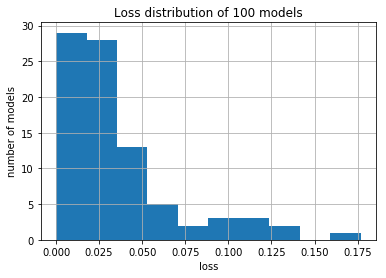

The average error of 100 models is 0.03559


In [52]:
loss_data.hist()
plt.title("Loss distribution of 100 models")
plt.xlabel("loss")
plt.ylabel("number of models")
plt.show()
print('The average error of 100 models is %.5f' %np.mean(loss_data))